> ![](softwarica_covventry.png)

# **$STW-$ $7089CME$: Modeling $CCPP$ Power Plant Energy Output Using Nonlinear Regression:**

**Exploring Data:**

The power plant is running at full capacity for six years (2006-2011).

The provided dataset contains **9,568 hourly measurements** of how much electricity the plant produced. The dataset contains four independent environmental variables and one dependent variable.

**Four key environmental factors** that affect the plant's performance are: 

1. Temperature (T): The outside air temperature in °C
2. Pressure (AP): The air pressure in millibars
3. Humidity (RH): The moisture level in the air as a percentage
4. Exhaust Vacuum (V): The vacuum pressure in the steam turbine (measured in cm Hg)

The main thing we want to predict is:  
1. Electrical Output (EP): How much power the plant generates each hour (in MW)

The power plant uses a two-step system to make electricity efficiently:

1. **Gas Turbine (GT)**:  Burns fuel to generate electricity directly.

2. **Steam Turbine (ST)**: Uses leftover heat from the gas turbine.

By using the waste heat from the gas turbine to power the steam turbine, the plant gets more electricity from the same amount of fuel - making it more cost-effective and environmentally friendly than single-system plants.

Here, we are requeated to identify better mathematical model (from given 5 models) that can accurately predict a power plant’s electricity output based on given real-world conditions like temperature, humidity and others.   

For this, first, import some essential libraries and install them if they haven't been already.

In [1]:
# Install and import packages: 

# Define all required packages: 
pkg_groups <- list(
  data_tools = list(
    packages = c("readr", "dplyr", "tidyr", "purrr", "reshape2", "zoo"),
    purpose = "Data I/O and manipulation"
    # readr: Fast CSV/TSV file reading and parsing  
    # dplyr: Core data manipulation (filter, mutate, summarize)  
    # tidyr: Data tidying (pivoting, nesting, handling missing values)  
    # purrr: Functional programming tools (map, reduce, list operations)  
    # reshape2: Convert data between wide/long formats (melt/dcast)  
    # zoo: Time-series operations (rolling windows, lag calculations) 
), 

  visualization = list(
    packages = c("ggplot2", "GGally", "viridis", "patchwork", "gridExtra", "corrplot"),
    purpose = "Data visualization"
    # ggplot2: Create elegant and customizable data visualizations  
    # GGally: Extended ggplot2 functionality (scatterplot matrices, etc.)  
    # viridis: Colorblind-friendly color scales for plots  
    # patchwork: Combine and arrange multiple ggplot2 plots  
    # gridExtra: Layout arrangements for grid-based graphics  
    # corrplot: Visualize correlation matrices with color coding 
), 

  stats = list(
    packages = c("car", "nortest", "moments", "MASS", "outliers"),
    purpose = "Statistical analysis"
    # car: Regression diagnostics and hypothesis testing  
    # nortest: Normality tests (Anderson-Darling, Shapiro-Wilk etc.)  
    # moments: Skewness, kurtosis and related moment calculations  
    # MASS: Modern applied statistics functions and datasets  
    # outliers: Detect and handle statistical outliers 
  ),

  utilities = list(
    packages = c("stringr", "knitr"),
    purpose = "Utility functions"
    # stringr: Consistent string manipulation and pattern matching  
    #knitr: Dynamic report generation and reproducible research  
  )
)

# install if not installed already and then load them: 
suppressPackageStartupMessages({
  suppressWarnings({
    for (group in pkg_groups) {
      message("[Loading] ", group$purpose, " packages...")
      for (pkg in group$packages) {
        if (!require(pkg, character.only = TRUE, quietly = TRUE)) {
          install.packages(pkg, quiet = TRUE, repos = "https://cloud.r-project.org")
          library(pkg, character.only = TRUE, quietly = TRUE)
        }
      }
    }
  })
})

# Verify that the packages are loaded successfully 
loaded <- search()
message("All packages loaded successfully!")

[Loading] Data I/O and manipulation packages...

[Loading] Data visualization packages...

[Loading] Statistical analysis packages...

[Loading] Utility functions packages...

All packages loaded successfully!



In [2]:
# Setting default values like themes, colors, fonts and size etc for each plot:

# Set default plot size using repr
# width and height are in inches
options(jupyter.plot_mimetypes = "image/png") 
options(repr.plot.width = 20,   # Set default plot width
        repr.plot.height = 8)  # Set default plot height

# Define a custom ggplot2 theme for all plots:
my_custom_theme <- theme_minimal(base_size = 12) +   # Base theme with larger font
                   theme(
                     plot.title = element_text(face = "bold", hjust = 0.5),
                     axis.title = element_text(face = "bold"),
                     legend.position = "bottom"
                   )

# Set this theme as default for all plots
theme_set(my_custom_theme)

# Set default color scale or palette
scale_fill_continuous <- scale_fill_viridis_c   # use Viridis for continuous fill
scale_color_discrete <- scale_color_brewer(palette = "Set2")  # For discrete color scale

Import dataset using `read_csv` from `readr` package:

In [3]:
# Read the dataset using readr package:
data <- read_csv('dataset.csv', show_col_types = FALSE)

In [4]:
# Check the shape: rows and columns of the dataset:
nrow(data) 
ncol(data)

[1] 9568

[1] 5

The dataset contains 5 columns and more than 9500 rows (samples).

In [5]:
# Display the first few rows of the dataset
head(data)

x1,x3,x4,x5,x2
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
8.34,40.77,1010.84,90.01,480.48
23.64,58.49,1011.40,74.20,445.75
29.74,56.90,1007.15,41.91,438.76
19.07,49.69,1007.22,76.79,453.09
11.80,40.66,1017.13,97.20,464.43
13.97,39.16,1016.05,84.60,470.96


Here, the dataframe contains four independent variables $x_1$, $x_3$, $x_4$ and $x_5$. $x_2$ is the  dependent variable:

- `x1`: Ambient Temperature (°C) - it reperesents air temperature  
- `x3`: Ambient Pressure (mbar) - it reperesents atmospheric pressure   
- `x4`: Exhaust Vacuum (cm Hg) - it represents vacuum in steam turbine in cm Hg
- `x5`: Relative Humidity (%) - it represents ambient humidity 

- `x2`: Net Energy Output (MW) - Hourly electrical energy generated in MW

In [6]:
# Check the dimensions of the dataset
dim(data)

[1] 9568    5

In [7]:
# Generate a descriptive statistics table for the dataset:

# identify numeric columns
numeric_cols <- sapply(data, is.numeric)
numeric_data <- data[, numeric_cols]

# Calculate statistics for each column
stats_table <- data.frame(
  variable = names(numeric_data),
  mean = sapply(numeric_data, mean, na.rm = TRUE),
  median = sapply(numeric_data, median, na.rm = TRUE),
  min = sapply(numeric_data, min, na.rm = TRUE),
  max = sapply(numeric_data, max, na.rm = TRUE),
  sd = sapply(numeric_data, sd, na.rm = TRUE),
  q25 = sapply(numeric_data, function(x) quantile(x, 0.25, na.rm = TRUE)),
  q75 = sapply(numeric_data, function(x) quantile(x, 0.75, na.rm = TRUE)),
  skew = sapply(numeric_data, skewness, na.rm = TRUE),
  kurt = sapply(numeric_data, kurtosis, na.rm = TRUE)
)

# use knitr::kable to format the outout nicely: 
kable(stats_table, digits = 3, 
      caption = "Descriptive Statistics for Numeric Variables:")



Table: Descriptive Statistics for Numeric Variables:

|   |variable |     mean|   median|    min|     max|     sd|      q25|     q75|   skew|  kurt|
|:--|:--------|--------:|--------:|------:|-------:|------:|--------:|-------:|------:|-----:|
|x1 |x1       |   19.651|   20.345|   1.81|   37.11|  7.452|   13.510|   25.72| -0.136| 1.962|
|x3 |x3       |   54.306|   52.080|  25.36|   81.56| 12.708|   41.740|   66.54|  0.198| 1.556|
|x4 |x4       | 1013.259| 1012.940| 992.89| 1033.30|  5.939| 1009.100| 1017.26|  0.265| 3.094|
|x5 |x5       |   73.309|   74.975|  25.56|  100.16| 14.600|   63.328|   84.83| -0.432| 2.555|
|x2 |x2       |  454.365|  451.550| 420.26|  495.76| 17.067|  439.750|  468.43|  0.306| 1.951|

In [8]:
# Check data types of columns:
sapply(data, class)

x1        x3        x4        x5        x2 
"numeric" "numeric" "numeric" "numeric" "numeric"

Now, check if the dataset contains any missing values or not:

In [9]:
# Check for missing values
sum(is.na(data))

[1] 0

So, no missing values detected.

Also, check if there any duplicating rows in the data:

In [10]:
# Check for duplicates
sum(duplicated(data))

[1] 41

So, there are 41 rows that are found to be duplicating ie. there are other 41 rows having similar data:

In [11]:
# View all duplicated rows (including their first occurrence)
dup_rows <- data[duplicated(data) | duplicated(data, fromLast = TRUE), ]
print(dup_rows)

# A tibble: 82 × 5
      x1    x3    x4    x5    x2
   <dbl> <dbl> <dbl> <dbl> <dbl>
 1 25.9   75.6 1018.  62.6  443.
 2 29.4   75.6 1018.  50.7  437.
 3 29.5   75.6 1018.  50.6  431.
 4 25.2   75.6 1017.  69.8  446.
 5  6.86  41.2 1020.  79.1  490.
 6 28.4   75.6 1017.  55.2  439.
 7 12.3   41.2 1019.  52.2  474.
 8 24.8   75.6 1017.  68.2  440.
 9  8.44  41.2 1020.  70.7  486.
10 24.6   59.6 1010.  85.4  441.
# ℹ 72 more rows


In [12]:
# Extract all duplicated rows including their first occurrences
dup_rows <- data[duplicated(data) | duplicated(data, fromLast = TRUE), ]

# Sort duplicate rows to group duplicates together 
dup_rows_sorted <- dup_rows[do.call(order, dup_rows), ]

print(dup_rows_sorted)

# A tibble: 82 × 5
      x1    x3    x4    x5    x2
   <dbl> <dbl> <dbl> <dbl> <dbl>
 1  6.03  41.2 1020.  84.2  489.
 2  6.03  41.2 1020.  84.2  489.
 3  6.06  41.2 1020.  84.7  490.
 4  6.06  41.2 1020.  84.7  490.
 5  6.4   41.2 1020.  85.4  489.
 6  6.4   41.2 1020.  85.4  489.
 7  6.86  41.2 1020.  79.1  490.
 8  6.86  41.2 1020.  79.1  490.
 9  7.24  41.2 1020.  80.6  487.
10  7.24  41.2 1020.  80.6  487.
# ℹ 72 more rows


This makes comparision of duplicates easy. Every consecutive pair of rows contains the same data.

In [13]:
# Count number of rows before dropping duplicates:
nrow(data)

[1] 9568

Now, clean the dataset by deleting duplicated samples:

In [14]:
# create a variable which contains only duplicated rows and their first occurrence:
duplicates_only <- duplicated(data)

# Drop only those duplicated rows
data <- data[!duplicates_only, ]

In [15]:
# Check the number of rows after removing duplicates
nrow(data)

[1] 9527

Now, add a new column naming `time` which acts as the time series data for our dataframe `data`.

In [16]:
# Add time column at the beginning of the dataset which acts as the time stamps
# The data assumbed to be recorded at an equal time interval of 1 units (1 hour)
data$time <- 1:nrow(data)


# Reorder the columns
data <- data[, c("time", "x1", "x3", "x4", "x5", "x2")] 
# x2 is the dependent variable (sometimes denoted as y) 
#and move x2 to the end of the dataset as per the general convention in machine learning 

In [17]:
# Check if the new column was successfully created or not
colnames(data)  # Shows all column names in the dataframe

[1] "time" "x1"   "x3"   "x4"   "x5"   "x2"

In [18]:
# check the data types of columns:
sapply(data, class)

time        x1        x3        x4        x5        x2 
"integer" "numeric" "numeric" "numeric" "numeric" "numeric"

All set.

## **Task-1: Preliminary Data Analysis:**

#### **Task-1.1: Time Series Analysis:**

Following time-series-plot shows how each valriable (`temperature`, `pressure`, `humidity`, `vacuum` and `energy output`) changes over time.

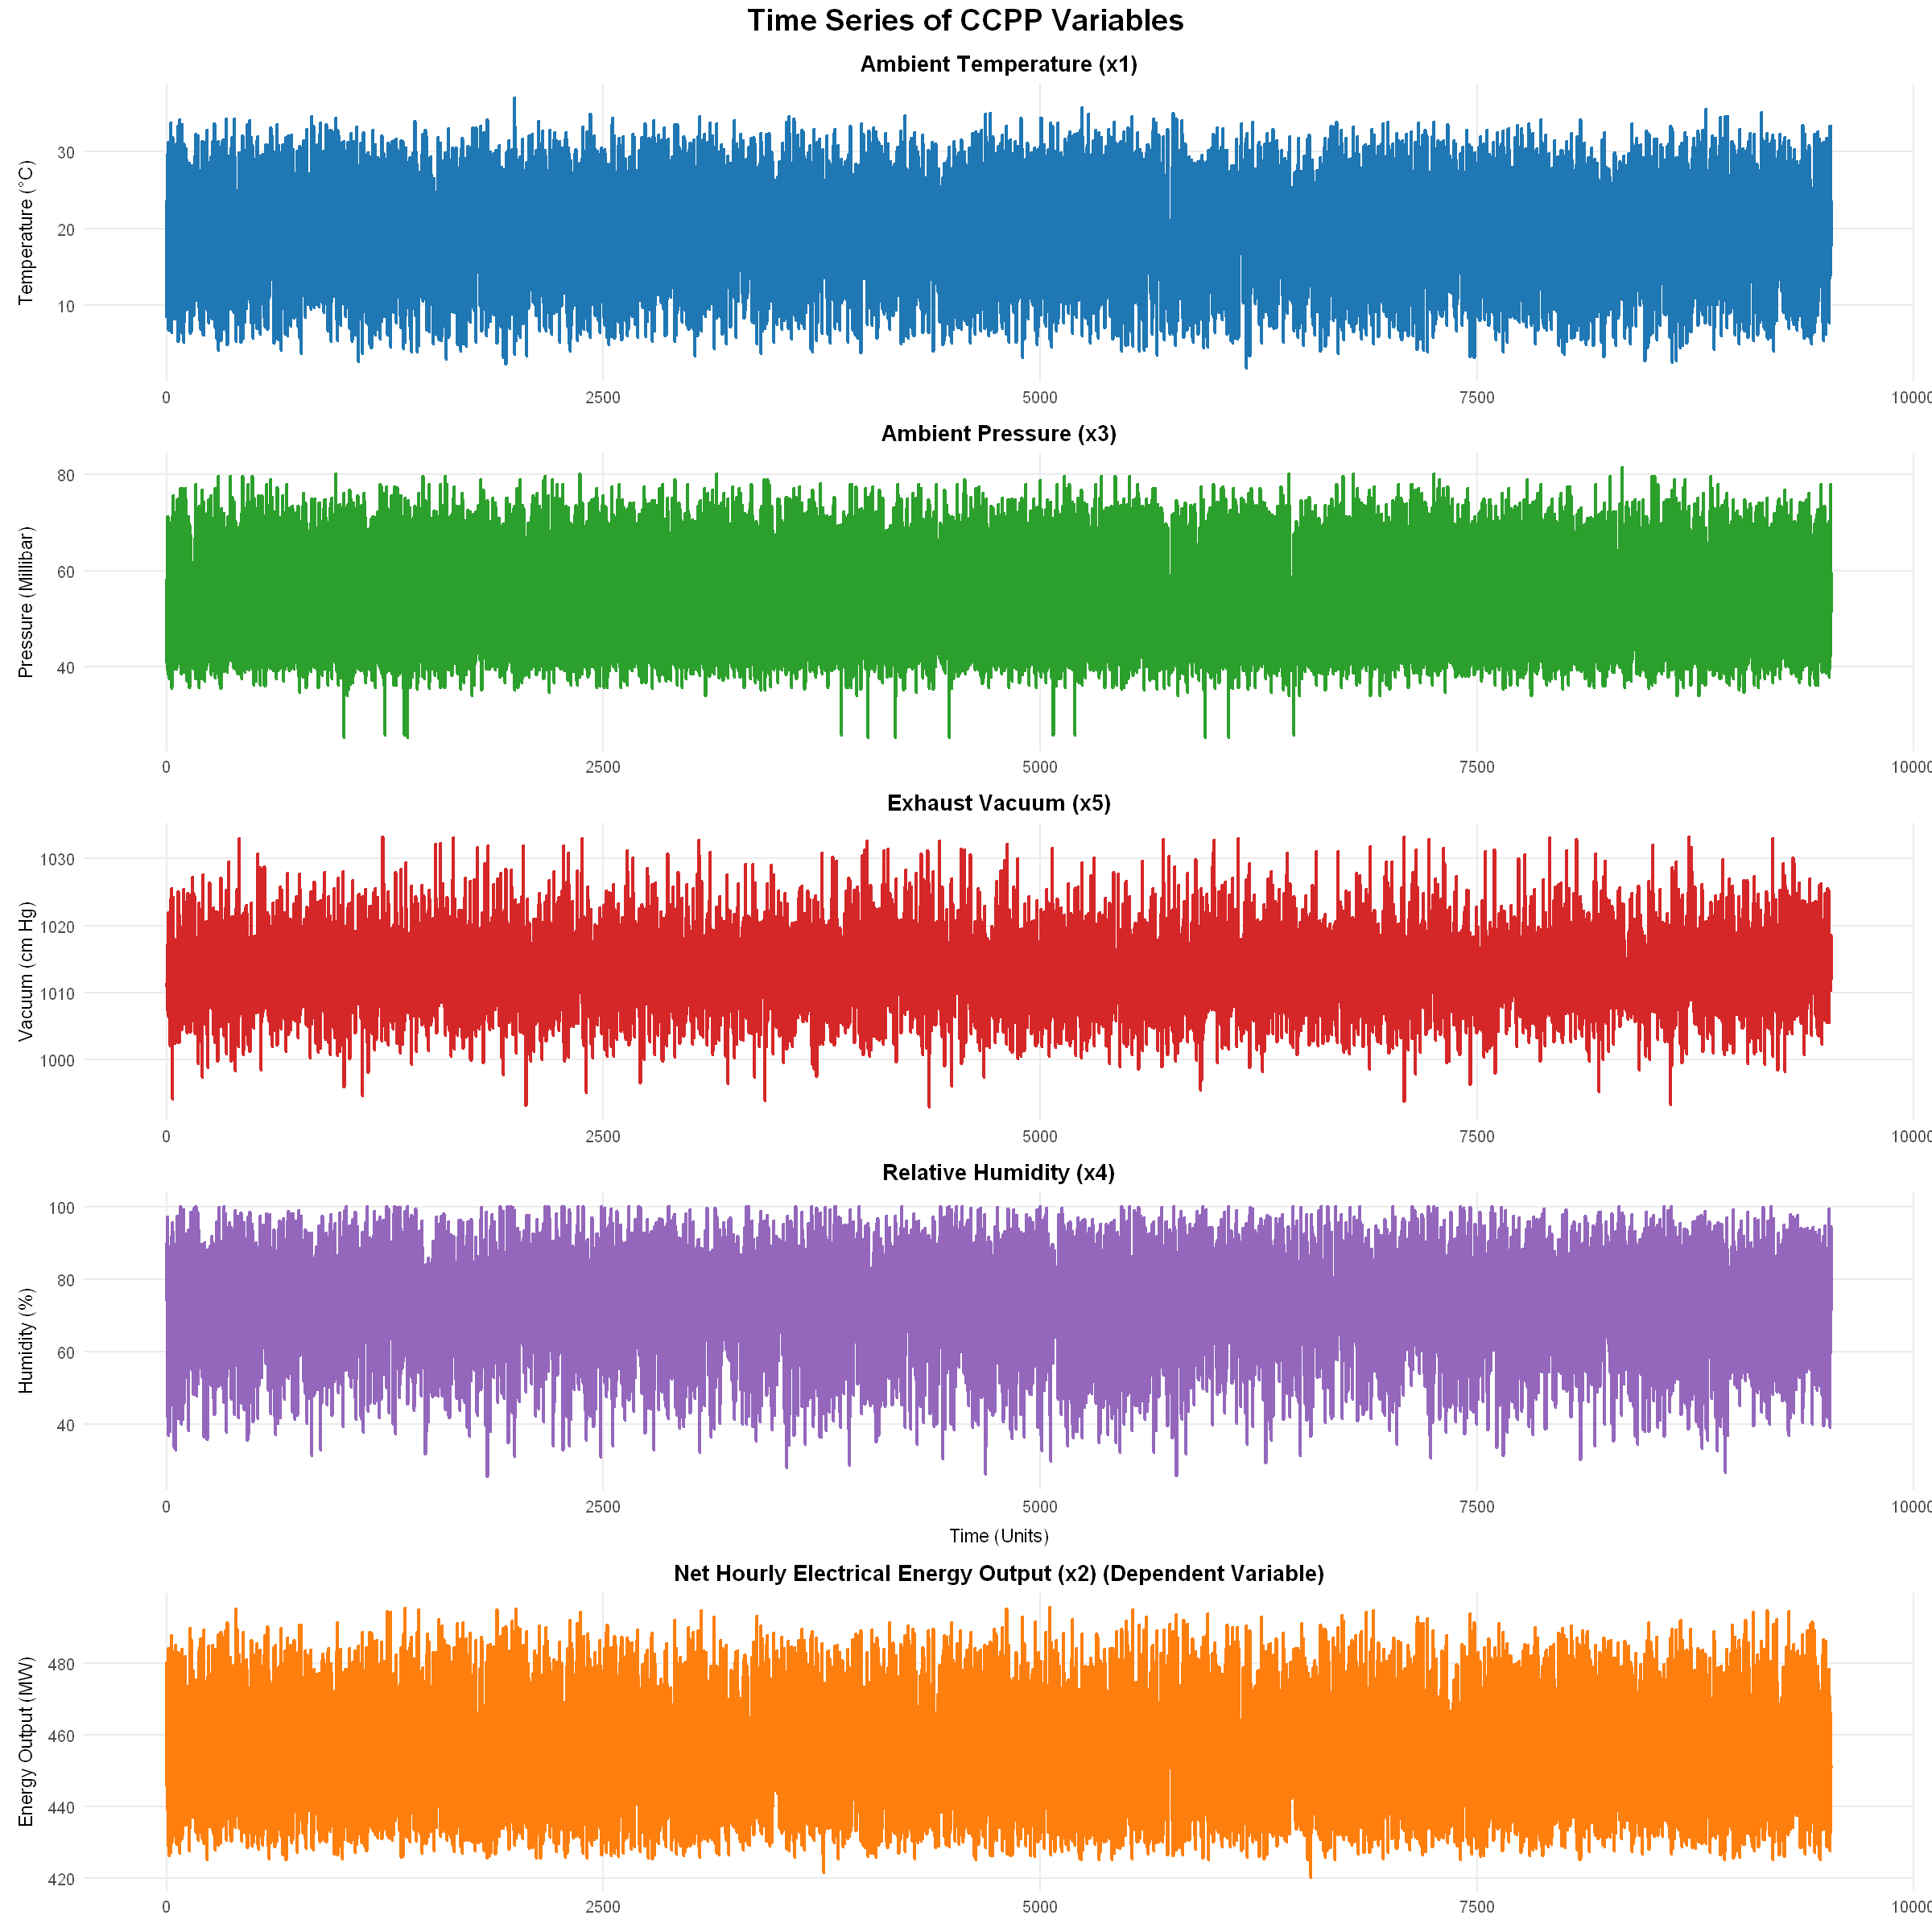

In [19]:
# supress warnings temporarily:
options(warn = -1)

# Function to create individual time series plots:
create_ts_plot <- function(data, var, color, title, y_label) {
  ggplot(data, aes_string(x = "time", y = var)) +
    geom_line(color = color, linewidth = 1.2) +  
    labs(title = title,
         y = y_label,
         x = NULL) +
    theme_minimal(base_size = 14) + 
    theme(
      plot.title = element_text(hjust = 0.5, size = 16, face = "bold"),
      panel.grid.minor = element_blank(),
      axis.text = element_text(size = 12),
      axis.title = element_text(size = 14)
    )
}

# Create individual plots for each variable 
p1 <- create_ts_plot(data, "x1", "#1f77b4", "Ambient Temperature (x1)", "Temperature (°C)")
p2 <- create_ts_plot(data, "x2", "#ff7f0e", "Net Hourly Electrical Energy Output (x2) (Dependent Variable)", "Energy Output (MW)")
p3 <- create_ts_plot(data, "x3", "#2ca02c", "Ambient Pressure (x3)", "Pressure (Millibar)")
p4 <- create_ts_plot(data, "x4", "#d62728","Exhaust Vacuum (x5)", "Vacuum (cm Hg)") 
p5 <- create_ts_plot(data, "x5", "#9467bd", "Relative Humidity (x4)", "Humidity (%)")

# Add x-axis label only to the bottom plot
p5 <- p5 + labs(x = "Time (Units)") + 
  theme(axis.title.x = element_text(size = 14, margin = margin(t = 10)))

# Combine all plots with patchwork
combined_plot <- p1 / p3 / p4 / p5 / p2 +
  plot_annotation(
    title = "Time Series of CCPP Variables",
    theme = theme(plot.title = element_text(size = 22, hjust = 0.5, face = "bold"))
  )

# set the dimensions for better viewing experience 
options(repr.plot.width = 20, repr.plot.height = 20)  # For Jupyter/IRkernel

# Display the combined plot
combined_plot

# Reset warnings back to default
options(warn = 0)

In [20]:
head(data)

time,x1,x3,x4,x5,x2
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,8.34,40.77,1010.84,90.01,480.48
2,23.64,58.49,1011.40,74.20,445.75
3,29.74,56.90,1007.15,41.91,438.76
4,19.07,49.69,1007.22,76.79,453.09
5,11.80,40.66,1017.13,97.20,464.43
6,13.97,39.16,1016.05,84.60,470.96


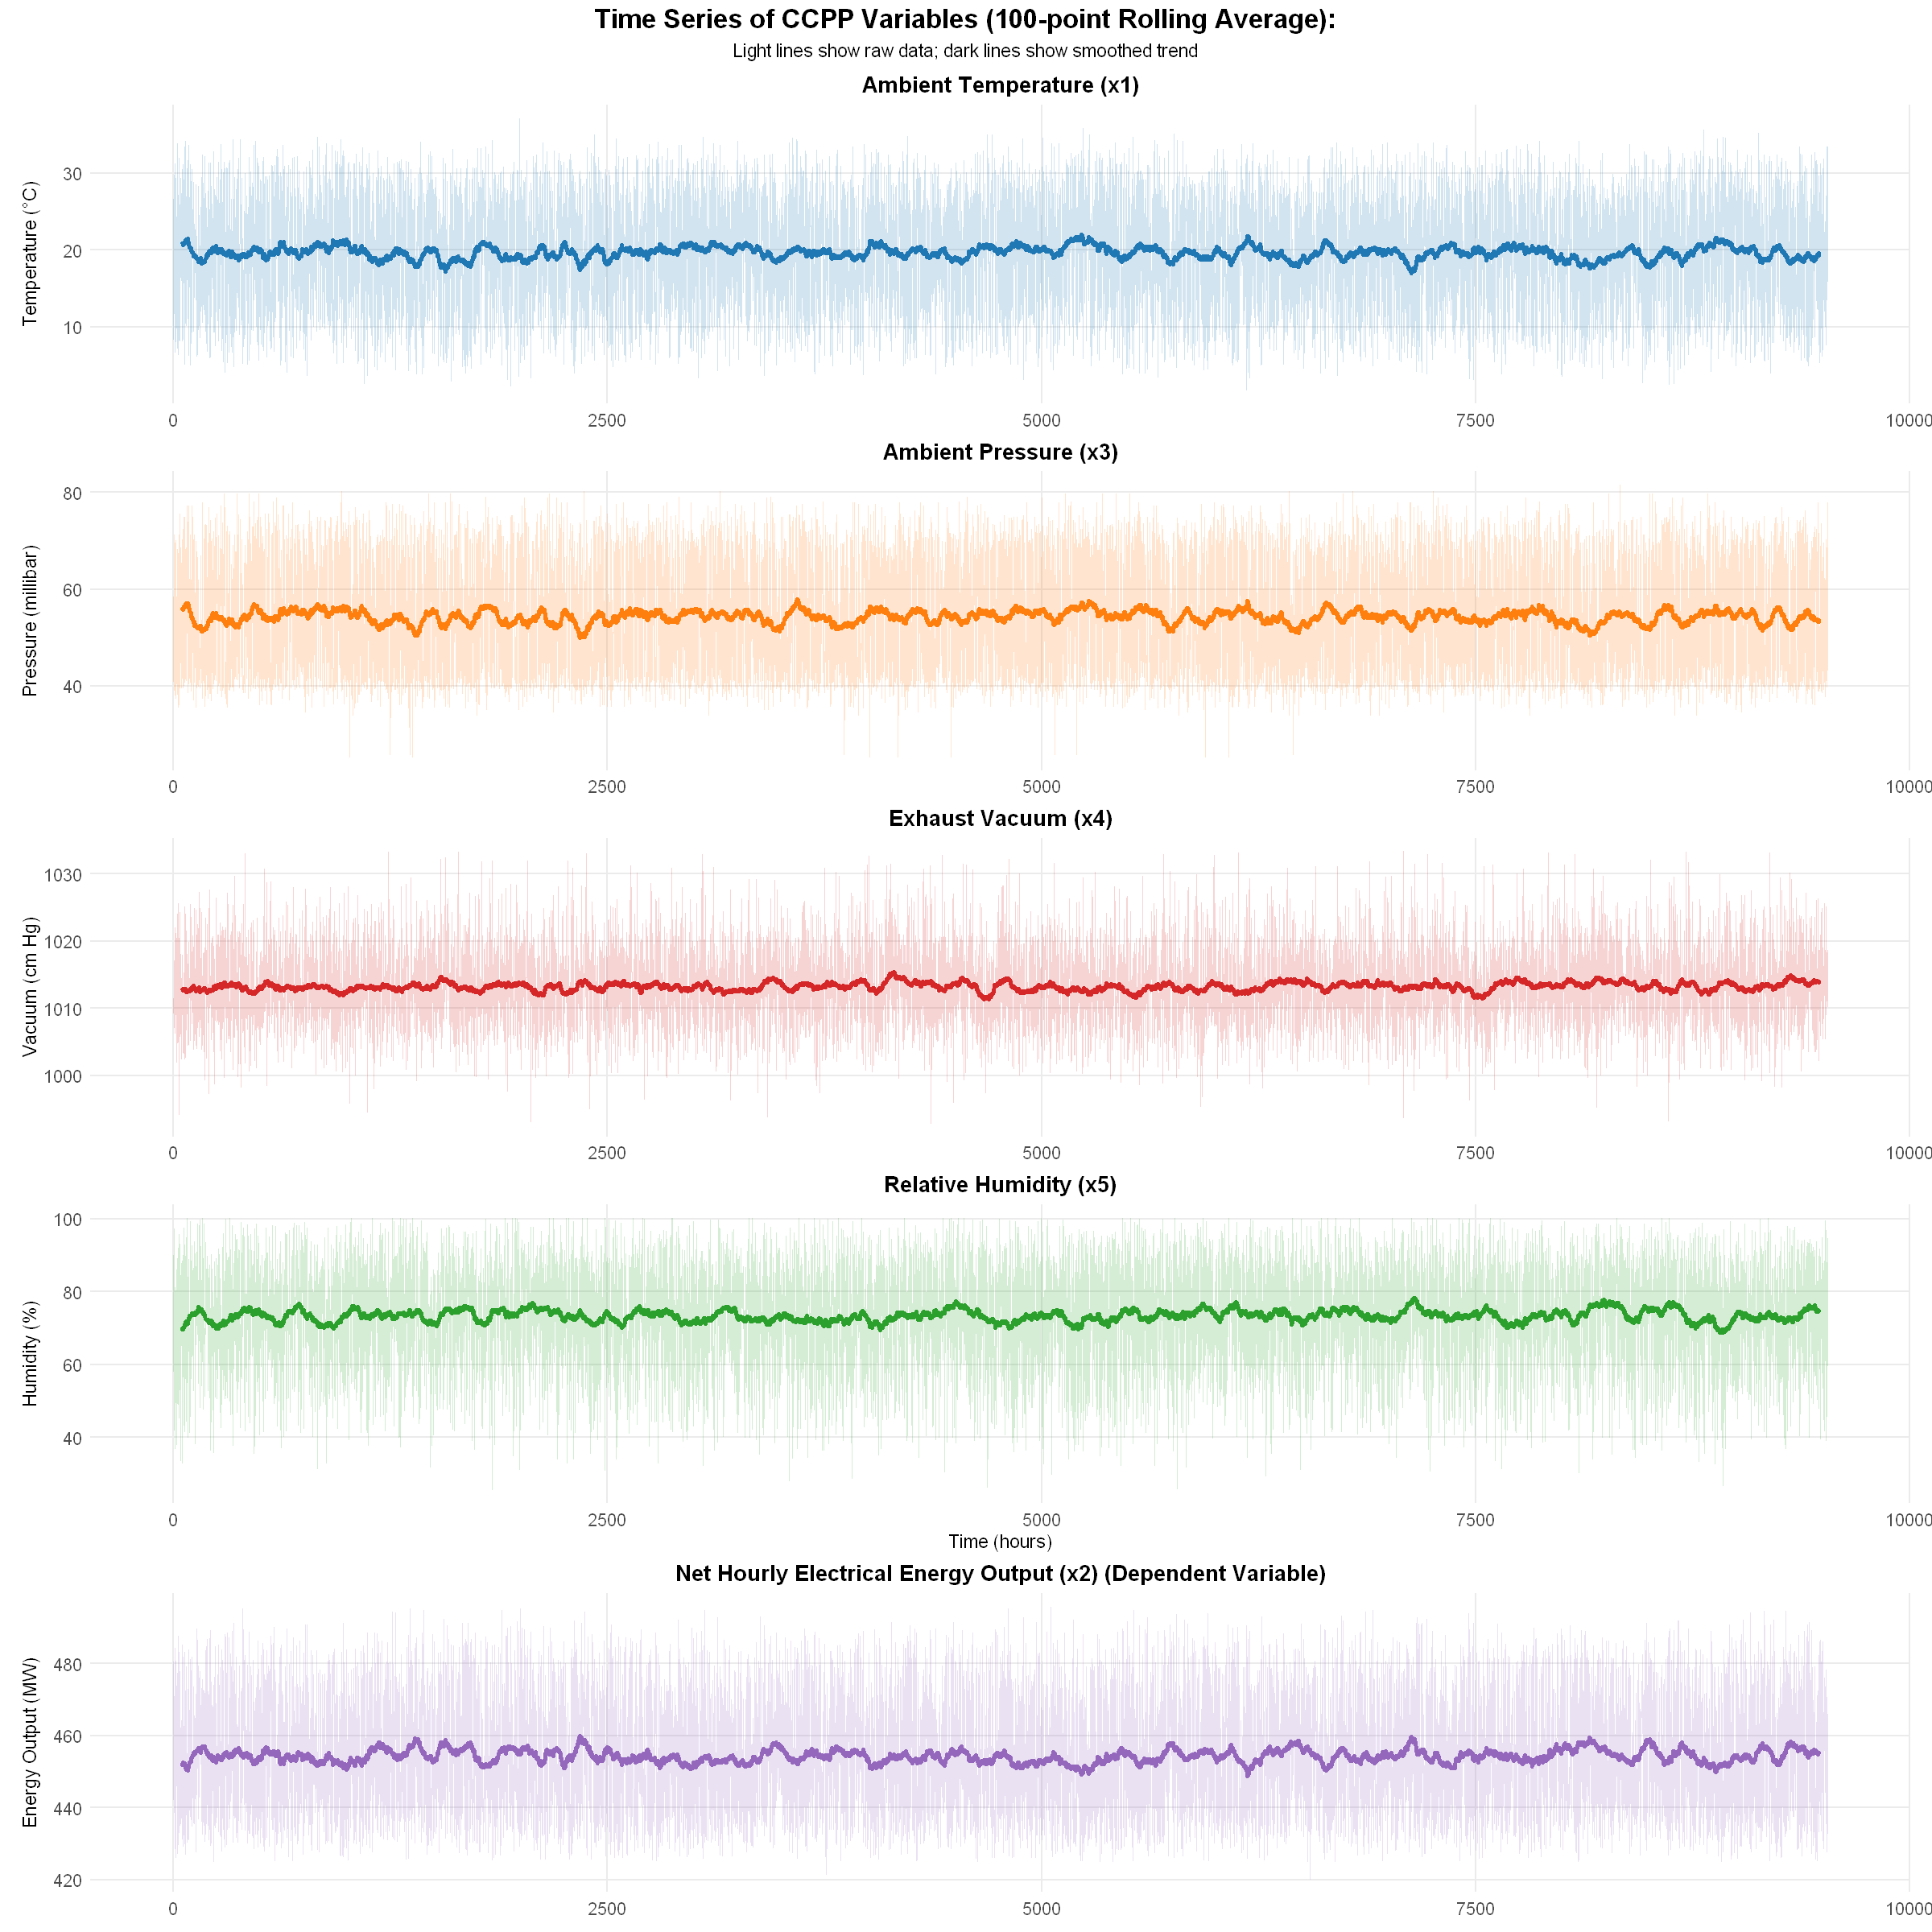

In [21]:
# supress warnings:
options(warn= -1)

# Define window size for the rolling average
window_size <- 100

# Apply rolling window to each variable
data_smoothed <- data %>%
  mutate(
    x1_smooth = rollmean(x1, k = window_size, fill = NA, align = "center"),
    x3_smooth = rollmean(x3, k = window_size, fill = NA, align = "center"),
    x4_smooth = rollmean(x4, k = window_size, fill = NA, align = "center"),
    x5_smooth = rollmean(x5, k = window_size, fill = NA, align = "center"),
    x2_smooth = rollmean(x2, k = window_size, fill = NA, align = "center")
  )

# Function to create plots with both raw and smoothed data
create_smoothed_plot <- function(data, raw_var, smooth_var, color, title, y_label) {
  ggplot(data, aes(x = time)) +
    # Raw data in background with transparency
    geom_line(aes(y = .data[[raw_var]]), color = color, alpha = 0.2, linewidth = 0.5) +
    # Smoothed data in foreground
    geom_line(aes(y = .data[[smooth_var]]), color = color, linewidth = 1.5) +
    labs(title = title,
         y = y_label,
         x = NULL) +
    theme_minimal(base_size = 14) +
    theme(
      plot.title = element_text(hjust = 0.5, size = 16, face = "bold"),
      panel.grid.minor = element_blank(),
      axis.text = element_text(size = 13),
      axis.title = element_text(size = 14),
      plot.margin = margin(t = 5, r = 10, b = 5, l = 10)
    )
}

# Create individual plots for each variable
p1 <- create_smoothed_plot(data_smoothed, "x1", "x1_smooth", "#1f77b4", 
                          "Ambient Temperature (x1)", "Temperature (°C)")

p3 <- create_smoothed_plot(data_smoothed, "x3", "x3_smooth", "#ff7f0e", 
                          "Ambient Pressure (x3)", "Pressure (millibar)")

p5 <- create_smoothed_plot(data_smoothed, "x5", "x5_smooth", "#2ca02c", 
                          "Relative Humidity (x5)", "Humidity (%)")

p4 <- create_smoothed_plot(data_smoothed, "x4", "x4_smooth", "#d62728", 
                          "Exhaust Vacuum (x4)", "Vacuum (cm Hg)")

p2 <- create_smoothed_plot(data_smoothed, "x2", "x2_smooth", "#9467bd", 
                          "Net Hourly Electrical Energy Output (x2) (Dependent Variable)", "Energy Output (MW)")

# Add x-axis label only to the bottom plot
p5 <- p5 + labs(x = "Time (hours)")

# Combine all plots with patchwork
combined_smoothed_plot <- p1 / p3 / p4 / p5 / p2 +
  plot_annotation(
    title = "Time Series of CCPP Variables (100-point Rolling Average):",
    subtitle = "Light lines show raw data; dark lines show smoothed trend",
    theme = theme(
      plot.title = element_text(size = 20, hjust = 0.5, face = "bold"),
      plot.subtitle = element_text(size = 14, hjust = 0.5)
    )
  )

# Display the combined plot
options(repr.plot.width = 20, repr.plot.height = 20)
combined_smoothed_plot

# Reset warnings back to default 
options(warn=0)

$title
[1] "Time Series of CCPP Variables (200-point Segments)"

$subtitle
[1] "Each point represents the average of 200 consecutive observations"

$caption
list()
attr(,"class")
[1] "waiver"

$tag_levels
list()
attr(,"class")
[1] "waiver"

$tag_prefix
list()
attr(,"class")
[1] "waiver"

$tag_suffix
list()
attr(,"class")
[1] "waiver"

$tag_sep
list()
attr(,"class")
[1] "waiver"

$theme
List of 2
 $ plot.title   :List of 11
  ..$ family       : NULL
  ..$ face         : chr "bold"
  ..$ colour       : NULL
  ..$ size         : num 20
  ..$ hjust        : num 0.5
  ..$ vjust        : NULL
  ..$ angle        : NULL
  ..$ lineheight   : NULL
  ..$ margin       : NULL
  ..$ debug        : NULL
  ..$ inherit.blank: logi FALSE
  ..- attr(*, "class")= chr [1:2] "element_text" "element"
 $ plot.subtitle:List of 11
  ..$ family       : NULL
  ..$ face         : NULL
  ..$ colour       : NULL
  ..$ size         : num 14
  ..$ hjust        : num 0.5
  ..$ vjust        : NULL
  ..$ angle        : N

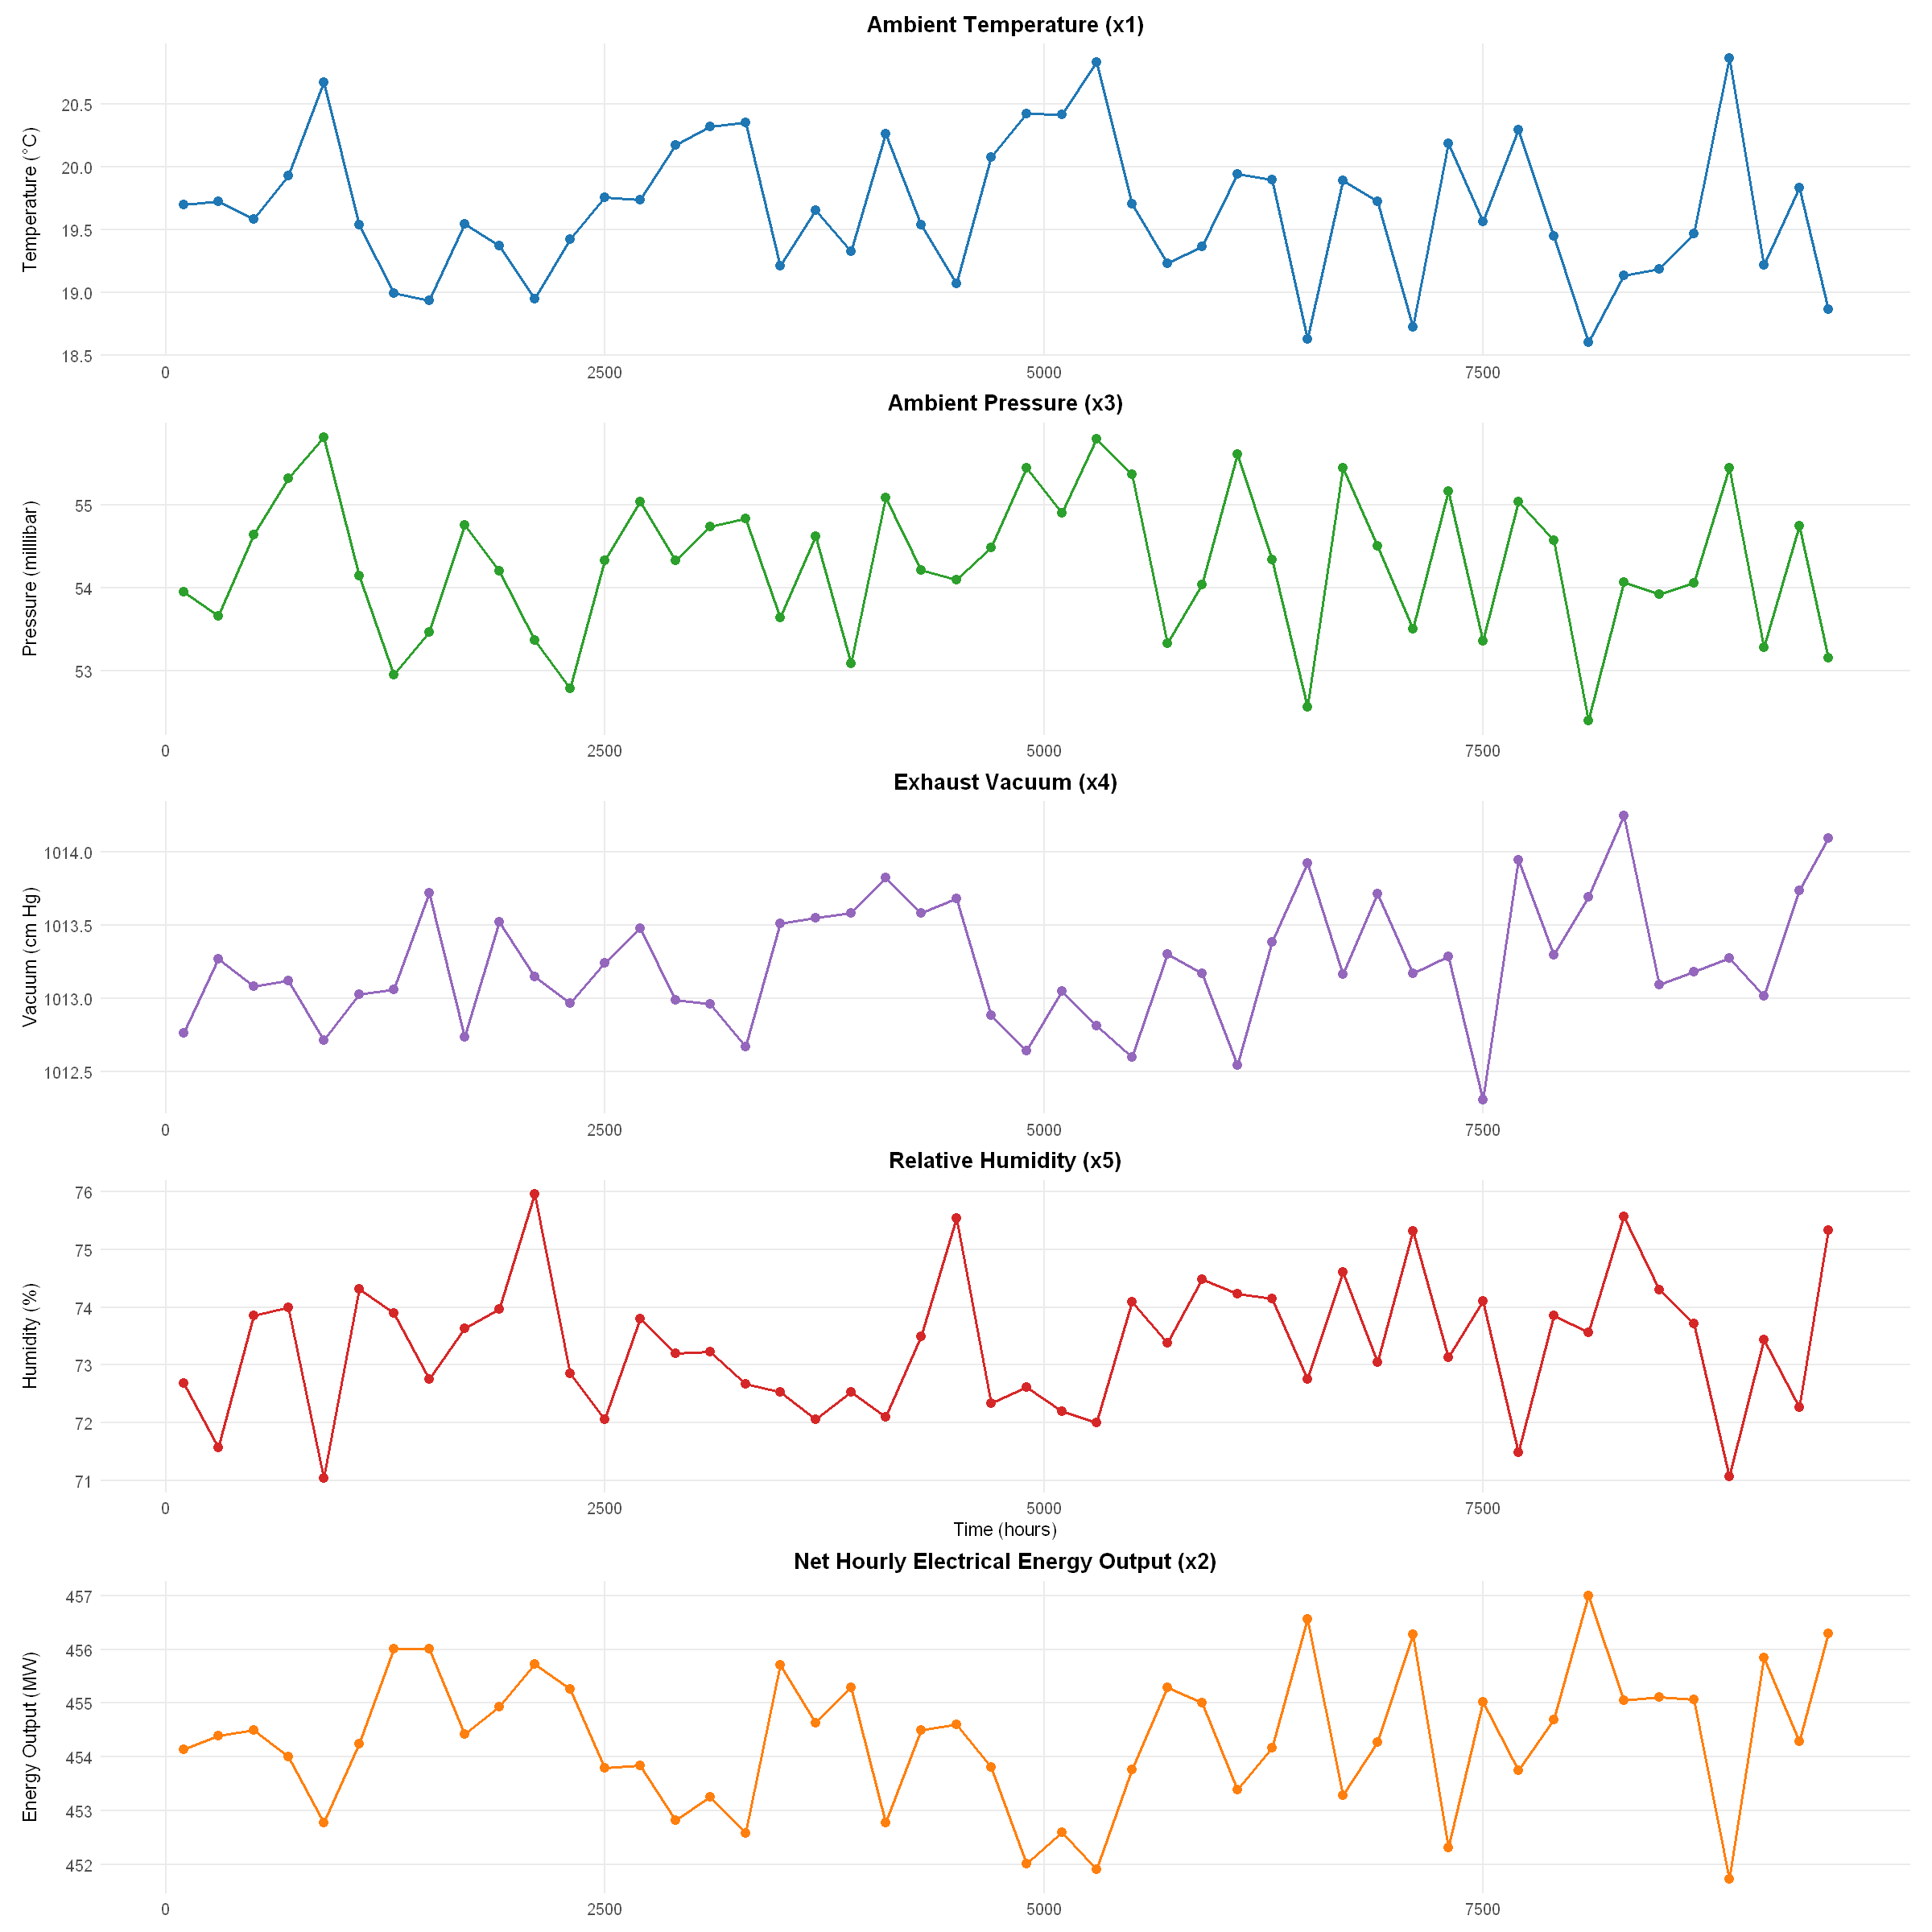

In [22]:
# Create a high-level view by segmenting the data
# Each segment consists of 200 consecutive observations

# supress warnings for this code block:
options(warn = -1)

# Define segment size:
segment_size <- 200 # Number of observations per segment
  
# Create a segment identifier column
data$segment <- ceiling(data$time / segment_size)
  
# Calculate average for each segment and variable
segment_averages <- data %>%
group_by(segment) %>%
summarize(
    time = mean(time),  # Use the middle time point of each segment
    x1_avg = mean(x1),
    x2_avg = mean(x2),
    x3_avg = mean(x3),
    x4_avg = mean(x4),
    x5_avg = mean(x5)
)
  
# Function to create segment average plots
create_segment_plot <- function(data, var, color, title, y_label) {
ggplot(data, aes(x = time, y = .data[[var]])) +
    # Add points for each segment average
    geom_point(color = color, size = 3) +
    # Connect points with lines
    geom_line(color = color, linewidth = 1) +
    # Add labels
    labs(title = title,
        y = y_label,
        x = NULL) +
      theme_minimal(base_size = 14) +
      theme(
        plot.title = element_text(hjust = 0.5, size = 16, face = "bold"),
        panel.grid.minor = element_blank(),
        axis.text = element_text(size = 12),
        axis.title = element_text(size = 14),
        plot.margin = margin(t = 5, r = 10, b = 5, l = 10)
      )
  }
  
# Create individual plots for each variable
p1 <- create_segment_plot(segment_averages, "x1_avg", "#1f77b4", 
                           "Ambient Temperature (x1)", "Temperature (°C)")
p2 <- create_segment_plot(segment_averages, "x2_avg", "#ff7f0e", 
                           "Net Hourly Electrical Energy Output (x2)", "Energy Output (MW)")
p3 <- create_segment_plot(segment_averages, "x3_avg", "#2ca02c", 
                           "Ambient Pressure (x3)", "Pressure (milllibar)")
p5 <- create_segment_plot(segment_averages, "x5_avg", "#d62728", 
                           "Relative Humidity (x5)", "Humidity (%)")
p4 <- create_segment_plot(segment_averages, "x4_avg", "#9467bd", 
                           "Exhaust Vacuum (x4)", "Vacuum (cm Hg)")
  
# Add x-axis label only to the bottom plot
p5 <- p5 + labs(x = "Time (hours)")
  
# Combine all plots with patchwork
combined_segment_plot <- p1 / p3 / p4 / p5/ p2
    plot_annotation(
      title = "Time Series of CCPP Variables (200-point Segments)",
      subtitle = "Each point represents the average of 200 consecutive observations",
      theme = theme(
        plot.title = element_text(size = 20, hjust = 0.5, face = "bold"),
        plot.subtitle = element_text(size = 14, hjust = 0.5)
      )
    )
  
# Display the combined plot
options(repr.plot.width = 20, repr.plot.height = 20)
print(combined_segment_plot)

# Reset warnings back to default
options(warn = 0)

#### **Task-1.2: Histograms with Density Plots:**

In [23]:
head(data)

time,x1,x3,x4,x5,x2,segment
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,8.34,40.77,1010.84,90.01,480.48,1
2,23.64,58.49,1011.40,74.20,445.75,1
3,29.74,56.90,1007.15,41.91,438.76,1
4,19.07,49.69,1007.22,76.79,453.09,1
5,11.80,40.66,1017.13,97.20,464.43,1
6,13.97,39.16,1016.05,84.60,470.96,1


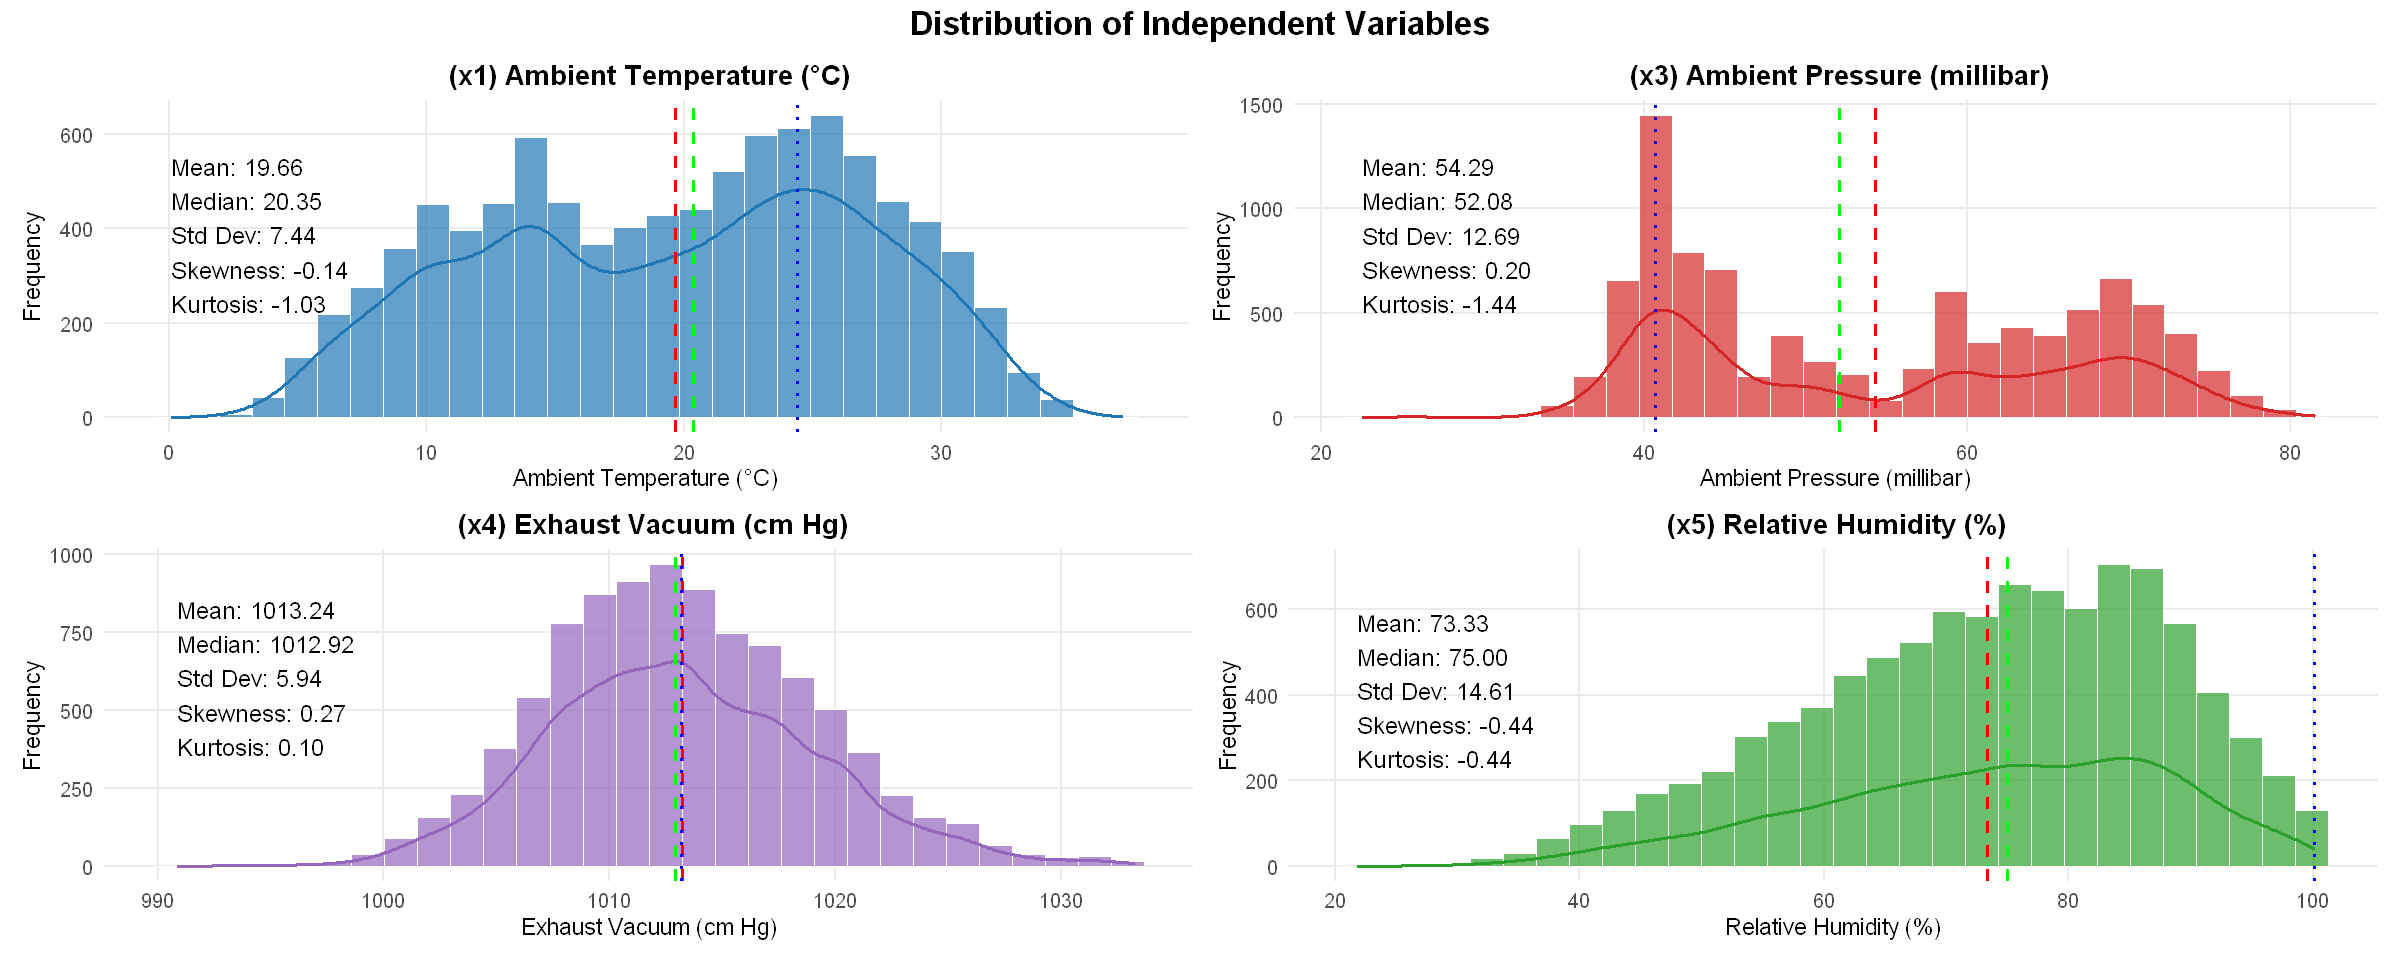

In [24]:
# Create histogram plots with density curves for independent variables: x1, x3, x4, x5 

# Suppress warnings
options(warn = -1)

# Function to calculate mode
calculate_mode <- function(x) {
  # Create frequency table
  ux <- unique(x)
  # Find the value with highest frequency
  ux[which.max(tabulate(match(x, ux)))]
}

# Function to create histogram with density plot and statistics
create_hist_density_plot <- function(data, var, color, fill, title, x_label) {
  # Calculate statistics
  mean_val <- mean(data[[var]])
  median_val <- median(data[[var]])
  mode_val <- calculate_mode(round(data[[var]], 1))  # Round to 1 decimal for better mode calculation
  sd_val <- sd(data[[var]])
  skew_val <- moments::skewness(data[[var]])
  kurt_val <- moments::kurtosis(data[[var]]) - 3  # Excess kurtosis
  
  # Create the plot
  p <- ggplot(data, aes_string(x = var)) +
    # Add histogram
    geom_histogram(aes(y = after_stat(count)), 
                  bins = 30, 
                  fill = fill, 
                  color = "white", 
                  alpha = 0.7) +
    # Add density curve
    geom_density(aes(y = after_stat(count)), 
                color = color, 
                linewidth = 1) +
    # Add vertical lines for mean, median, and mode
    geom_vline(xintercept = mean_val, color = "red", linetype = "dashed", linewidth = 1) +
    geom_vline(xintercept = median_val, color = "green", linetype = "dashed", linewidth = 1) +
    geom_vline(xintercept = mode_val, color = "blue", linetype = "dotted", linewidth = 1) +
    # Add labels
    labs(title = title,
         x = x_label,
         y = "Frequency") +
    # Add statistics as text box
    annotate("text", 
            x = min(data[[var]]) - 0.05 * (max(data[[var]]) - min(data[[var]])), 
            y = 0.9 * max(ggplot_build(ggplot(data, aes_string(x = var)) + 
                                      geom_histogram(bins = 30))$data[[1]]$count),
            label = sprintf("Mean: %.2f\nMedian: %.2f\nStd Dev: %.2f\nSkewness: %.2f\nKurtosis: %.2f", 
                           mean_val, median_val, sd_val, skew_val, kurt_val),
            hjust = 0, 
            vjust = 1,
            size = 5,
            color = "black",
            fontface = "plain",
            family = "sans") +
    # Add theme
    theme_minimal(base_size = 14) +
    theme(
      plot.title = element_text(hjust = 0.5, size = 16, face = "bold"),
      panel.grid.minor = element_blank(),
      axis.text = element_text(size = 12),
      axis.title = element_text(size = 14)
    )
  
  return(p)
}

# Create plots for independent variables
p1 <- create_hist_density_plot(data, "x1", "#1f77b4", "#1f77b4", 
                              " (x1) Ambient Temperature (°C)", "Ambient Temperature (°C)")
p5 <- create_hist_density_plot(data, "x5", "#2ca02c", "#2ca02c", 
                              " (x5) Relative Humidity (%)", "Relative Humidity (%)")
p3 <- create_hist_density_plot(data, "x3", "#d62728", "#d62728", 
                              " (x3) Ambient Pressure (millibar)", "Ambient Pressure (millibar)")
p4 <- create_hist_density_plot(data, "x4", "#9467bd", "#9467bd", 
                              " (x4) Exhaust Vacuum (cm Hg)", "Exhaust Vacuum (cm Hg)")

# Arrange plots in a 2x2 grid
combined_hist_plot <- (p1 + p3) / (p4 + p5) +
  plot_annotation(
    title = "Distribution of Independent Variables",
    theme = theme(
      plot.title = element_text(size = 20, hjust = 0.5, face = "bold")
    )
  )

# Display the combined plot
options(repr.plot.width = 20, repr.plot.height = 8)
print(combined_hist_plot)

# Reset warnings
options(warn = 0)

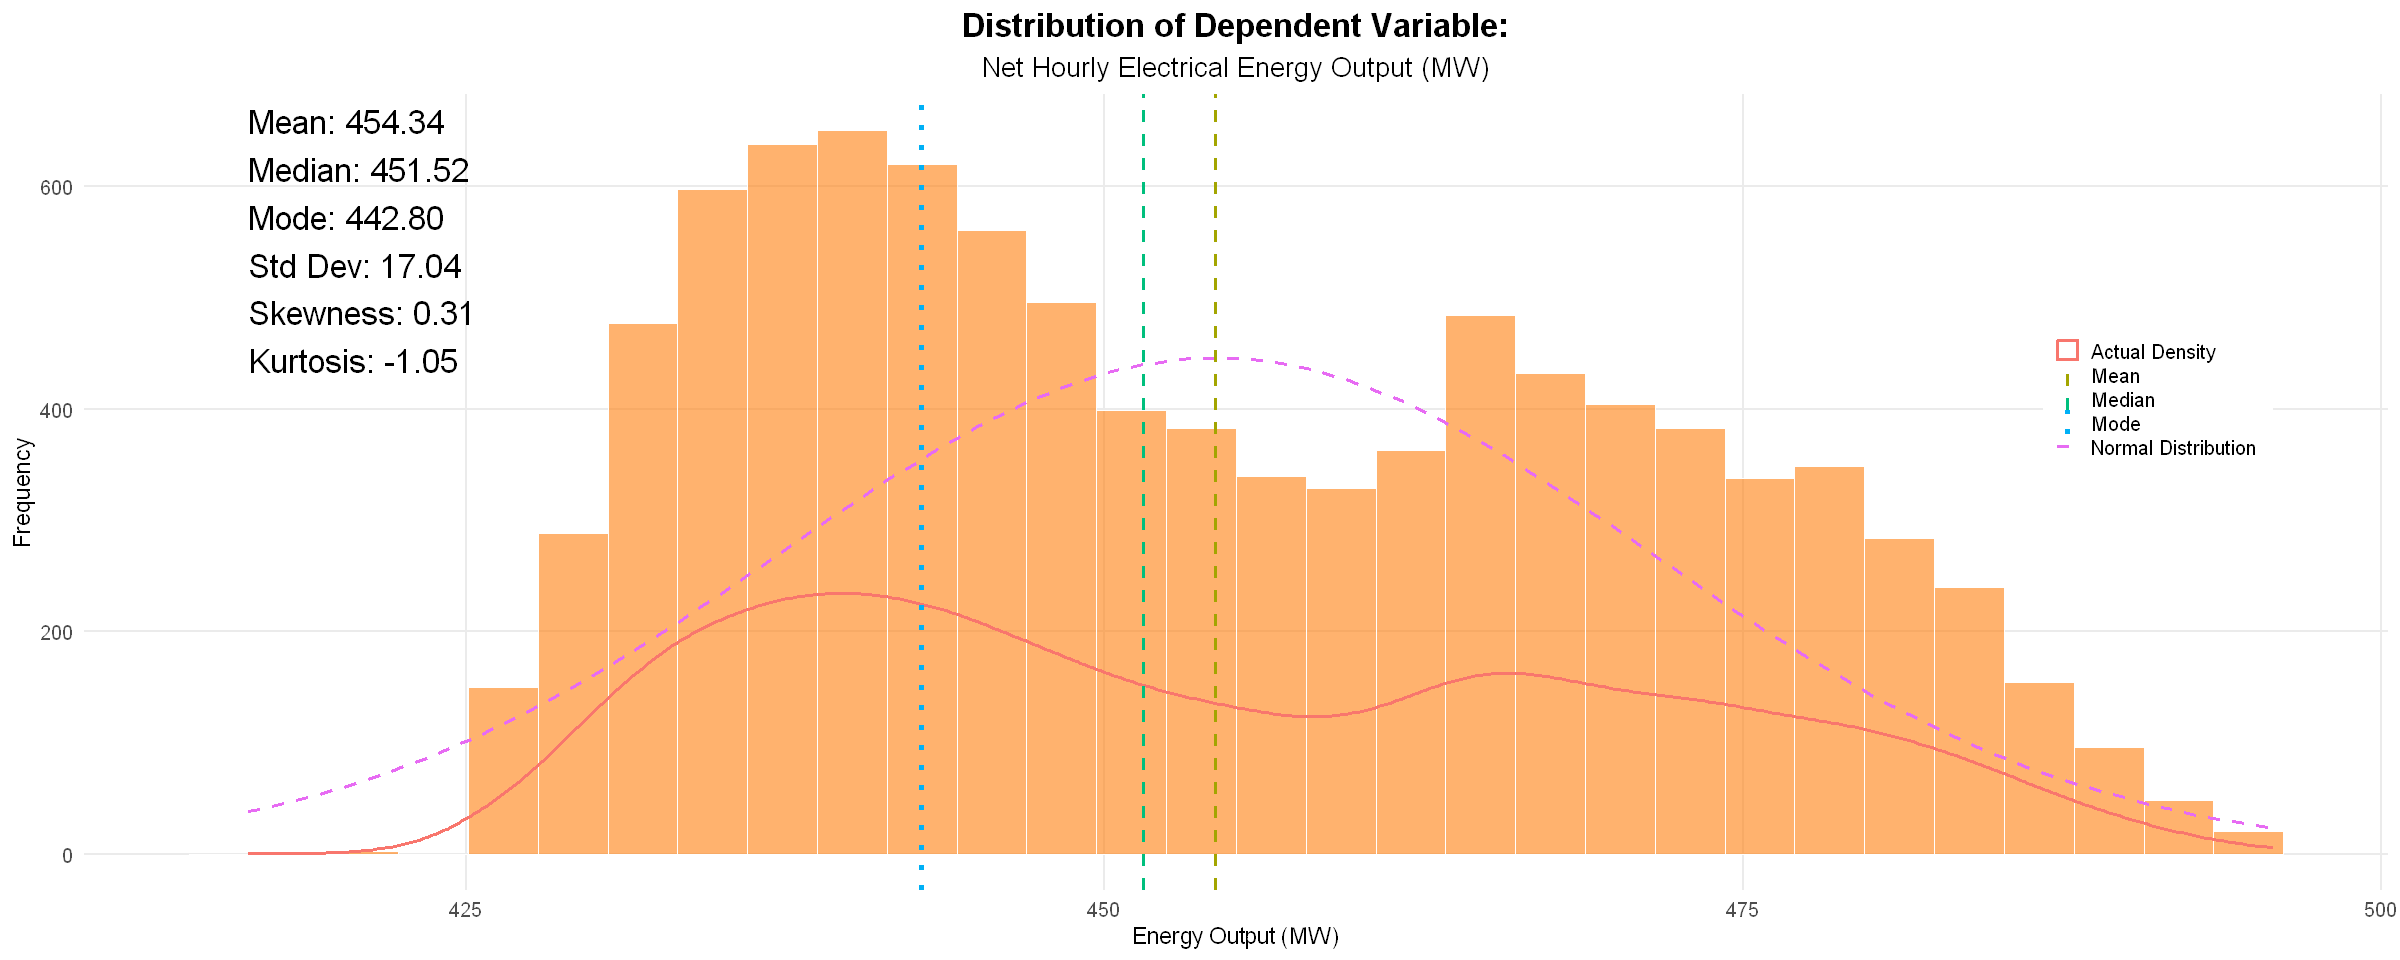

In [25]:
# Create histogran for dependent variable: x2 ie. Energy Output (MW): 

# Suppress warnings
options(warn = -1)

# Function to calculate mode: 
calculate_mode <- function(x) {
  # Create frequency table
  ux <- unique(x)
  # Find the value with highest frequency
  ux[which.max(tabulate(match(x, ux)))]
}

# Calculate statistics for x2
mean_val <- mean(data$x2)
median_val <- median(data$x2)
mode_val <- calculate_mode(round(data$x2, 1))
sd_val <- sd(data$x2)
skew_val <- skewness(data$x2)
kurt_val <- kurtosis(data$x2) - 3

# Get histogram data for scaling
hist_data <- hist(data$x2, plot = FALSE, breaks = 30)
max_count <- max(hist_data$counts)
bin_width <- hist_data$breaks[2] - hist_data$breaks[1]

# Create the plot
p_dep <- ggplot(data, aes(x = x2)) +
  geom_histogram(aes(y = after_stat(count)), bins = 30,
                 fill = "#ff7f0e", color = "white", alpha = 0.6) +
  
  geom_density(aes(y = after_stat(count), color = "Actual Density"), linewidth = 1) +
  
  stat_function(aes(color = "Normal Distribution"), fun = function(x) {
    scaling_factor <- nrow(data) * bin_width
    dnorm(x, mean = mean_val, sd = sd_val) * scaling_factor
  }, linewidth = 1, linetype = "dashed") +
  
  # Proper mappings to include in legend: 
  geom_vline(aes(xintercept = mean_val, color = "Mean"), linetype = "dashed", linewidth = 1) +
  geom_vline(aes(xintercept = median_val, color = "Median"), linetype = "dashed", linewidth = 1) +
  geom_vline(aes(xintercept = mode_val, color = "Mode"), linetype = "dotted", linewidth = 1.5) +
  
  labs(
    title = "Distribution of Dependent Variable:",
    subtitle = "Net Hourly Electrical Energy Output (MW)",
    x = "Energy Output (MW)",
    y = "Frequency",
    color = ""
  ) +
  
  annotate("text",
           x = min(data$x2) - 0.05 * (max(data$x2) - min(data$x2)),
           y = 0.9 * max_count,
           label = sprintf("Mean: %.2f\nMedian: %.2f\nMode: %.2f\nStd Dev: %.2f\nSkewness: %.2f\nKurtosis: %.2f",
                           mean_val, median_val, mode_val, sd_val, skew_val, kurt_val),
           hjust = 0,
           vjust = 0,
           size = 7,
           color = "black") +
  
  theme_minimal(base_size = 14) +
  theme(
    plot.title = element_text(hjust = 0.5, size = 20, face = "bold"),
    plot.subtitle = element_text(hjust = 0.5, size = 16),
    panel.grid.minor = element_blank(),
    axis.text = element_text(size = 12),
    axis.title = element_text(size = 14),
    legend.position = c(0.95, 0.75),
    legend.justification = c("right", "top"),
    legend.background = element_rect(fill = "white", color = NA),
    legend.key.size = unit(1.0, "lines"),
    legend.text = element_text(size = 12)
  )

# Display
options(repr.plot.width = 20, repr.plot.height = 8)
print(p_dep)

# Re-enable warnings
options(warn = 0)

#### **Task 1.3: Normality of Data:**

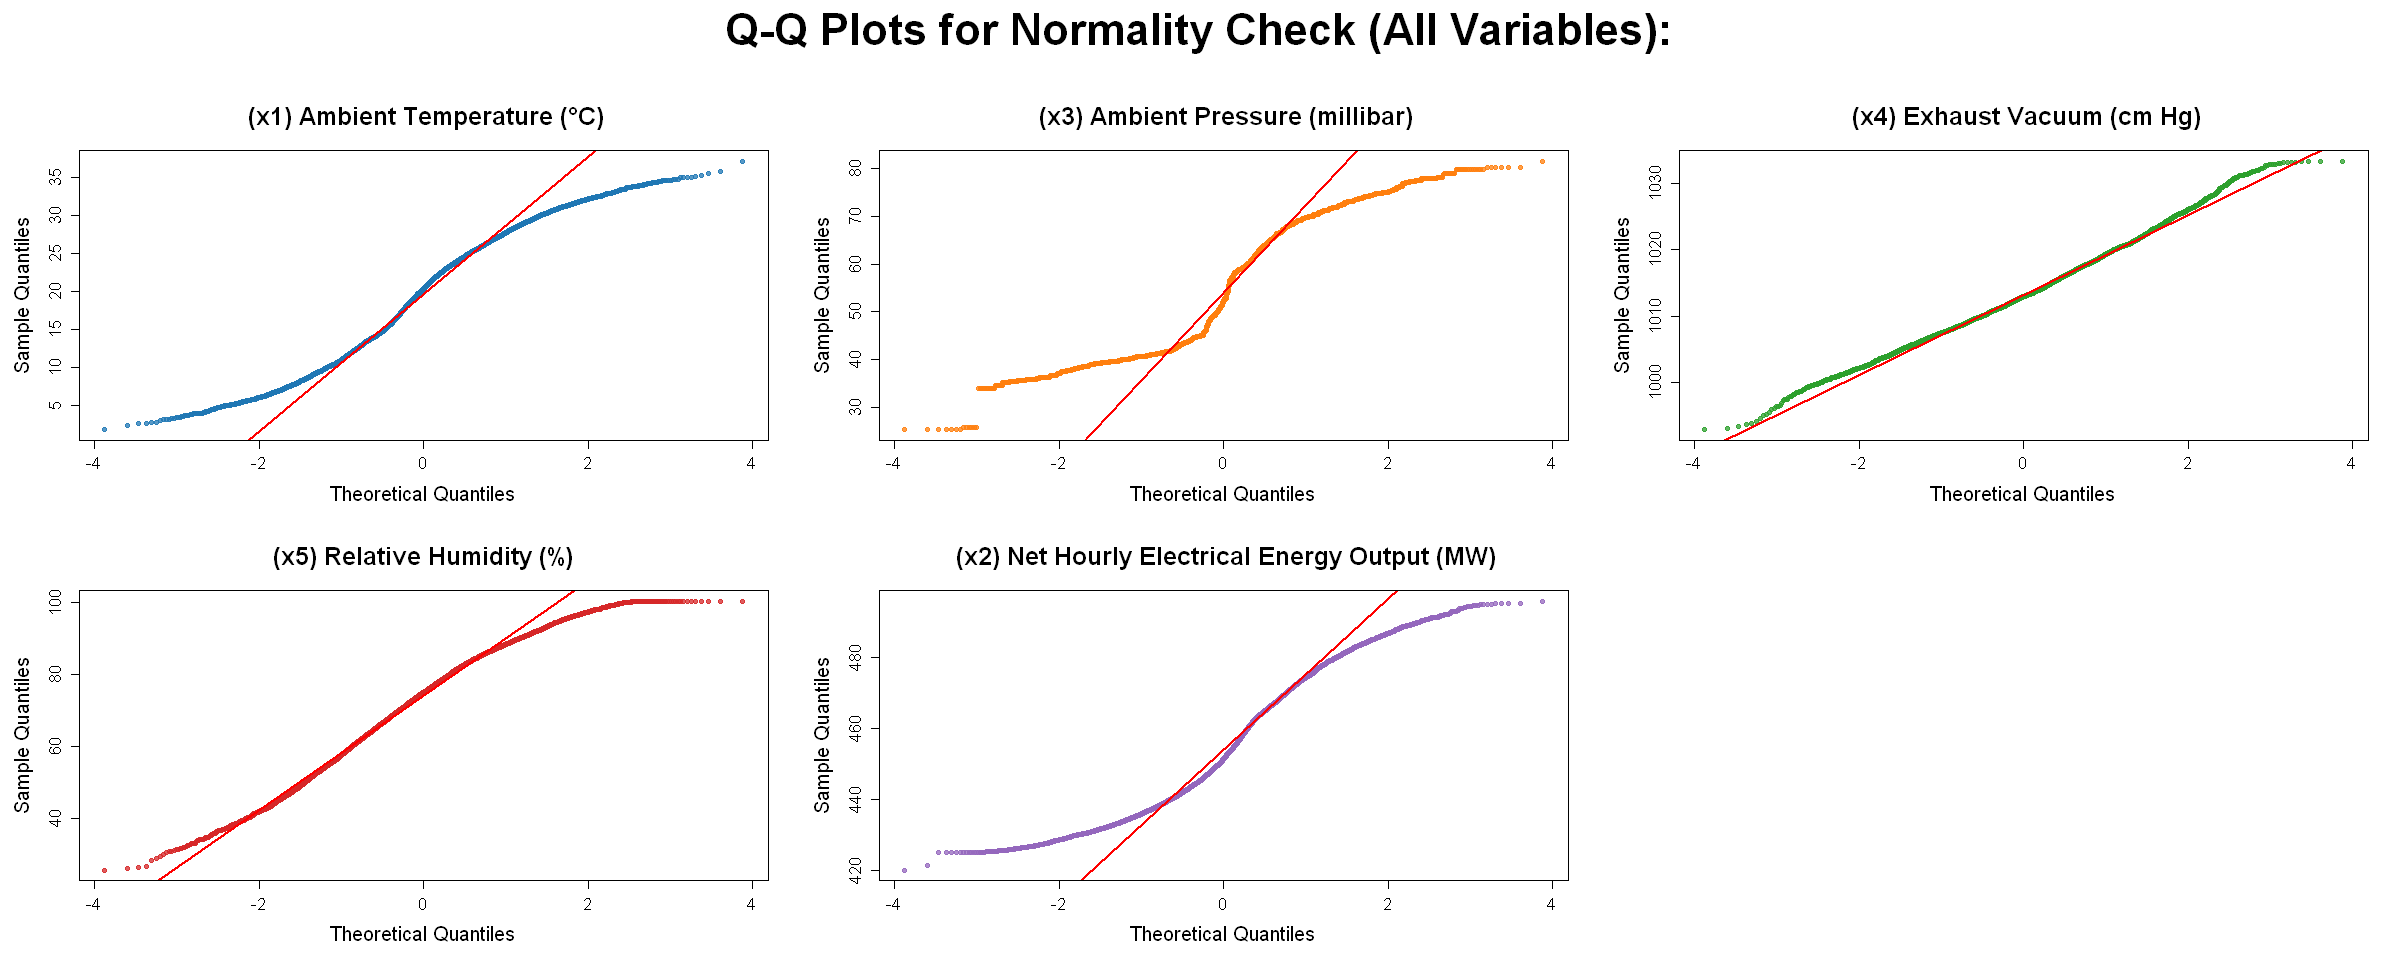

In [26]:
# # Create Q-Q plots for all variables to check their normality:

# Suppress warnings temporarily
options(warn = -1)

# Define variables, labels, and colors
variables <- c('x1', 'x3', 'x4', 'x5', 'x2')
labels <- c(
  ' (x1) Ambient Temperature (°C)', 
  ' (x3) Ambient Pressure (millibar)', 
  ' (x4) Exhaust Vacuum (cm Hg)', 
  '(x5) Relative Humidity (%)', 
  ' (x2) Net Hourly Electrical Energy Output (MW)'
)
colors <- c('#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd')

# Set plot layout: 2 rows and 3 columns
layout(matrix(1:6, nrow = 2, byrow = TRUE))

# Global plot parameters
par(
  mar = c(5, 5, 4.5, 2),  # Margins: bottom, left, top, right
  oma = c(0, 0, 5, 0),    # Outer margin for title
  bg = "white",
  col.axis = "black",
  col.lab = "black",
  col.main = "black",
  cex.axis = 1.3,         # Axis tick label size
  cex.lab = 1.5,          # Axis label size
  cex.main = 1.9          # Title size
)

# Generate Q-Q plots for each variable
for (i in seq_along(variables)) {
  var <- variables[i]
  label <- labels[i]
  color <- colors[i]
  
  # Create Q-Q plot
  qqnorm(data[[var]],
         main = label,
         col = adjustcolor(color, alpha.f = 0.75),
         pch = 19,          # Point character
         cex = 0.9)        # Point size
  
  # Add Q-Q line
  qqline(data[[var]], col = "red", lwd = 2)  # Q-Q line in red
  box(col = "black")                          # Box outline
}

# Placeholder for unused plot area
plot.new()

# Add a central title for all plots
mtext("Q-Q Plots for Normality Check (All Variables):", outer = TRUE, line = 2, cex = 2.2, font = 2)

# Reset graphical parameters to defaults
par(mfrow = c(1, 1), mar = c(5, 4, 4, 2) + 0.1)

# Restore warnings
options(warn = 0)

#### **Task 1.4: Outliers Detecting:**

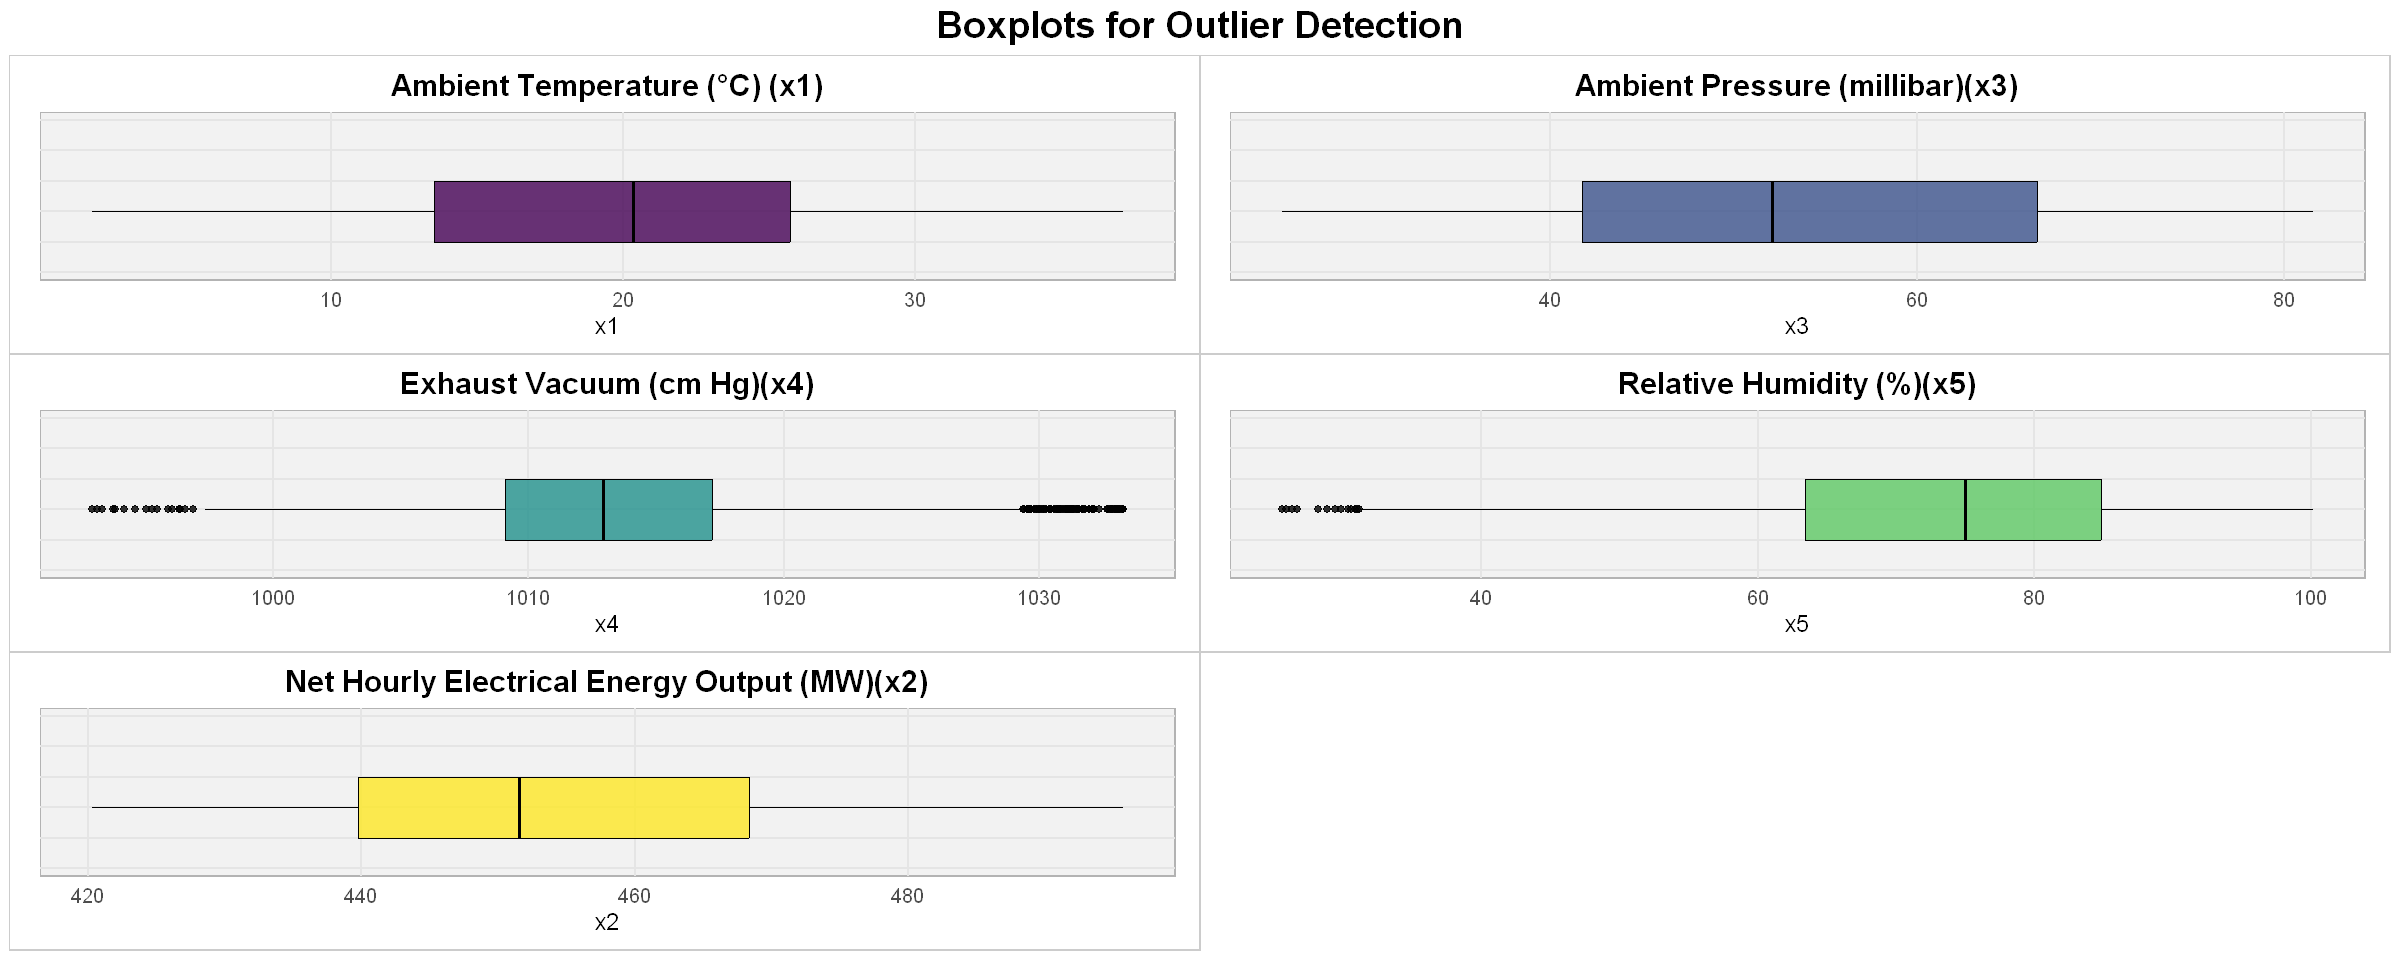

In [27]:
# Create box plots for all variables: 

# Custom theme specific to this plot: 
boxplot_theme <- function() {
  theme_minimal(base_size = 14) +
    theme(
      panel.grid.major = element_line(color = "grey90"),
      panel.grid.minor = element_blank(),
      plot.title = element_text(size = 18, hjust = 0.5, face = "bold"),
      axis.title = element_text(size = 14),
      axis.text = element_text(size = 12),
      plot.background = element_rect(fill = "white", color = "grey80"),
      panel.background = element_rect(fill = "grey95", color = "grey70"),
      panel.spacing = unit(1.5, "lines"),  # Adjusted spacing between rows
      plot.margin = margin(10, 15, 10, 15)
    )
}

# Function to detect outliers using the IQR method
detect_outliers_iqr <- function(data, column, k = 1.5) {
  q1 <- quantile(data[[column]], 0.25, na.rm = TRUE)
  q3 <- quantile(data[[column]], 0.75, na.rm = TRUE)
  iqr <- q3 - q1
  lower_bound <- q1 - k * iqr
  upper_bound <- q3 + k * iqr
  outliers <- data[data[[column]] < lower_bound | data[[column]] > upper_bound, ]
  return(list(outliers = outliers, lower_bound = lower_bound, upper_bound = upper_bound))
}

# Prepare variables and labels
all_vars <- c('x1', 'x3', 'x4', 'x5', 'x2')
all_labels <- c('Ambient Temperature (°C) (x1)', 'Ambient Pressure (millibar)(x3)', 'Exhaust Vacuum (cm Hg)(x4)', 
                'Relative Humidity (%)(x5)', 'Net Hourly Electrical Energy Output (MW)(x2)')
all_colors <- viridis::viridis(5, option = "D")

# Create and store individual plots
plot_list <- lapply(seq_along(all_vars), function(i) {
  var <- all_vars[i]
  label <- all_labels[i]
  color <- all_colors[i]
  
  # Detect outliers
  outlier_result <- detect_outliers_iqr(data, var)
  
  # Create horizontal boxplots: 
  p <- ggplot(data, aes(x = !!sym(var), y = 1)) +
    geom_boxplot(fill = color, color = "black", alpha = 0.8, 
                  width = 0.2,  # Adjusted width for better visibility
                  outlier.size = 2) +
    labs(title = label) +
    boxplot_theme() +
    theme(axis.text.y = element_blank(),
          axis.title.y = element_blank(),
          axis.ticks.y = element_blank()) +
    scale_y_continuous(limits = c(0.8, 1.3))  # Adjusted limits for better spacing
  return(p)
})

# Arrange plots in 2 columns with separation
final_plot <- wrap_plots(plot_list, ncol = 2) + 
  plot_annotation(
    title = "Boxplots for Outlier Detection",
    theme = theme(plot.title = element_text(size = 22, face = "bold", hjust = 0.5))
  )

# Display the plot
final_plot

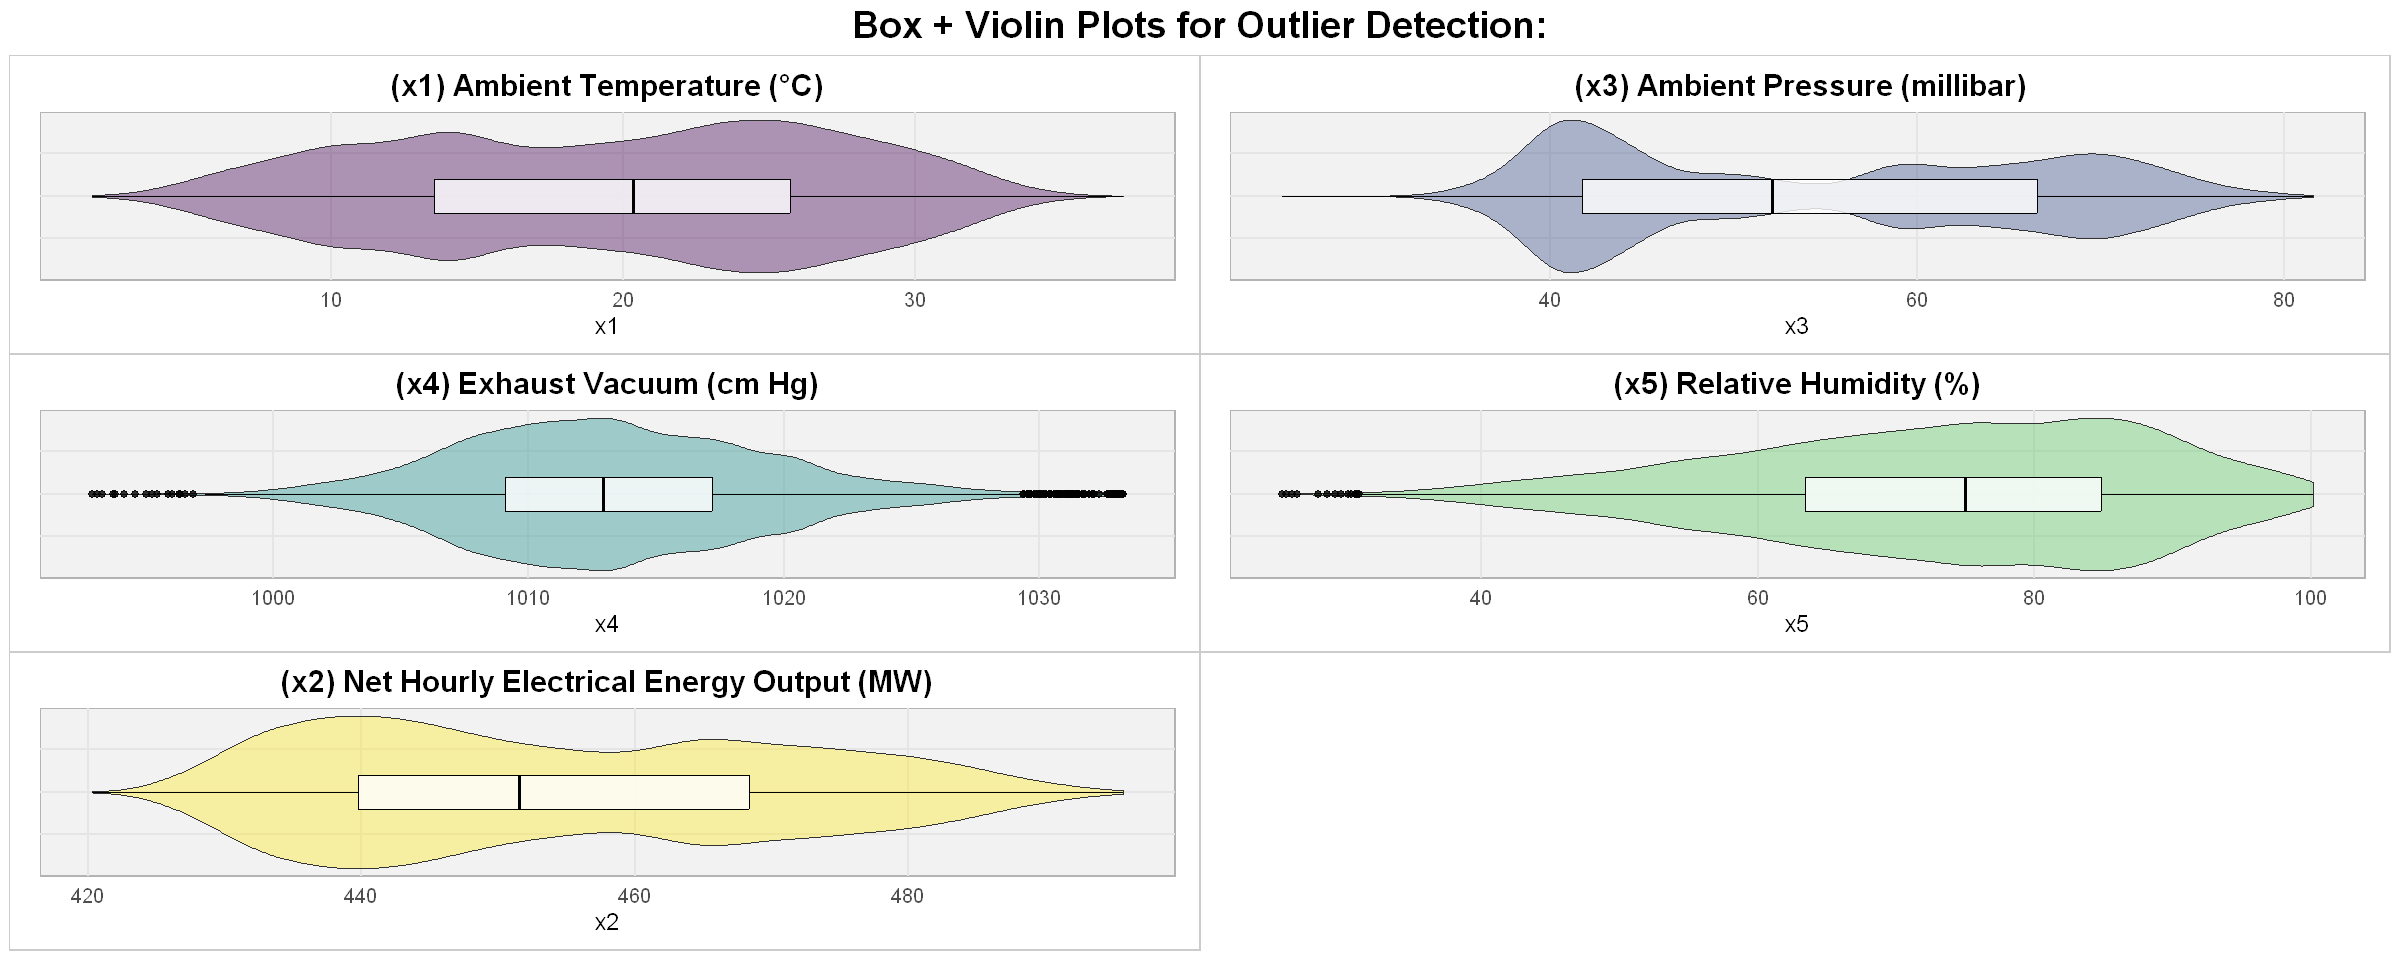

In [28]:
# Box plots with violin plots for all variables (dependent variable + independent variables):  

# Custom theme for the plots
boxplot_theme <- function() {
  theme_minimal(base_size = 14) +
    theme(
      panel.grid.major = element_line(color = "grey90"),
      panel.grid.minor = element_blank(),
      plot.title = element_text(size = 18, hjust = 0.5, face = "bold"),
      axis.title = element_text(size = 14),
      axis.text = element_text(size = 12),
      plot.background = element_rect(fill = "white", color = "grey80"),
      panel.background = element_rect(fill = "grey95", color = "grey70"),
      panel.spacing = unit(1.5, "lines"),  # Adjust the spacing between plots
      plot.margin = margin(10, 15, 10, 15)
    )
}

# Function to detect outliers using the IQR method
detect_outliers_iqr <- function(data, column, k = 1.5) {
  q1 <- quantile(data[[column]], 0.25, na.rm = TRUE)
  q3 <- quantile(data[[column]], 0.75, na.rm = TRUE)
  iqr <- q3 - q1
  lower_bound <- q1 - k * iqr
  upper_bound <- q3 + k * iqr
  outliers <- data[data[[column]] < lower_bound | data[[column]] > upper_bound, ]
  return(list(outliers = outliers, lower_bound = lower_bound, upper_bound = upper_bound))
}

# Prepare variables and labels
all_vars <- c('x1', 'x3', 'x4', 'x5', 'x2')
all_labels <- c('(x1) Ambient Temperature (°C)', ' (x3) Ambient Pressure (millibar)', '(x4) Exhaust Vacuum (cm Hg)', 
                '(x5) Relative Humidity (%)', '(x2) Net Hourly Electrical Energy Output (MW)')
all_colors <- viridis::viridis(5, option = "D")

# Create and store individual plots
plot_list <- lapply(seq_along(all_vars), function(i) {
  var <- all_vars[i]
  label <- all_labels[i]
  color <- all_colors[i]

  # Detect outliers for the current variable
  outlier_result <- detect_outliers_iqr(data, var)

  # Create combined boxplot and violin plot
  p <- ggplot(data, aes(x = !!sym(var), y = 1)) +
    geom_violin(aes(y = 1), fill = color, alpha = 0.4) +  # Adds violin plot
    geom_boxplot(aes(y = 1), color = "black", alpha = 0.8, 
                  width = 0.2, outlier.size = 2) +  # Adds boxplot
    labs(title = label) +
    boxplot_theme() +
    theme(axis.text.y = element_blank(),
          axis.title.y = element_blank(),
          axis.ticks.y = element_blank())

  return(p)
})

# Arrange plots in 2 columns with separation
final_plot <- wrap_plots(plot_list, ncol = 2) + 
  plot_annotation(
    title = "Box + Violin Plots for Outlier Detection:",
    theme = theme(plot.title = element_text(size = 22, face = "bold", hjust = 0.5))
  )

# Display the plot
final_plot

In [29]:
# Create a dictionary of outliers for all variables
outliers_dict <- list()

# Detect and store outliers for each variable
for (var in all_vars) {
  # Get outliers using the IQR method
  outlier_result <- detect_outliers_iqr(data, var)
  
  # Store the outliers in the dictionary
  outliers_dict[[var]] <- outlier_result$outliers
}

# Print outliers for each variable
cat("Summary of Outliers by Variable:\n")
cat(strrep("-", 50), "\n")

# Loop through each variable to report on outliers
for (var in all_vars) {
  outliers <- outliers_dict[[var]]
  
  cat(sprintf("\nOutliers in %s:\n", var))
  cat(sprintf("Number of outliers: %d (%.2f%% of data)\n", nrow(outliers), (nrow(outliers) / nrow(data)) * 100))
  
  if (nrow(outliers) > 0) {
    cat("\nSample of outliers (first 10 if available):\n")
    print(head(outliers[, c(var, "time")], 10))
    
    # Calculate statistics for outliers vs non-outliers
    non_outliers <- data[!rownames(data) %in% rownames(outliers), ]
    
    cat(sprintf("\nOutlier statistics for %s:\n", var))
    cat(sprintf("Outlier range: %.2f to %.2f\n", min(outliers[[var]], na.rm = TRUE), max(outliers[[var]], na.rm = TRUE)))
    cat(sprintf("Non-outlier range: %.2f to %.2f\n", min(non_outliers[[var]], na.rm = TRUE), max(non_outliers[[var]], na.rm = TRUE)))
    cat(sprintf("Dataset mean: %.2f, Outlier mean: %.2f\n", mean(data[[var]], na.rm = TRUE), mean(outliers[[var]], na.rm = TRUE)))
    cat(sprintf("Dataset std: %.2f, Outlier std: %.2f\n", sd(data[[var]], na.rm = TRUE), sd(outliers[[var]], na.rm = TRUE)))
  }
  
  cat(strrep("-", 50), "\n")
}

# Create a data frame with all outliers combined
all_outliers <- bind_rows(outliers_dict)

# Get unique outliers (rows that are outliers in at least one variable)
unique_outliers <- distinct(all_outliers)

cat(sprintf("\nTotal unique outlier rows: %d (%.2f%% of data)\n", nrow(unique_outliers), (nrow(unique_outliers) / nrow(data)) * 100))

# Save outliers to a CSV file for further analysis if needed
write.csv(unique_outliers, 'outliers.csv', row.names = FALSE)

Summary of Outliers by Variable:
-------------------------------------------------- 

Outliers in x1:
Number of outliers: 0 (0.00% of data)
-------------------------------------------------- 

Outliers in x3:
Number of outliers: 0 (0.00% of data)
-------------------------------------------------- 

Outliers in x4:
Number of outliers: 91 (0.96% of data)

Sample of outliers (first 10 if available):
# A tibble: 10 × 2
      x4  time
   <dbl> <int>
 1  994.    31
 2 1030.   354
 3 1033.   414
 4 1031.   522
 5  996.  1016
 6  995.  1118
 7 1033.  1237
 8 1029.  1368
 9 1032.  1540
10 1032.  1565

Outlier statistics for x4:
Outlier range: 992.89 to 1033.30
Non-outlier range: 992.89 to 1033.30
Dataset mean: 1013.24, Outlier mean: 1024.88
Dataset std: 5.94, Outlier std: 13.95
-------------------------------------------------- 

Outliers in x5:
Number of outliers: 13 (0.14% of data)

Sample of outliers (first 10 if available):
# A tibble: 10 × 2
      x5  time
   <dbl> <int>
 1  25.6  1836
 2 

Now, so, I have successfully  filtered out the outliers from the dataset and saved them in a separate csv file.

In [30]:
# Import outliers from outliers.csv:
outliers <- read.csv('outliers.csv')

# Display the first few rows of the outliers dataset
head(outliers)

,time,x1,x3,x4,x5,x2,segment
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,31,13.42,41.23,994.17,95.79,468.82,1
2,354,9.42,41.40,1029.60,87.43,478.12,2
3,414,9.80,41.82,1032.98,67.55,473.72,3
4,522,9.24,41.40,1030.72,87.36,476.90,3
5,1016,16.21,41.23,995.88,80.00,463.09,6
6,1118,14.13,41.23,994.60,93.02,467.84,6


In [31]:
# Check the dimensions of the outliers dataset
dim(outliers)

[1] 104   7

So, dataset contains 104 outlier data samples out of 9568 rows.

#### **Task 1. 5: Scatter Plots and Scatter Plot Matrix:**

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


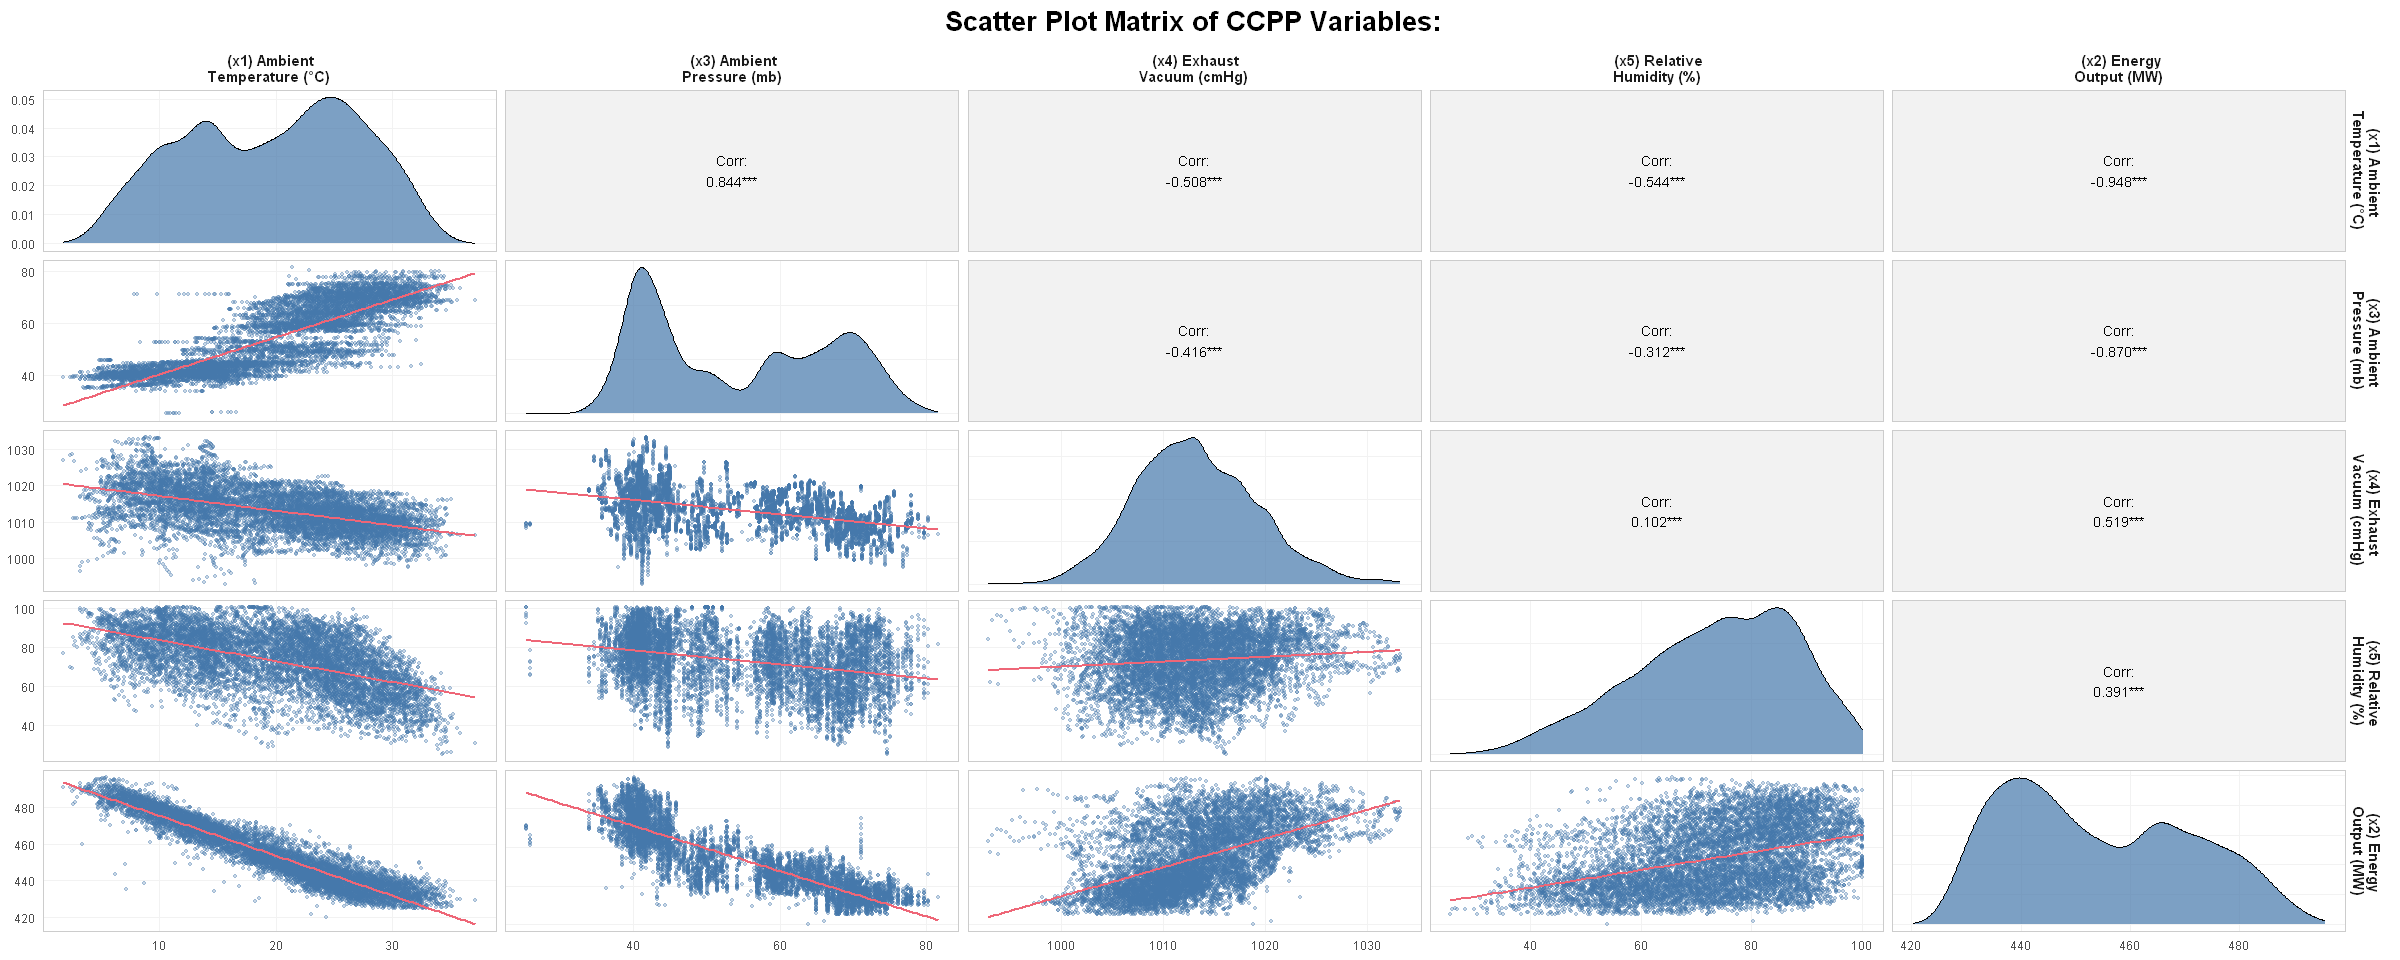

In [32]:
# Create a Scatter Plot Matrix (SPLOM) for all variables
# Suppress warnings
options(warn = -1)

# Create a custom theme for the scatter plot matrix
custom_theme <- theme_minimal() +
  theme(
    axis.text = element_text(size = 8),
    axis.title = element_text(size = 10, face = "bold"),
    strip.text = element_text(size = 10, face = "bold"),
    panel.grid.minor = element_blank(),
    panel.grid.major = element_line(color = "gray95"),
    panel.border = element_rect(fill = NA, color = "gray80")
  )

# Set theme
theme_set(custom_theme)

# Select variables for the scatter plot matrix
plot_vars <- c("x1", "x3", "x4", "x5", "x2")
plot_data <- data[, plot_vars]

# Create nicer variable labels
var_labels <- c(" (x1) Ambient\nTemperature (°C)", 
                " (x3) Ambient\nPressure (mb)",
                " (x4) Exhaust\nVacuum (cmHg)",
                " (x5) Relative\nHumidity (%)", 
                " (x2) Energy\nOutput (MW)")

names(plot_data) <- var_labels

# Create the scatter plot matrix with ggpairs
splom <- ggpairs(
  plot_data,
  upper = list(
    continuous = wrap("cor", size = 3, color = "black")
  ),
  lower = list(
    continuous = function(data, mapping, ...) {
      ggplot(data, mapping) +
        geom_point(alpha = 0.3, size = 0.8, color = "#4477AA") +
        geom_smooth(method = "lm", color = "#EE6677", se = FALSE, linewidth = 0.8, message= FALSE, ...)
    }
  ),
  diag = list(
    continuous = function(data, mapping, ...) {
      ggplot(data, mapping) +
        geom_density(fill = "#4477AA", alpha = 0.7, ...)
    }
  )
) +
  ggtitle("Scatter Plot Matrix of CCPP Variables:") +
  theme(
    plot.title = element_text(size = 16, face = "bold", hjust = 0.5),
    axis.text = element_text(size = 7),
    strip.text = element_text(size = 9)
  )

# Print the scatter plot matrix
print(splom)

# Reset warnings
options(warn = 0)

### **Task 1.6: Correlation Analysis:**

In [33]:
# Pearson Correlation coefficient: 

# Select only the numeric variables (excluding time) and any other columns:
numeric_vars <- c("x1", "x3", "x4", "x5", "x2")
numeric_data <- data[, numeric_vars]

# Calculate Pearson correlation matrix
pearson_corr <- cor(numeric_data, method = "pearson")

# Round to 3 decimal places for better readability
pearson_corr_rounded <- round(pearson_corr, 3)

# Print the correlation matrix
cat("Pearson Correlation Matrix:\n")
print(pearson_corr_rounded)

Pearson Correlation Matrix:
       x1     x3     x4     x5     x2
x1  1.000  0.844 -0.508 -0.544 -0.948
x3  0.844  1.000 -0.416 -0.312 -0.870
x4 -0.508 -0.416  1.000  0.102  0.519
x5 -0.544 -0.312  0.102  1.000  0.391
x2 -0.948 -0.870  0.519  0.391  1.000


In [34]:
# Create a data frame with variable pairs and their correlation values
# This makes it easier to sort and find the strongest correlations
corr_df <- data.frame(
  var1 = character(),
  var2 = character(),
  correlation = numeric(),
  stringsAsFactors = FALSE
)

# Fill the data frame with all variable pairs and their correlations
for (i in 1:(length(numeric_vars) - 1)) {
  for (j in (i + 1):length(numeric_vars)) {
    corr_df <- rbind(corr_df, data.frame(
      var1 = numeric_vars[i],
      var2 = numeric_vars[j],
      correlation = pearson_corr[i, j],
      stringsAsFactors = FALSE
    ))
  }
}

# Sort by absolute correlation value (descending)
corr_df <- corr_df %>%
  mutate(abs_corr = abs(correlation)) %>%
  arrange(desc(abs_corr))

# Print the sorted correlations
cat("\nSorted Correlations (by absolute value):\n")
print(corr_df[, c("var1", "var2", "correlation")], row.names = FALSE)


Sorted Correlations (by absolute value):
 var1 var2 correlation
   x1   x2  -0.9479079
   x3   x2  -0.8699002
   x1   x3   0.8436886
   x1   x5  -0.5439469
   x4   x2   0.5186868
   x1   x4  -0.5082216
   x3   x4  -0.4157184
   x5   x2   0.3911750
   x3   x5  -0.3122140
   x4   x5   0.1016310


In [35]:
# Find the strongest correlation with the output variable (x2)
x2_correlations <- data.frame(
  variable = numeric_vars[numeric_vars != "x2"],
  correlation_with_x2 = pearson_corr["x2", numeric_vars[numeric_vars != "x2"]],
  stringsAsFactors = FALSE
) %>%
  mutate(abs_corr = abs(correlation_with_x2)) %>%
  arrange(desc(abs_corr))

# Print correlations with the output variable
cat("\nCorrelations with Output Variable (x2):\n")
print(x2_correlations[, c("variable", "correlation_with_x2")], row.names = FALSE)


Correlations with Output Variable (x2):
 variable correlation_with_x2
       x1          -0.9479079
       x3          -0.8699002
       x4           0.5186868
       x5           0.3911750


Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead."


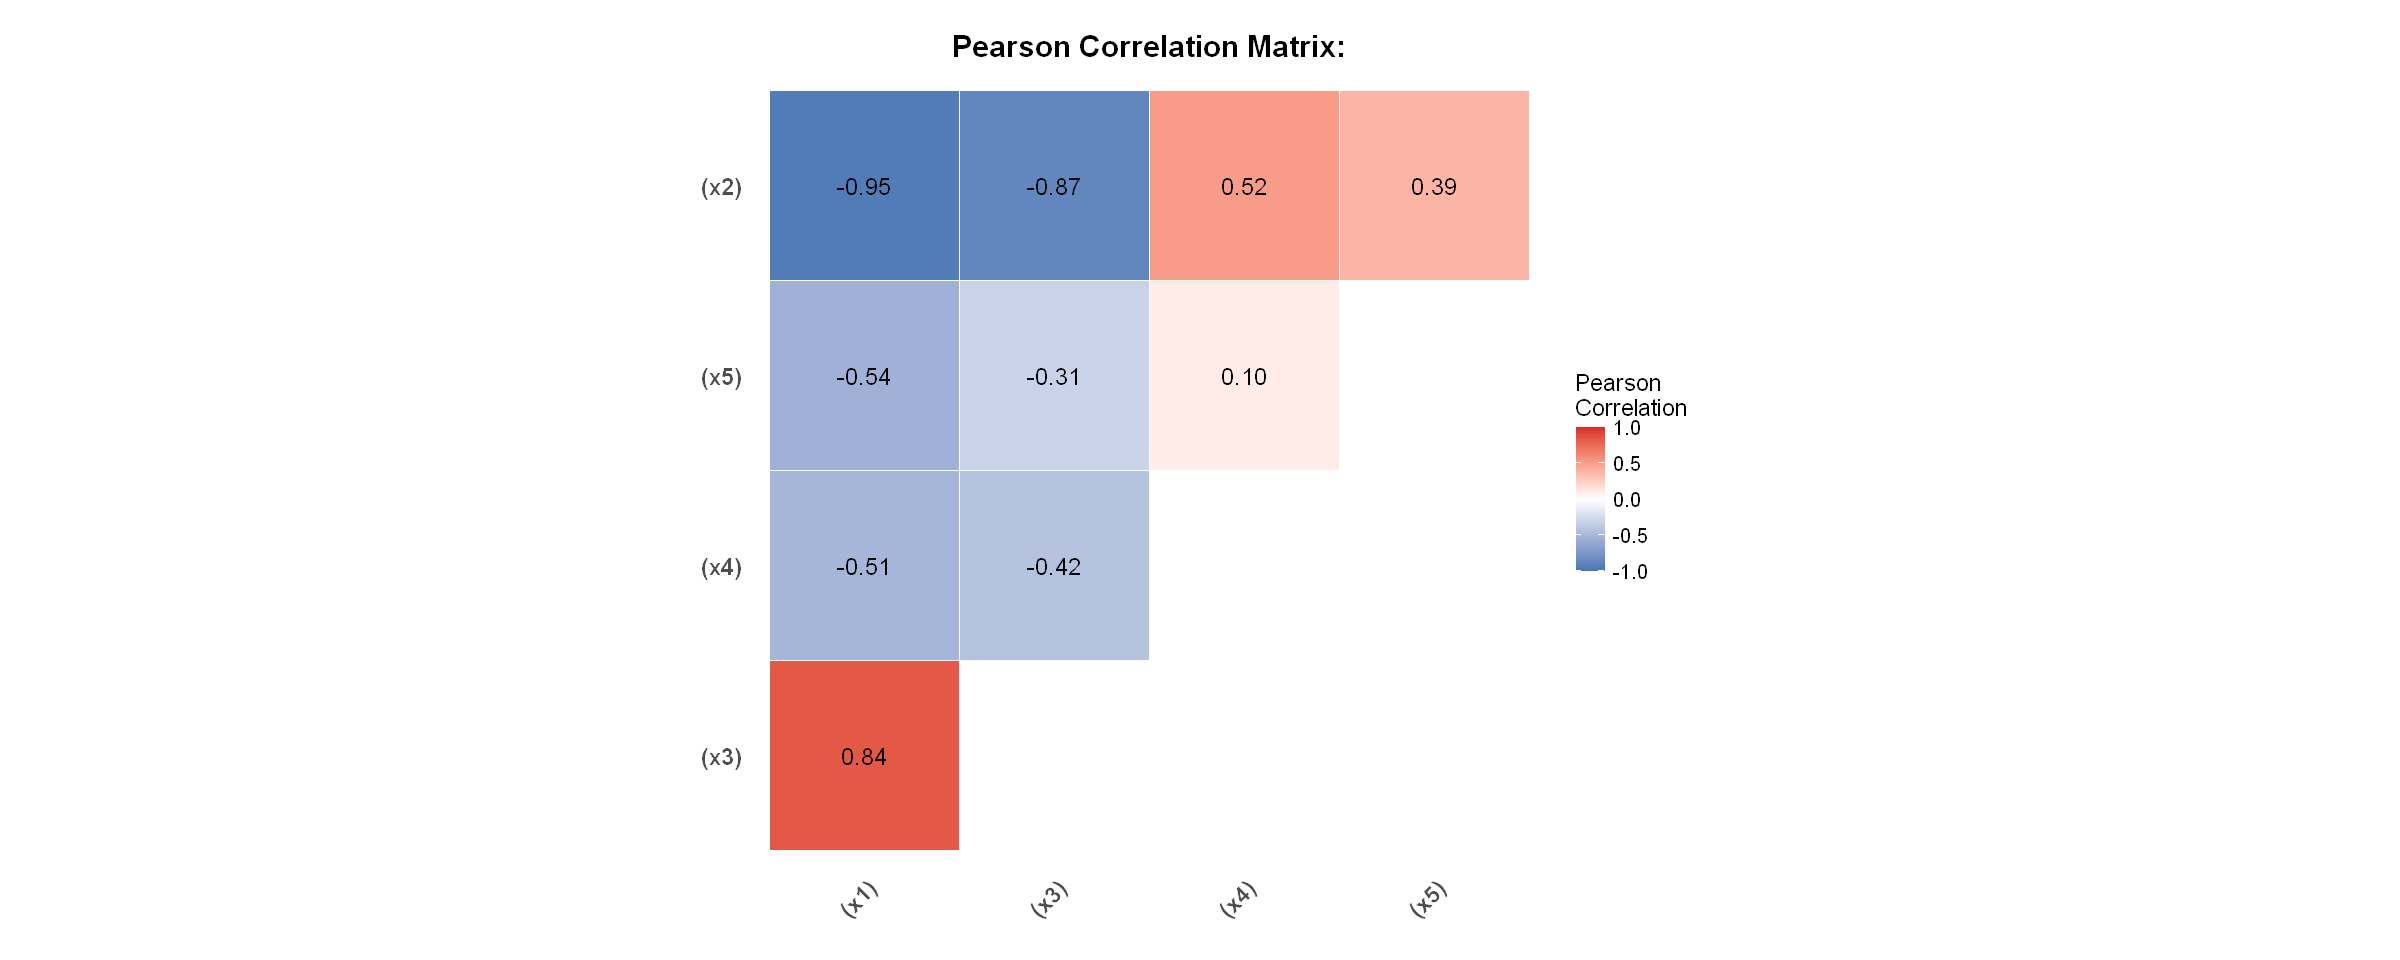

In [36]:
# Create a correlation heatmap showing only the lower triangle
# Load required libraries
library(ggplot2)
library(reshape2)
library(viridis)

# Create a mask for the upper triangle
mask <- upper.tri(pearson_corr_rounded, diag = TRUE)  # Include diagonal in mask

# Melt the correlation matrix for ggplot: 
melted_corr <- melt(pearson_corr_rounded)
names(melted_corr) <- c("Var1", "Var2", "Correlation")

# Apply the mask to keep only lower triangle
melted_corr <- melted_corr[!mask[cbind(match(melted_corr$Var1, numeric_vars), 
                                      match(melted_corr$Var2, numeric_vars))], ]

# Create nicer variable labels
var_labels <- c(" (x1)", 
                "(x3)", 
                "(x4)", 
                "(x5)",
                "(x2)")

# Replace variable names with nicer labels
melted_corr$Var1 <- factor(melted_corr$Var1, 
                          levels = numeric_vars,
                          labels = var_labels)
melted_corr$Var2 <- factor(melted_corr$Var2, 
                          levels = numeric_vars,
                          labels = var_labels)

# Create the heatmap: 
gg_heatmap <- ggplot(melted_corr, aes(x = Var2, y = Var1, fill = Correlation)) +
  geom_tile(color = "white", size = 0.5) +
  # Add correlation values: 
  geom_text(aes(label = sprintf("%.2f", Correlation)), 
            color = "black", size = 5) +  # Increased text size
  # Use a diverging color palette centered at 0
  scale_fill_gradient2(low = "#4575b4", mid = "white", high = "#d73027",
                      midpoint = 0, limit = c(-1, 1), name = "Pearson\nCorrelation") +
  # Add labels and title
  labs(title = "Pearson Correlation Matrix:",
    ) +
  # Adjust theme for better plot views: 
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1, size = 14, face = "bold"),  # Larger font
    axis.text.y = element_text(size = 14, face = "bold"),  # Larger font
    axis.title.x = element_blank(),
    axis.title.y = element_blank(),
    panel.grid = element_blank(),
    legend.position = "right",
    legend.text = element_text(size = 12),  # Larger legend text
    legend.title = element_text(size = 14),  # Larger legend title
    plot.title = element_text(size = 18, face = "bold", hjust = 0.5),  # Larger title
    plot.subtitle = element_text(size = 14, hjust = 0.5),  # Larger subtitle
    plot.margin = margin(20, 20, 20, 20)
  ) +
  # Turn off the grid
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  # Ensure the plot is square
  coord_fixed()
# Display the heatmap
print(gg_heatmap)

In [37]:
# Calculate Spearman Rank Correlation Matrix
# Load required libraries
library(dplyr)

# Select only the numeric variables (excluding time)
numeric_vars <- c("x1", "x3", "x4", "x5", "x2")
numeric_data <- data[, numeric_vars]

# Calculate Spearman correlation matrix
spearman_corr <- cor(numeric_data, method = "spearman")

# Round to 3 decimal places for better readability
spearman_corr_rounded <- round(spearman_corr, 3)

# Print the correlation matrix
cat("Spearman Rank Correlation Matrix:\n")
print(spearman_corr_rounded)

Spearman Rank Correlation Matrix:
       x1     x3     x4     x5     x2
x1  1.000  0.850 -0.520 -0.544 -0.944
x3  0.850  1.000 -0.429 -0.305 -0.884
x4 -0.520 -0.429  1.000  0.089  0.543
x5 -0.544 -0.305  0.089  1.000  0.391
x2 -0.944 -0.884  0.543  0.391  1.000


In [38]:
# Create a data frame with variable pairs and their correlation values
# This makes it easier to sort and find the strongest correlations
corr_df <- data.frame(
  var1 = character(),
  var2 = character(),
  correlation = numeric(),
  stringsAsFactors = FALSE
)

# Fill the data frame with all variable pairs and their correlations
for (i in 1:(length(numeric_vars) - 1)) {
  for (j in (i + 1):length(numeric_vars)) {
    corr_df <- rbind(corr_df, data.frame(
      var1 = numeric_vars[i],
      var2 = numeric_vars[j],
      correlation = spearman_corr[i, j],
      stringsAsFactors = FALSE
    ))
  }
}

# Sort by absolute correlation value (descending)
corr_df <- corr_df %>%
  mutate(abs_corr = abs(correlation)) %>%
  arrange(desc(abs_corr))

# Print the sorted correlations
cat("\nSorted Spearman Correlations (by absolute value):\n")
print(corr_df[, c("var1", "var2", "correlation")], row.names = FALSE)


Sorted Spearman Correlations (by absolute value):
 var1 var2 correlation
   x1   x2 -0.94434106
   x3   x2 -0.88400441
   x1   x3  0.85035481
   x1   x5 -0.54405910
   x4   x2  0.54301563
   x1   x4 -0.51971579
   x3   x4 -0.42888300
   x5   x2  0.39109517
   x3   x5 -0.30485345
   x4   x5  0.08911092


In [39]:
# Find the strongest correlation with the output variable (x2)
x2_correlations <- data.frame(
  variable = numeric_vars[numeric_vars != "x2"],
  correlation_with_x2 = spearman_corr["x2", numeric_vars[numeric_vars != "x2"]],
  stringsAsFactors = FALSE
) %>%
  mutate(abs_corr = abs(correlation_with_x2)) %>%
  arrange(desc(abs_corr))

# Print correlations with the output variable
cat("\nSpearman Correlations with Output Variable (x2):\n")
print(x2_correlations[, c("variable", "correlation_with_x2")], row.names = FALSE)


Spearman Correlations with Output Variable (x2):
 variable correlation_with_x2
       x1          -0.9443411
       x3          -0.8840044
       x4           0.5430156
       x5           0.3910952


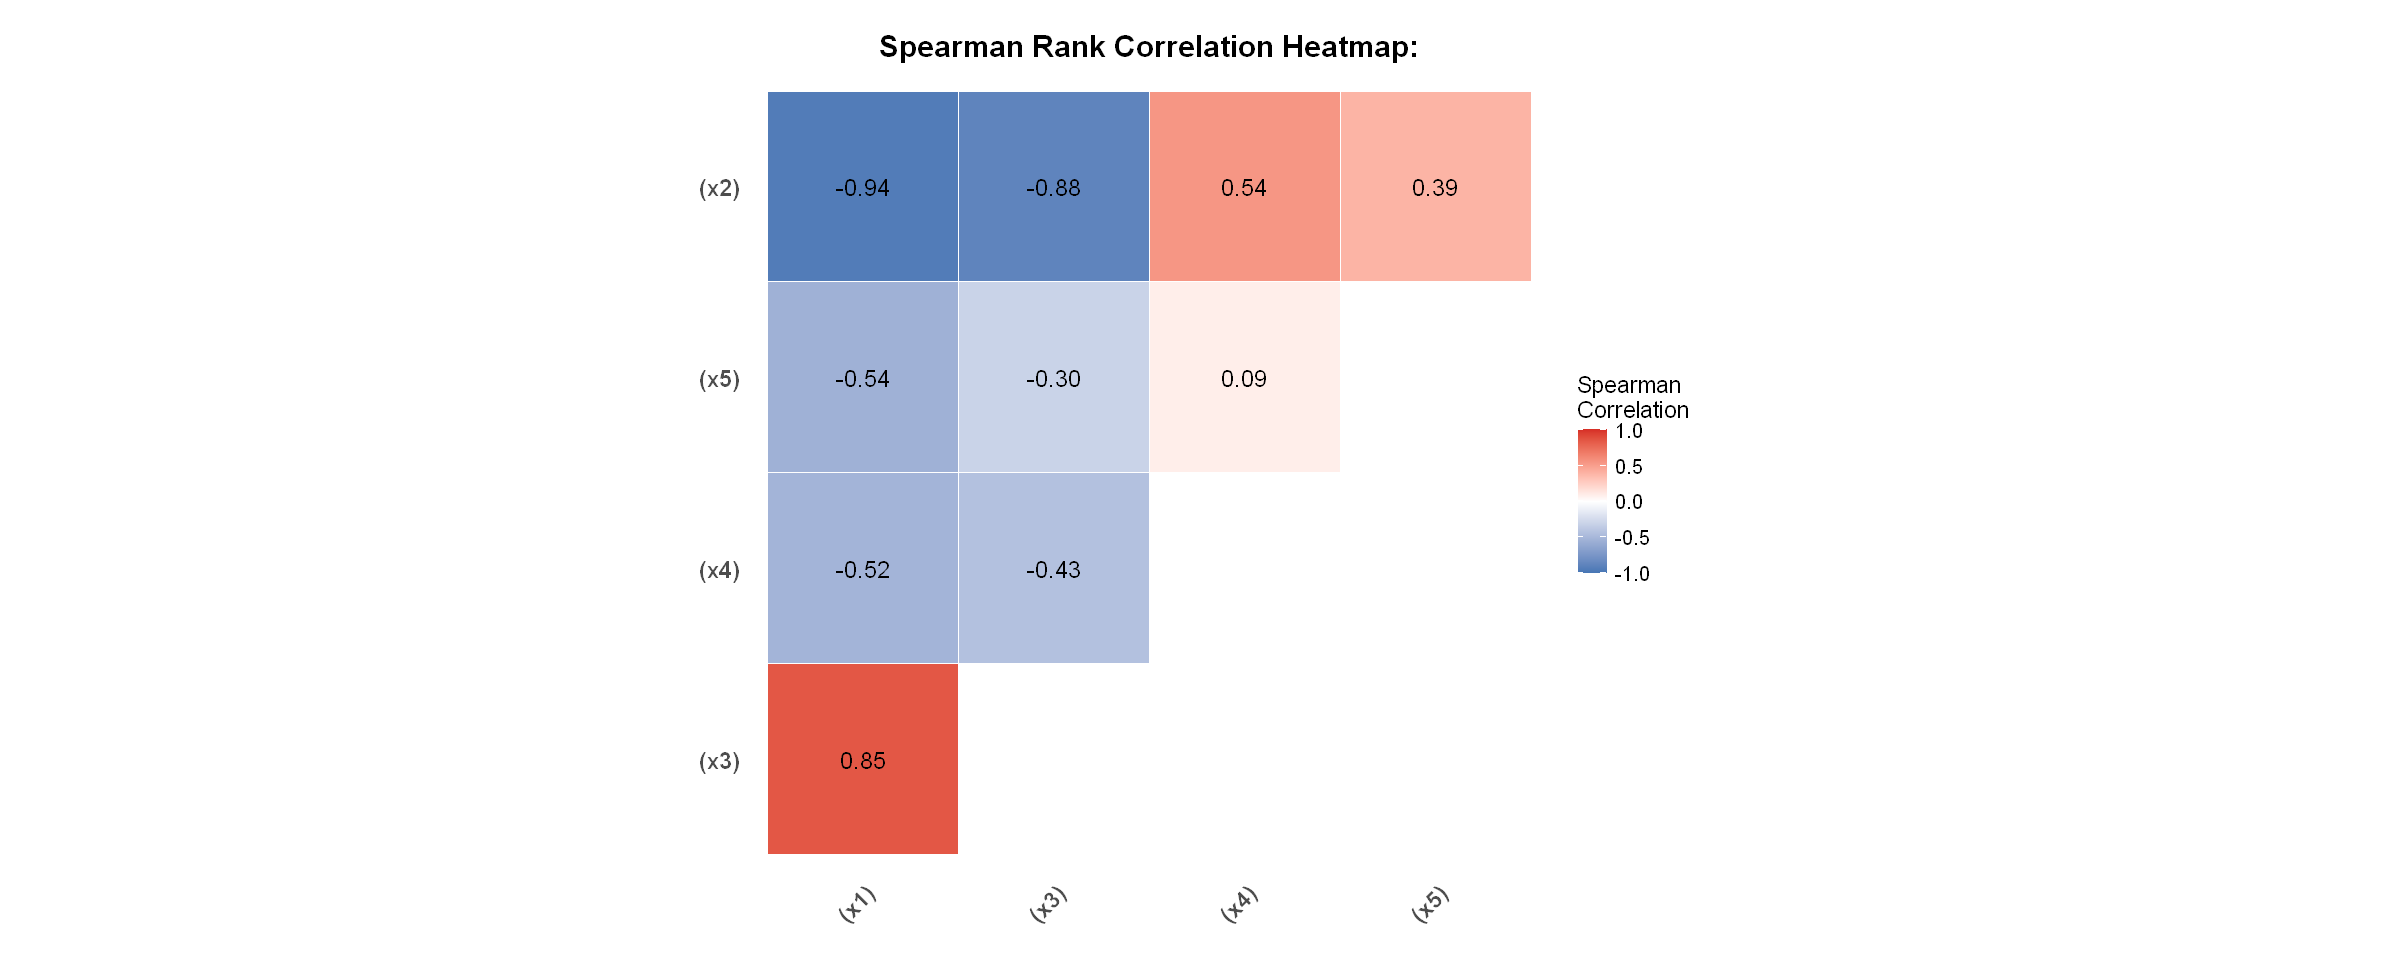

In [40]:
# Create a Spearman correlation heatmap:

# Create a mask for the upper triangle
mask <- upper.tri(spearman_corr_rounded, diag = TRUE)  # Include diagonal in mask

# Melt the correlation matrix for ggplot, applying the mask
melted_corr <- melt(spearman_corr_rounded)
names(melted_corr) <- c("Var1", "Var2", "Correlation")

# Apply the mask to keep only lower triangle
melted_corr <- melted_corr[!mask[cbind(match(melted_corr$Var1, numeric_vars), 
                                      match(melted_corr$Var2, numeric_vars))], ]

# Create nicer variable labels
var_labels <- c("(x1)", 
                "(x3)",
                "(x4)", 
                "(x5)", 
                 "(x2)")

# Replace variable names with nicer labels
melted_corr$Var1 <- factor(melted_corr$Var1, 
                          levels = numeric_vars,
                          labels = var_labels)
melted_corr$Var2 <- factor(melted_corr$Var2, 
                          levels = numeric_vars,
                          labels = var_labels)

# Create the heatmap with larger font sizes
gg_heatmap <- ggplot(melted_corr, aes(x = Var2, y = Var1, fill = Correlation)) +
  geom_tile(color = "white", size = 0.5) +
  # Add correlation values as text with larger font
  geom_text(aes(label = sprintf("%.2f", Correlation)), 
            color = "black", size = 5) +  # Increased text size
  # Use a diverging color palette centered at 0
  scale_fill_gradient2(low = "#4575b4", mid = "white", high = "#d73027",
                      midpoint = 0, limit = c(-1, 1), name = "Spearman\nCorrelation") +
  # Add labels and title
  labs(title = "Spearman Rank Correlation Heatmap:",
    ) +
  # Adjust theme with larger fonts
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1, size = 14, face = "bold"),  # Larger font
    axis.text.y = element_text(size = 14, face = "bold"),  # Larger font
    axis.title.x = element_blank(),
    axis.title.y = element_blank(),
    panel.grid = element_blank(),
    legend.position = "right",
    legend.text = element_text(size = 12),  # Larger legend text
    legend.title = element_text(size = 14),  # Larger legend title
    plot.title = element_text(size = 18, face = "bold", hjust = 0.5),  # Larger title
    plot.subtitle = element_text(size = 14, hjust = 0.5),  # Larger subtitle
    plot.margin = margin(20, 20, 20, 20)
  ) +
  # Turn off the grid
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()) +
  # Ensure the plot is square
  coord_fixed()

# Display the heatmap
print(gg_heatmap)

#### **Task 1.7: Hypothesis Testing:**

##### **1.7.1: Hypothesis Testing for Relationship between `Temperature` (x1) and `Energy Output` (x2):**

- **Null Hypothesis** $H₀$: There is no significant relationship between temperature (x1) and energy output (x2).

- **Alternative Hypothesis** $H₁$: There is a significant relationship between temperature (x1) and energy output (x2).

In [41]:
# Hypothesis Testing using Kendall's Tau: 

# Define significance level
alpha <- 0.05

# Create a function to perform Kendall's Tau test and format results
perform_kendall_test <- function(x, y, var_x_name, var_y_name) {
  # Perform Kendall's Tau test
  test_result <- cor.test(x, y, method = "kendall", exact = FALSE)
  
  # Extract results
  tau <- test_result$estimate
  p_value <- test_result$p.value
  
  # Determine significance
  is_significant <- p_value < alpha
  decision <- ifelse(is_significant, "Reject H₀", "Fail to reject H₀")
  
  # Return formatted results
  return(list(
    var_x = var_x_name,
    var_y = var_y_name,
    tau = tau,
    p_value = p_value,
    is_significant = is_significant,
    decision = decision
  ))
}

# Test relationship between Temperature (x1) and Energy Output (x2)
cat("Hypothesis Test: Temperature and Energy Output Relationship\n")
cat("------------------------------------------------------------\n")
cat("H₀: There is no significant monotonic relationship between temperature (x1) and energy output (x2)\n")
cat("H₁: There is a significant monotonic relationship between temperature (x1) and energy output (x2)\n")
cat("\nResults:\n")

x1_x2_test <- perform_kendall_test(data$x1, data$x2, "Temperature (x1)", "Energy Output (x2)")

cat(sprintf("Kendall's Tau: %.4f\n", x1_x2_test$tau))
cat(sprintf("p-value: %.8f\n", x1_x2_test$p_value))
cat(sprintf("Decision: %s (α = %.2f)\n", x1_x2_test$decision, alpha))

if (x1_x2_test$is_significant) {
  cat("\nInterpretation: There is a statistically significant monotonic relationship between\n")
  cat("temperature and energy output. The negative tau value indicates that as temperature\n")
  cat("increases, energy output tends to decrease, and this relationship is not due to chance.\n")
} else {
  cat("\nInterpretation: There is insufficient evidence to conclude that a monotonic relationship\n")
  cat("exists between temperature and energy output.\n")
}

Hypothesis Test: Temperature and Energy Output Relationship
------------------------------------------------------------
H₀: There is no significant monotonic relationship between temperature (x1) and energy output (x2)
H₁: There is a significant monotonic relationship between temperature (x1) and energy output (x2)

Results:
Kendall's Tau: -0.7956
p-value: 0.00000000
Decision: Reject H₀ (α = 0.05)

Interpretation: There is a statistically significant monotonic relationship between
temperature and energy output. The negative tau value indicates that as temperature
increases, energy output tends to decrease, and this relationship is not due to chance.


##### **1.7.2: Hypothesis Testing for Multicollinearity between `Ambient Pressure` (x3) and `Exhaust Vaccum` (x4):** 

- **Null Hypothesis** $H₀$: There is no significant multicollinearity between `ambient pressure` (x3) and `exhaust vacuum` (x4).

- **Alternative Hypothesis** $H₁$: There is significant multicollinearity between `ambient pressure` (x3) and `exhaust vacuum` (x4).

In [42]:
# Hypothesis Test: Multicollinearity Between Ambient Pressure (x3) and Exhaust Vacuum (x4)

# 1. Define Hypotheses:
cat("Hypothesis Test: Multicollinearity Between Ambient Pressure (x3) and Exhaust Vacuum (x4)\n")
cat("----------------------------------------------------------------------------------------\n")
cat("Null Hypothesis (H0): There is no significant multicollinearity between x3 (pressure) and x4 (vacuum).\n")
cat("Alternative Hypothesis (H1): There is significant multicollinearity between x3 (pressure) and x4 (vacuum).\n\n")

# 2. Calculate VIF for each variable
# VIF = 1 / (1 - R^2), where R^2 is from regressing one variable on the other

# Model 1: x3 ~ x4
model_x3 <- lm(x3 ~ x4, data = data)
r2_x3 <- summary(model_x3)$r.squared
vif_x3 <- 1 / (1 - r2_x3)

# Model 2: x4 ~ x3
model_x4 <- lm(x4 ~ x3, data = data)
r2_x4 <- summary(model_x4)$r.squared
vif_x4 <- 1 / (1 - r2_x4)

cat(sprintf("VIF for x3 (pressure): %.3f\n", vif_x3))
cat(sprintf("VIF for x4 (vacuum):   %.3f\n", vif_x4))

# 3. Decision threshold (commonly 5 or 10)
vif_threshold <- 5

if (vif_x3 > vif_threshold | vif_x4 > vif_threshold) {
  cat("\nDecision: Reject H0 (VIF >", vif_threshold, ")\n")
  cat("Interpretation: There is significant multicollinearity between x3 and x4.\n")
  cat("This means these variables share substantial variance, which can make regression coefficients unstable.\n")
} else {
  cat("\nDecision: Fail to reject H0 (VIF <=", vif_threshold, ")\n")
  cat("Interpretation: There is no significant multicollinearity between x3 and x4.\n")
  cat("Both variables can be included in regression models without major concern for instability.\n")
}

# 4. VIF Interpretation Context
cat("\nVIF Interpretation Guide:\n")
cat("  VIF = 1: No multicollinearity\n")
cat("  1 < VIF < 5: Low to moderate multicollinearity (acceptable)\n")
cat("  5 ≤ VIF < 10: High multicollinearity (caution)\n")
cat("  VIF ≥ 10: Severe multicollinearity (problematic)\n")

Hypothesis Test: Multicollinearity Between Ambient Pressure (x3) and Exhaust Vacuum (x4)
----------------------------------------------------------------------------------------
Null Hypothesis (H0): There is no significant multicollinearity between x3 (pressure) and x4 (vacuum).
Alternative Hypothesis (H1): There is significant multicollinearity between x3 (pressure) and x4 (vacuum).

VIF for x3 (pressure): 1.209
VIF for x4 (vacuum):   1.209

Decision: Fail to reject H0 (VIF <= 5 )
Interpretation: There is no significant multicollinearity between x3 and x4.
Both variables can be included in regression models without major concern for instability.

VIF Interpretation Guide:
  VIF = 1: No multicollinearity
  1 < VIF < 5: Low to moderate multicollinearity (acceptable)
  5 ≤ VIF < 10: High multicollinearity (caution)
  VIF ≥ 10: Severe multicollinearity (problematic)


##### **1.7.3: Hypothesis Testing for Multicollinearity between `Temperature` (x1) and `Pressure` (x3):** 

- Null Hypothesis (H0): There is no significant multicollinearity between x1 (temperature) and x3 (pressure).

- Alternative Hypothesis (H1): There is significant multicollinearity between x1 (temperature) and x3 (pressure).

In [43]:
# Hypothesis Test: Multicollinearity Between Ambient Temperature (x1) and Ambient Pressure (x3)

# 1. State the Hypotheses:
cat("Hypothesis Test: Multicollinearity Between Ambient Temperature (x1) and Ambient Pressure (x3)\n")
cat("---------------------------------------------------------------------------------------------\n")
cat("Null Hypothesis (H0): There is no significant multicollinearity between x1 (temperature) and x3 (pressure).\n")
cat("Alternative Hypothesis (H1): There is significant multicollinearity between x1 (temperature) and x3 (pressure).\n\n")

# 2. Calculate VIF for each variable
# VIF = 1 / (1 - R^2), where R^2 is from regressing one variable on the other

# Model 1: x1 ~ x3
model_x1 <- lm(x1 ~ x3, data = data)
r2_x1 <- summary(model_x1)$r.squared
vif_x1 <- 1 / (1 - r2_x1)

# Model 2: x3 ~ x1
model_x3 <- lm(x3 ~ x1, data = data)
r2_x3 <- summary(model_x3)$r.squared
vif_x3 <- 1 / (1 - r2_x3)

cat(sprintf("VIF for x1 (temperature): %.3f\n", vif_x1))
cat(sprintf("VIF for x3 (pressure):    %.3f\n", vif_x3))

# 3. Decision threshold (commonly 5)
vif_threshold <- 5

if (vif_x1 > vif_threshold | vif_x3 > vif_threshold) {
  cat("\nDecision: Reject H0 (VIF >", vif_threshold, ")\n")
  cat("Interpretation: There is significant multicollinearity between x1 and x3.\n")
  cat("This means these variables share substantial variance, which can make regression coefficients unstable.\n")
} else {
  cat("\nDecision: Fail to reject H0 (VIF <=", vif_threshold, ")\n")
  cat("Interpretation: There is no significant multicollinearity between x1 and x3.\n")
  cat("Both variables can be included in regression models without major concern for instability.\n")
}

# 4. VIF Interpretation Context
cat("\nVIF Interpretation Guide:\n")
cat("  VIF = 1: No multicollinearity\n")
cat("  1 < VIF < 5: Low to moderate multicollinearity (acceptable)\n")
cat("  5 ≤ VIF < 10: High multicollinearity (caution)\n")
cat("  VIF ≥ 10: Severe multicollinearity (problematic)\n")

Hypothesis Test: Multicollinearity Between Ambient Temperature (x1) and Ambient Pressure (x3)
---------------------------------------------------------------------------------------------
Null Hypothesis (H0): There is no significant multicollinearity between x1 (temperature) and x3 (pressure).
Alternative Hypothesis (H1): There is significant multicollinearity between x1 (temperature) and x3 (pressure).

VIF for x1 (temperature): 3.470
VIF for x3 (pressure):    3.470

Decision: Fail to reject H0 (VIF <= 5 )
Interpretation: There is no significant multicollinearity between x1 and x3.
Both variables can be included in regression models without major concern for instability.

VIF Interpretation Guide:
  VIF = 1: No multicollinearity
  1 < VIF < 5: Low to moderate multicollinearity (acceptable)
  5 ≤ VIF < 10: High multicollinearity (caution)
  VIF ≥ 10: Severe multicollinearity (problematic)


## **Task-2: Regression- Modelling the Relationship Between Environmental Variables and Power Output:**

First, prepare our data for modeling:

In [44]:
# Create a clean dataset for modeling with original variable names
# This makes easy to match the model formulas later: 
data <- data.frame(
  x1 = data$x1,   # Temperature
  x3 = data$x3,   # Ambient Pressure
  x4 = data$x4,   # Exhaust Vacuum
  x5 = data$x5,   # Relative Humidity
  y = data$x2    # Output variable (Energy Output)
)

In [45]:
head(data)

,x1,x3,x4,x5,y
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,8.34,40.77,1010.84,90.01,480.48
2,23.64,58.49,1011.40,74.20,445.75
3,29.74,56.90,1007.15,41.91,438.76
4,19.07,49.69,1007.22,76.79,453.09
5,11.80,40.66,1017.13,97.20,464.43
6,13.97,39.16,1016.05,84.60,470.96


**Log-Transformation:**

In [46]:
# Log Transformation (Natural Log): 

# Formula: x_transformed = log(x)

# Note: we add a small constant if data contains zeros or negatives
epsilon <- 1e-6  # Small constant to avoid log(0)

data <- data.frame(
  x1 = log(data$x1 + epsilon),
  x3 = log(data$x3 + epsilon),
  x4 = log(data$x4 + epsilon),
  x5 = log(data$x5 + epsilon),
  #y  = log(data$y  + epsilon) # Transformation of target variable too
  # Tried transforming y too but it makes interpretation difficult and seems unnecessary
  y= data$y                    # No transformation of target variable
)

In [47]:
# Display the first few rows of the transformed dataset
head(data)

,x1,x3,x4,x5,y
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2.121063,3.707947,6.918537,4.499921,480.48
2,3.162940,4.068856,6.919091,4.306764,445.75
3,3.392493,4.041295,6.914880,3.735524,438.76
4,2.948116,3.905804,6.914949,4.341074,453.09
5,2.468100,3.705245,6.924740,4.576771,464.43
6,2.636912,3.667656,6.923678,4.437934,470.96


In [48]:
# Check summary statistics of transformed data

summary(data[, c("x1", "x3", "x4", "x5")])

       x1               x3              x4              x5       
 Min.   :0.5933   Min.   :3.233   Min.   :6.901   Min.   :3.241  
 1st Qu.:2.6049   1st Qu.:3.731   1st Qu.:6.917   1st Qu.:4.149  
 Median :3.0131   Median :3.953   Median :6.921   Median :4.317  
 Mean   :2.8887   Mean   :3.967   Mean   :6.921   Mean   :4.273  
 3rd Qu.:3.2469   3rd Qu.:4.197   3rd Qu.:6.925   3rd Qu.:4.441  
 Max.   :3.6139   Max.   :4.401   Max.   :6.941   Max.   :4.607  

In [49]:
# Check standard deviation is approx to 
sapply(data[, c("x1", "x3", "x4", "x5")], sd)

x1          x3          x4          x5 
0.454309591 0.235640937 0.005858471 0.218756178

#### **Design Matrix:**

In [50]:
# Create Design Matrix for Model 1: y = θ₁x₄ + θ₂x₃² + θ_bias
# This model relates energy output to exhaust vaccum (x4) 
# and the square of ambient pressure (x3²)
# 
#' @param data A dataframe containing the variables x3 and x4
#' @return A matrix with columns for bias term, x4, and squared x3
create_model_1_matrix <- function(data) {
  # Add column of 1's for the bias/intercept term
  # Add column for relative humidity (x4) as is
  # Add column for squared ambient pressure (x3^2)
  X <- cbind(1, data$x4, data$x3^2)
  
  # Assign meaningful column names to the design matrix
  colnames(X) <- c("bias", "x4", "x3_squared")
  
  # Return the complete design matrix
  return(X)
}
# Generate the design matrix using our dataset
model_1_matrix <- create_model_1_matrix(data)

# Display the first few rows of the design matrix
head(model_1_matrix)

bias,x4,x3_squared
1,6.918537,13.74887
1,6.919091,16.55559
1,6.914880,16.33207
1,6.914949,15.25530
1,6.924740,13.72884
1,6.923678,13.45170


In [51]:
# Model 2: y = θ₁x₄ + θ₂x₃² + θ₃x₅ + θ_bias
# This model extends Model 1 by adding relative humidity (x5)

create_model_2_matrix <- function(data) {
  # Create design matrix for Model 2
  X <- cbind(1, data$x4, data$x3^2, data$x5)
  # Assign meaningful column names to the design matrix:
  colnames(X) <- c("bias", "x4", "x3_squared", "x5")
  return(X)
}

# Generate the design matrix using our dataset
model_2_matrix <-create_model_2_matrix(data)

# Display the first few rows of the design matrix
head(model_2_matrix)

bias,x4,x3_squared,x5
1,6.918537,13.74887,4.499921
1,6.919091,16.55559,4.306764
1,6.914880,16.33207,3.735524
1,6.914949,15.25530,4.341074
1,6.924740,13.72884,4.576771
1,6.923678,13.45170,4.437934


In [52]:
# Model 3: y = θ₁x₃ + θ₂x₄ + θ₃x₅³
# This model relates energy output to ambient pressure (x3), 
# exhaust vaccum (x4), 
# and the cube of relative humidity (x5³). 
#Note: No bias term in this model.

create_model_3_matrix <- function(data) {
  # Create design matrix for Model 3
  X <- cbind(data$x3, data$x4, data$x5^3)
  # Assign meaningful column names to the design matrix
  colnames(X) <- c("x3", "x4", "x5_cubed")
  return(X)
}
# Generate the design matrix using our dataset
model_3_matrix <- create_model_3_matrix(data)

# Display the first few rows of the design matrix
head(model_3_matrix)

x3,x4,x5_cubed
3.707947,6.918537,91.12019
4.068856,6.919091,79.88280
4.041295,6.914880,52.12604
3.905804,6.914949,81.80723
3.705245,6.924740,95.86884
3.667656,6.923678,87.40627


In [53]:
# Model 4: y = θ₁x₄ + θ₂x₃² + θ₃x₅³ + θ_bias
# This model combines exhaust vaccum (x4), 
#squared ambient pressure (x3²),
# and cubed relative humidity(x5³)

create_model_4_matrix <- function(data) {
  # Create design matrix for Model 4
  X <- cbind(1, data$x4, data$x3^2, data$x5^3)
  # Assigning meaningful column names to the design matrix
  colnames(X) <- c("bias", "x4", "x3_squared", "x5_cubed")
  return(X)
}

# Generate the design matrix using our dataset
model_4_matrix <- create_model_4_matrix(data)

# Display the first few rows of the design matrix
head(model_4_matrix)

bias,x4,x3_squared,x5_cubed
1,6.918537,13.74887,91.12019
1,6.919091,16.55559,79.88280
1,6.914880,16.33207,52.12604
1,6.914949,15.25530,81.80723
1,6.924740,13.72884,95.86884
1,6.923678,13.45170,87.40627


In [54]:
# Model 5: y = θ₁x₄ + θ₂x₁² + θ₃x₃² + θ_bias
# This model relates energy output to exhaust vaccum (x4),
#squared temperature (x1²),
# and squared ambient pressure (x3²)

create_model_5_matrix <- function(data) {
  # Create design matrix for Model 5
  X <- cbind(1, data$x4, data$x1^2, data$x3^2)
  # Assigning meaningful column names to the design matrix
  colnames(X) <- c("bias", "x4", "x1_squared", "x3_squared")
  return(X)
}

# Generate the design matrix using our dataset
model_5_matrix <- create_model_5_matrix(data)

# Display the first few rows of the design matrix
head(model_5_matrix)

bias,x4,x1_squared,x3_squared
1,6.918537,4.498910,13.74887
1,6.919091,10.004191,16.55559
1,6.914880,11.509009,16.33207
1,6.914949,8.691391,15.25530
1,6.924740,6.091516,13.72884
1,6.923678,6.953306,13.45170


### **Task 2.1: Estimate Model Parameters:**

In [55]:
# Function to estimate parameters using Least Squares method:
#
# This function implements the Ordinary Least Squares (OLS) estimation
# to find the optimal parameter values that minimize the sum of squared residuals.
#
#' @param X The design matrix with predictor variables (including bias term if needed)
#' @param y The vector of target/response values
#' @return A vector of estimated parameters (theta_hat)
estimate_parameters <- function(X, y) {
  # Calculate the parameter estimates using the closed-form solution:
  # θ̂ = (X^T X)^(-1) X^T y
  
  # Step 1: Calculate X^T (transpose of X)
  # Step 2: Calculate X^T X (matrix multiplication)
  # Step 3: Calculate (X^T X)^(-1) (matrix inversion)
  # Step 4: Calculate (X^T X)^(-1) X^T (matrix multiplication)
  # Step 5: Calculate (X^T X)^(-1) X^T y (final multiplication with y)
  theta_hat <- solve(t(X) %*% X) %*% t(X) %*% y
  

  # Return the estimated parameters
  return(theta_hat)
}

In [56]:
# Extract the target variable:
y <- data$y
head(y)

[1] 480.48 445.75 438.76 453.09 464.43 470.96

In [57]:
# Estimate parameters for Model 1:
#
# Model 1: y = θ₁x₄ + θ₂x₃² + θ_bias
# This model relates energy output to exhaust vaccum (x4) 
# and the square of ambient pressure (x3²)
#
# Create the design matrix for Model 1:
# This generates a matrix with columns for (bias term, x4, and x3²)
X1 <- create_model_1_matrix(data)

# Apply the OLS estimation to find optimal parameters
# This calculates θ̂ = (X^T X)^(-1) X^T y to minimize sum of squared errors
theta1 <- estimate_parameters(X1, y)

# Display the estimated parameters
# The output shows the coefficient values for bias, x4, and x3²
cat("Model 1 parameters:\n")
print(theta1)

Model 1 parameters:
                   [,1]
bias       -3262.576790
x4           553.643467
x3_squared    -7.269425


In [58]:
# Estimate parameters for Model 2:
#
# Model 2: y = θ₁x₄ + θ₂x₃² + θ₃x₅ + θ_bias
# This model extends Model 1 by adding relative humidity (x5) as an additional predictor
#
# Create the design matrix for Model 2: 
# This generates a matrix with columns for (bias term, x4, x3², and x5)
X2 <- create_model_2_matrix(data)

# Apply the OLS estimation to find optimal parameters: 
# This calculates θ̂ = (X^T X)^(-1) X^T y to minimize sum of squared errors
theta2 <- estimate_parameters(X2, y)

# Display the estimated parameters:
# The output shows the coefficient values for bias, x4, x3², and x5
cat("\nModel 2 parameters:\n")
print(theta2)


Model 2 parameters:
                   [,1]
bias       -3372.839311
x4           562.445136
x3_squared    -6.891603
x5            10.153047


In [59]:
# Estimate parameters for Model 3:
#
# Model 3 formula: y = θ₁x₃ + θ₂x₄ + θ₃x₅³
# This model relates energy output to ambient pressure (x3), exhaust vaccum (x4),
# and the cube of relative humidity (x5³). Note: This model has no bias/intercept term.
#
# Create the design matrix for Model 3
# This generates a matrix with columns for (x3, x4, and x5³) (no bias term)
X3 <- create_model_3_matrix(data)

# Apply the OLS estimation to find optimal parameters
# This calculates θ̂ = (X^T X)^(-1) X^T y to minimize sum of squared errors
theta3 <- estimate_parameters(X3, y)

# Display the estimated parameters
# The output shows the coefficient values for x3, x4, and x5³
cat("\nModel 3 parameters:\n")
print(theta3)


Model 3 parameters:
                [,1]
x3       -59.7397694
x4        97.7646009
x5_cubed   0.1869576


In [60]:
# Estimate parameters for Model 4:
#
# Model 4 formula: y = θ₁x₄ + θ₂x₃² + θ₃x₅³ + θ_bias
# This model combines exhaust vaccum (x4), squared ambient pressure (x3²),
# and cubed relative humidity (x5³) with a bias term
#
# Create the design matrix for Model 4
# This generates a matrix with columns for (bias term, x4, x3², and x5³)
X4 <- create_model_4_matrix(data)

# Apply the OLS estimation to find optimal parameters
# This calculates θ̂ = (X^T X)^(-1) X^T y to minimize sum of squared errors
theta4 <- estimate_parameters(X4, y)

# Display the estimated parameters
# The output shows the coefficient values for bias, x4, x3², and x5³
cat("\nModel 4 parameters:\n")
print(theta4)


Model 4 parameters:
                   [,1]
bias       -3359.443301
x4           564.511467
x3_squared    -6.878110
x5_cubed       0.196818


In [61]:
# Estimate parameters for Model 5:
#
# Model 5 formula: y = θ₁x₄ + θ₂x₁² + θ₃x₃² + θ_bias
# This model relates energy output to exhaust vaccum (x4), squared temperature (x1²),
# and squared ambient pressure (x3²) with a bias term
#
# Create the design matrix for Model 5
# This generates a matrix with columns for bias term, x4, x1², and x3²
X5 <- create_model_5_matrix(data)

# Apply the OLS estimation to find optimal parameters
# This calculates θ̂ = (X^T X)^(-1) X^T y to minimize sum of squared errors
theta5 <- estimate_parameters(X5, y)

# Display the estimated parameters
# The output shows the coefficient values for bias, x4, x1², and x3²
cat("\nModel 5 parameters:\n")
print(theta5)


Model 5 parameters:
                  [,1]
bias       -754.486865
x4          186.436251
x1_squared   -4.728874
x3_squared   -2.599210


In [62]:
# Create a summary table for all model parameters:
parameter_summary <- data.frame(
  Model = c("Model-1", "Model-2", "Model-3", "Model-4", "Model-5"),
  Parameters = c(
    paste("bias =", round(theta1[1], 4), ", θ₁(x4) =", round(theta1[2], 4), ", θ₂(x3²) =", round(theta1[3], 4)),
    paste("bias =", round(theta2[1], 4), ", θ₁(x4) =", round(theta2[2], 4), ", θ₂(x3²) =", round(theta2[3], 4), ", θ₃(x5) =", round(theta2[4], 4)),
    paste("θ₁(x3) =", round(theta3[1], 4), ", θ₂(x4) =", round(theta3[2], 4), ", θ₃(x5³) =", round(theta3[3], 4)),
    paste("bias =", round(theta4[1], 4), ", θ₁(x4) =", round(theta4[2], 4), ", θ₂(x3²) =", round(theta4[3], 4), ", θ₃(x5³) =", round(theta4[4], 4)),
    paste("bias =", round(theta5[1], 4), ", θ₁(x4) =", round(theta5[2], 4), ", θ₂(x1²) =", round(theta5[3], 4), ", θ₃(x3²) =", round(theta5[4], 4))
  ),
  Formula = c(
    "y = θ₁x₄ + θ₂x₃² + θ_bias",
    "y = θ₁x₄ + θ₂x₃² + θ₃x₅ + θ_bias",
    "y = θ₁x₃ + θ₂x₄ + θ₃x₅³",
    "y = θ₁x₄ + θ₂x₃² + θ₃x₅³ + θ_bias",
    "y = θ₁x₄ + θ₂x₁² + θ₃x₃² + θ_bias"
  )
)

# Print the summary table
parameter_summary

Model,Parameters,Formula
<chr>,<chr>,<chr>
Model-1,"bias = -3262.5768 , θ₁(x4) = 553.6435 , θ₂(x3²) = -7.2694",y = θ₁x₄ + θ₂x₃² + θ_bias
Model-2,"bias = -3372.8393 , θ₁(x4) = 562.4451 , θ₂(x3²) = -6.8916 , θ₃(x5) = 10.153",y = θ₁x₄ + θ₂x₃² + θ₃x₅ + θ_bias
Model-3,"θ₁(x3) = -59.7398 , θ₂(x4) = 97.7646 , θ₃(x5³) = 0.187",y = θ₁x₃ + θ₂x₄ + θ₃x₅³
Model-4,"bias = -3359.4433 , θ₁(x4) = 564.5115 , θ₂(x3²) = -6.8781 , θ₃(x5³) = 0.1968",y = θ₁x₄ + θ₂x₃² + θ₃x₅³ + θ_bias
Model-5,"bias = -754.4869 , θ₁(x4) = 186.4363 , θ₂(x1²) = -4.7289 , θ₃(x3²) = -2.5992",y = θ₁x₄ + θ₂x₁² + θ₃x₃² + θ_bias


In [63]:
# also store the parameters in list for later use
model_parameters <- list(
  model1 = theta1,
  model2 = theta2,
  model3 = theta3,
  model4 = theta4,
  model5 = theta5
)
model_parameters

bias,-3262.576790
x4,553.643467
x3_squared,-7.269425
bias,-3372.839311
x4,562.445136
x3_squared,-6.891603
x5,10.153047
x3,-59.7397694
x4,97.7646009
x5_cubed,0.1869576
bias,-3359.443301


### **Task 2.2: Calculating Residual Sum of Squared Errors (RSS):**

For Models 1, 2, 3, 4, and 5, we need to calculate the `Residual Sum of Squares` (`RSS`) to evaluate how well each model fits the data.

In [64]:
# Function to calculate Residual Sum of Squares (RSS);
#
# This function computes the RSS, which measures the discrepancy between
# the observed values and the values predicted by the model.
# RSS = Σ(y_i - ŷ_i)² where ŷ_i = x_i θ̂
#
#' @param X The design matrix with predictor variables
#' @param y The vector of observed target values
#' @param theta The vector of estimated parameters
#' @return The residual sum of squares (RSS)
calculate_rss <- function(X, y, theta) {
  # Calculate predicted values (ŷ) using the model
  # ŷ = X θ̂ (matrix multiplication of design matrix and parameters)
  y_pred <- X %*% theta
  
  # Calculate residuals (errors)
  # residuals = y - ŷ (difference between observed and predicted values)
  residuals <- y - y_pred
  
  # Square each residual
  # squared_residuals = residuals²
  squared_residuals <- residuals^2
  
  # Sum all squared residuals to get RSS
  # RSS = Σ(residuals²)
  rss <- sum(squared_residuals)
  
  # Return the calculated RSS value
  return(rss)
}

**Calculate RSS for each model:**

In [65]:
# Calculate RSS for Model 1: y = θ₁x₄ + θ₂x₃² + θ_bias: 

rss1 <- calculate_rss(X1, y, theta1)
cat("RSS for Model 1:", rss1)

RSS for Model 1: 558810.1

In [66]:
# Calculate RSS for Model 2: y = θ₁x₄ + θ₂x₃² + θ₃x₅ + θ_bias: 

rss2 <- calculate_rss(X2, y, theta2)
cat("RSS for Model 2:", rss2)

RSS for Model 2: 516315.9

In [67]:
# Calculate RSS for Model 3: y = θ₁x₃ + θ₂x₄ + θ₃x₅³

rss3 <- calculate_rss(X3, y, theta3)
cat("RSS for Model 3:", rss3 )

RSS for Model 3: 568957.4

In [68]:
# Calculate RSS for Model 4: y = θ₁x₄ + θ₂x₃² + θ₃x₅³ + θ_bias

rss4 <- calculate_rss(X4, y, theta4)
cat("RSS for Model 4:", rss4)

RSS for Model 4: 515095

In [69]:
# Calculate RSS for Model 5: y = θ₁x₄ + θ₂x₁² + θ₃x₃² + θ_bias

rss5 <- calculate_rss(X5, y, theta5)
cat("RSS for Model 5:", rss5)

RSS for Model 5: 198462.5

In [70]:
# Store RSS values for comparison; 

rss_values <- c(
  Model1 = rss1,
  Model2 = rss2,
  Model3 = rss3,
  Model4 = rss4,
  Model5 = rss5
)

In [71]:
# Create a comparison table
rss_comparison <- data.frame(
  Model = c("Model 1", "Model 2", "Model 3", "Model 4", "Model 5"),
  RSS = c(rss1, rss2, rss3, rss4, rss5)
)

# Print the comparison table
rss_comparison

Model,RSS
<chr>,<dbl>
Model 1,558810.1
Model 2,516315.9
Model 3,568957.4
Model 4,515095.0
Model 5,198462.5


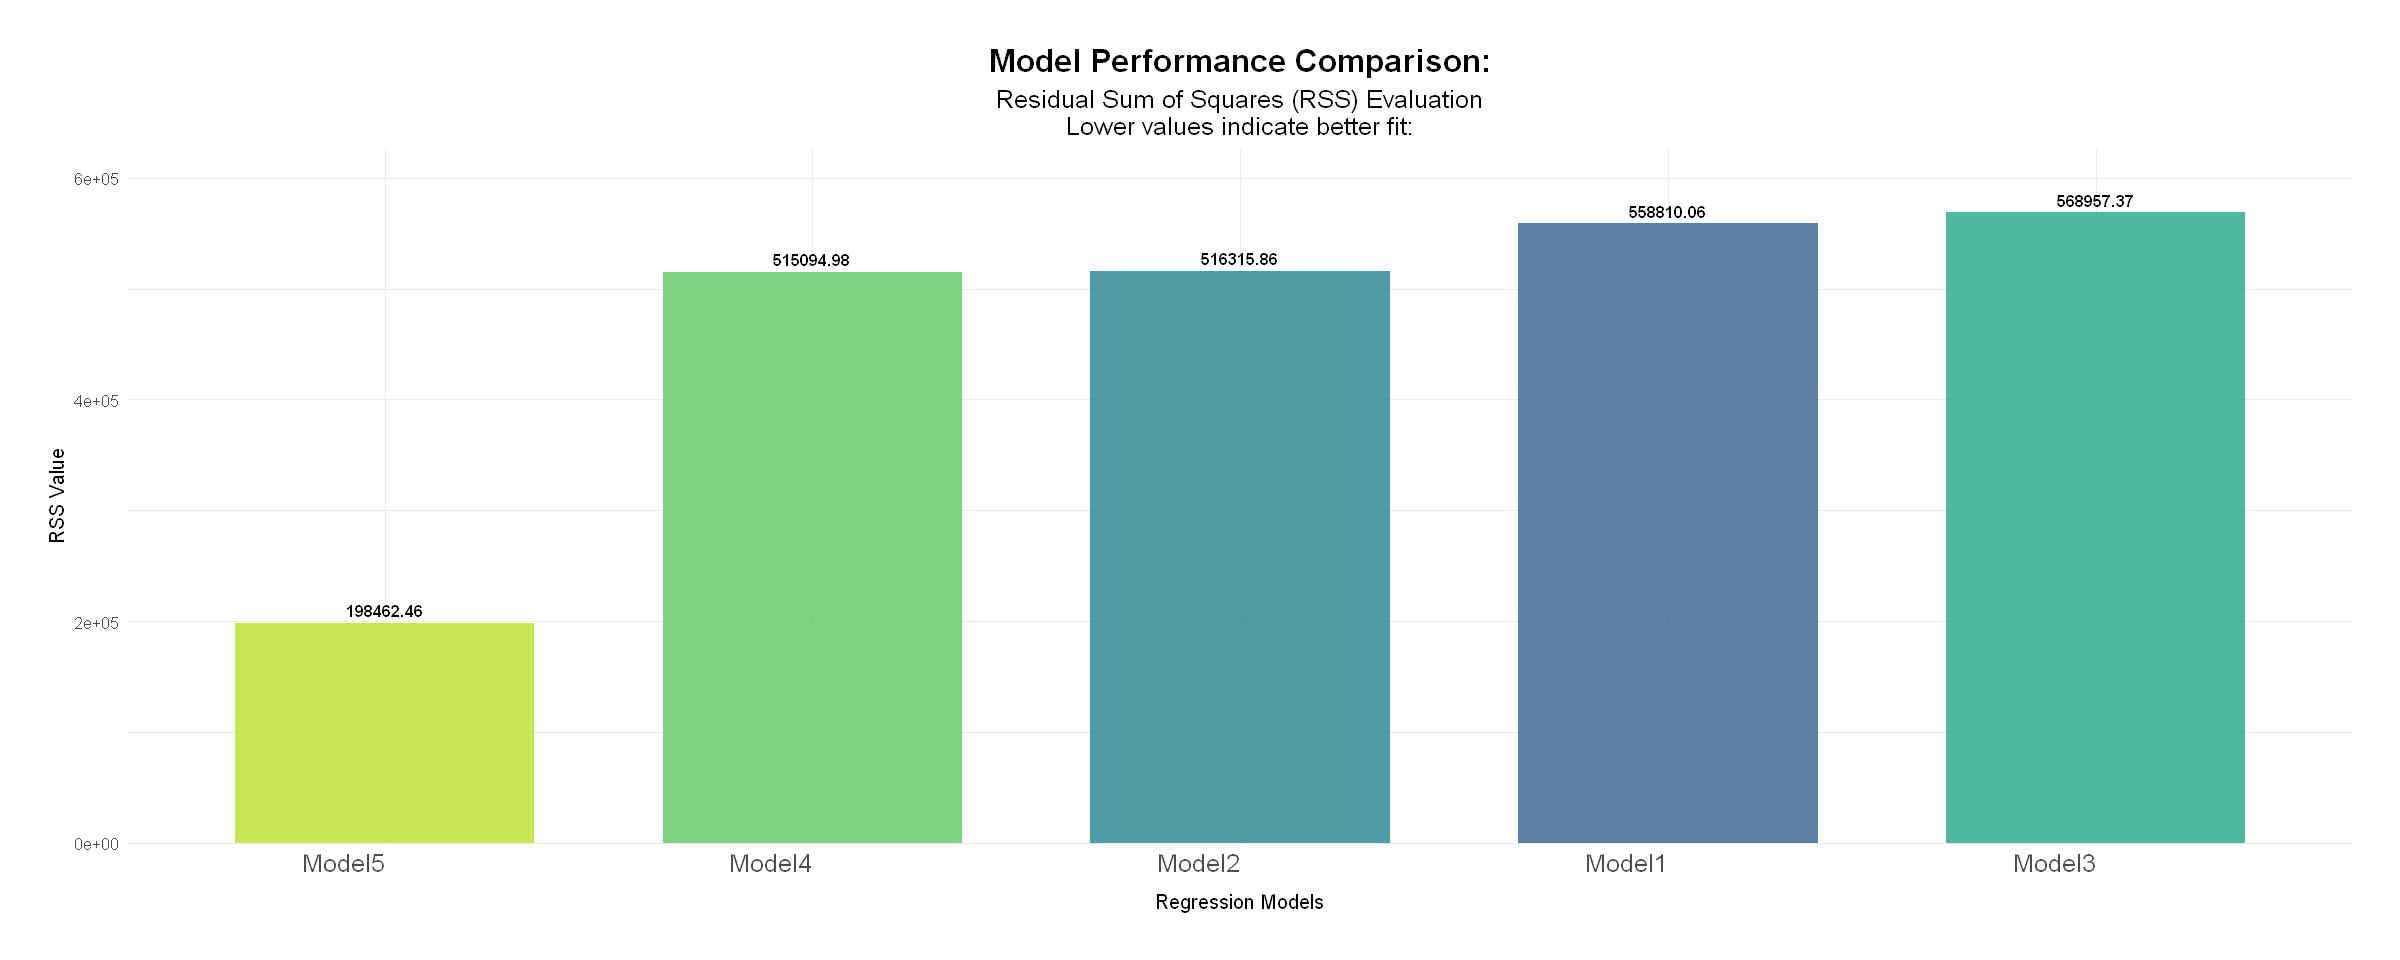

In [72]:
# Plotting the RSS values using bar plots: 

# Prepare data frame for plotting
df <- data.frame(
  Model = names(rss_values),
  RSS = as.numeric(rss_values)
)

# Create bar plot comparing RSS values across models
model_comparison_plot <- ggplot(df, aes(x = reorder(Model, RSS), y = RSS, fill = Model)) +
  
  # Bars and labels
  geom_bar(stat = "identity", width = 0.7, alpha = 0.8) +
  geom_text(aes(label = round(RSS, 2)), vjust = -0.5, size = 3.5, fontface = "bold") +
  
  # Labels and titles
  labs(
    title = "Model Performance Comparison:",
    subtitle = "Residual Sum of Squares (RSS) Evaluation\nLower values indicate better fit:",
    x = "Regression Models",
    y = "RSS Value",
  ) +
  
  # Theme and formatting
  theme_minimal(base_size = 12) +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold", size = 19),
    plot.subtitle = element_text(hjust = 0.5, size = 15),
    axis.text.x = element_text(angle = 0, hjust = 1, vjust = 1, size =15),
    axis.title.x = element_text(margin = margin(t = 10)),
    legend.position = "none",
    plot.margin = margin(1, 1, 1, 1, unit = "cm")
  ) +
  
  # Y-axis buffer and color scale
  scale_y_continuous(expand = expansion(mult = c(0, 0.1))) +
  scale_fill_viridis_d(option = "D", begin = 0.3, end = 0.9)

# Set plot size using repr
# width and height are in inches
options(jupyter.plot_mimetypes = "image/png") 
options(repr.plot.width = 20,   # Set default plot width
        repr.plot.height = 8)  # Set default plot height

# Show the plot
model_comparison_plot

### **Task 2.3: Calculate log-likelihood for each model:**

In [73]:
# Calculate log-likelihood for each model

# The log-likelihood function is:
# ln p(D|θ̂) = -n/2 ln(2π) - n/2 ln(σ̂²) - RSS/(2σ̂²)
# Where σ̂² = RSS/(n-1) is the estimated variance

calculate_log_likelihood <- function(rss, n) {
  # Calculate the estimated variance (σ̂²)
  sigma_squared <- rss / (n - 1)
  
  # Calculate the log-likelihood using the formula
  log_likelihood <- -n/2 * log(2*pi) - n/2 * log(sigma_squared) - rss/(2*sigma_squared)
  
  return(log_likelihood)
}

In [74]:
# Get the number of observations (n)
n <- nrow(data)
cat("Number of observations:", n, "\n\n")

Number of observations: 9527 



In [75]:
# Calculate log-likelihood for each model
# For each model, we use the RSS calculated earlier

ll1 <- calculate_log_likelihood(rss1, n)
ll2 <- calculate_log_likelihood(rss2, n)
ll3 <- calculate_log_likelihood(rss3, n)
ll4 <- calculate_log_likelihood(rss4, n)
ll5 <- calculate_log_likelihood(rss5, n)

In [76]:
# Print the log-likelihood values: 

cat("Log-likelihood values:\n")
cat("Model 1:", ll1, "\n")
cat("Model 2:", ll2, "\n")
cat("Model 3:", ll3, "\n")
cat("Model 4:", ll4, "\n")
cat("Model 5:", ll5)

Log-likelihood values:


Model 1: -32913.67 
Model 2: -32536.92 
Model 3: -32999.4 
Model 4: -32525.65 
Model 5: -27982.45

In [77]:
# Store log-likelihood values

ll_values <- c(
  Model1 = ll1,
  Model2 = ll2,
  Model3 = ll3,
  Model4 = ll4,
  Model5 = ll5
)

In [78]:
# Create comparison table of RSS and log-likelihoods: 

ll_comparison <- data.frame(
  Model = c("Model 1", "Model 2", "Model 3", "Model 4", "Model 5"),
  RSS = c(rss1, rss2, rss3, rss4, rss5),
  LogLikelihood = c(ll1, ll2, ll3, ll4, ll5)
)

# Print the log-likelihood values with RSS: 
ll_comparison

Model,RSS,LogLikelihood
<chr>,<dbl>,<dbl>
Model 1,558810.1,-32913.67
Model 2,516315.9,-32536.92
Model 3,568957.4,-32999.40
Model 4,515095.0,-32525.65
Model 5,198462.5,-27982.45


In [79]:
# create dataframe and only include rss values: 
rss_df <- data.frame(
  Model = c("Model 1", "Model 2", "Model 3", "Model 4", "Model 5"),
  RSS = c(rss1, rss2, rss3, rss4, rss5)
)
rss_df

Model,RSS
<chr>,<dbl>
Model 1,558810.1
Model 2,516315.9
Model 3,568957.4
Model 4,515095.0
Model 5,198462.5


###  **Task 2.4: Calculate AIC and BIC for each model:**

In [80]:
# Calculate AIC and BIC for each model:

# AIC = 2k - 2ln p(D|θ̂)
# BIC = k·ln(n) - 2ln p(D|θ̂)
# Where:
# - k is the number of parameters in the model
# - n is the number of observations
# - ln p(D|θ̂) is the log-likelihood function

# First, determine the number of parameters (k) for each model
# k includes all coefficients plus the variance parameter
k1 <- ncol(X1)  # Model 1: bias, x4, x3²
k2 <- ncol(X2)  # Model 2: bias, x4, x3², x5
k3 <- ncol(X3)  # Model 3: x3, x4, x5³ (no bias)
k4 <- ncol(X4)  # Model 4: bias, x4, x3², x5³
k5 <- ncol(X5)  # Model 5: bias, x4, x1², x3²

In [81]:
k1 # k-value for model 1

[1] 3

In [82]:
# Function to calculate AIC and BIC:

calculate_aic_bic <- function(log_likelihood, k, n) {
  # Calculate AIC = 2k - 2ln p(D|θ̂)
  aic <- 2*k - 2*log_likelihood
  
  # Calculate BIC = k·ln(n) - 2ln p(D|θ̂)
  bic <- k*log(n) - 2*log_likelihood
  
  return(list(aic = aic, bic = bic))
}

In [83]:
# Calculate AIC and BIC for each model

aic_bic1 <- calculate_aic_bic(ll1, k1, n)
aic_bic2 <- calculate_aic_bic(ll2, k2, n)
aic_bic3 <- calculate_aic_bic(ll3, k3, n)
aic_bic4 <- calculate_aic_bic(ll4, k4, n)
aic_bic5 <- calculate_aic_bic(ll5, k5, n)

In [84]:
aic_bic1 # An example to see how they look

$aic
[1] 65833.35

$bic
[1] 65854.83

In [85]:
# Create a comparison table with AIC, BIC,
# Log-Likelihood, RSS, number of parameters, and model names:

aic_bic_comparison <- data.frame(
  Model = c("Model 1", "Model 2", "Model 3", "Model 4", "Model 5"),
  Parameters = c(k1, k2, k3, k4, k5),
  RSS = c(rss1, rss2, rss3, rss4, rss5),
  LogLikelihood = c(ll1, ll2, ll3, ll4, ll5),
  AIC = c(aic_bic1$aic, aic_bic2$aic, aic_bic3$aic, aic_bic4$aic, aic_bic5$aic),
  BIC = c(aic_bic1$bic, aic_bic2$bic, aic_bic3$bic, aic_bic4$bic, aic_bic5$bic)
)

# Print the comparison table: 
cat("Model Comparison Table:\n")
aic_bic_comparison

Model Comparison Table:


Model,Parameters,RSS,LogLikelihood,AIC,BIC
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Model 1,3,558810.1,-32913.67,65833.35,65854.83
Model 2,4,516315.9,-32536.92,65081.85,65110.50
Model 3,3,568957.4,-32999.40,66004.79,66026.28
Model 4,4,515095.0,-32525.65,65059.29,65087.94
Model 5,4,198462.5,-27982.45,55972.91,56001.55


In [86]:
# Identify the better performing model according to 
# each criterion:AIC, BIC, RSS and Log-Likelihood

best_rss <- aic_bic_comparison$Model[which.min(aic_bic_comparison$RSS)] # low RSS is better
best_aic <- aic_bic_comparison$Model[which.min(aic_bic_comparison$AIC)] # low AIC is better
best_bic <- aic_bic_comparison$Model[which.min(aic_bic_comparison$BIC)] # low BIC is better

cat("\nBetter performing model according to RSS:", best_rss, "\n")
cat("Better performing model according to AIC:", best_aic, "\n")
cat("Better performing model according to BIC:", best_bic, "\n")


Better performing model according to RSS: Model 5 
Better performing model according to AIC: Model 5 
Better performing model according to BIC: Model 5 


In [87]:
# Store the results for later use
aic_values <- c(
  Model1 = aic_bic1$aic,
  Model2 = aic_bic2$aic,
  Model3 = aic_bic3$aic,
  Model4 = aic_bic4$aic,
  Model5 = aic_bic5$aic
)

In [88]:
bic_values <- c(
  Model1 = aic_bic1$bic,
  Model2 = aic_bic2$bic,
  Model3 = aic_bic3$bic,
  Model4 = aic_bic4$bic,
  Model5 = aic_bic5$bic
)

In [89]:
# cretae a dataframe for aic and bic values
aic_bic_df <- data.frame(
  Model = c("Model 1", "Model 2", "Model 3", "Model 4", "Model 5"),
  AIC = c(aic_bic1$aic, aic_bic2$aic, aic_bic3$aic, aic_bic4$aic, aic_bic5$aic),
  BIC = c(aic_bic1$bic, aic_bic2$bic, aic_bic3$bic, aic_bic4$bic, aic_bic5$bic)
)
aic_bic_df

Model,AIC,BIC
<chr>,<dbl>,<dbl>
Model 1,65833.35,65854.83
Model 2,65081.85,65110.50
Model 3,66004.79,66026.28
Model 4,65059.29,65087.94
Model 5,55972.91,56001.55


##### **R-squared($R^2$), Adjusted R-squared ($R^2_{\text{adj}}$), Root mean squared error ($RMSE$) and Mean percentage error ($MPE$):**

In [90]:
# RSS values calculated above:
rss1 
rss2
rss3
rss4
rss5 

[1] 558810.1

[1] 516315.9

[1] 568957.4

[1] 515095

[1] 198462.5

In [91]:
# R-squared: Proportion of variance explained by the model
r_squared <- function(y, y_pred) {
  ss_res <- sum((y - y_pred)^2)           # Residual sum of squares
  ss_tot <- sum((y - mean(y))^2)          # Total sum of squares
  1 - ss_res / ss_tot                     # R-squared formula
}

In [92]:
# Adjusted R-squared: Adjusts R^2 for number of predictors (p) and observations (n)
# p = number of predictors (excluding intercept)
adjusted_r_squared <- function(y, y_pred, p) {
  n <- length(y)                          # Number of observations
  r2 <- r_squared(y, y_pred)              # R-squared
  1 - (1 - r2) * ((n - 1) / (n - p - 1))  # Adjusted R-squared formula
}
# actual is the vector of observed values (e.g., test or train y).
# predicted is the vector of predicted values from the model.
# p is the number of predictors (not including the intercept).

In [93]:
# Root Mean Squared Error (RMSE): Average magnitude of prediction error
# Function to calculate Root Mean Squared Error (RMSE)
rmse <- function(y, y_pred) {
  sqrt(mean((y - y_pred)^2))              # RMSE formula
}

In [94]:
# Mean Percentage Error (MPE): Average percentage error (can be negative)
# Function to calculate Mean Percentage Error (MPE)
mpe <- function(y, y_pred) {
  mean((y - y_pred) / y) * 100            # MPE formula (in percent)
}

In [95]:
# Function to compute all metrics for a list of models
evaluate_models <- function(y, model_list) {
  results <- data.frame(
    Model = character(),
    R2 = numeric(),
    Adj_R2 = numeric(),
    RMSE = numeric(),
    MPE = numeric(),
    stringsAsFactors = FALSE
  )
  for (i in seq_along(model_list)) {
    model <- model_list[[i]]
    X <- model$X
    theta <- model$theta
    y_pred <- X %*% theta
    p <- ncol(X) - as.integer(colnames(X)[1] == "bias") # exclude intercept if present
    results <- rbind(results, data.frame(
      Model = paste0("Model ", i),
      R2 = r_squared(y, y_pred),
      Adj_R2 = adjusted_r_squared(y, y_pred, p),
      RMSE = rmse(y, y_pred),
      MPE = mpe(y, y_pred)
    ))
  }
  return(results)
}

# Prepare your models as a list
model_list <- list(
  list(X = X1, theta = theta1),
  list(X = X2, theta = theta2),
  list(X = X3, theta = theta3),
  list(X = X4, theta = theta4),
  list(X = X5, theta = theta5)
)

# Call the function and print the summary table
metrics_summary <- evaluate_models(y, model_list)
print(metrics_summary)

    Model        R2    Adj_R2     RMSE         MPE
1 Model 1 0.7979488 0.7979064 7.658682 -0.02753546
2 Model 2 0.8133136 0.8132548 7.361726 -0.02538051
3 Model 3 0.7942798 0.7942150 7.727905 -0.02896322
4 Model 4 0.8137551 0.8136964 7.353017 -0.02532178
5 Model 5 0.9282411 0.9282185 4.564162 -0.01009492


### **Task 2.5: Analyzing Residual Distributions:**

> $Residuals$ = $Actual$ $values$ - $Predicted$ $values$

In [96]:
# Analysis of the Distribution of Residuals:

# This analysis helps verify if model assumptions are met, particularly:
# - Normality of residuals (should follow a normal distribution)
# - Homoscedasticity (constant variance across predictions)
# - Independence (no patterns in residuals)

# Calculate residuals for each model: 
# Residuals = Actual values - Predicted values
residuals1 <- y - X1 %*% theta1
residuals2 <- y - X2 %*% theta2
residuals3 <- y - X3 %*% theta3
residuals4 <- y - X4 %*% theta4
residuals5 <- y - X5 %*% theta5

# Store residuals in a data frame for easier analysis
residuals_df <- data.frame(
  Model1 = as.vector(residuals1),
  Model2 = as.vector(residuals2),
  Model3 = as.vector(residuals3),
  Model4 = as.vector(residuals4),
  Model5 = as.vector(residuals5)
)

# Preview the first few residuals
cat("First few residuals for each model:\n")
head(residuals_df)

First few residuals for each model:


,Model1,Model2,Model3,Model4,Model5
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,12.600369,11.085685,8.568257,10.961994,2.1117450
2,-2.033020,-2.651892,-2.554337,-2.564005,0.6075230
3,-8.316513,-3.014048,-5.589774,-3.251239,0.9377150
4,-1.852457,-2.291955,-4.909931,-2.208376,-0.8681405
5,-7.029623,-9.371600,-9.137398,-9.662198,-7.6155940
6,-1.926094,-2.744397,-3.166952,-2.773088,2.4674247


In [97]:
dim(residuals_df)

[1] 9527    5

In [98]:
# Calculate basic statistics for residuals:

# Function to calculate residual statistics: 
get_residual_stats <- function(residuals) {
  data.frame(
    Mean = mean(residuals),                # this should be close to zero
    Median = median(residuals),            # this should be close to zero
    SD = sd(residuals),                    # this is the measure of spread
    Skewness = skewness(residuals),        # this should be close to 0 for normal distribution
    Kurtosis = kurtosis(residuals),        # this should be close to 3 for normal distribution
    Min = min(residuals),                  # the minimum residual for the model 
    Max = max(residuals),                  # maximum residual for model
    Range = max(residuals) - min(residuals) # range of residuals: (max - min)
  )
}

In [99]:
# Calculate statistics for each model: 

stats1 <- get_residual_stats(residuals1)
stats2 <- get_residual_stats(residuals2)
stats3 <- get_residual_stats(residuals3)
stats4 <- get_residual_stats(residuals4)
stats5 <- get_residual_stats(residuals5)

In [100]:
# Combine all statistics into a single table for better comparision: 

residual_stats <- rbind(stats1, stats2, stats3, stats4, stats5)
rownames(residual_stats) <- c("Model 1", "Model 2", "Model 3", "Model 4", "Model 5")

# Print the statistics: 
cat("\nResidual Statistics:\n")
residual_stats


Residual Statistics:


,Mean,Median,SD,Skewness,Kurtosis,Min,Max,Range
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Model 1,7.687799e-09,-0.28557072,7.659084,0.14174837,3.783532,-37.78397,34.91952,72.70349
Model 2,-1.829808e-09,-0.26363621,7.362112,0.18432395,3.823095,-37.21709,32.06736,69.28444
Model 3,-1.924974e-03,-0.04835623,7.728311,-0.04852534,3.800702,-37.78207,35.72619,73.50826
Model 4,-3.562977e-08,-0.25279206,7.353403,0.18648694,3.825071,-37.50547,31.93611,69.44158
Model 5,-4.855548e-09,-0.01658536,4.564402,-0.47930255,6.549272,-46.63797,16.41039,63.04836


#### **Normality Tests for the Distribution of Residuals:**

**Histograms with Density + Rug plots:**

No id variables; using all as measure variables



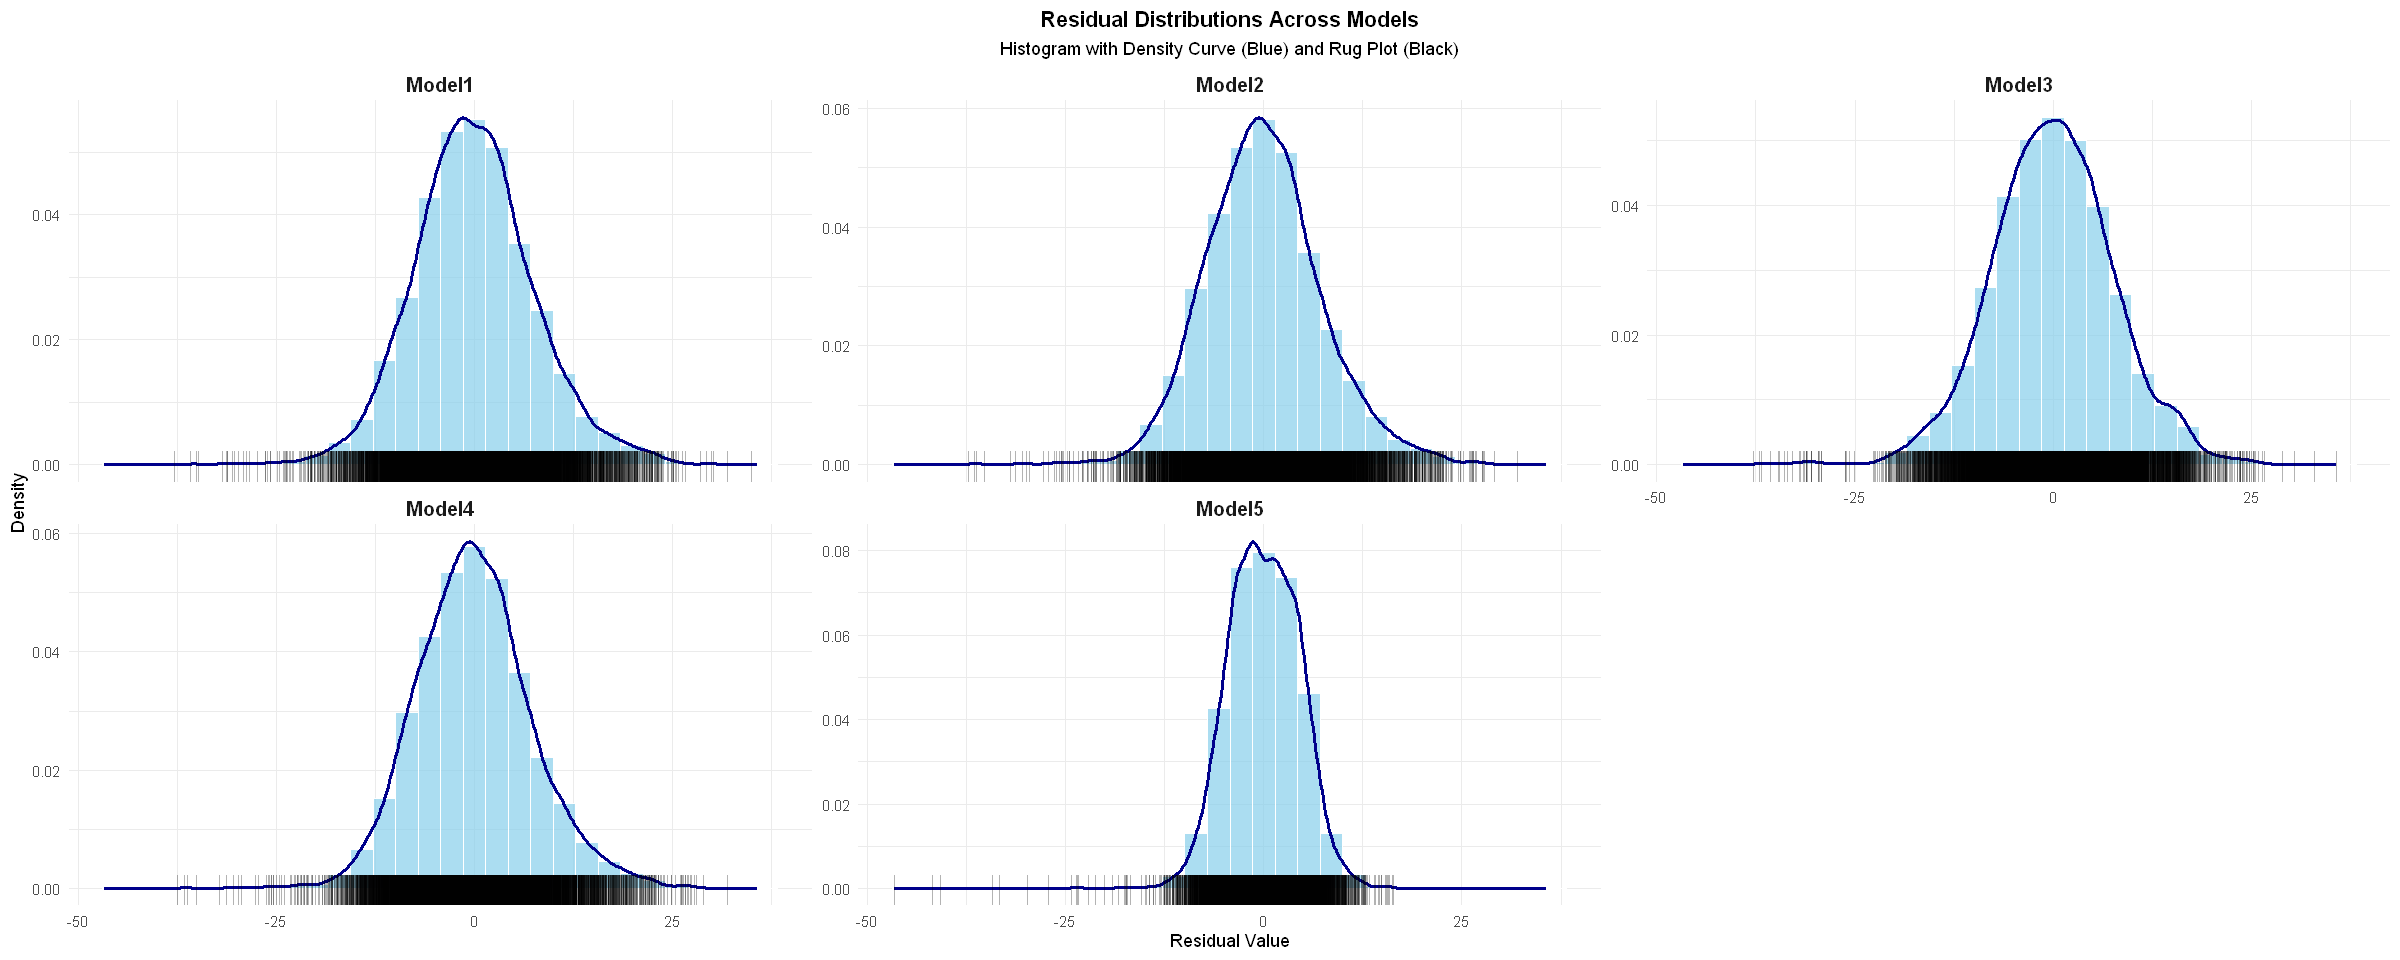

In [101]:
# hide warnings;
options(warn = -1)

# Load necessary libraries
library(ggplot2)
library(reshape2)

# Convert wide-format residuals data frame to long-format for ggplot
# This makes plotting multiple models easier using 'facet_wrap'
residuals_long <- melt(
  residuals_df,
  variable.name = "Model",    # Name for the column containing model names
  value.name = "Residual"     # Name for the column containing residuals
)

# Create histogram plot with density overlay and rug plot for each model
hist_plot <- ggplot(residuals_long, aes(x = Residual)) +
  
  # Plot histogram of residuals with density scaling
  geom_histogram(
    aes(y = ..density..),     # Use density instead of raw counts
    bins = 30,                # Number of bins in histogram
    fill = "skyblue",         # Bar fill color
    color = "white",          # Border color of bars
    alpha = 0.7               # Transparency for visual softness
  ) +
  
  # Add actual density curve (smooth estimate of distribution)
  geom_density(
    color = "darkblue",       # Line color for density
    linewidth = 1             # Line thickness
  ) +
  
  # Add rug plot for residuals (shows individual values)
  geom_rug(
    aes(x = Residual), 
    sides = "b", 
    color = "black", 
    alpha = 0.3, 
    length = unit(0.08, "npc")
  ) +
  
  # Facet the plot by each model so each gets its own histogram
  facet_wrap(~ Model, scales = "free_y") +
  
  # Add informative titles and axis labels
  labs(
    title = "Residual Distributions Across Models",
    subtitle = "Histogram with Density Curve (Blue) and Rug Plot (Black)",
    x = "Residual Value",
    y = "Density"
  ) +
  
  # Use a clean minimal theme for clarity
  theme_minimal() +
  theme(
    strip.text = element_text(size = 12, face = "bold"),     # Model names
    plot.title = element_text(hjust = 0.5, face = "bold"),   # Centered bold title
    plot.subtitle = element_text(hjust = 0.5)                # Centered subtitle
  )

# Show the plot
print(hist_plot)
# Reset warnings settings:
options(warn = 0)

**QQ-Plots for Normality Check:** 

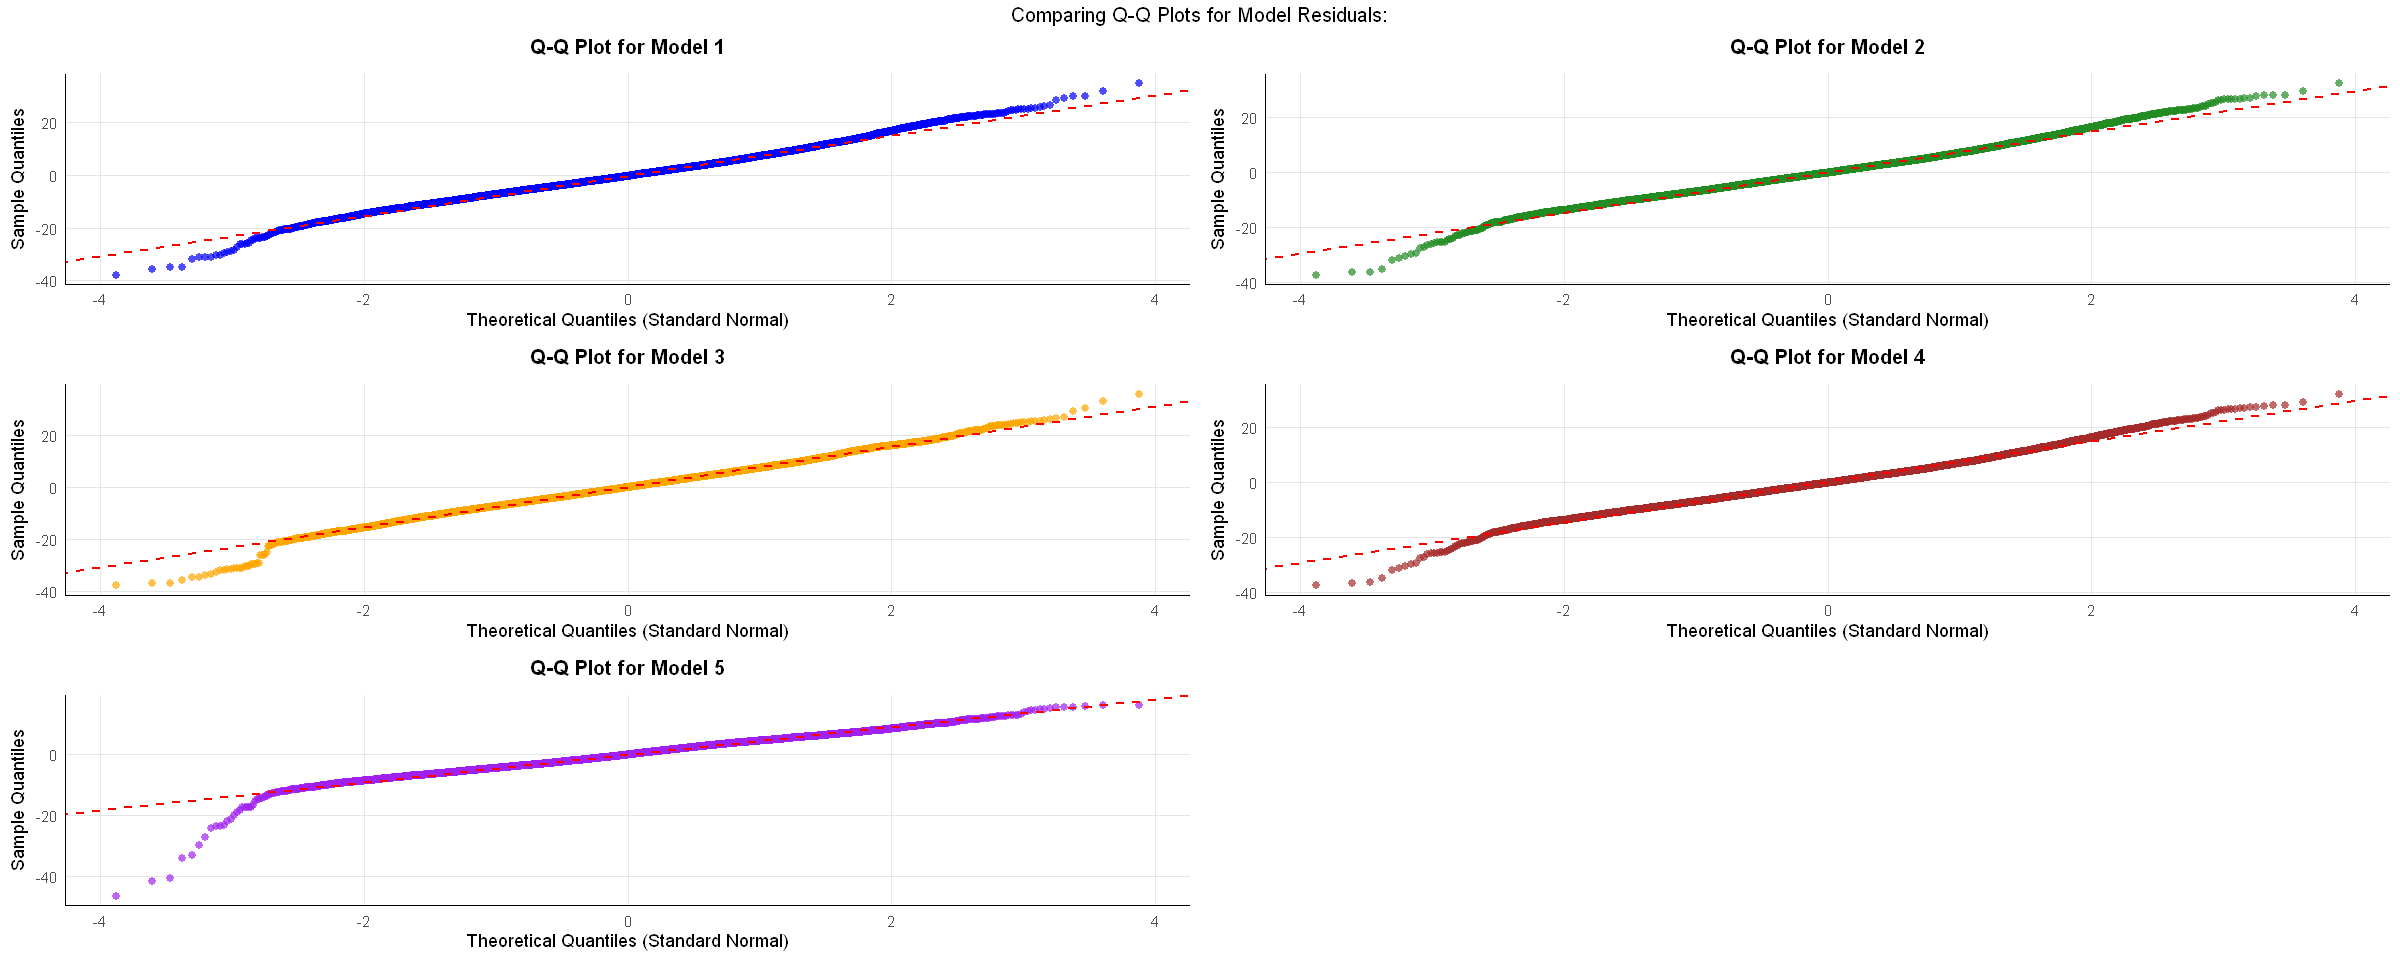

In [102]:
# Load required libraries
library(ggplot2)      # For creating the Q-Q plot
library(gridExtra)    # For arranging multiple plots (if needed)

#' Create a Quantile-Quantile (Q-Q) Plot Residuals
#' 
#'Creates a Q-Q plot against the standard normal distribution.
#'
#' @param residuals Numeric vector of model residuals (must be clean)
#' @param model_name Character string for plot title (default: "Model")
#' @param point_color Color for Q-Q points (default: "steelblue")
#' @param point_alpha Transparency for points (default: 0.7)
#' @param point_size Size of points (default: 2)
#' @param line_color Color for reference line (default: "red")
#' @param line_type Linetype for reference line (default: "dashed")
#' @param line_width Width of reference line (default: 0.8)
#' 
#' @return A ggplot object containing the Q-Q plot
create_qq_plot <- function(residuals, 
                                model_name = "Model", 
                                point_color = "steelblue",
                                point_alpha = 0.7,
                                point_size = 2,
                                line_color = "red",
                                line_type = "dashed",
                                line_width = 0.8) {

  # Calculate Theoretical and Sample Quantiles
  # Get number of observations
  n <- length(residuals)
  
  # Calculate probability points using Blom's method
  # (1:n - 0.5)/n gives unbiased quantile estimates for normal distribution
  p <- (1:n - 0.5) / n
  
  # Get theoretical quantiles from standard normal distribution
  theoretical_q <- qnorm(p)
  
  # Get empirical quantiles by sorting the residuals
  empirical_q <- sort(residuals)
  
  # Prepare Data for Plotting

  # Create data frame for ggplot
  qq_data <- data.frame(
    Theoretical = theoretical_q,  # x-axis values
    Empirical = empirical_q       # y-axis values
  )
  
  # Calculate parameters for reference line
  # Using mean and sd of residuals makes the line represent
  # what we would expect if residuals were perfectly normal
  ref_intercept <- mean(residuals)
  ref_slope <- sd(residuals)
  
  # Create the Q-Q Plot: 
  
  # Initialize ggplot with our data
  qq_plot <- ggplot(qq_data, aes(x = Theoretical, y = Empirical)) +
    
    # Add the points for the Q-Q plot
    geom_point(
      color = point_color,      # Point color from parameters
      alpha = point_alpha,      # Transparency from parameters
      size = point_size,        # Size from parameters
      shape = 16                # Solid circle shape (16 is ggplot's default)
    ) +
    
    # Add the reference line
    # This line shows what perfect normality would look like
    geom_abline(
      intercept = ref_intercept,  # Line intercept (mean of residuals)
      slope = ref_slope,          # Line slope (sd of residuals)
      color = line_color,         # Line color from parameters
      linetype = line_type,       # Line type from parameters
      linewidth = line_width      # Line width from parameters
    ) +
    
    # Add labels and title
    labs(
      title = paste("Q-Q Plot for", model_name),  # Dynamic title with model name
      x = "Theoretical Quantiles (Standard Normal)",  # x-axis label
      y = "Sample Quantiles"                     # y-axis label
    ) +
    
    # Apply minimal theme (clean background)
    theme_minimal() +
    
    # Customize theme elements
    theme(
      plot.title = element_text(
        hjust = 0.5,            # Center the title
        face = "bold",          # Bold font
        size = 12,             # Slightly larger size
        margin = margin(b = 10) # Add space below title
      ),
      panel.grid.minor = element_blank(),  # Remove minor grid lines
      panel.grid.major = element_line(color = "grey90"),  # Light grid lines
      axis.line = element_line(color = "black")  # Add axis lines
    )
  
  # Return the plot object
  return(qq_plot)
}
# Example usage (assuming residuals1-residuals5 exist):
qq1 <- create_qq_plot(residuals1, "Model 1", point_color= "blue")
qq2 <- create_qq_plot(residuals2, "Model 2", point_color= "forestgreen")
qq3 <- create_qq_plot(residuals3, "Model 3", point_color="orange" )
qq4 <- create_qq_plot(residuals4, "Model 4", point_color= "brown")
qq5 <- create_qq_plot(residuals5, "Model 5", point_color= "purple")

# Arrange plots with proper layout
combined_qq <- grid.arrange(
   qq1, qq2, qq3, qq4, qq5,
   ncol = 2,
   top = "Comparing Q-Q Plots for Model Residuals:"
 )

We want to compare each model’s residuals against the standard normal distribution (mean 0, sd 1), so first we standardize the residuals for each model.

In [103]:
residuals1_std <- scale(residuals1)
residuals2_std <- scale(residuals2)
residuals3_std <- scale(residuals3)
residuals4_std <- scale(residuals4)
residuals5_std <- scale(residuals5)

Now, plot the qq-plots for the standardized residuals of all the models:

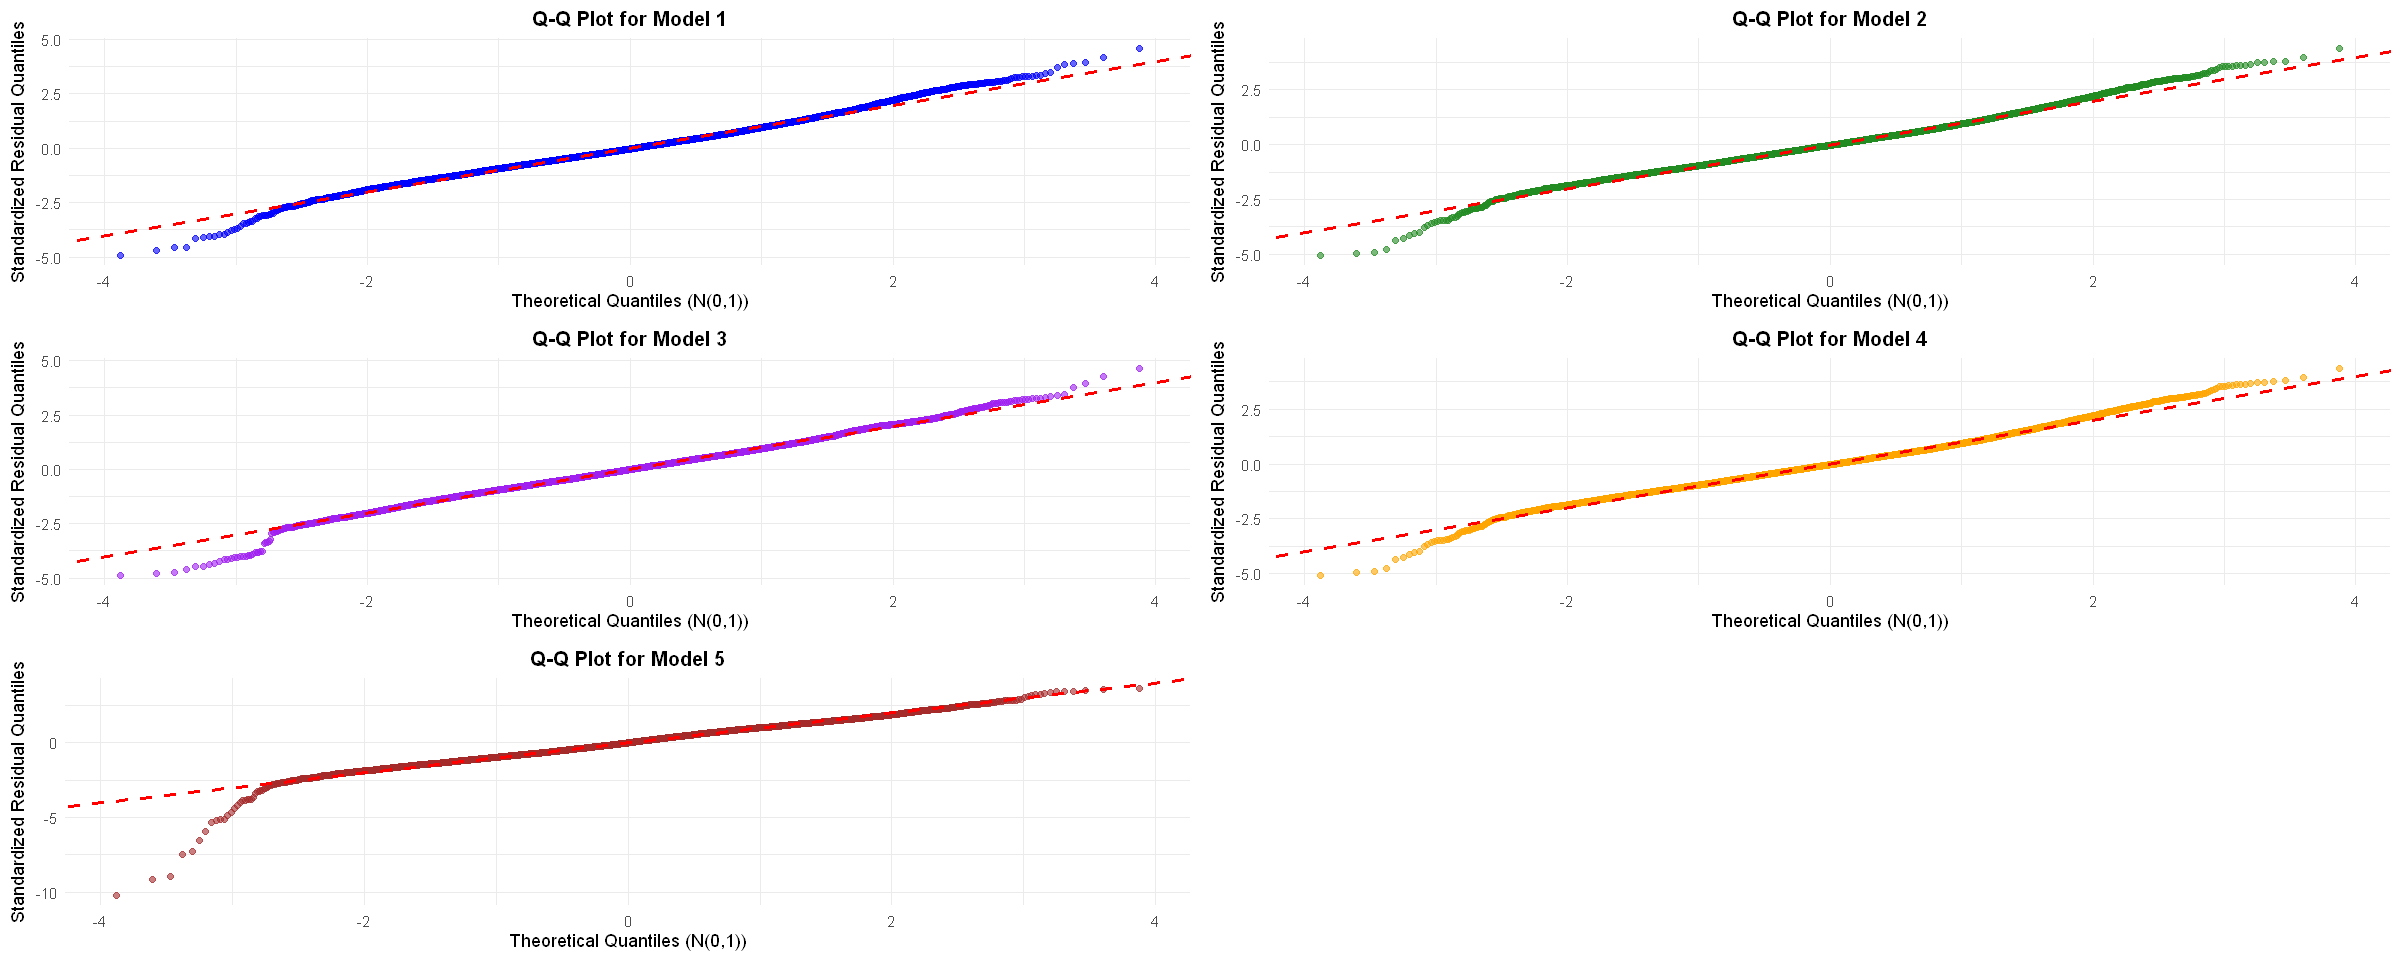

In [104]:
# Load required libraries
library(ggplot2)    # For creating plots
library(gridExtra)  # For arranging multiple plots in a grid

# Function to create a Q-Q plot for standardized residuals
create_qq_plot <- function(residuals_std, model_name, point_color) {

  # Get the number of residuals
  n <- length(residuals_std)

  # Compute the percentiles for the residuals
  # These are used to get the corresponding theoretical quantiles
  p <- (1:n - 0.5) / n

  # Compute the theoretical quantiles from the standard normal distribution
  theoretical_q <- qnorm(p)

  # Sort the standardized residuals to get empirical quantiles
  empirical_q <- sort(residuals_std)

  # Create a data frame with both quantiles for plotting
  qq_data <- data.frame(
    Theoretical = theoretical_q,
    Empirical = empirical_q
  )

  # Create the Q-Q plot
  ggplot(qq_data, aes(x = Theoretical, y = Empirical)) +
    geom_point(color = point_color, alpha = 0.6) +  # Add the points (empirical vs theoretical)
    
    # Add a 45-degree reference line (y = x), indicating perfect normality
    geom_abline(intercept = 0, slope = 1, color = "red", 
                linetype = "dashed", linewidth = 1) +

    # Add titles and axis labels
    labs(
      title = paste("Q-Q Plot for", model_name),
      x = "Theoretical Quantiles (N(0,1))",
      y = "Standardized Residual Quantiles"
    ) +

    # Use a minimal theme for a clean look
    theme_minimal() +

    # Customize the plot title appearance
    theme(
      plot.title = element_text(hjust = 0.5, face = "bold", size = 12)
    )
}

# Create Q-Q plots for each model using their standardized residuals and a unique color
qq1 <- create_qq_plot(residuals1_std, "Model 1", "blue")
qq2 <- create_qq_plot(residuals2_std, "Model 2", "forestgreen")
qq3 <- create_qq_plot(residuals3_std, "Model 3", "purple")
qq4 <- create_qq_plot(residuals4_std, "Model 4", "orange")
qq5 <- create_qq_plot(residuals5_std, "Model 5", "brown")

# Display all five plots in a 2-column grid layout
# This helps visually compare the residual normality across models
grid.arrange(qq1, qq2, qq3, qq4, qq5, ncol = 2)

##### **Proportion of Residuals within different Standard Deviation Ranges:**

In [105]:
# Calculate proportion of residuals within different standard deviation ranges

# For a normal distribution:
# - ~68% of values should be within 1 standard deviation of the mean
# - ~95% of values should be within 2 standard deviations
# - ~99.7% of values should be within 3 standard deviations

# Function to calculate normality measures
calculate_normality_measures <- function(residuals, model_name) {
  # Calculate basic statistics
  mean_val <- mean(residuals)
  median_val <- median(residuals)
  sd_val <- sd(residuals)
  
  # Calculate standardized residuals
  std_residuals <- (residuals - mean_val) / sd_val
  
  # Calculate proportion within different SD ranges
  within_1sd <- mean(abs(std_residuals) <= 1) * 100
  within_2sd <- mean(abs(std_residuals) <= 2) * 100
  within_3sd <- mean(abs(std_residuals) <= 3) * 100
  
  # Expected proportions for normal distribution
  expected_1sd <- 68.27
  expected_2sd <- 95.45
  expected_3sd <- 99.73
  
  # Create results data frame
  data.frame(
    Model = model_name,
    Within1SD = sprintf("%.2f%% (Exp: 68.27%%)", within_1sd),
    Within2SD = sprintf("%.2f%% (Exp: 95.45%%)", within_2sd),
    Within3SD = sprintf("%.2f%% (Exp: 99.73%%)", within_3sd),
    Skewness = round(skewness(residuals), 4),
    ExcessKurtosis = round(kurtosis(residuals) - 3, 4)
  )
}

# Calculate measures for each model
measures1 <- calculate_normality_measures(residuals1, "Model 1")
measures2 <- calculate_normality_measures(residuals2, "Model 2")
measures3 <- calculate_normality_measures(residuals3, "Model 3")
measures4 <- calculate_normality_measures(residuals4, "Model 4")
measures5 <- calculate_normality_measures(residuals5, "Model 5")

# Combine results
normality_measures <- rbind(measures1, measures2, measures3, measures4, measures5)

# Print results
cat("\nNormality Distribution Measures:\n")
normality_measures


Normality Distribution Measures:


Model,Within1SD,Within2SD,Within3SD,Skewness,ExcessKurtosis
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
Model 1,70.81% (Exp: 68.27%),94.91% (Exp: 95.45%),99.34% (Exp: 99.73%),0.1417,0.7835
Model 2,70.69% (Exp: 68.27%),95.17% (Exp: 95.45%),99.28% (Exp: 99.73%),0.1843,0.8231
Model 3,70.83% (Exp: 68.27%),94.77% (Exp: 95.45%),99.38% (Exp: 99.73%),-0.0485,0.8007
Model 4,70.65% (Exp: 68.27%),95.14% (Exp: 95.45%),99.24% (Exp: 99.73%),0.1865,0.8251
Model 5,69.00% (Exp: 68.27%),96.56% (Exp: 95.45%),99.55% (Exp: 99.73%),-0.4793,3.5493


##### **Residuals vs. Fitted Values:**

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


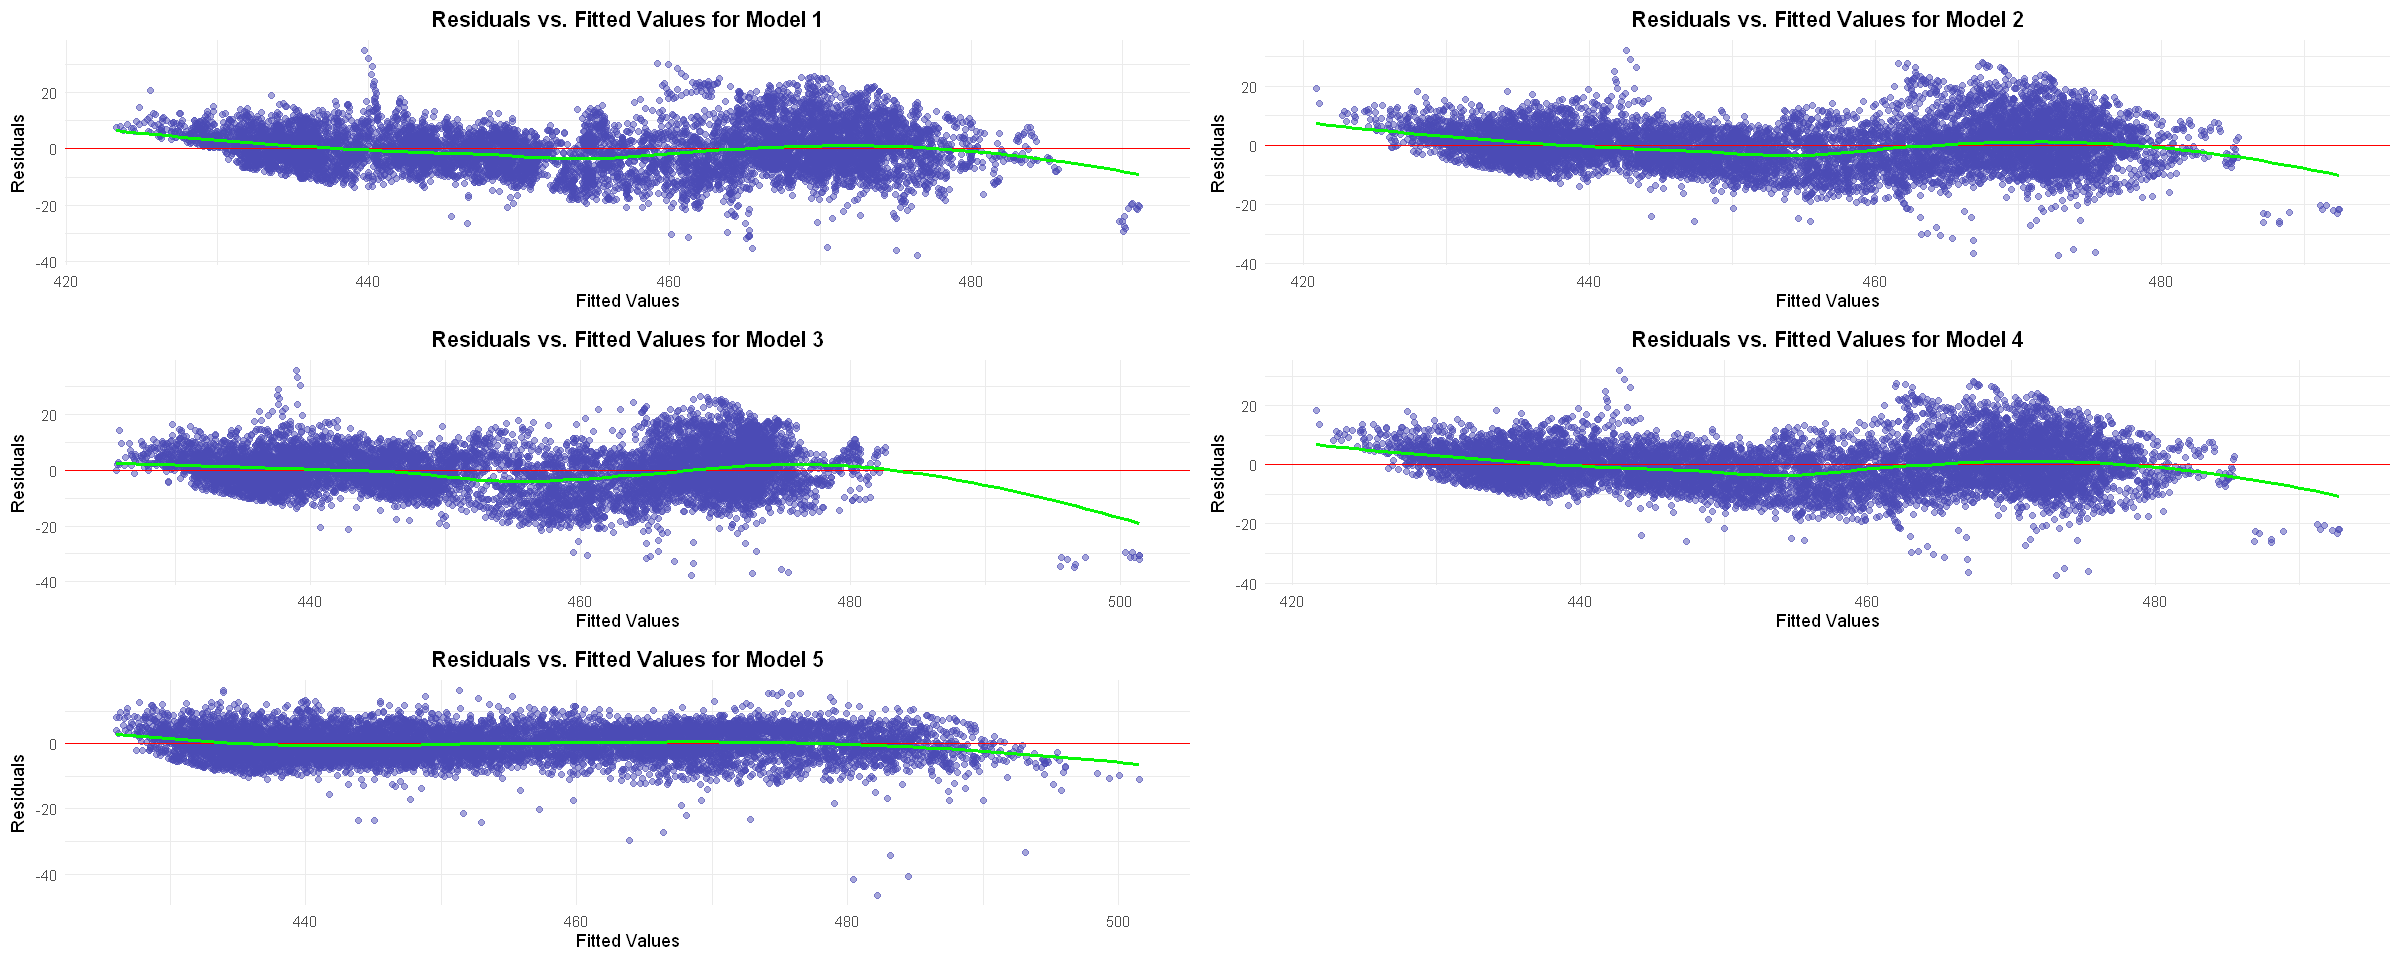

In [106]:
# Create residual plots (residuals vs. fitted values):

# These plots help check for homoscedasticity and patterns in residuals

# Function to create residual vs. fitted plot: 
create_residual_plot <- function(X, theta, residuals, model_name) {
  # Calculate fitted values
  fitted_values <- X %*% theta
  
  # Create data frame for plotting
  plot_data <- data.frame(
    Fitted = as.vector(fitted_values),
    Residual = as.vector(residuals)
  )
  
  # Create the plot
  ggplot(plot_data, aes(x = Fitted, y = Residual)) +
    geom_point(alpha = 0.5, color = "#4b4bb5") +
    geom_hline(yintercept = 0, linetype = "solid", color = "red") +
    geom_smooth(method = "loess", se = FALSE, color = "#06f706") +
    labs(title = paste("Residuals vs. Fitted Values for", model_name),
         x = "Fitted Values",
         y = "Residuals") +
    theme_minimal() +
    theme(
      plot.title = element_text(hjust = 0.5, face = "bold"),
      plot.subtitle = element_text(hjust = 0.5)
    )
}

# Create residual plots for each model
res_plot1 <- create_residual_plot(X1, theta1, residuals_df$Model1, "Model 1")
res_plot2 <- create_residual_plot(X2, theta2, residuals_df$Model2, "Model 2")
res_plot3 <- create_residual_plot(X3, theta3, residuals_df$Model3, "Model 3")
res_plot4 <- create_residual_plot(X4, theta4, residuals_df$Model4, "Model 4")
res_plot5 <- create_residual_plot(X5, theta5, residuals_df$Model5, "Model 5")

# Display the residual plots
grid.arrange(res_plot1, res_plot2, res_plot3, res_plot4, res_plot5, ncol = 2)

#### **Task 2.6: Selecting the Best Regression Model:**

In [107]:
metrics_summary # we have from above: 

Model,R2,Adj_R2,RMSE,MPE
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Model 1,0.7979488,0.7979064,7.658682,-0.02753546
Model 2,0.8133136,0.8132548,7.361726,-0.02538051
Model 3,0.7942798,0.7942150,7.727905,-0.02896322
Model 4,0.8137551,0.8136964,7.353017,-0.02532178
Model 5,0.9282411,0.9282185,4.564162,-0.01009492


In [108]:
# Create the comparison table for comparision: 
comparison_table <- data.frame(
  Model_1 = c(
    round(rss_comparison$RSS[1], 2),
    round(ll_comparison$LogLikelihood[1], 2),
    round(aic_bic_comparison$AIC[1], 2),
    round(aic_bic_comparison$BIC[1], 2),
    round(metrics_summary$R2[1], 2),
    round(metrics_summary$Adj_R2[1], 2),
    round(metrics_summary$RMSE[1], 2),
    round(metrics_summary$MPE[1], 2), 
    round(residual_stats$Mean[1], 6),
    round(residual_stats$Median[1], 2),
    round(residual_stats$SD[1], 2),
    round(residual_stats$Skewness[1], 3),
    round(residual_stats$Kurtosis[1], 3),
    round(residual_stats$Min[1], 2),
    round(residual_stats$Max[1], 2),
    round(residual_stats$Range[1], 2),
    normality_measures$Within1SD[1],
    normality_measures$Within2SD[1],
    normality_measures$Within3SD[1],
    round(normality_measures$ExcessKurtosis[1], 3)
  ),
  Model_2 = c(
    round(rss_comparison$RSS[2], 2),
    round(ll_comparison$LogLikelihood[2], 2),
    round(aic_bic_comparison$AIC[2], 2),
    round(aic_bic_comparison$BIC[2], 2),
    round(metrics_summary$R2[2], 2),
    round(metrics_summary$Adj_R2[2], 2),
    round(metrics_summary$RMSE[2], 2),
    round(metrics_summary$MPE[2], 2),
    round(residual_stats$Mean[2], 6),
    round(residual_stats$Median[2], 2),
    round(residual_stats$SD[2], 2),
    round(residual_stats$Skewness[2], 3),
    round(residual_stats$Kurtosis[2], 3),
    round(residual_stats$Min[2], 2),
    round(residual_stats$Max[2], 2),
    round(residual_stats$Range[2], 2),
    normality_measures$Within1SD[2],
    normality_measures$Within2SD[2],
    normality_measures$Within3SD[2],
    round(normality_measures$ExcessKurtosis[2], 3)
  ),
  Model_3 = c(
    round(rss_comparison$RSS[3], 2),
    round(ll_comparison$LogLikelihood[3], 2),
    round(aic_bic_comparison$AIC[3], 2),
    round(aic_bic_comparison$BIC[3], 2),
    round(metrics_summary$R2[3], 2),
    round(metrics_summary$Adj_R2[3], 2),
    round(metrics_summary$RMSE[3], 2),
    round(metrics_summary$MPE[3], 2), 
    round(residual_stats$Mean[3], 2),
    round(residual_stats$Median[3], 2),
    round(residual_stats$SD[3], 2),
    round(residual_stats$Skewness[3], 3),
    round(residual_stats$Kurtosis[3], 3),
    round(residual_stats$Min[3], 2),
    round(residual_stats$Max[3], 2),
    round(residual_stats$Range[3], 2),
    normality_measures$Within1SD[3],
    normality_measures$Within2SD[3],
    normality_measures$Within3SD[3],
    round(normality_measures$ExcessKurtosis[3], 3)
  ),
  Model_4 = c(
    round(rss_comparison$RSS[4], 2),
    round(ll_comparison$LogLikelihood[4], 2),
    round(aic_bic_comparison$AIC[4], 2),
    round(aic_bic_comparison$BIC[4], 2),
    round(metrics_summary$R2[4], 2),
    round(metrics_summary$Adj_R2[4], 2),
    round(metrics_summary$RMSE[4], 2),
    round(metrics_summary$MPE[4], 2), 
    round(residual_stats$Mean[4], 6),
    round(residual_stats$Median[4], 2),
    round(residual_stats$SD[4], 2),
    round(residual_stats$Skewness[4], 3),
    round(residual_stats$Kurtosis[4], 3),
    round(residual_stats$Min[4], 2),
    round(residual_stats$Max[4], 2),
    round(residual_stats$Range[4], 2),
    normality_measures$Within1SD[4],
    normality_measures$Within2SD[4],
    normality_measures$Within3SD[4],
    round(normality_measures$ExcessKurtosis[4], 3)
  ),
  Model_5 = c(
    round(rss_comparison$RSS[5], 2),
    round(ll_comparison$LogLikelihood[5], 2),
    round(aic_bic_comparison$AIC[5], 2),
    round(aic_bic_comparison$BIC[5], 2),
    round(metrics_summary$R2[5], 2),
    round(metrics_summary$Adj_R2[5], 2),
    round(metrics_summary$RMSE[5], 2),
    round(metrics_summary$MPE[5], 2), 
    round(residual_stats$Mean[5], 6),
    round(residual_stats$Median[5], 2),
    round(residual_stats$SD[5], 2),
    round(residual_stats$Skewness[5], 3),
    round(residual_stats$Kurtosis[5], 3),
    round(residual_stats$Min[5], 2),
    round(residual_stats$Max[5], 2),
    round(residual_stats$Range[5], 2),
    normality_measures$Within1SD[5],
    normality_measures$Within2SD[5],
    normality_measures$Within3SD[5],
    round(normality_measures$ExcessKurtosis[5], 3)
  ),
  row.names = c(
    "RSS", 
    "Log-Likelihood", 
    "AIC", 
    "BIC", 
    "R2",
    "Adj_R2",
    "RMSE",
    "MPE",
    "Residual_Mean", 
    "Residual_Median", 
    "Residual_SD", 
    "Residual_Skewness", 
    "Residual_Kurtosis", 
    "Residual_Min", 
    "Residual_Max", 
    "Residual_Range", 
    "Residuals_Within1SD", 
    "Residuals_Within2SD", 
    "Residuals_Within3SD", 
    "Residuals_ExcessKurtosis"
  )
)

# Print the comparison table
comparison_table

,Model_1,Model_2,Model_3,Model_4,Model_5
,<chr>,<chr>,<chr>,<chr>,<chr>
RSS,558810.06,516315.86,568957.37,515094.98,198462.46
Log-Likelihood,-32913.67,-32536.92,-32999.4,-32525.65,-27982.45
AIC,65833.35,65081.85,66004.79,65059.29,55972.91
BIC,65854.83,65110.5,66026.28,65087.94,56001.55
R2,0.8,0.81,0.79,0.81,0.93
Adj_R2,0.8,0.81,0.79,0.81,0.93
RMSE,7.66,7.36,7.73,7.35,4.56
MPE,-0.03,-0.03,-0.03,-0.03,-0.01
Residual_Mean,0,0,0,0,0


To make this Table even more visually appealing, we can do formatting using `kable` from the `knitr`:

In [109]:
# Create a formatted version with kable for better display:
library(knitr)
kable(comparison_table, 
      caption = "Models Comparison Table Based on all Calculated Metrics:",
      align = c('c', 'c', 'c', 'c', 'c', 'c')) # c for center

# Add model formulas for reference
model_formulas <- data.frame(
  Model = c("Model 1", "Model 2", "Model 3", "Model 4", "Model 5"),
  Formula = c(
    "y = θ₁x₄ + θ₂x₃² + θ_bias",
    "y = θ₁x₄ + θ₂x₃² + θ₃x₅ + θ_bias",
    "y = θ₁x₃ + θ₂x₄ + θ₃x₅³",
    "y = θ₁x₄ + θ₂x₃² + θ₃x₅³ + θ_bias",
    "y = θ₁x₄ + θ₂x₁² + θ₃x₃² + θ_bias"
  )
)
# Print model formulas
kable(model_formulas, caption = "Formulas for each Model:")



Table: Models Comparison Table Based on all Calculated Metrics:

|                         |       Model_1        |       Model_2        |       Model_3        |       Model_4        |       Model_5        |
|:------------------------|:--------------------:|:--------------------:|:--------------------:|:--------------------:|:--------------------:|
|RSS                      |      558810.06       |      516315.86       |      568957.37       |      515094.98       |      198462.46       |
|Log-Likelihood           |      -32913.67       |      -32536.92       |       -32999.4       |      -32525.65       |      -27982.45       |
|AIC                      |       65833.35       |       65081.85       |       66004.79       |       65059.29       |       55972.91       |
|BIC                      |       65854.83       |       65110.5        |       66026.28       |       65087.94       |       56001.55       |
|R2                       |         0.8          |         0.81         |  



Table: Formulas for each Model:

|Model   |Formula                           |
|:-------|:---------------------------------|
|Model 1 |y = θ₁x₄ + θ₂x₃² + θ_bias         |
|Model 2 |y = θ₁x₄ + θ₂x₃² + θ₃x₅ + θ_bias  |
|Model 3 |y = θ₁x₃ + θ₂x₄ + θ₃x₅³           |
|Model 4 |y = θ₁x₄ + θ₂x₃² + θ₃x₅³ + θ_bias |
|Model 5 |y = θ₁x₄ + θ₂x₁² + θ₃x₃² + θ_bias |

Model 5 is choosen as the better performing model based on the the metrics and statistics from the comparision table above.

### **Task 2.7: Train Test Split and Confidence Intervals:**

In [110]:
# Set seed for reproducibility: 
set.seed(0)

# Split the data into training (70%) and testing (30%) sets: 
train_indices <- sample(1:nrow(data), size = round(0.7 * nrow(data)))
train_data <- data[train_indices, ]
test_data <- data[-train_indices, ]

In [111]:
# check first few rows of training data: 
head(train_data)

,x1,x3,x4,x5,y
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1017,2.677591,3.730501,6.926165,4.391977,454.14
8004,2.639771,3.808439,6.930768,4.412677,464.79
4775,3.439777,4.253625,6.914115,4.038479,438.46
8462,1.029620,3.679839,6.918705,4.418359,482.66
4050,2.243896,3.777119,6.924888,4.519612,478.48
8789,3.437208,4.241471,6.918537,3.815512,429.74


Here, x1, x3, x4, and x5 are the independent variables, and y is the dependent variable.

In [112]:
# check first few rows of testining data: 
head(test_data)

,x1,x3,x4,x5,y
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2.121063,3.707947,6.918537,4.499921,480.48
10,1.912501,3.642312,6.925399,4.396053,484.31
11,3.342155,4.229312,6.914095,4.247066,435.29
13,3.377588,4.249067,6.918646,4.114637,426.25
17,2.898119,3.774139,6.920504,3.852273,461.71
20,3.158701,3.716008,6.909803,3.638901,448.56


In [113]:
# Print the dimensions of the training and testing sets:

cat("Training set size:", nrow(train_data), "observations\n")
cat("Testing set size:", nrow(test_data), "observations\n")

Training set size: 6669 observations
Testing set size: 2858 observations


In [114]:
nrow(train_data) + nrow(test_data)

[1] 9527

Now, let's create the design matrix for model 5. A function `create_model_5_matrix()` was defined in task-2, so I make use of it to create design matrix for the selected model:

In [115]:
# Create design matrices for Model-5: 

# Design matrix for training data:
# call the create_model_5_matrix() function to create the design matrix for training data:
# create_model_5_matrix() function is defined above in task 2 
X_train <- create_model_5_matrix(train_data)
y_train <- train_data$y # target variable for training set

# Design matrix for testing data:
# call the create_model_5_matrix() [I defined it earlier] function to create the design matrix for testing data:
X_test <- create_model_5_matrix(test_data)
y_test <- test_data$y # target variable for testing set

### **2.7.1: Model Evaluation on Training Data:**

In [116]:
# Estimate model parameters using the training dataset:
# Here, use the estimate_parameters() [I defined it earlier] function to estimate the parameters:
theta_train <- estimate_parameters(X_train, y_train)
cat("\nModel 5 parameters estimated from training data:\n")
theta_train # Optimal parameters for Model 5 based on training data


Model 5 parameters estimated from training data:


bias,-773.709226
x4,189.178063
x1_squared,-4.740873
x3_squared,-2.579386


In [117]:
# residuals for training data: 
train_residuals <- y_train - X_train %*% theta_train

In [118]:
dim(train_residuals)

[1] 6669    1

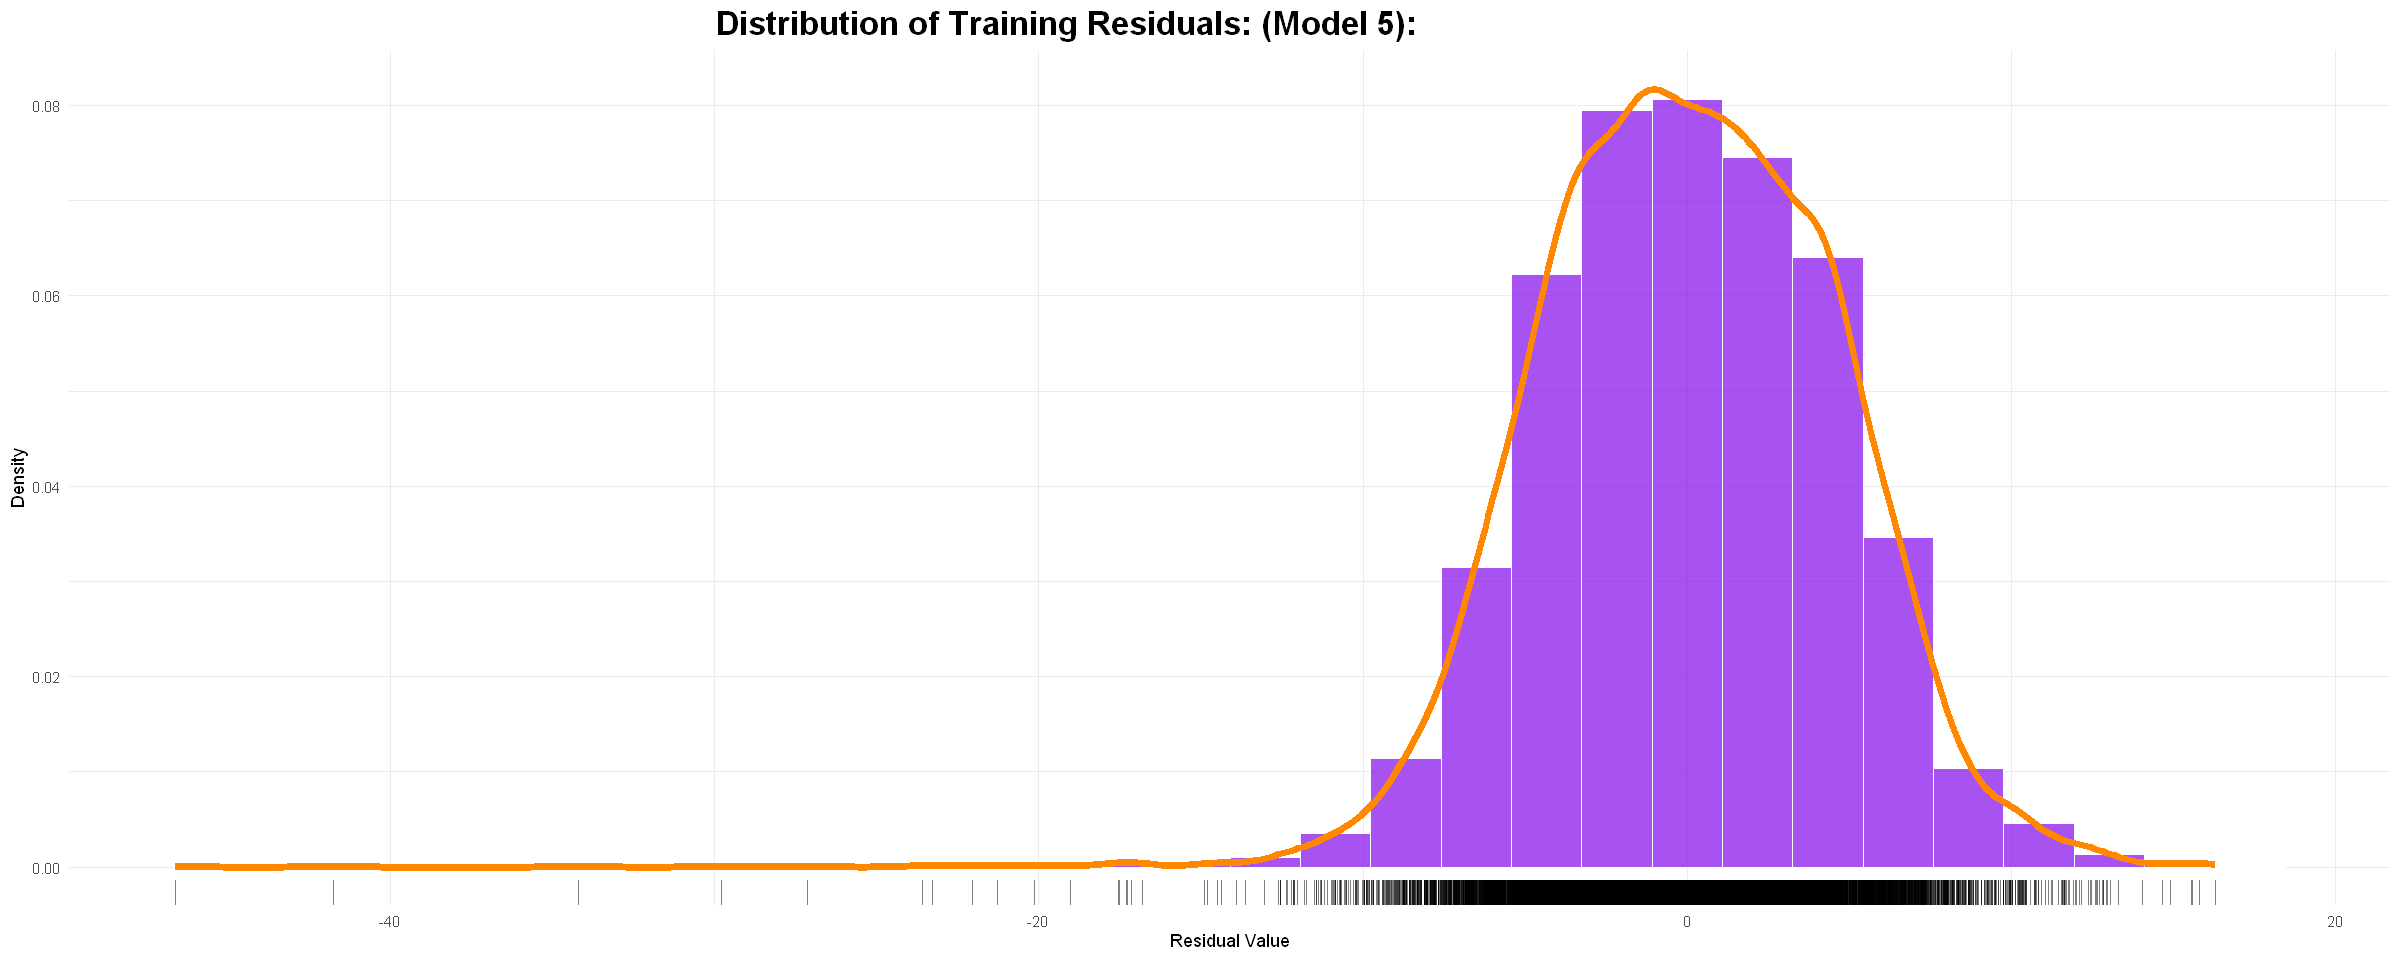

In [119]:
# distribution plot of training residuals: (Histogram + Density Curve + Rug Plot):

# Create a histogram of the training residuals
ggplot(data.frame(Residual = train_residuals), aes(x = Residual)) +
  geom_histogram(aes(y = ..density..), bins = 30, fill = "#8207ed", color = "white", alpha = 0.7) +
  geom_density(color = "#ff8800", linewidth = 2) +
  # add rug plot:
  geom_rug(sides = "b", color = "black", alpha = 0.5) +
  labs(title = "Distribution of Training Residuals: (Model 5):",
       x = "Residual Value",
       y = "Density") +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.4, face = "bold", size = 20),
    plot.subtitle = element_text(hjust = 0.5)
  )

In [120]:
# descriptive statistics of residuals: 

# Calculate skewness and kurtosis
skew <- skewness(train_residuals)
kurt <- kurtosis(train_residuals)

cat("Descriptive Statistics for Residuals:\n")
cat("Mean:", mean(train_residuals^2),"\n")
cat("Median:", median(train_residuals^2), "\n")
cat("Standard Deviation:", sd(train_residuals^2), "\n")
cat("Skewness:", skew, "(0 for normal distribution),\n")
cat("Excess Kurtosis:", kurt-3, "(0 for normal distribution)")

Descriptive Statistics for Residuals:
Mean: 20.90017 
Median: 10.21065 
Standard Deviation: 49.56946 
Skewness: -0.4860478 (0 for normal distribution),
Excess Kurtosis: 3.624235 (0 for normal distribution)

In [121]:
# Calculate proportion of residuals within different SD ranges
std_residuals <- (train_residuals^2 - mean(train_residuals^2)) / sd(train_residuals^2)
within_1sd <- mean(abs(std_residuals) <= 1) * 100
within_2sd <- mean(abs(std_residuals) <= 2) * 100
within_3sd <- mean(abs(std_residuals) <= 3) * 100

cat("\nProportion of Residuals within Standard Deviation Ranges:\n")
cat("Within 1 SD:", within_1sd, "% (Expected: 68.27%)\n")
cat("Within 2 SD:", within_2sd, "% (Expected: 95.45%)\n")
cat("Within 3 SD:", within_3sd, "% (Expected: 99.73%)")


Proportion of Residuals within Standard Deviation Ranges:
Within 1 SD: 95.06673 % (Expected: 68.27%)
Within 2 SD: 98.65047 % (Expected: 95.45%)
Within 3 SD: 99.50517 % (Expected: 99.73%)

#### **Actual vs. Predicted values:**

`geom_smooth()` using formula = 'y ~ x'


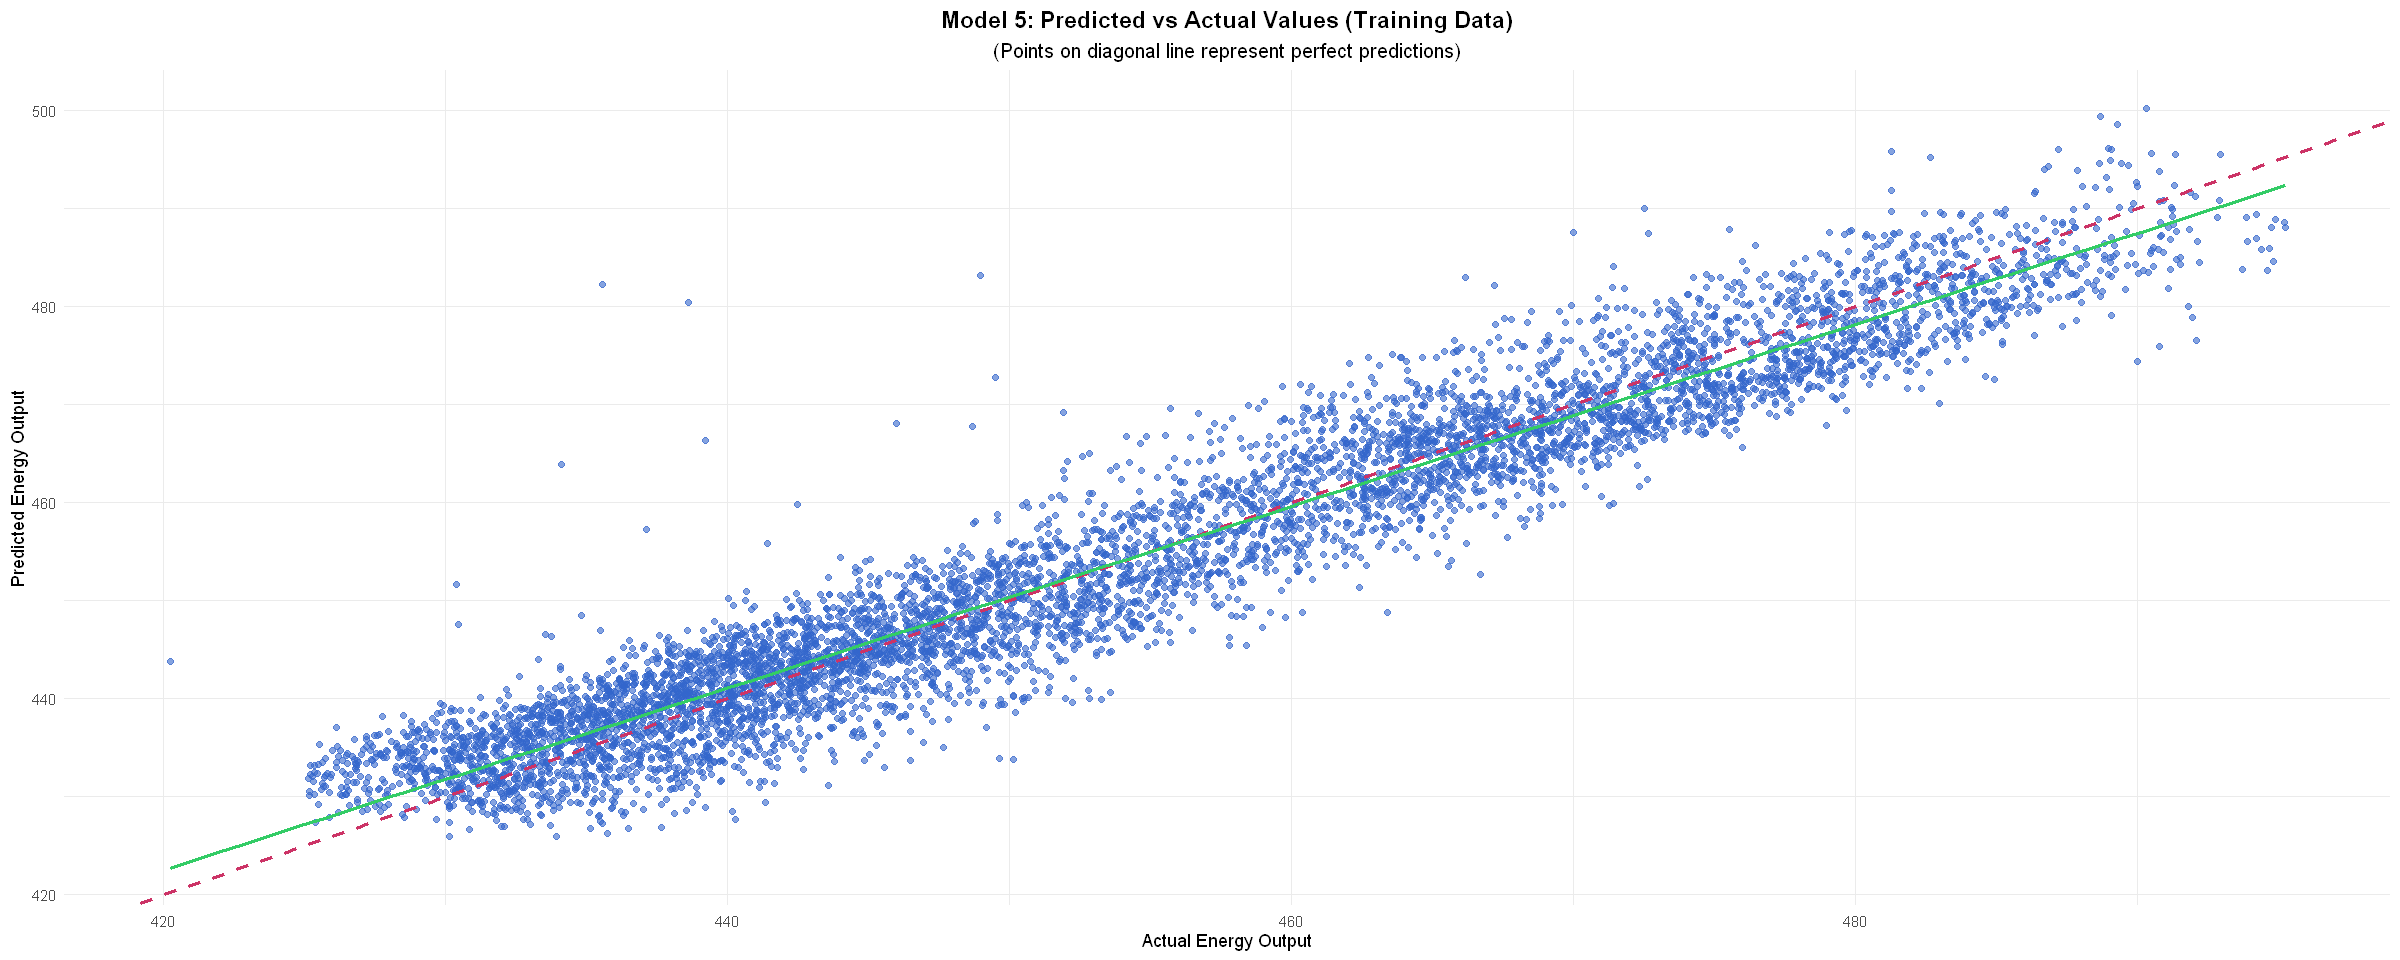

In [122]:
# Create a scatter plot comparing actual vs predicted values: 

# Calculate predicted values for training data
y_train_pred <- X_train %*% theta_train

# Create a dataframe for plotting
comparison_data <- data.frame(
  Actual = y_train,
  Predicted = as.vector(y_train_pred)
)

# Calculate R-squared for reference
train_r_squared <- 1 - sum((y_train - y_train_pred)^2) / sum((y_train - mean(y_train))^2)

# Create a scatter plot with actual values on x-axis and predicted on y-axis
ggplot(comparison_data, aes(x = Actual, y = Predicted)) +
  # Add points
  geom_point(color = "#3366CC", alpha = 0.6, size = 1.5) +
  
  # Add perfect prediction line (y = x)
  geom_abline(intercept = 0, slope = 1, color = "#CC3366", 
              linewidth = 1, linetype = "dashed") +
  
  # Add a smooth trend line to see the actual relationship
  geom_smooth(method = "lm", color = "#33CC66", se = FALSE, linewidth = 1) +
  
  # Add labels and title
  labs(title = "Model 5: Predicted vs Actual Values (Training Data)",
       subtitle = paste("(Points on diagonal line represent perfect predictions)"),
       x = "Actual Energy Output",
       y = "Predicted Energy Output") +
  
  # Use a clean theme
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold", size = 14),
    plot.subtitle = element_text(hjust = 0.5, size = 12),
    legend.position = "none"
  )

**95% Confidence Intervals for Model Predictions (Test Data):**

In [123]:
# Calculate the residual variance from the training data: 
# This estimates the inherent noise/variability in our data
n_train <- nrow(X_train)                # Number of training samples
p <- length(theta_train)               # Number of model parameters
residuals_train <- y_train - X_train %*% theta_train  # Training residuals
rss_train <- sum(residuals_train^2)     # Residual sum of squares
sigma_squared <- rss_train / (n_train - p)  # Estimated error variance

In [124]:
# Calculate the variance-covariance matrix of the parameters
# This matrix captures uncertainty in our parameter estimates
XtX_inv <- solve(t(X_train) %*% X_train)  # (X'X)^-1 matrix

In [125]:
# Calculate prediction variances for each training point
# The prediction variance combines parameter uncertainty with inherent noise
prediction_vars <- numeric(nrow(X_train))
for (i in 1:nrow(X_train)) {
  x_i <- X_train[i, ]  # Feature vector for training point i
  # Formula: Var(ŷ) = σ² * x_i' * (X'X)^-1 * x_i
  prediction_vars[i] <- sigma_squared * (t(x_i) %*% XtX_inv %*% x_i)
}

In [126]:
# Calculate the standard errors of the predictions
prediction_se <- sqrt(prediction_vars)  # Standard error = sqrt(variance)

In [127]:
# Calculate the critical t-value for 95% confidence
# We use t-distribution with (n_train - p) degrees of freedom
t_critical <- qt(0.975, n_train - p)  # 0.975 for 95% confidence (two-tailed)

In [128]:
# Calculate the confidence intervals
# CI = prediction ± t_critical * standard_error
y_train_pred <- X_train %*% theta_train  # Predicted values
lower_ci <- y_train_pred - t_critical * prediction_se  # Lower bound
upper_ci <- y_train_pred + t_critical * prediction_se  # Upper bound

In [129]:
# Create a data frame for plotting
# Sort by actual values for better visualization
ci_data <- data.frame(
  Index = 1:nrow(X_train),            # Index for x-axis
  Actual = y_train,                   # Actual values
  Predicted = y_train_pred,           # Predicted values
  Lower_CI = lower_ci,                # Lower confidence bound
  Upper_CI = upper_ci,                # Upper confidence bound
  CI_Width = upper_ci - lower_ci      # Width of confidence interval
)

In [130]:
# Sort data by actual values for better visualization
ci_data <- ci_data[order(ci_data$Actual), ]

# Print confidence interval statistics for reference
cat("Confidence interval statistics for training data:\n")
cat("Mean width:", mean(ci_data$CI_Width), "\n")
cat("Maximum width:", max(ci_data$CI_Width), "\n")
cat("Minimum width:", min(ci_data$CI_Width), "\n")
cat("Range of y values:", min(y_train), "to", max(y_train))

Confidence interval statistics for training data:
Mean width: 0.4227833 
Maximum width: 1.395781 
Minimum width: 0.2196116 
Range of y values: 420.26 to 495.24

In [131]:
head(ci_data) # check top rows of ci_data dataframe: 

,Index,Actual,Predicted,Lower_CI,Upper_CI,CI_Width
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4386,4386,420.26,443.8340,443.6209,444.0471,0.4262423
1647,1647,425.16,431.8764,431.6870,432.0658,0.3788813
1387,1387,425.17,430.5321,430.2981,430.7661,0.4680361
1154,1154,425.19,430.0867,429.8253,430.3482,0.5229447
5287,5287,425.20,433.2140,433.0047,433.4233,0.4186112
5862,5862,425.21,432.2304,432.0274,432.4334,0.4060607


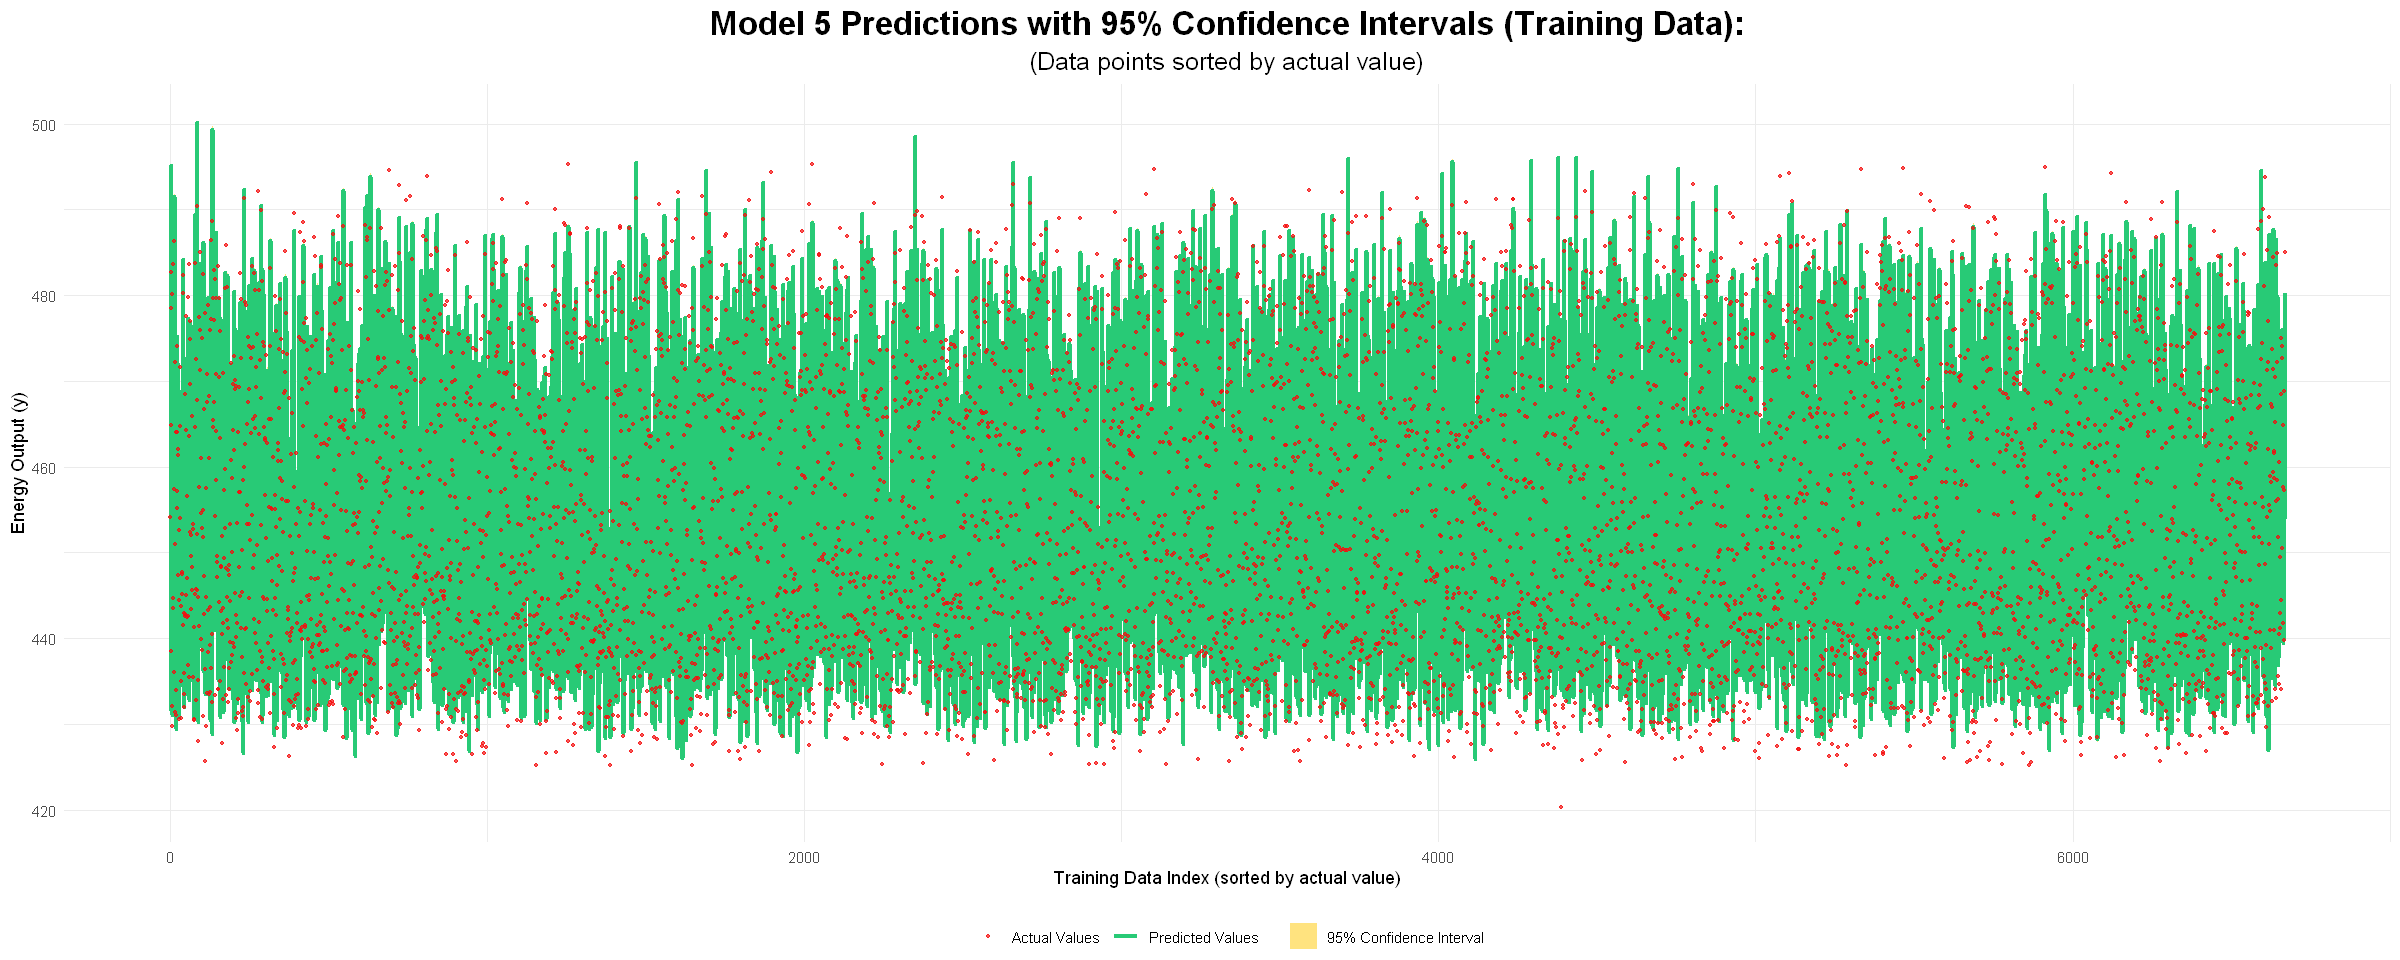

In [132]:
# Create the plot for predictions, confidence intervals, and actual values: 

prediction_plot <- ggplot(ci_data, aes(x = Index)) +
  # Add confidence interval ribbon
  # This shows the range where we expect the true value to fall with 95% probability
  geom_ribbon(aes(ymin = Lower_CI, ymax = Upper_CI, fill = "95% Confidence Interval"), 
              alpha = 0.5) +
  
  # Add predicted values as a line
  # This shows our model's best estimate for each training point
  geom_line(aes(y = Predicted, color = "Predicted Values"), 
            linewidth = 1.2) +
  
  # Add actual values as points
  # These show the true observed values we're trying to predict
  geom_point(aes(y = Actual, color = "Actual Values"), 
             size = 0.8, alpha = 0.7) +
  
  # Set custom colors for better visibility: 
  scale_color_manual(values = c("Predicted Values" = "#28ca76",  
                                "Actual Values" = "#f40f0f"), 
                     name = "") +
  scale_fill_manual(values = c("95% Confidence Interval" = "#ffc800"),  # Yellow
                    name = "") +
  
  # Add informative labels and title
  labs(title = "Model 5 Predictions with 95% Confidence Intervals (Training Data):",
       subtitle = "(Data points sorted by actual value)",
       x = "Training Data Index (sorted by actual value)",
       y = "Energy Output (y)") +
  
  # Add theme with legend at the bottom
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold", size= 20),
    plot.subtitle = element_text(hjust = 0.5, size= 15),
    legend.position = "bottom",
    legend.box = "horizontal",
    legend.margin = margin(t = 10)
  ) +
  
  # Combine the legends for better organization
  guides(color = guide_legend(order = 1),
         fill = guide_legend(order = 2))

# Display the plot
prediction_plot

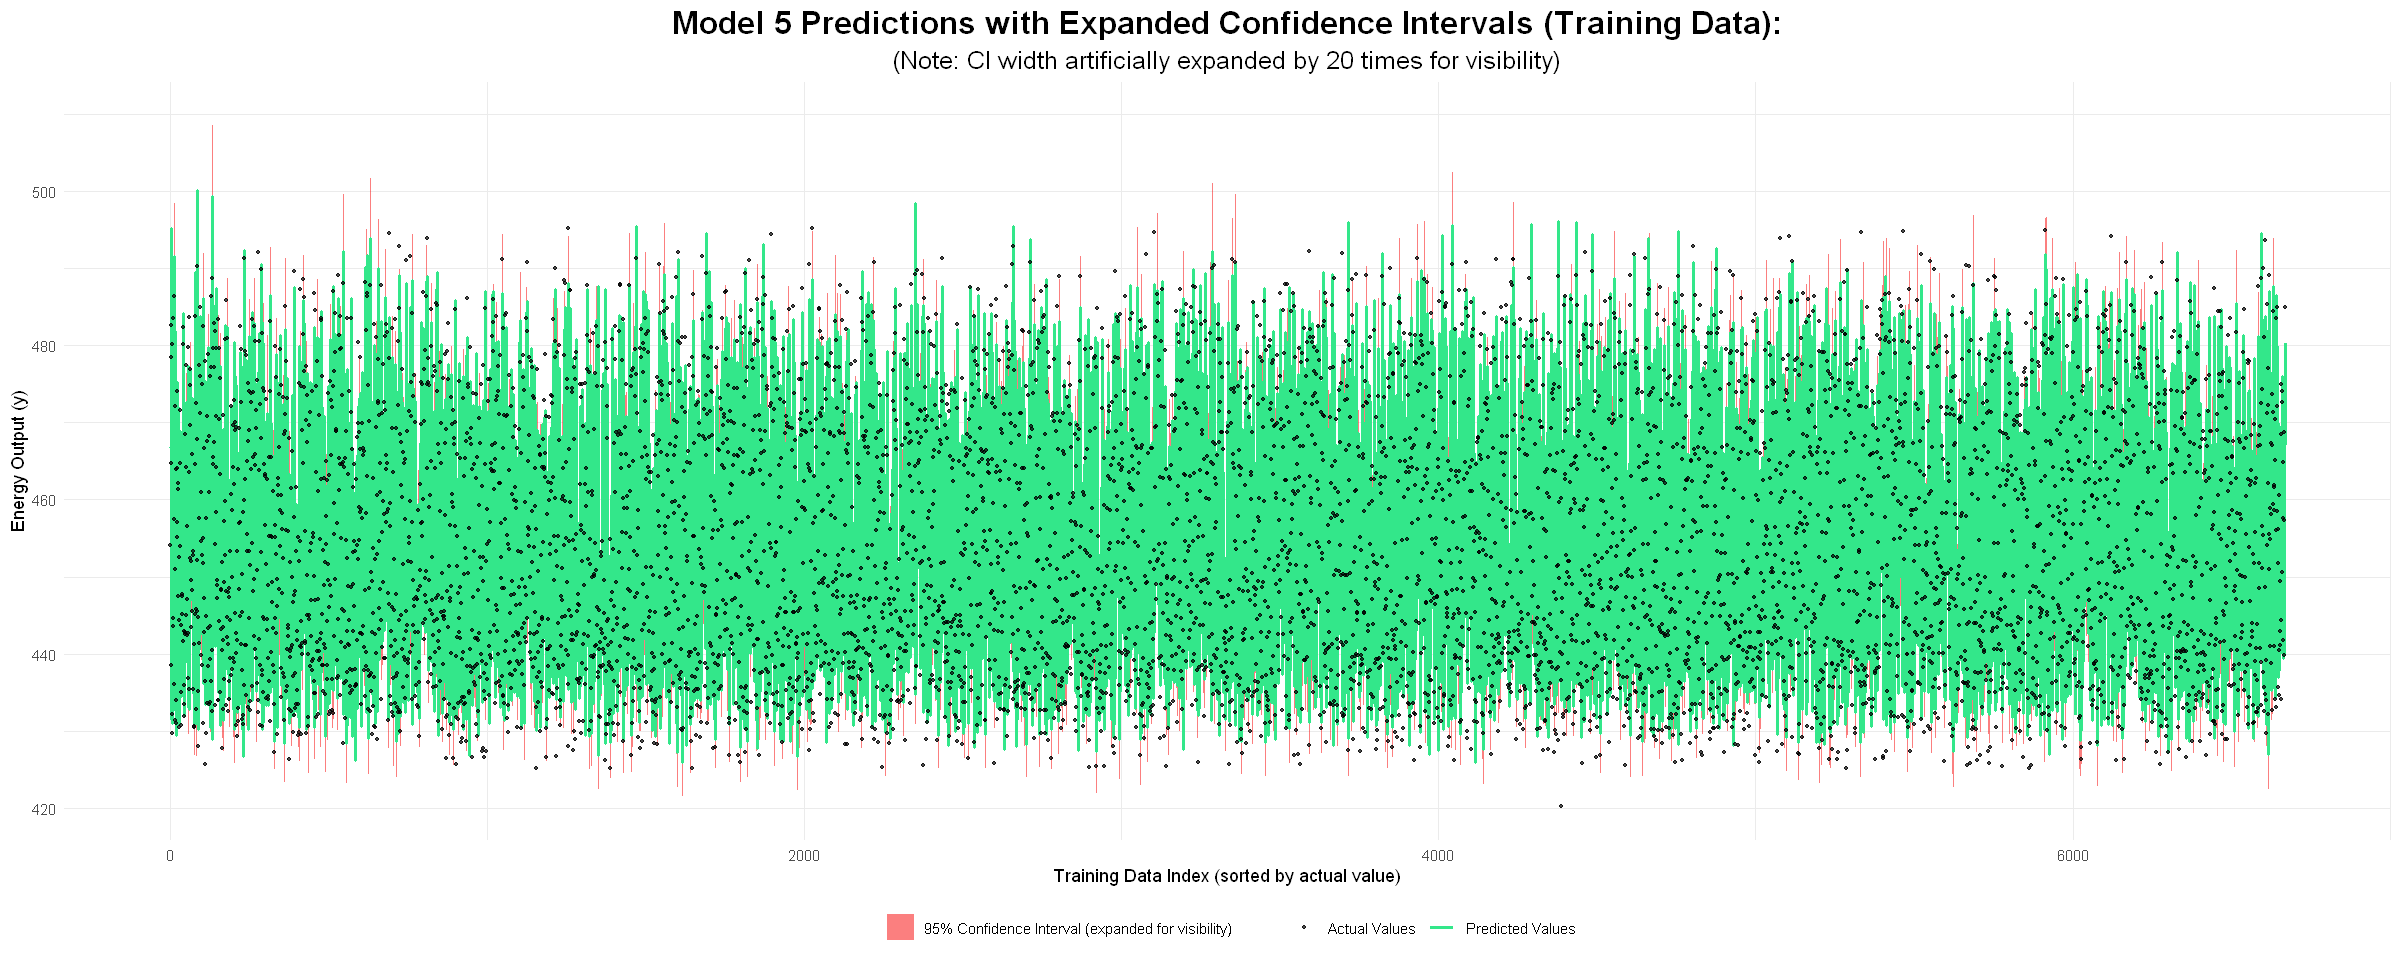

In [133]:
# confidence intervals are too narrow to see, so create an expanded version
# by artificially widening the intervals by a factor 20 for better visualization
expansion_factor <- 20

expanded_ci_data <- ci_data
expanded_ci_data$Lower_CI_Expanded <- ci_data$Predicted - 
  (ci_data$Predicted - ci_data$Lower_CI) * expansion_factor
expanded_ci_data$Upper_CI_Expanded <- expanded_ci_data$Predicted + 
  (ci_data$Upper_CI - ci_data$Predicted) * expansion_factor

expanded_plot <- ggplot(expanded_ci_data, aes(x = Index)) +
  # Add expanded confidence interval ribbon
  geom_ribbon(aes(ymin = Lower_CI_Expanded, ymax = Upper_CI_Expanded, 
                 fill = "95% Confidence Interval (expanded for visibility)"), 
              alpha = 0.5) +
  
  # Add predicted values line
  geom_line(aes(y = Predicted, color = "Predicted Values"), 
            linewidth = 1) +
  
  # Add actual values points
  geom_point(aes(y = Actual, color = "Actual Values"), 
             size = 0.8, alpha = 0.7) +
  
  # Set custom colors
  scale_color_manual(values = c("Predicted Values" = "#33e78a", 
                                "Actual Values" = "black"),
                     name = "") +
  scale_fill_manual(values = c("95% Confidence Interval (expanded for visibility)" = "#f80000"),
                    name = "") +
  
  # Add labels and mention that it is expended version of plot above and use for understanding purpose only
  labs(title = "Model 5 Predictions with Expanded Confidence Intervals (Training Data):",
       subtitle = paste("(Note: CI width artificially expanded by", expansion_factor, "times for visibility)"),
       x = "Training Data Index (sorted by actual value)",
       y = "Energy Output (y)") +
  
  # Add theme
  theme_minimal() + 
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold", size = 19),
    plot.subtitle = element_text(hjust = 0.5, size= 15),
    legend.position = "bottom",
    legend.box = "horizontal"
  )

# Display the expanded plot
print(expanded_plot)

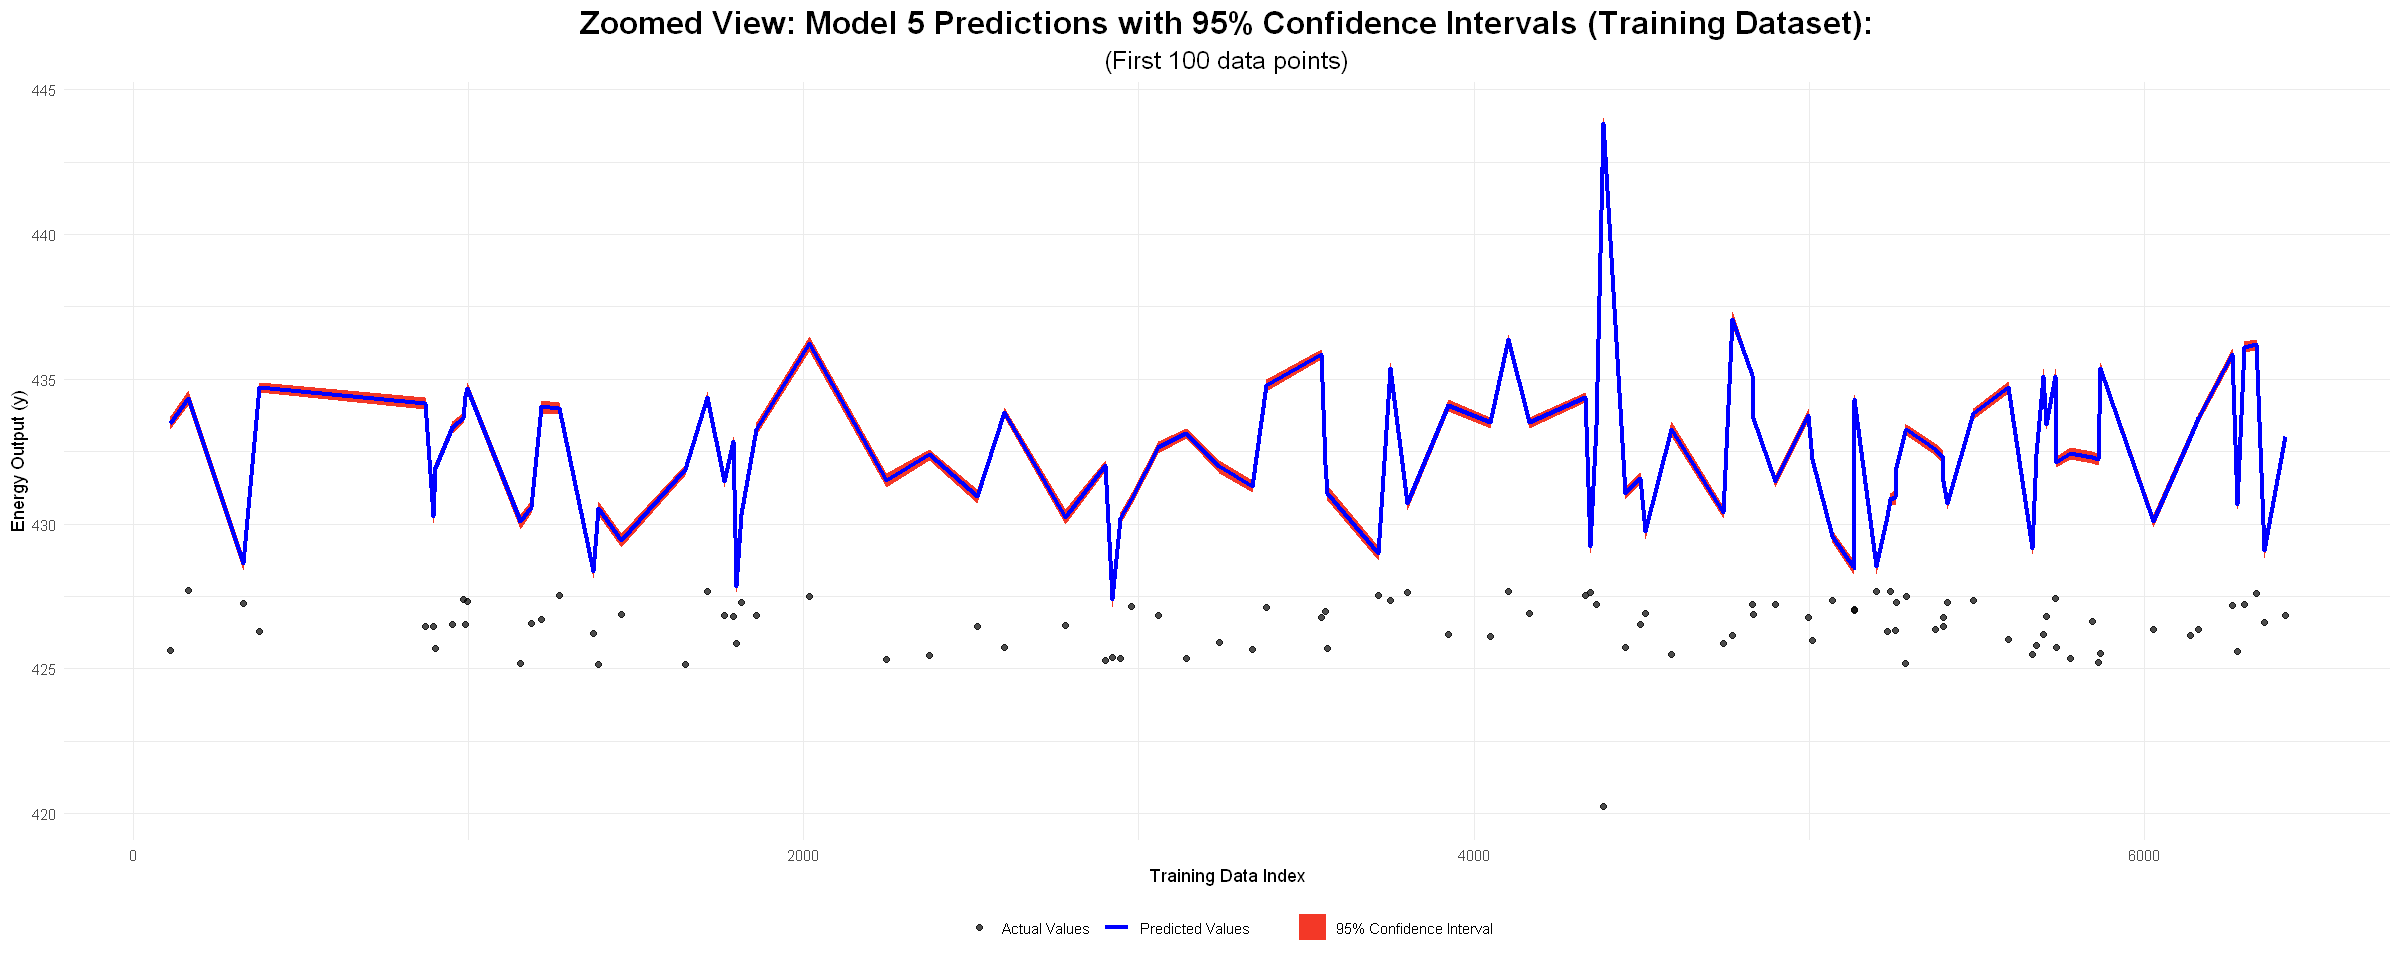

In [134]:
# Create a zoom-in version of the plot to better show the confidence intervals
# Select a small subset of the data (first 100 points) 

zoom_data <- ci_data[1:100, ]

zoom_plot <- ggplot(zoom_data, aes(x = Index)) +
  # Add confidence interval ribbon
  geom_ribbon(aes(ymin = Lower_CI, ymax = Upper_CI, fill = "95% Confidence Interval"), 
              alpha = 0.9) +
              
  # Add predicted values line
  geom_line(aes(y = Predicted, color = "Predicted Values"), 
            linewidth = 1.2) +
            
  # Add actual values points
  geom_point(aes(y = Actual, color = "Actual Values"), 
             size = 1.5, alpha = 0.7) +
             
  # Set custom colors
  scale_color_manual(values = c("Predicted Values" = "blue", 
                                "Actual Values" = "black"),
                     name = "") +
  scale_fill_manual(values = c("95% Confidence Interval" = "#f2220f"),
                    name = "") +
                    
  # Add labels
  labs(title = "Zoomed View: Model 5 Predictions with 95% Confidence Intervals (Training Dataset):",
       subtitle = "(First 100 data points)",
       x = "Training Data Index",
       y = "Energy Output (y)") +
       
  # Add theme
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold", size= 19),
    plot.subtitle = element_text(hjust = 0.5, size= 15),
    legend.position = "bottom"
  )

# Display the zoomed plot
print(zoom_plot)

**Confidence Intervals and Error Bars for Training Data:**

In [135]:
# Calculate the residual variance from the training data
n_train <- nrow(X_train)                # Number of training samples
p <- length(theta_train)               # Number of model parameters (including intercept)
residuals_train <- y_train - X_train %*% theta_train  # Calculate residuals
rss_train <- sum(residuals_train^2)     # Residual sum of squares
sigma_squared <- rss_train / (n_train - p)  # Estimated error variance

# Calculate the variance-covariance matrix of the parameters
# This captures uncertainty in our parameter estimates
XtX_inv <- solve(t(X_train) %*% X_train)  # (X'X)^-1 matrix

# Calculate prediction variances for each training point
# For each prediction, we need to calculate its variance
prediction_vars <- numeric(nrow(X_train))
for (i in 1:nrow(X_train)) {
  x_i <- X_train[i, ]  # Feature vector for training point i
  # Formula: Var(ŷ) = σ² * x_i' * (X'X)^-1 * x_i
  prediction_vars[i] <- sigma_squared * (t(x_i) %*% XtX_inv %*% x_i)
}

# Calculate the standard errors of the predictions
prediction_se <- sqrt(prediction_vars)  # Standard error = sqrt(variance)

# Calculate the critical t-value for 95% confidence
# We use t-distribution with (n_train - p) degrees of freedom
t_critical <- qt(0.975, n_train - p)  # 0.975 for 95% confidence (two-tailed)

# Calculate the confidence intervals
y_train_pred <- X_train %*% theta_train  # Predicted values
margin_of_error <- t_critical * prediction_se  # Margin of error for 95% CI
lower_ci <- y_train_pred - margin_of_error  # Lower bound
upper_ci <- y_train_pred + margin_of_error  # Upper bound

# Create a data frame for plotting
# For clarity and computing efficiency, use a subset of the data (e.g., every 50th point)
# Using all points would make the error bars too crowded and also, takes over a minute to create
# a single plot: 

sample_interval <- 50
sample_indices <- seq(1, nrow(X_train), by = sample_interval)

plot_data <- data.frame(
  Index = sample_indices,
  Actual = y_train[sample_indices],
  Predicted = y_train_pred[sample_indices],
  Lower_CI = lower_ci[sample_indices],
  Upper_CI = upper_ci[sample_indices],
  SE = prediction_se[sample_indices]
)

# Create a full data frame for ribbon plotting (all points)
full_data <- data.frame(
  Index = 1:nrow(X_train),
  Actual = y_train,
  Predicted = y_train_pred,
  Lower_CI = lower_ci,
  Upper_CI = upper_ci
)

# Print confidence interval statistics for reference
cat("Confidence interval statistics for training data:\n")
cat("Mean margin of error:", mean(margin_of_error), "\n")
cat("Maximum margin of error:", max(margin_of_error), "\n")
cat("Minimum margin of error:", min(margin_of_error), "\n")

Confidence interval statistics for training data:
Mean margin of error: 0.2113917 
Maximum margin of error: 0.6978904 
Minimum margin of error: 0.1098058 


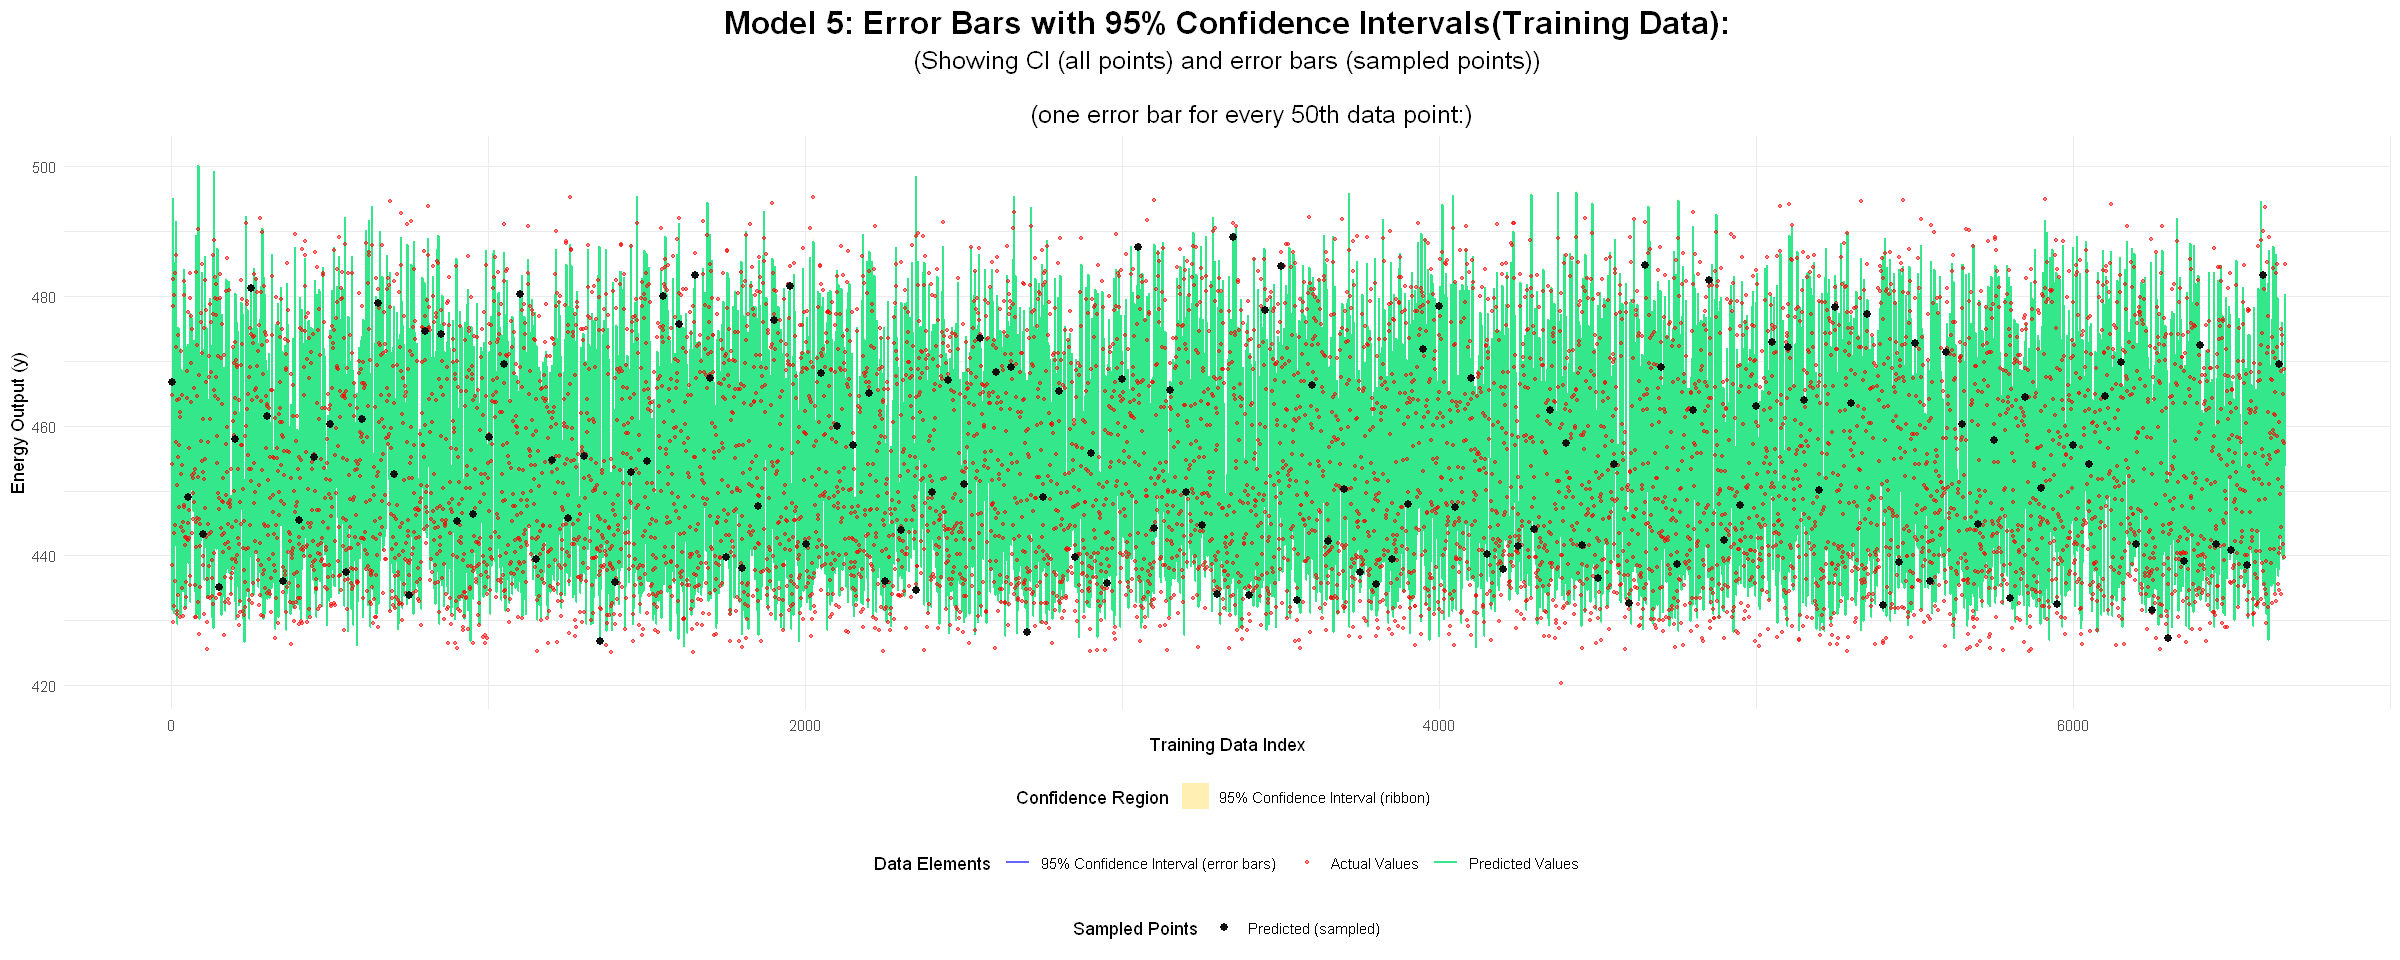

In [136]:
# Create plot with:
# - Confidence interval ribbon (for all points)
# - Error bars (for sampled points)
# - Predicted values line
# - Actual values points

combined_plot <- ggplot() +
  # Add confidence interval ribbon for all points
  geom_ribbon(data = full_data, 
              aes(x = Index, ymin = Lower_CI, ymax = Upper_CI, 
                  fill = "95% Confidence Interval (ribbon)"), 
              alpha = 0.3) +
  
  # Add predicted values line for all points
  geom_line(data = full_data, 
            aes(x = Index, y = Predicted, color = "Predicted Values"), 
            linewidth = 0.8) +
  
  # Add actual values points for all points: 
  geom_point(data = full_data, 
             aes(x = Index, y = Actual, color = "Actual Values"), 
             size = 0.7, alpha = 0.5) +
  
  # Add error bars for sampled points
  geom_errorbar(data = plot_data, 
                aes(x = Index, ymin = Lower_CI, ymax = Upper_CI, 
                    color = "95% Confidence Interval (error bars)"),
                width = 10, linewidth = 0.7, alpha = 0.7) +
  
  # Add predicted values points for sampled points
  geom_point(data = plot_data, 
             aes(x = Index, y = Predicted, shape = "Predicted (sampled)"), 
             color = "#0f1110", size = 2) +
  
  # Set custom colors and shapes
  scale_color_manual(values = c("Predicted Values" = "#33e78a",
                                "Actual Values" = "#ff0000",
                                "95% Confidence Interval (error bars)" = "#2323f4"),
                     name = "Data Elements") +
  scale_fill_manual(values = c("95% Confidence Interval (ribbon)" = "#ffc800"),
                    name = "Confidence Region") +
  scale_shape_manual(values = c("Predicted (sampled)" = 19),
                     name = "Sampled Points") +
  
  # Add informative labels and title
  labs(title = "Model 5: Error Bars with 95% Confidence Intervals(Training Data):",
       subtitle = "(Showing CI (all points) and error bars (sampled points))\n
       (one error bar for every 50th data point:)",
       x = "Training Data Index",
       y = "Energy Output (y)") +
  
  # Add theme with legend at the bottom
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold", size = 19),
    plot.subtitle = element_text(hjust = 0.5, size = 15),
    legend.position = "bottom",
    legend.box = "vertical"
  )

# Display the combined plot
print(combined_plot)

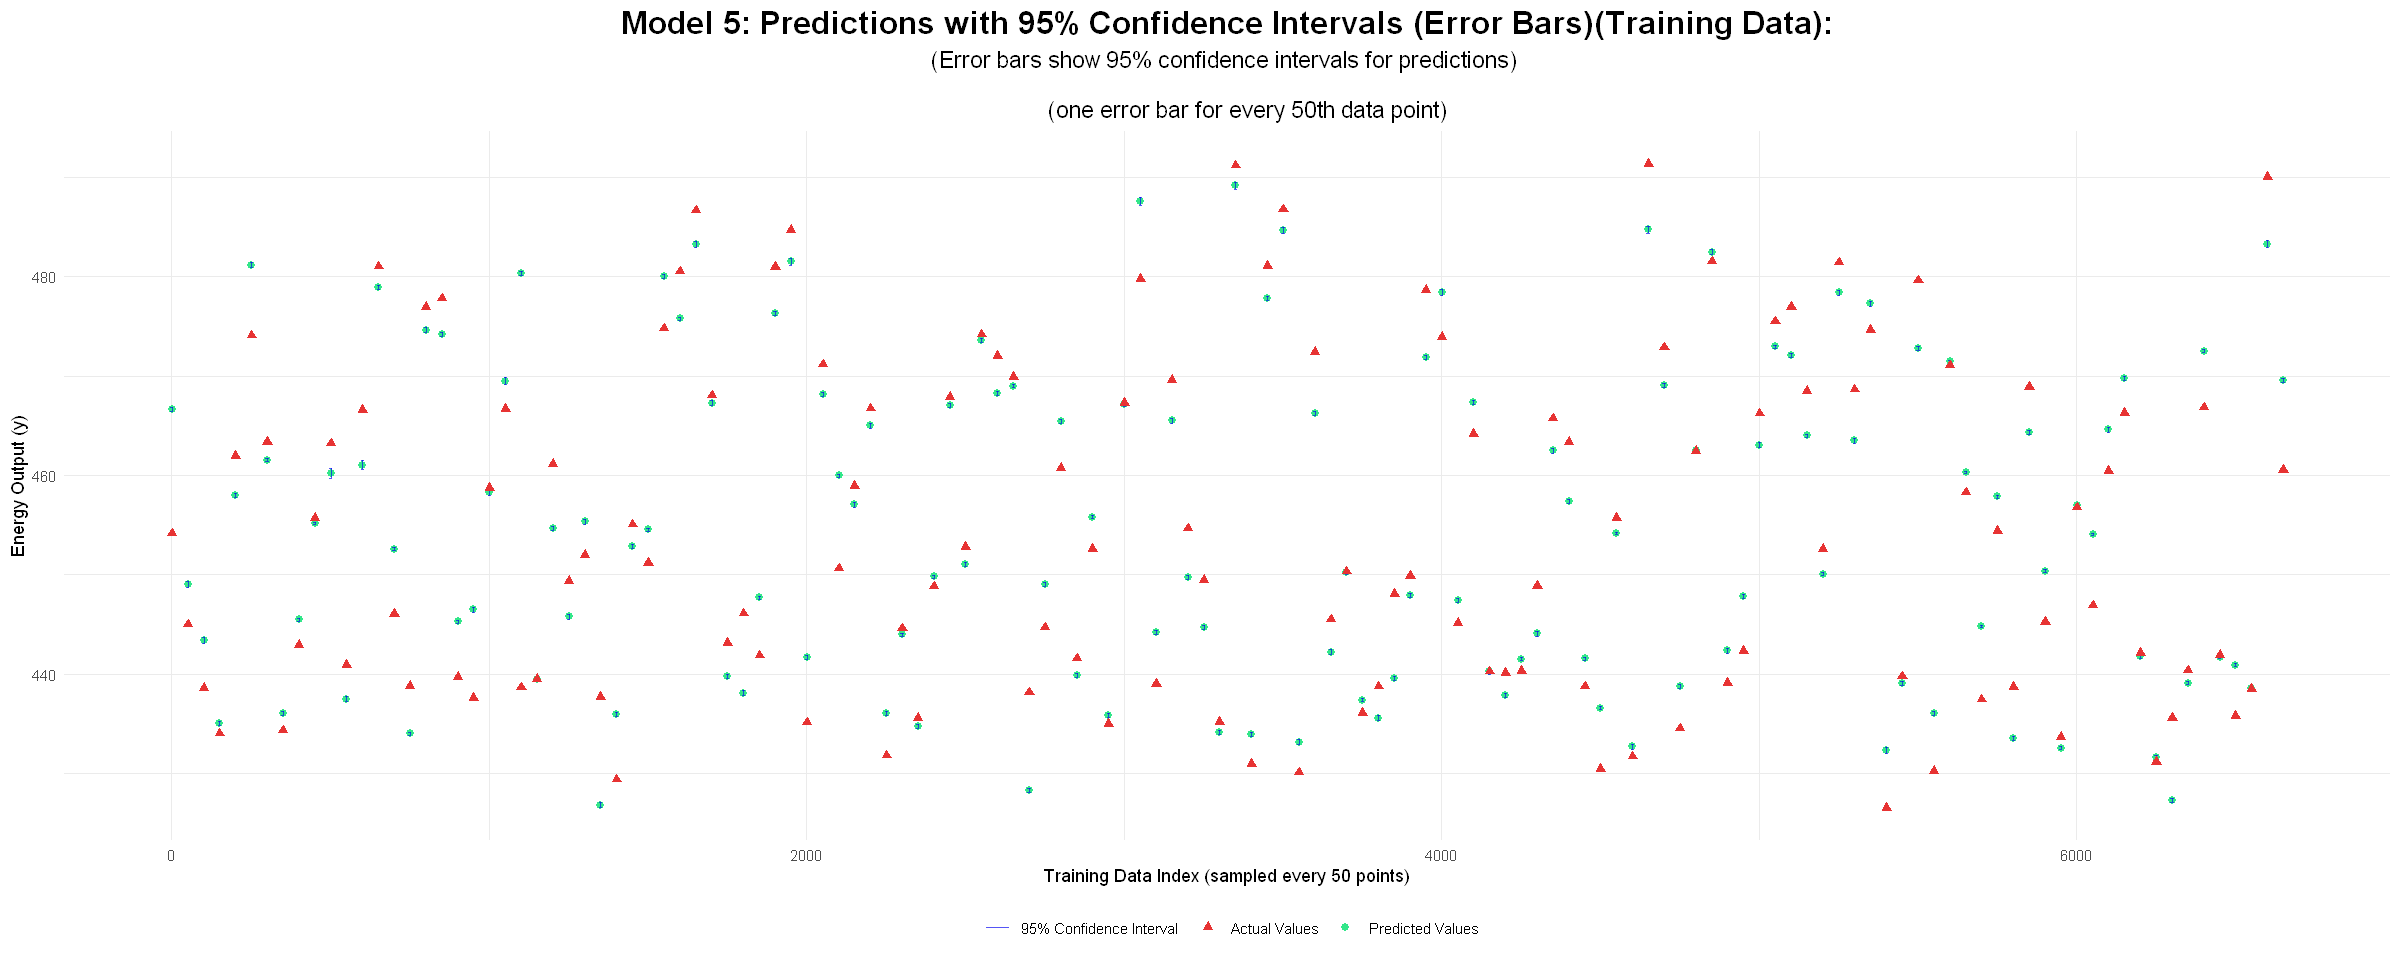

In [137]:
# Create error bar plot

errorbar_plot <- ggplot(plot_data, aes(x = Index)) +
  # Add predicted values as points
  geom_point(aes(y = Predicted, color = "Predicted Values"), 
             size = 2) +
  
  # Add error bars for 95% confidence intervals
  geom_errorbar(aes(ymin = Lower_CI, ymax = Upper_CI, color = "95% Confidence Interval"),
                width = 10, linewidth = 0.5, alpha = 0.7) +
  
  # Add actual values as different points
  geom_point(aes(y = Actual, color = "Actual Values"), 
             size = 2, shape = 17) +  # Using triangle shape for actual values
  
  # Set custom colors
  scale_color_manual(values = c("Predicted Values" = "#33e78a",
                                "Actual Values" = "#e73333",
                                "95% Confidence Interval" = "#0b0bf1"),
                     name = "") +
  
  # Add informative labels and title
  labs(title = "Model 5: Predictions with 95% Confidence Intervals (Error Bars)(Training Data):",
       subtitle = "(Error bars show 95% confidence intervals for predictions) \n
       (one error bar for every 50th data point)",
       x = "Training Data Index (sampled every 50 points)",
       y = "Energy Output (y)") +
  
  # Add theme with legend at the bottom
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold", size= 19),
    plot.subtitle = element_text(hjust = 0.5, size= 14),
    legend.position = "bottom",
    legend.box = "horizontal"
  )

# Display the error bar plot
print(errorbar_plot)

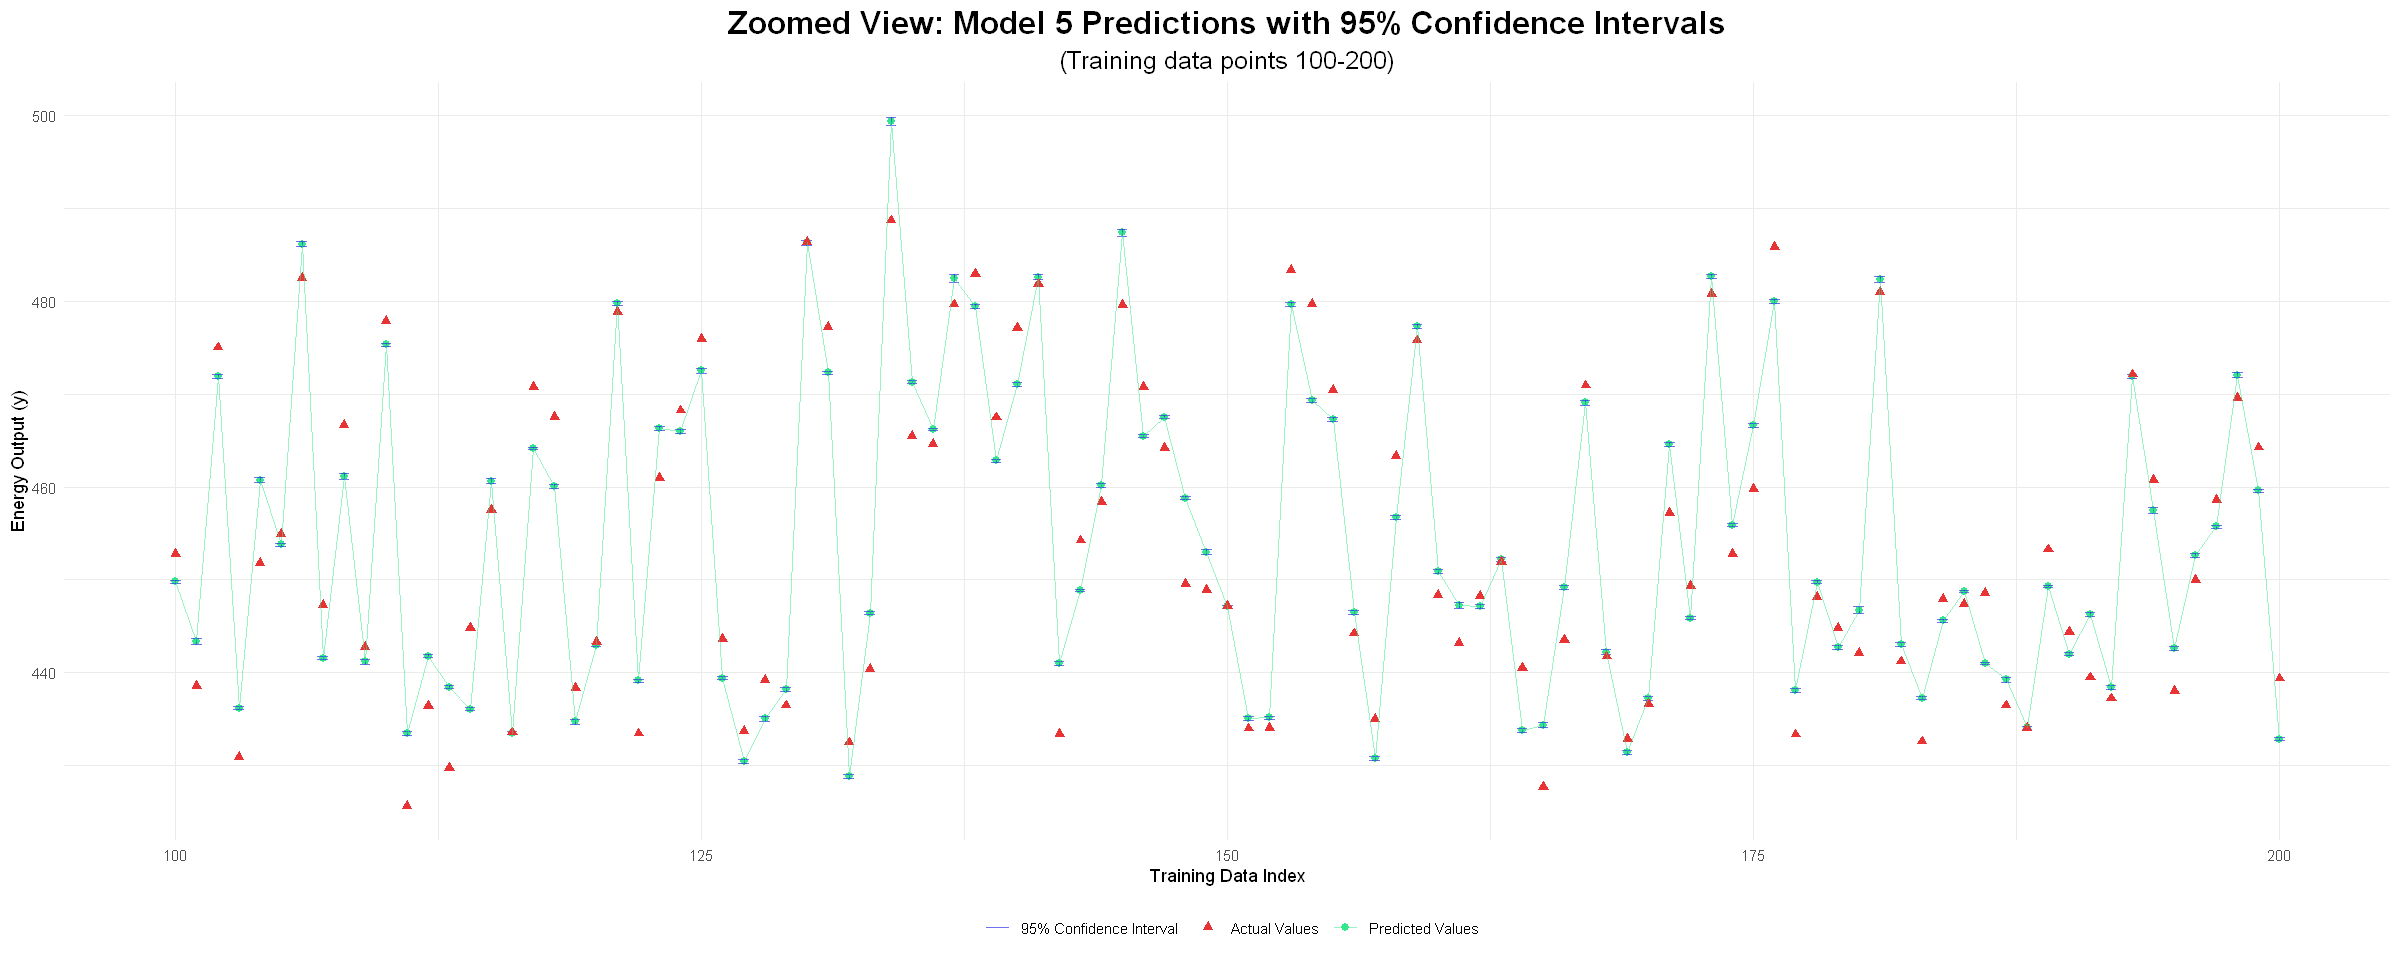

In [138]:
# Create a zoomed-in version with more dense sampling for better visualization
# Select a small range of data points (e.g., points 100-200)
zoom_range <- 100:200
zoom_data <- data.frame(
  Index = zoom_range,
  Actual = y_train[zoom_range],
  Predicted = y_train_pred[zoom_range],
  Lower_CI = lower_ci[zoom_range],
  Upper_CI = upper_ci[zoom_range]
)

zoom_errorbar_plot <- ggplot(zoom_data, aes(x = Index)) +
  # Add predicted values as points
  geom_point(aes(y = Predicted, color = "Predicted Values"), 
             size = 2) +
  
  # Add error bars for 95% confidence intervals
  geom_errorbar(aes(ymin = Lower_CI, ymax = Upper_CI, color = "95% Confidence Interval"),
                width = 0.5, linewidth = 0.5, alpha = 0.7) +
  
  # Add actual values as different points
  geom_point(aes(y = Actual, color = "Actual Values"), 
             size = 2, shape = 17) +
  
  # Connect predicted points with a line for clarity
  geom_line(aes(y = Predicted, color = "Predicted Values"), 
            linewidth = 0.5, alpha = 0.5) +
  
  # Set custom colors
  scale_color_manual(values = c("Predicted Values" = "#33e78a",
                                "Actual Values" = "#e73333",
                                "95% Confidence Interval" = "#3333e7"),
                     name = "") +
  
  # Add informative labels and title
  labs(title = "Zoomed View: Model 5 Predictions with 95% Confidence Intervals",
       subtitle = "(Training data points 100-200)",
       x = "Training Data Index",
       y = "Energy Output (y)") +
  
  # Add theme
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold", size= 19),
    plot.subtitle = element_text(hjust = 0.5, size= 15),
    legend.position = "bottom"
  )
  
# Display the zoomed plot
print(zoom_errorbar_plot)

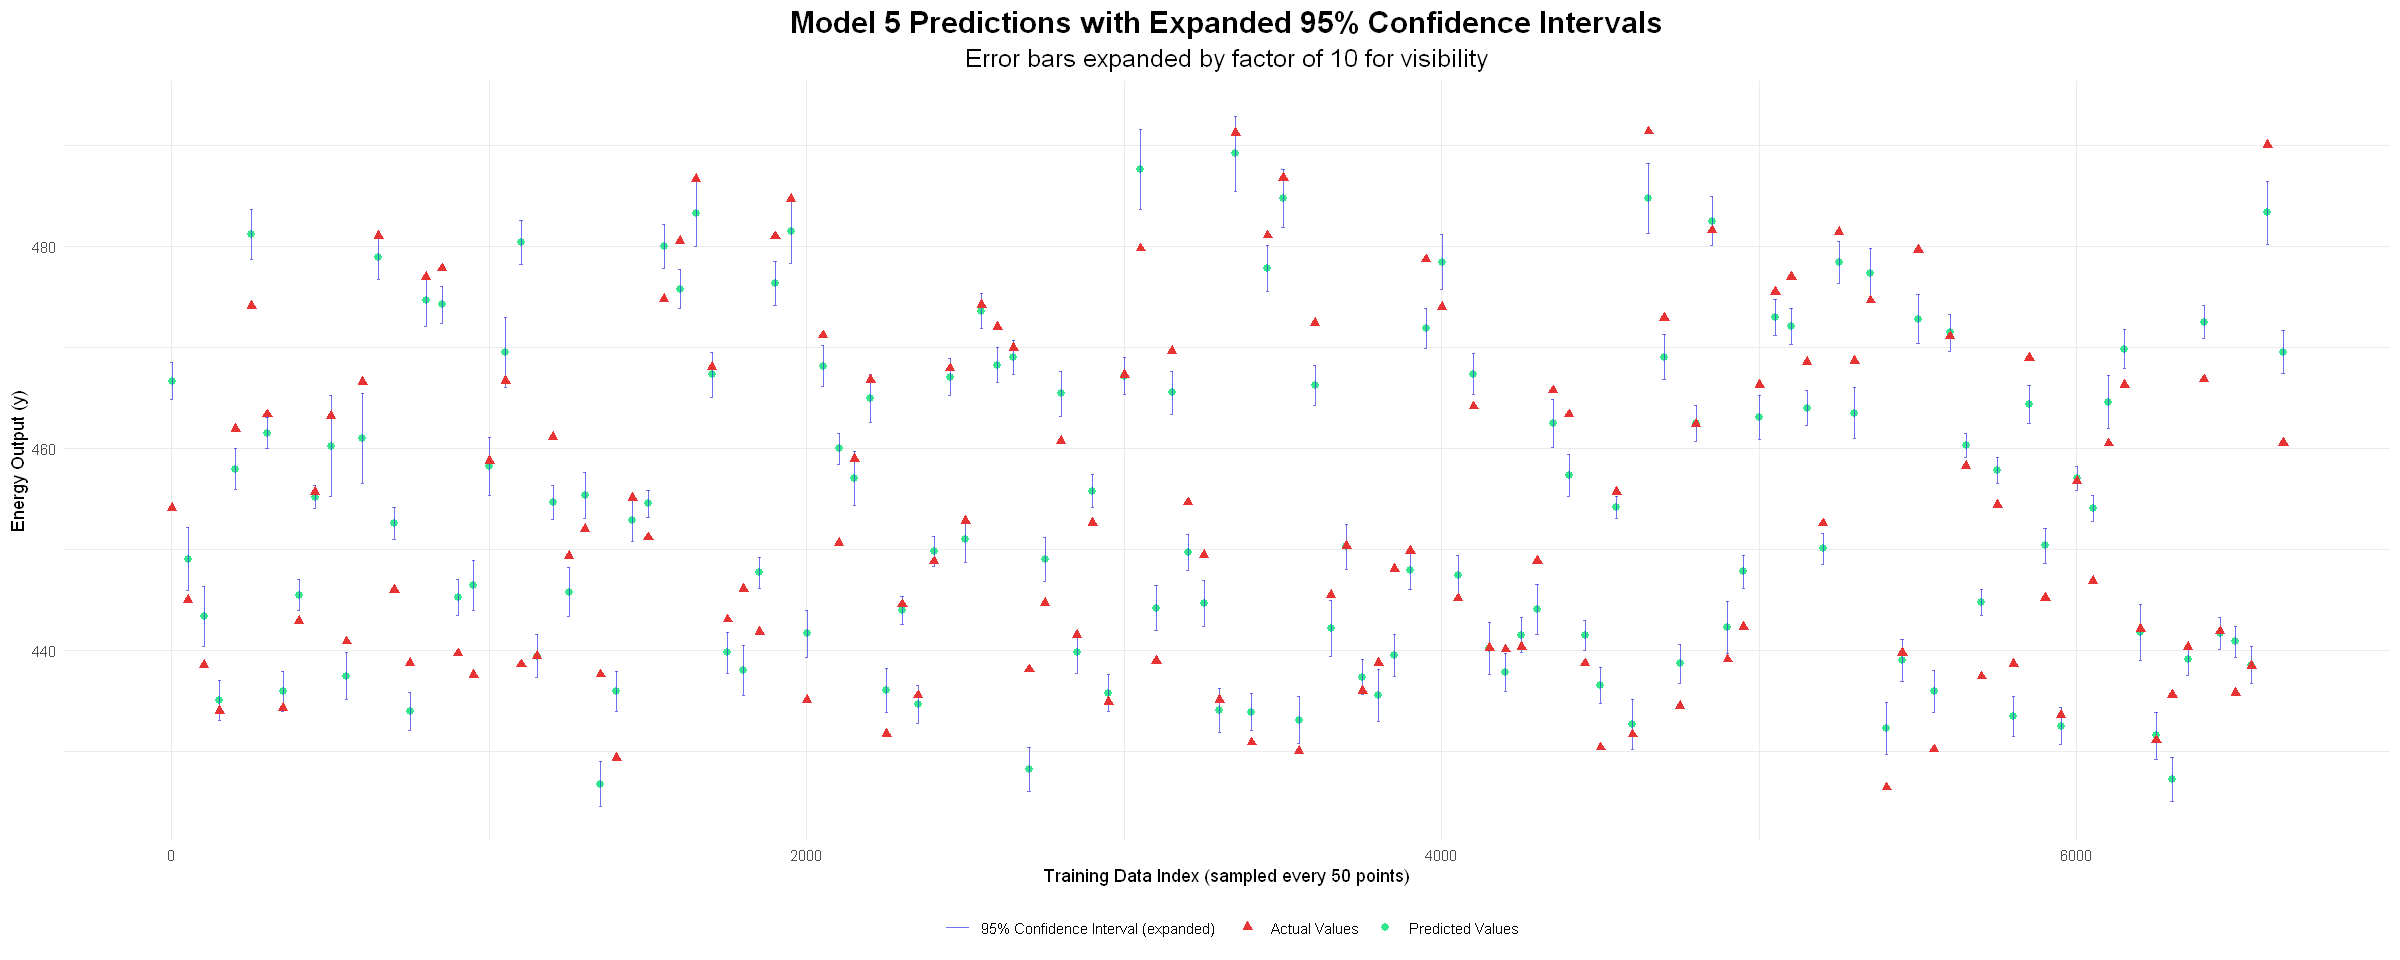

In [139]:
# Create a plot with expanded error bars for better visibility
# This is useful if the confidence intervals are very narrow
expansion_factor <- 10  # Adjust as needed

expanded_data <- plot_data
expanded_data$Lower_CI_Expanded <- expanded_data$Predicted - 
  (expanded_data$Predicted - expanded_data$Lower_CI) * expansion_factor
expanded_data$Upper_CI_Expanded <- expanded_data$Predicted + 
  (expanded_data$Upper_CI - expanded_data$Predicted) * expansion_factor

expanded_errorbar_plot <- ggplot(expanded_data, aes(x = Index)) +
  # Add predicted values as points
  geom_point(aes(y = Predicted, color = "Predicted Values"), 
             size = 2) +
  
  # Add expanded error bars
  geom_errorbar(aes(ymin = Lower_CI_Expanded, ymax = Upper_CI_Expanded, 
                    color = "95% Confidence Interval (expanded)"),
                width = 10, linewidth = 0.5, alpha = 0.7) +
  
  # Add actual values as different points
  geom_point(aes(y = Actual, color = "Actual Values"), 
             size = 2, shape = 17) +
  
  # Set custom colors
  scale_color_manual(values = c("Predicted Values" = "#33e78a",
                                "Actual Values" = "#e73333",
                                "95% Confidence Interval (expanded)" = "#3333e7"),
                     name = "") +
  
  # Add informative labels and title
  labs(title = "Model 5 Predictions with Expanded 95% Confidence Intervals",
       subtitle = paste("Error bars expanded by factor of", expansion_factor, "for visibility"),
       x = "Training Data Index (sampled every 50 points)",
       y = "Energy Output (y)") +
  
  # Add theme
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold", size = 18),
    plot.subtitle = element_text(hjust = 0.5, size= 15),
    legend.position = "bottom"
  )

# Display the expanded plot
print(expanded_errorbar_plot)

### **2.7.2: Model Evaluation on Testing Data:**

In [140]:
# Compute model's predictions on the testing data:
# Here, use the matrix multiplication to get the predicted values:
# y_pred = X_test * theta_train 
# where X_test is the design matrix for the testing data and 
# theta_train are the estimated parameters from the training data.
y_pred <- X_test %*% theta_train

In [141]:
head(y_pred) # See first few predicted values

478.3338
484.8645
435.1927
434.4927
458.9381
450.5544


In [142]:
head(y_test) # first few actual values from out test dataset

[1] 480.48 484.31 435.29 426.25 461.71 448.56

Now, lets plot the distribution of `y_pred` and `y_test` on the testing dataset.

In [143]:
# Create a data frame with both actual and predicted values: 

comparison_df <- data.frame(
  Value = c(y_test, y_pred),
  Type = factor(c(rep("Actual", length(y_test)), rep("Predicted", length(y_pred))))
)
dim(comparison_df)

[1] 5716    2

In [144]:
# Create a data frame with both actual and predicted values

comparison_df <- data.frame(
  Value = c(y_test, y_pred),
  Type = factor(c(rep("Actual", length(y_test)), rep("Predicted", length(y_pred))))
)

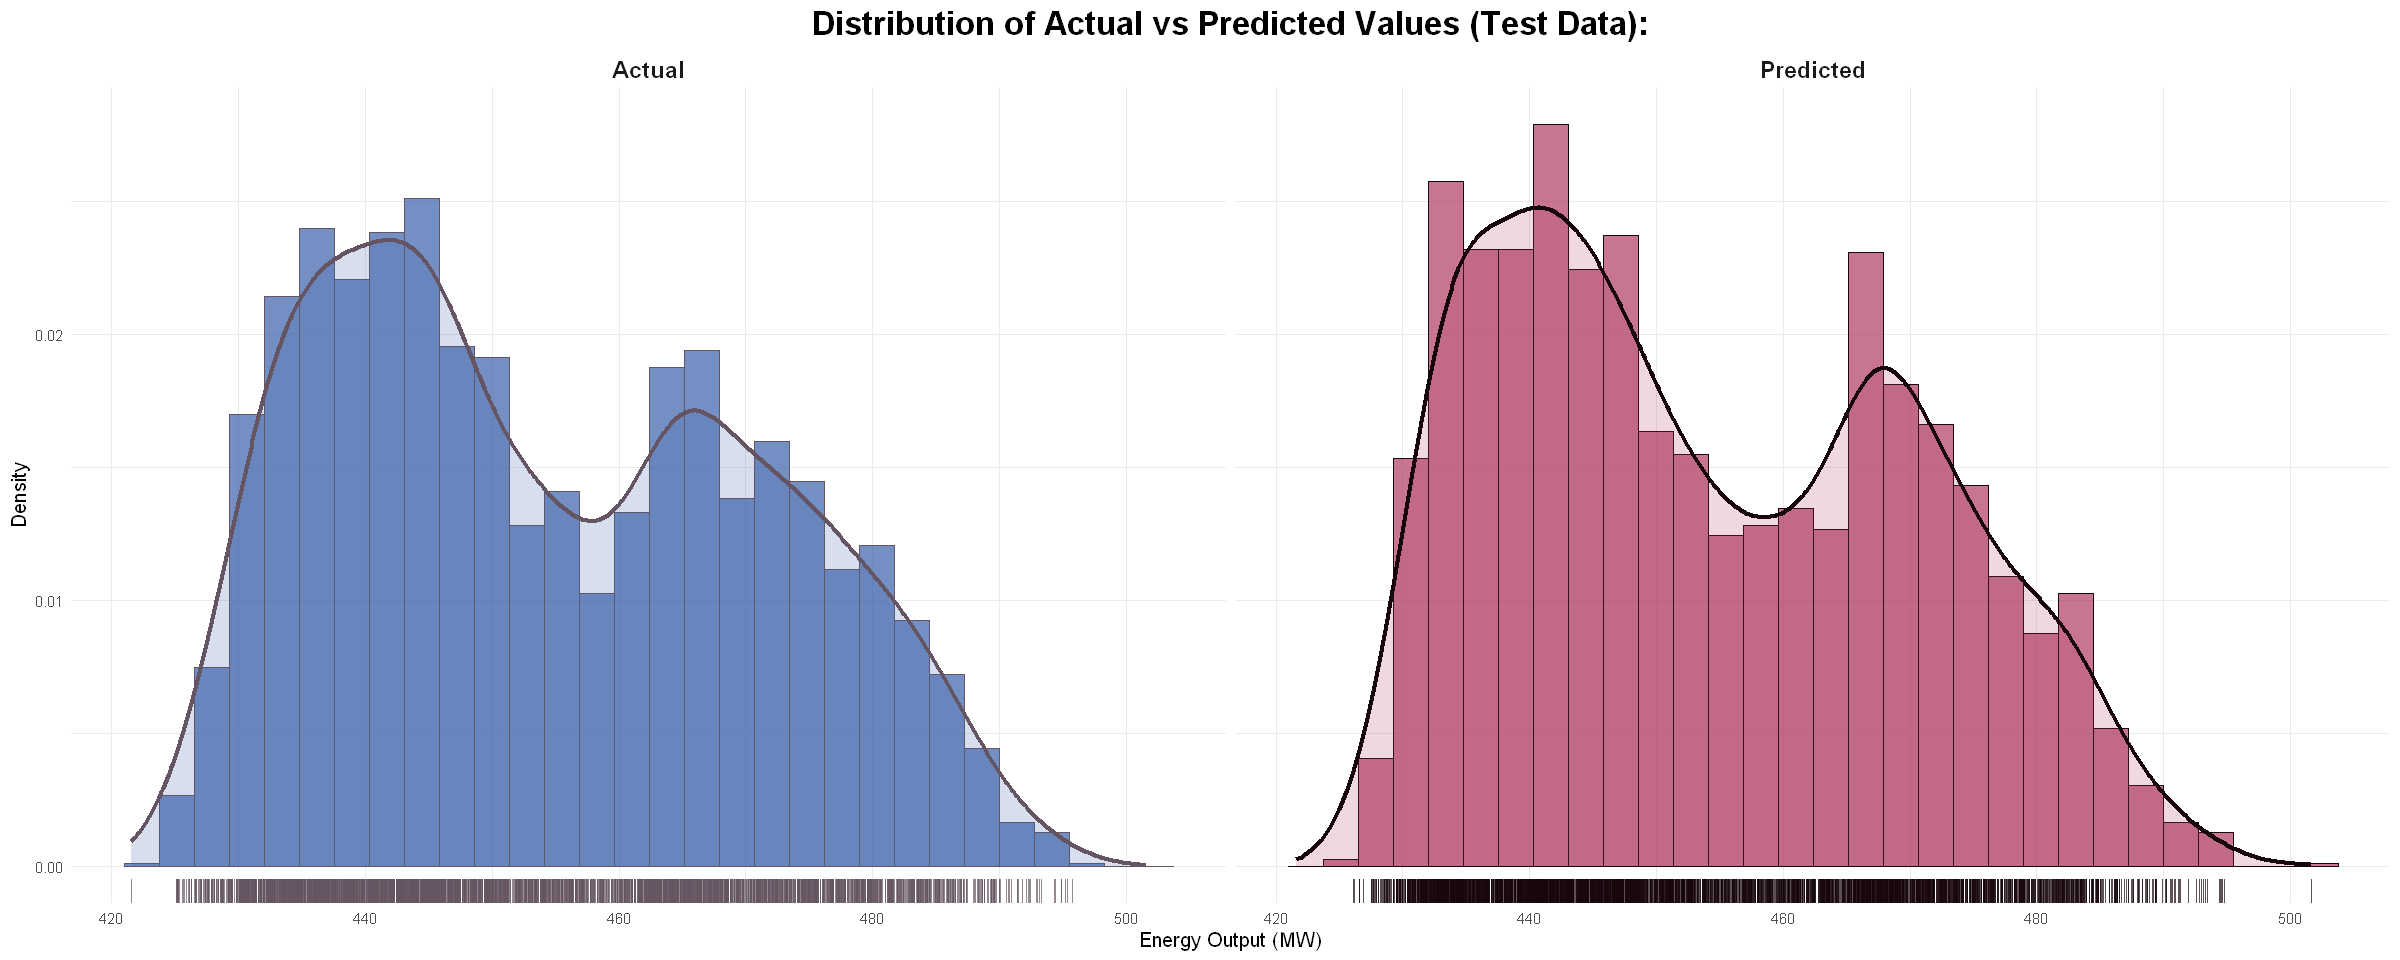

In [145]:
# Create histograms with density and rug plots

ggplot(comparison_df, aes(x = Value, fill = Type, color = Type)) +
  # Add histogram with density scaling
  geom_histogram(aes(y = after_stat(density)), 
                 bins = 30, 
                 alpha = 0.7) +
  # Add density curves
  geom_density(aes(y = after_stat(density)), 
               alpha = 0.2, 
               linewidth = 1.2) +
  # Add rug plots
  geom_rug(alpha = 0.7) +
  # Set custom colors
  scale_fill_manual(values = c("Actual" = "#385ea9", "Predicted" = "#b03a62")) +
  scale_color_manual(values = c("Actual" = "#655461", "Predicted" = "#17060c")) +
  # Facet into two columns by Type
  facet_grid(. ~ Type) +
  # Add labels and title
  labs(title = "Distribution of Actual vs Predicted Values (Test Data):",
       x = "Energy Output (MW)",
       y = "Density") +
  # Customize theme
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold", size = 20),
    legend.position = "none",
    strip.text = element_text(size = 14, face = "bold"),
    axis.title = element_text(size = 12)
  )

In [146]:
# residuals for training data:
test_residuals <- y_test - y_pred
head(test_residuals)

2.14620787
-0.55451952
0.09734623
-8.24273486
2.77190434
-1.99438883


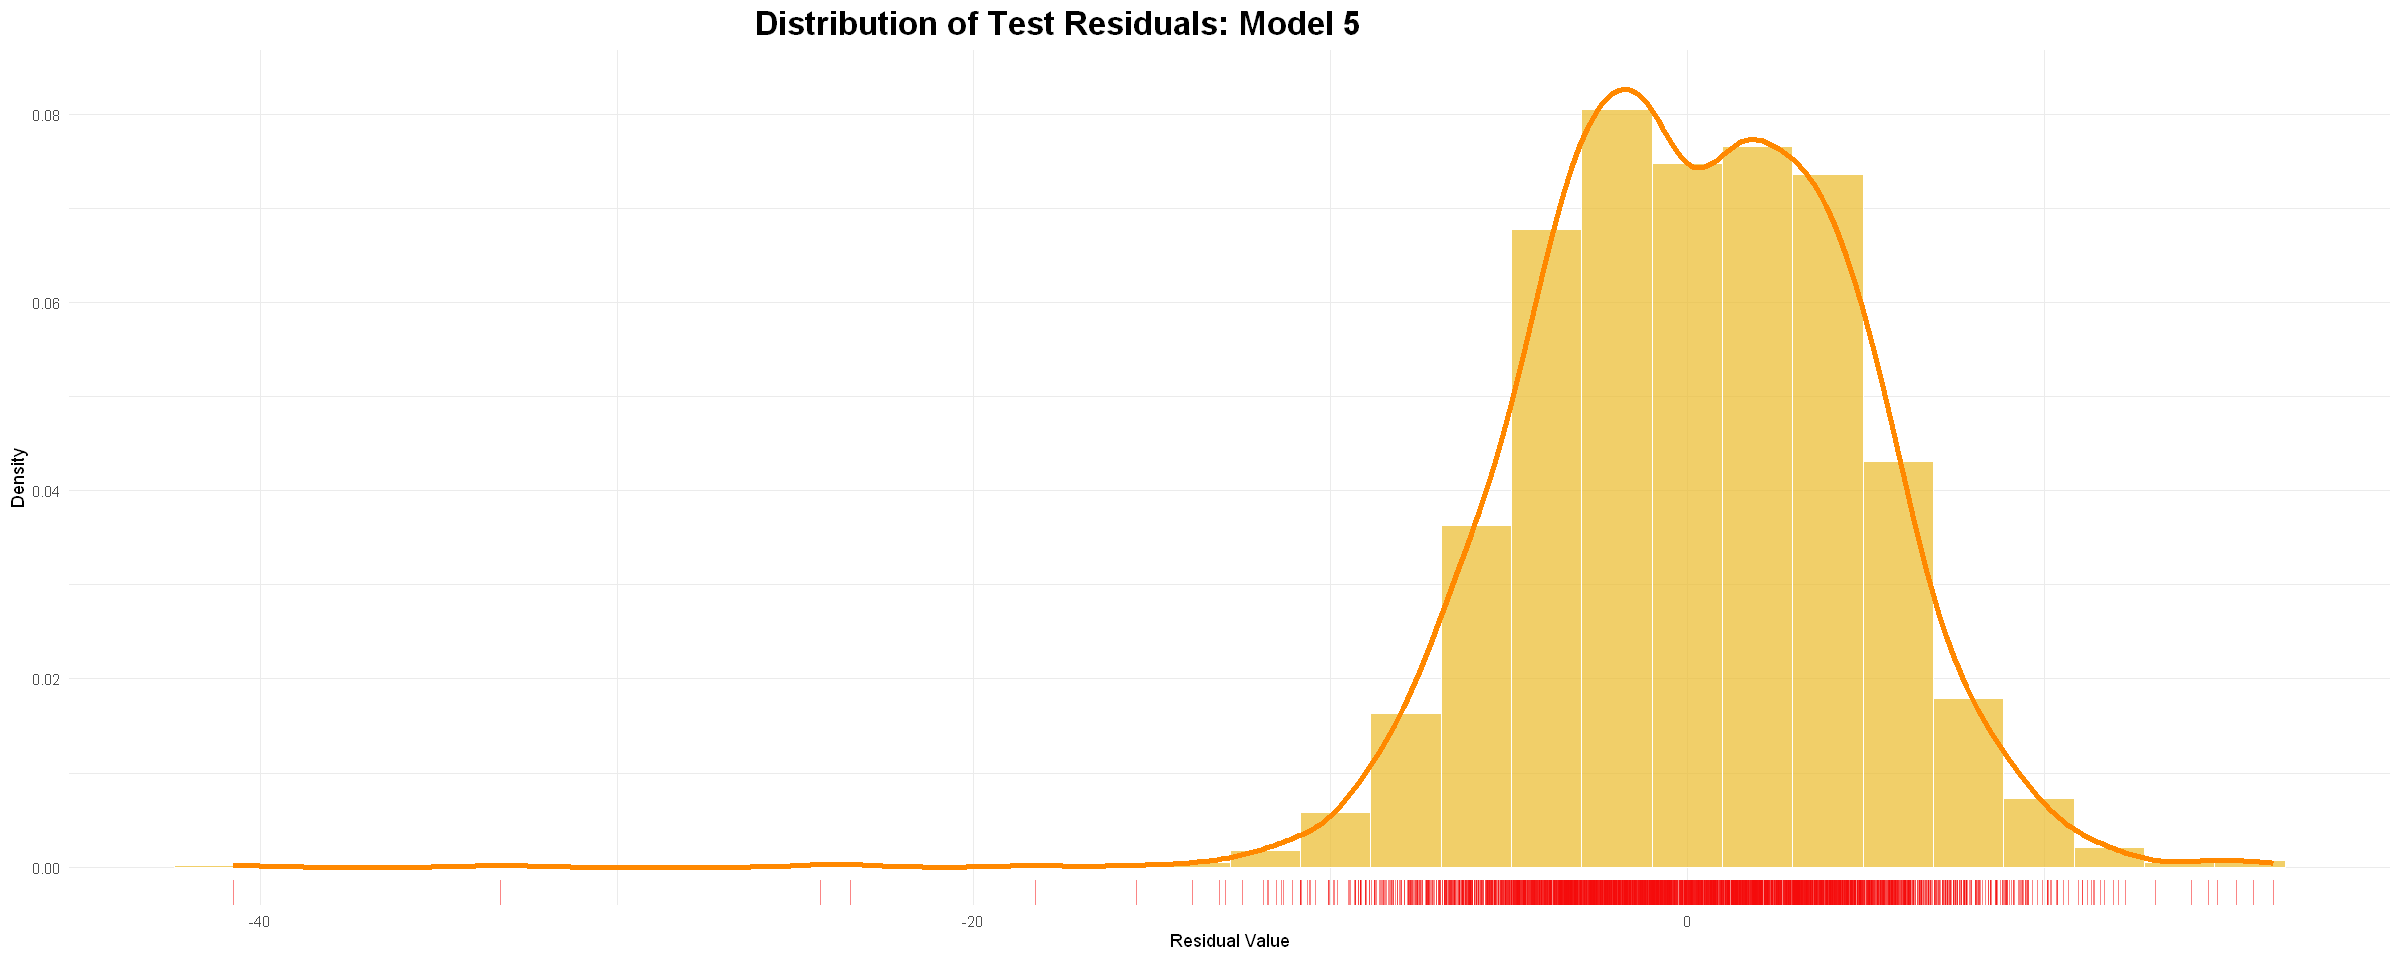

In [147]:
# distribution plot of training residuals: (Histogram + Density Curve + Rug Plot):

# Create a histogram of the test residuals
ggplot(data.frame(Residual = test_residuals), aes(x = Residual)) +
  geom_histogram(aes(y = ..density..), bins = 30, fill = "#ebba28", color = "white", alpha = 0.7) +
  geom_density(color = "#ff8800", linewidth = 1.5) +
  # add rug plot:
  geom_rug(sides = "b", color = "#f50b0b", alpha = 0.5) +
  labs(title = "Distribution of Test Residuals: Model 5",
       x = "Residual Value",
       y = "Density") +
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.4, face = "bold", size = 20),
    plot.subtitle = element_text(hjust = 0.5)
  ) 

In [148]:
# Calculate residuals for test data
test_residuals <- y_test - y_pred

# Calculate basic statistics
mean_val <- mean(test_residuals)
median_val <- median(test_residuals)
sd_val <- sd(test_residuals)

# Calculate standardized residuals
std_residuals <- (test_residuals - mean_val) / sd_val

# Calculate proportion within different SD ranges
within_1sd <- mean(abs(std_residuals) <= 1) * 100
within_2sd <- mean(abs(std_residuals) <= 2) * 100
within_3sd <- mean(abs(std_residuals) <= 3) * 100

# Expected proportions for normal distribution
expected_1sd <- 68.27
expected_2sd <- 95.45
expected_3sd <- 99.73

# Create results data frame
normality_measures <- data.frame(
  Range = c("Within 1 SD", "Within 2 SD", "Within 3 SD"),
  Actual = c(within_1sd, within_2sd, within_3sd),
  Expected = c(expected_1sd, expected_2sd, expected_3sd)
)

# Print results
cat("Normality Distribution Measures for Test Residuals:\n")
print(normality_measures)

Normality Distribution Measures for Test Residuals:
        Range   Actual Expected
1 Within 1 SD 68.92932    68.27
2 Within 2 SD 96.60602    95.45
3 Within 3 SD 99.54514    99.73


**Scatter plot to compare actual vs predicted values (testing data):**

`geom_smooth()` using formula = 'y ~ x'


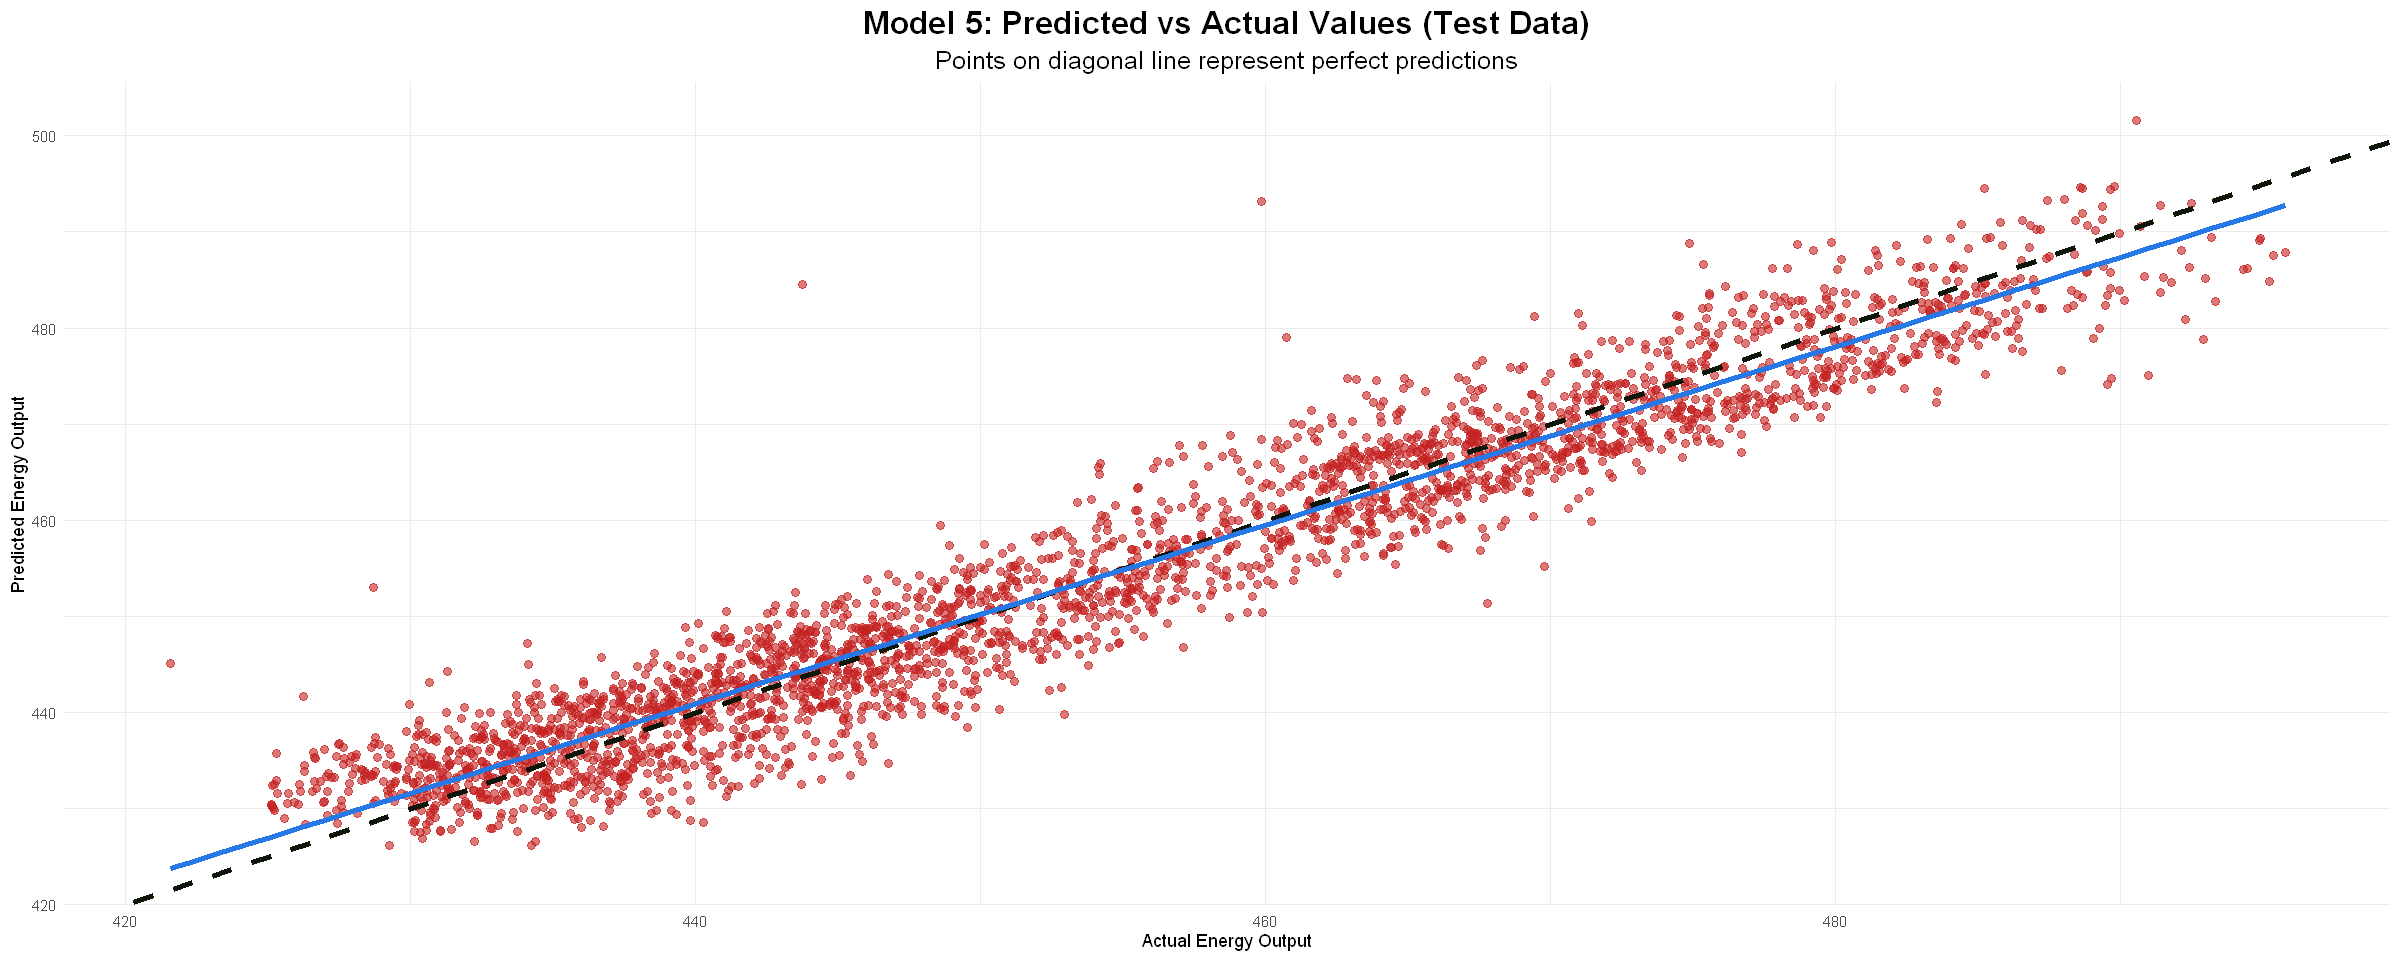

In [149]:
# Create a data frame for plotting (test data): 
comparison_data <- data.frame(
  Actual = y_test,
  Predicted = as.vector(y_pred)
)

# Calculate R-squared for test data
test_r_squared <- 1 - sum((y_test - y_pred)^2) / sum((y_test - mean(y_test))^2)

# Create a scatter plot with actual values on x-axis and predicted on y-axis
ggplot(comparison_data, aes(x = Actual, y = Predicted)) +
  # Add points
  geom_point(color = "#c42121", alpha = 0.6, size = 2.1) +

  # Add perfect prediction line (y = x)
  geom_abline(intercept = 0, slope = 1, color = "#0e1509", 
              linewidth = 1.5, linetype = "dashed", size= 1.5, ) +

  # Add a smooth trend line to see the actual relationship
  geom_smooth(method = "lm", color = "#2578e6", se = FALSE, linewidth = 1.5) +

  # Add labels and title
  labs(title = "Model 5: Predicted vs Actual Values (Test Data)",
       subtitle = paste("Points on diagonal line represent perfect predictions"),
       x = "Actual Energy Output",
       y = "Predicted Energy Output") +

  # Use a clean theme
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold", size = 19),
    plot.subtitle = element_text(hjust = 0.5, size = 15),
    legend.position = "none"
  )


**95% Confidence Intervals for Predictions with Error Bars (Test Data):**

In [150]:
# Calculate the residual variance from the training data: 
# This estimates the inherent noise/variability in our data

n_train <- nrow(X_train)                # Number of training samples
p <- ncol(X_train)                      # Number of model parameters (features)
residuals_train <- y_train - X_train %*% theta_train  # Training residuals
rss_train <- sum(residuals_train^2)     # Residual sum of squares
sigma_squared <- rss_train / (n_train - p)  # Estimated error variance

In [151]:
# Calculate the variance of predictions for test data
# This tells us how uncertain each prediction is
# Formula: Var(y_pred) = sigma² * x_test * (X_train'X_train)⁻¹ * x_test'
# where x_test is a row of the test design matrix

# Calculate (X'X)⁻¹ once (inverse of X'X matrix)
XtX_inv <- solve(t(X_train) %*% X_train)

In [152]:
# Initialize vector to store prediction variances
prediction_vars <- numeric(nrow(X_test))

# Calculate prediction variance for each test point
for (i in 1:nrow(X_test)) {
  x_i <- X_test[i, , drop = FALSE]  # Get the i-th test point (as a row matrix)
  # Calculate variance using the formula
  prediction_vars[i] <- sigma_squared * (x_i %*% XtX_inv %*% t(x_i))
}

In [153]:
# Calculate the standard errors of the predictions
prediction_se <- sqrt(prediction_vars)  # Standard error = sqrt(variance)

# Calculate the critical t-value for 95% confidence
# We use t-distribution with (n_train - p) degrees of freedom
t_critical <- qt(0.975, n_train - p)  # 0.975 for 95% confidence (two-tailed)

In [154]:
# Calculate the confidence intervals
# CI = prediction ± t_critical * standard_error
lower_ci <- y_pred - t_critical * prediction_se  # Lower bound
upper_ci <- y_pred + t_critical * prediction_se  # Upper bound

In [155]:
# Create a data frame for plotting
# For error bars, use a subset of points to avoid overcrowding
sample_interval <- 20  # Show one error bar every 20 points
sample_indices <- seq(1, length(y_test), by = sample_interval)

In [156]:
# Full data for ribbon plot
full_data <- data.frame(
  Index = 1:length(y_test),
  Actual = y_test,
  Predicted = y_pred,
  Lower_CI = lower_ci,
  Upper_CI = upper_ci
)

# Sampled data for error bars
sampled_data <- data.frame(
  Index = sample_indices,
  Actual = y_test[sample_indices],
  Predicted = y_pred[sample_indices],
  Lower_CI = lower_ci[sample_indices],
  Upper_CI = upper_ci[sample_indices]
)

In [157]:
# Print confidence interval statistics for reference
cat("Confidence interval statistics for test data:\n")
cat("Mean width:", mean(upper_ci - lower_ci), "\n")
cat("Maximum width:", max(upper_ci - lower_ci), "\n")
cat("Minimum width:", min(upper_ci - lower_ci), "\n")

Confidence interval statistics for test data:
Mean width: 0.4207347 
Maximum width: 1.301707 
Minimum width: 0.2222644 


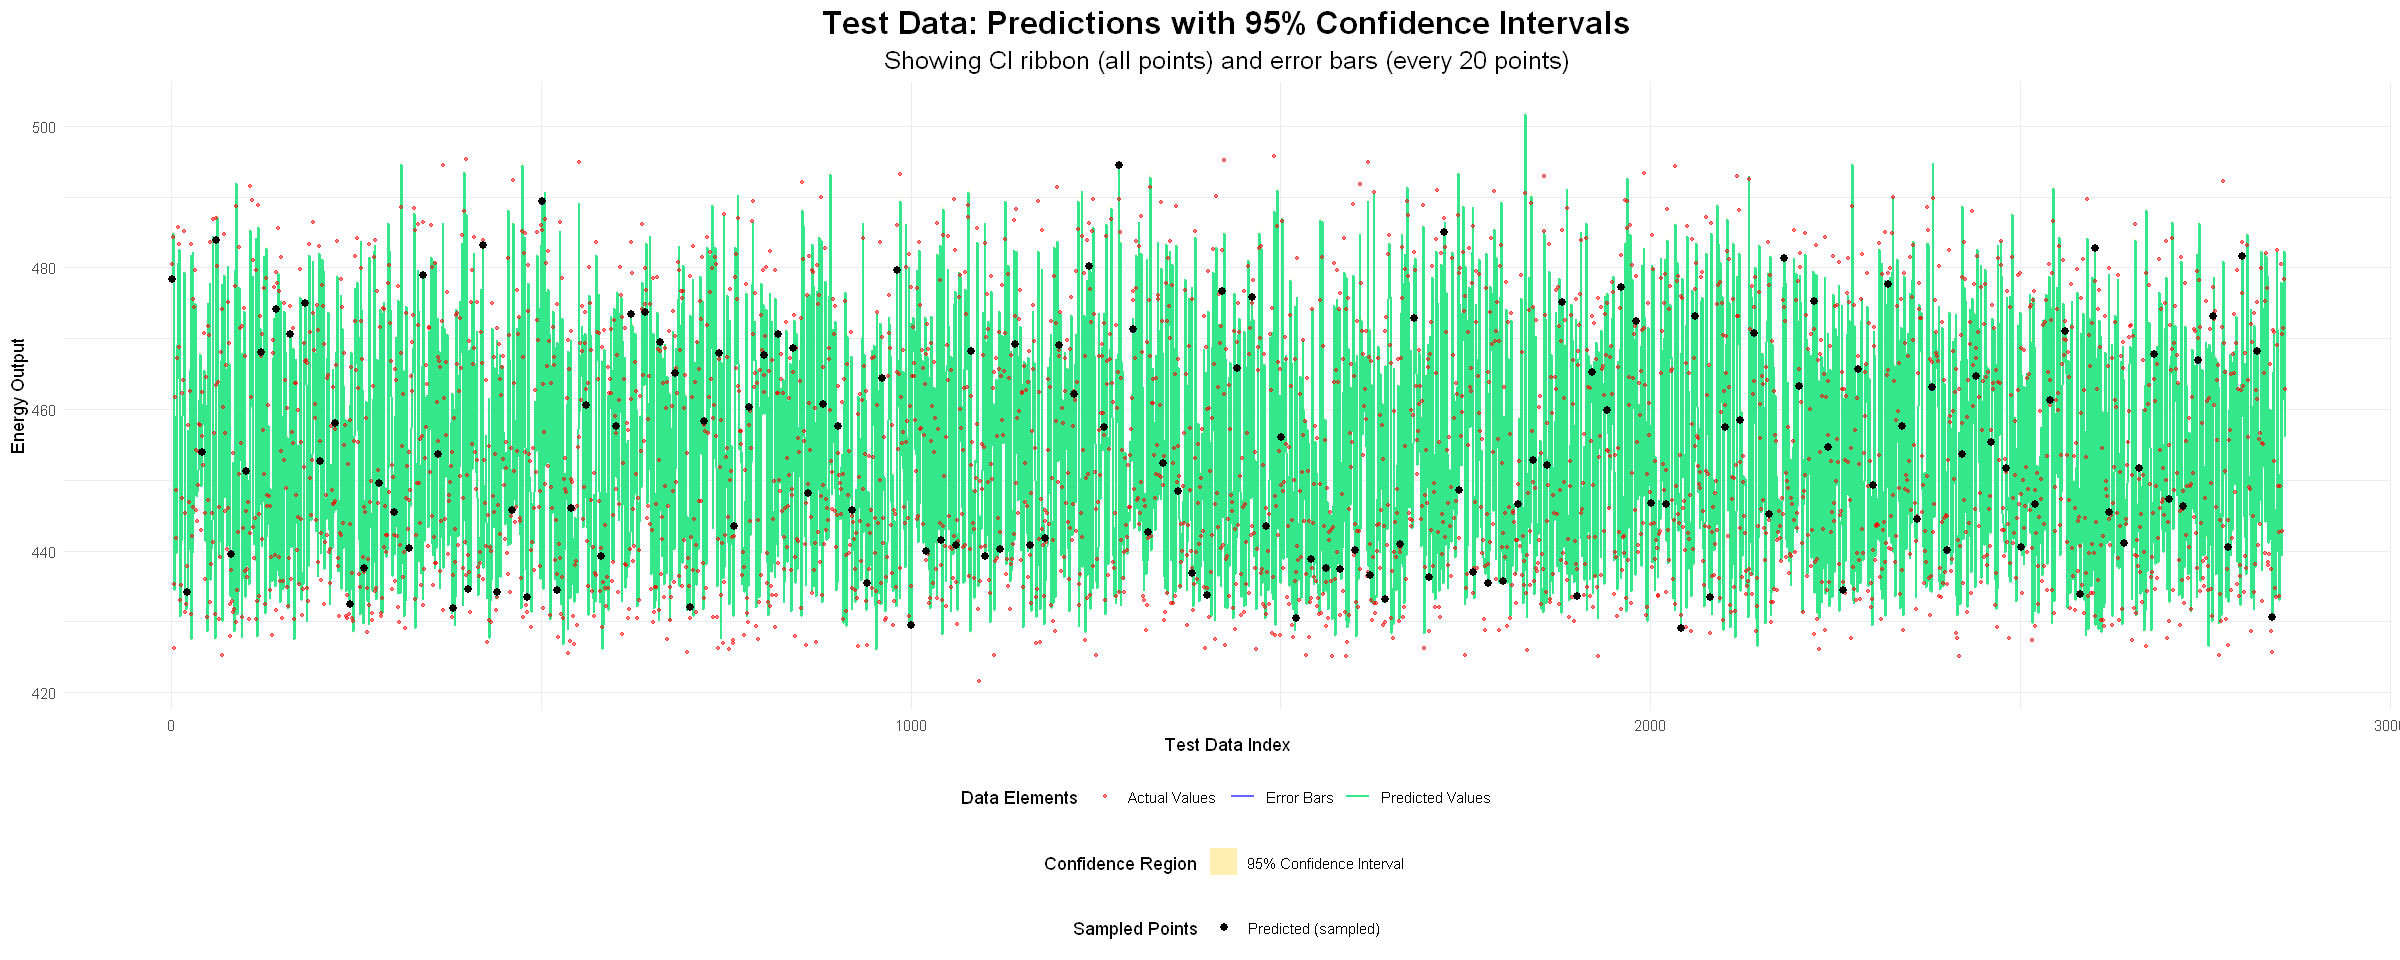

In [158]:
# Create a plot with 
#   - Actual values as points
#   - Predicted values as a line
#   - Confidence interval as a ribbon
#   - Error bars for selected points

combined_plot <- ggplot() +
  # Add confidence interval ribbon for all points
  # This shows the range where we expect the true value to fall with 95% probability
  geom_ribbon(data = full_data, 
              aes(x = Index, ymin = Lower_CI, ymax = Upper_CI, 
                  fill = "95% Confidence Interval"), 
              alpha = 0.3) +
  
  # Add predicted values line for all points
  # This shows our model's best estimate for each test point
  geom_line(data = full_data, 
            aes(x = Index, y = Predicted, color = "Predicted Values"), 
            linewidth = 0.8) +
  
  # Add actual values points for all points
  # These show the true observed values we're trying to predict
  geom_point(data = full_data, 
             aes(x = Index, y = Actual, color = "Actual Values"), 
             size = 0.9, alpha = 0.5) +
  
  # Add error bars for sampled points
  # These show the 95% confidence interval for selected points
  geom_errorbar(data = sampled_data, 
                aes(x = Index, ymin = Lower_CI, ymax = Upper_CI, 
                    color = "Error Bars"),
                width = 5, linewidth = 0.7, alpha = 0.7) +
  
  # Add predicted values points for sampled points
  # These highlight the points where we're showing error bars
  geom_point(data = sampled_data, 
             aes(x = Index, y = Predicted, shape = "Predicted (sampled)"), 
             color = "black", size = 2) +
  
  # Set custom colors and shapes
  scale_color_manual(values = c("Predicted Values" = "#33e78a",
                                "Actual Values" = "#ff0000",
                                "Error Bars" = "#2323f4"),
                     name = "Data Elements") +
  scale_fill_manual(values = c("95% Confidence Interval" = "#ffc800"),
                    name = "Confidence Region") +
  scale_shape_manual(values = c("Predicted (sampled)" = 19),
                     name = "Sampled Points") +
  
  # Add informative labels and title
  labs(title = "Test Data: Predictions with 95% Confidence Intervals",
       subtitle = paste("Showing CI ribbon (all points) and error bars (every", 
                        sample_interval, "points)"),
       x = "Test Data Index",
       y = "Energy Output") +
  
  # Add theme with legend at the bottom
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold", size = 19),
    plot.subtitle = element_text(hjust = 0.5, size = 15),
    legend.position = "bottom",
    legend.box = "vertical"
  )

# Display the combined plot
print(combined_plot)

Warning message:
"Removed 5 rows containing missing values or values outside the scale range
(`geom_line()`)."
Warning message:
"Removed 125 rows containing missing values or values outside the scale range
(`geom_point()`)."


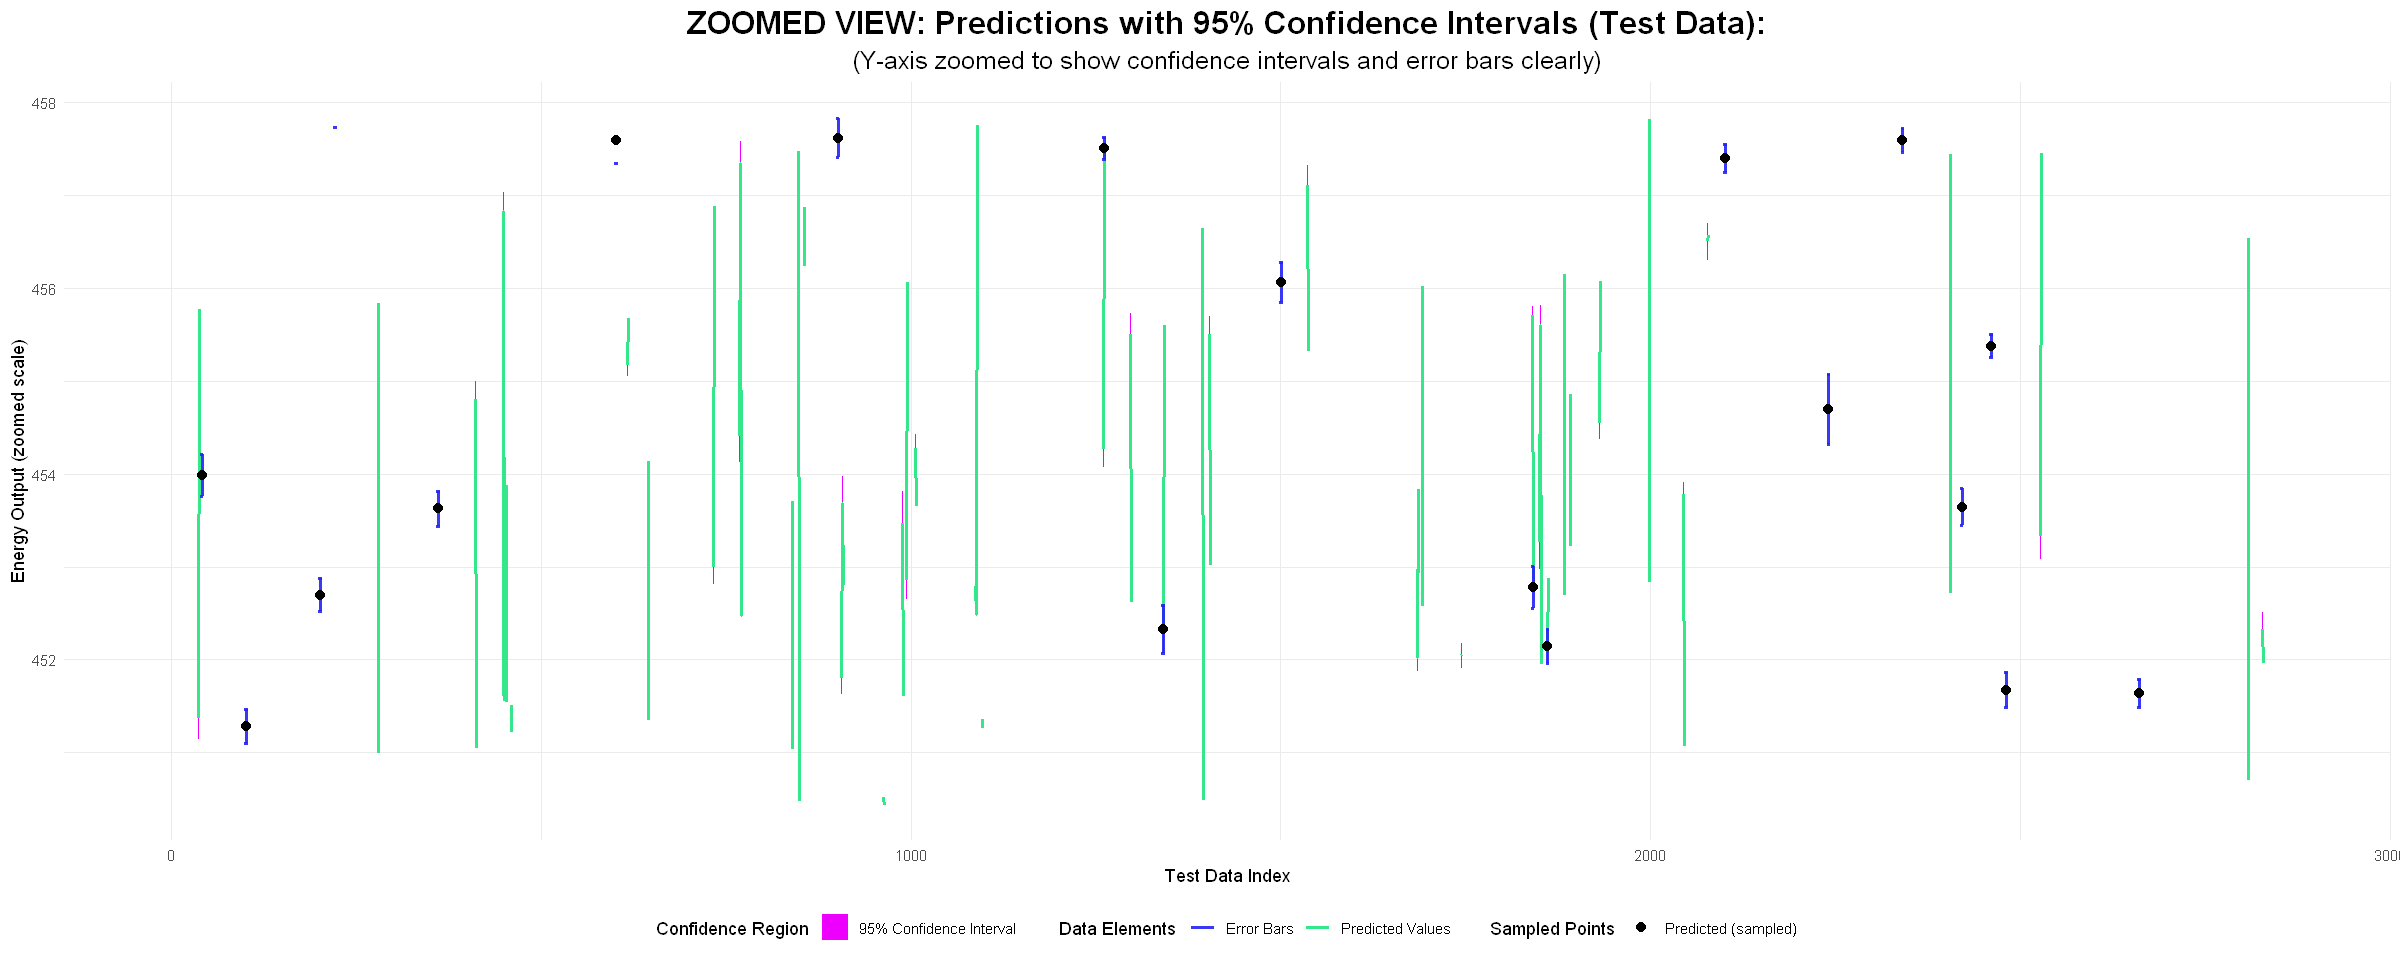

In [159]:
# create a zoomed version by focusing on a small y-axis range around predictions

# First, find a good y-range to zoom into
# Calculate the average prediction and a small range around it
mean_pred <- mean(y_pred)
y_range <- max(y_test) - min(y_test)
zoom_factor <- 0.05  # Show 5% of the full range
zoom_range <- y_range * zoom_factor

# Create the zoomed plot
zoomed_plot <- ggplot() +
  # Add confidence interval ribbon for all points
  geom_ribbon(data = full_data, 
              aes(x = Index, ymin = Lower_CI, ymax = Upper_CI, 
                  fill = "95% Confidence Interval"), 
              alpha = 1.0) +  # Increased alpha for better visibility
  
  # Add predicted values line
  geom_line(data = full_data, 
            aes(x = Index, y = Predicted, color = "Predicted Values"), 
            linewidth = 0.9) +  # Increased line width
  
  # Add error bars for sampled points
  geom_errorbar(data = sampled_data, 
                aes(x = Index, ymin = Lower_CI, ymax = Upper_CI, 
                    color = "Error Bars"),
                width = 5, linewidth = 1.0, alpha = 0.9) +  # Increased width and alpha
  
  # Add predicted values points for sampled points
  geom_point(data = sampled_data, 
             aes(x = Index, y = Predicted, shape = "Predicted (sampled)"), 
             color = "black", size = 2.5) +
  
  # Set custom colors and shapes
  scale_color_manual(values = c("Predicted Values" = "#33e78a",
                                "Error Bars" = "#2323f4"),
                     name = "Data Elements") +
  scale_fill_manual(values = c("95% Confidence Interval" = "#ee00ff"),
                    name = "Confidence Region") +
  scale_shape_manual(values = c("Predicted (sampled)" = 19),
                     name = "Sampled Points") +
  
  # Add informative labels and title
  labs(title = "ZOOMED VIEW: Predictions with 95% Confidence Intervals (Test Data):",
       subtitle = "(Y-axis zoomed to show confidence intervals and error bars clearly)",
       x = "Test Data Index",
       y = "Energy Output (zoomed scale)") +
  
  # Set y-axis limits to zoom in
  ylim(mean_pred - zoom_range, mean_pred + zoom_range) +
  
  # Add theme
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold", size = 19),
    plot.subtitle = element_text(hjust = 0.5, size = 15),
    legend.position = "bottom"
  )

# Display the zoomed plot
print(zoomed_plot)

In [160]:
# Print statistics about confidence interval widths to understand why they're hard to see
cat("\nWhy confidence intervals are difficult to see:\n")
cat("Mean CI width:", mean(upper_ci - lower_ci), "\n")
cat("Maximum CI width:", max(upper_ci - lower_ci), "\n")
cat("Minimum CI width:", min(upper_ci - lower_ci), "\n")
cat("Range of y values:", max(y_test) - min(y_test), "\n")
cat("CI width as percentage of y range:", 
    100 * mean(upper_ci - lower_ci) / (max(y_test) - min(y_test)), "%\n")


Why confidence intervals are difficult to see:
Mean CI width: 0.4207347 
Maximum CI width: 1.301707 
Minimum CI width: 0.2222644 
Range of y values: 74.19 
CI width as percentage of y range: 0.5671044 %


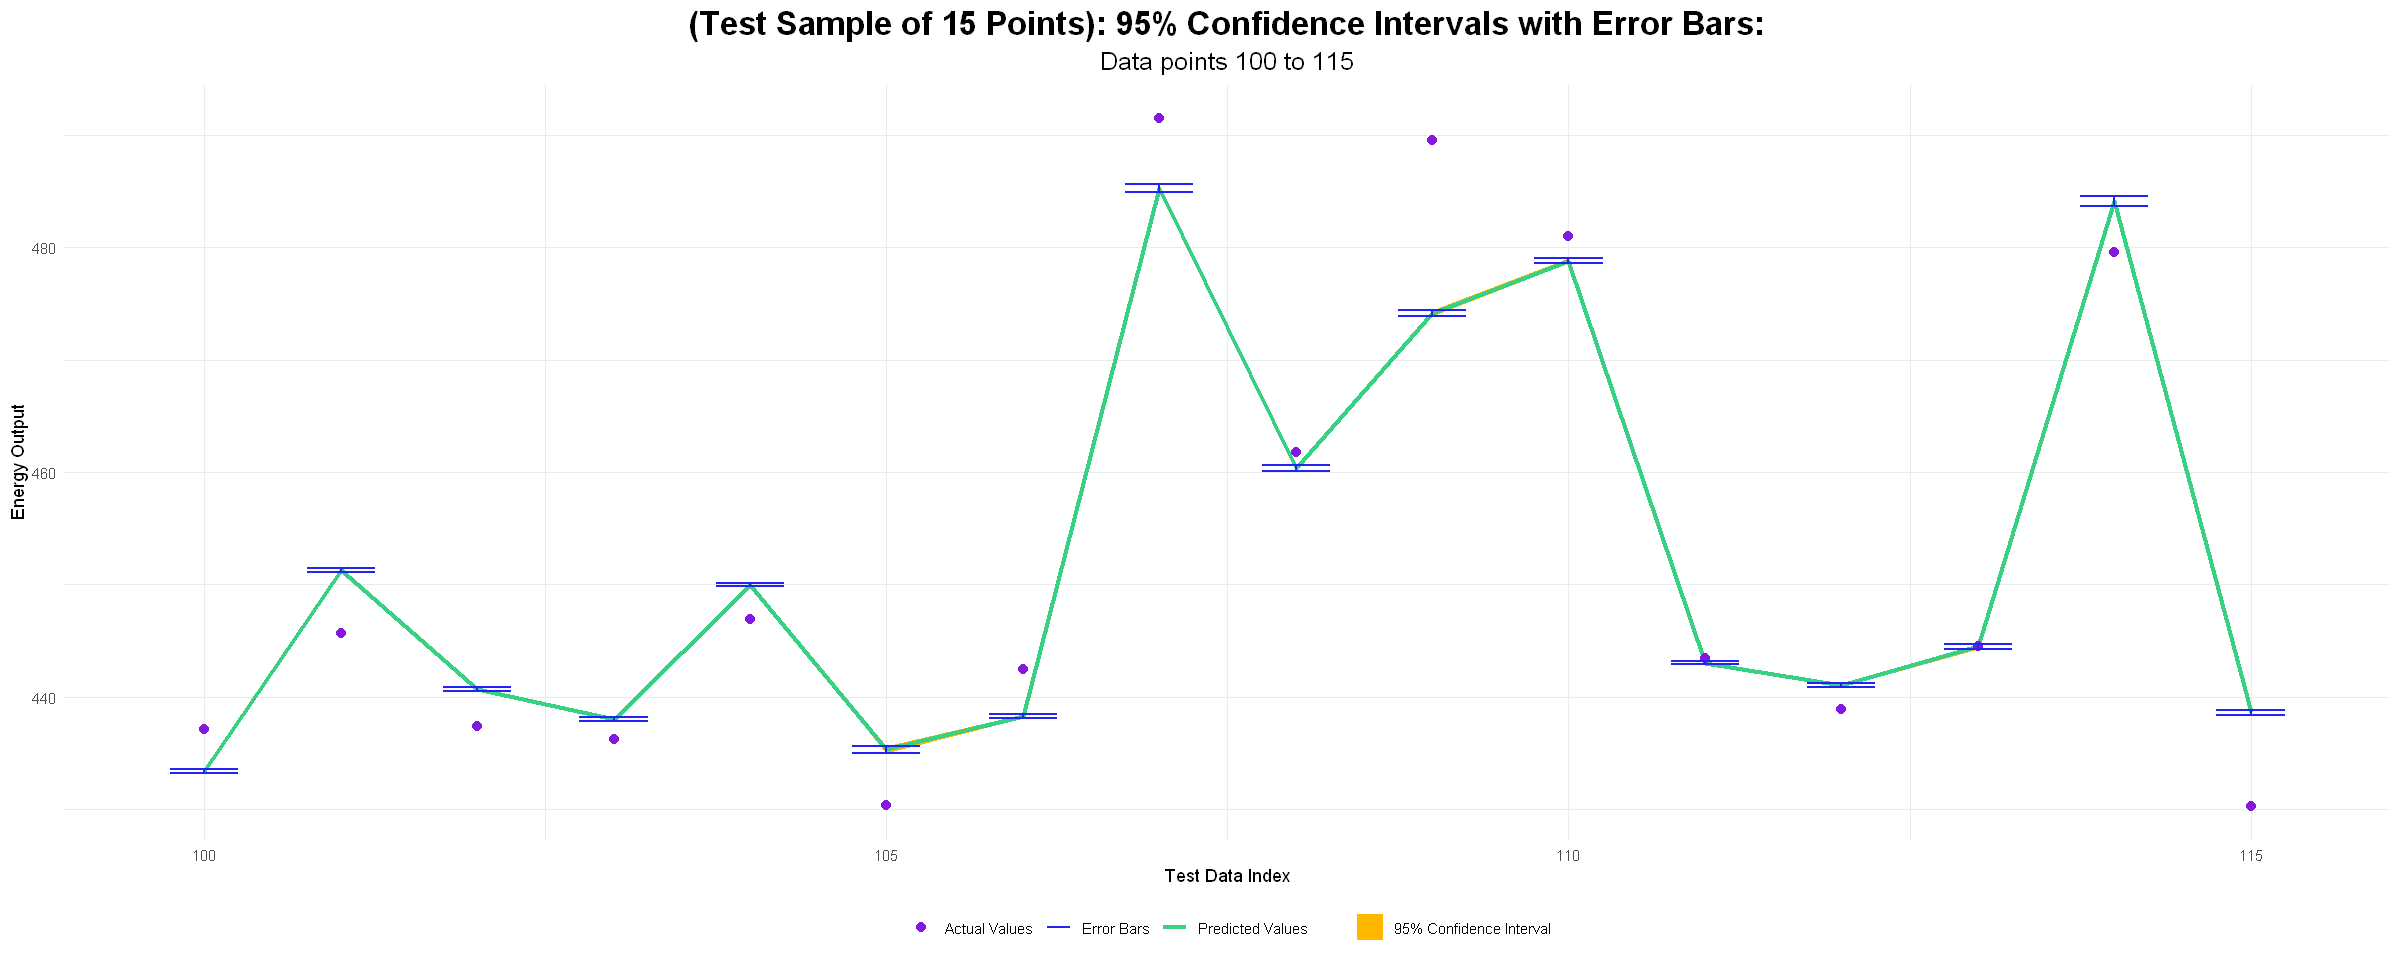

In [161]:
# Small sample of data for better visualization
# We'll select a small subset of consecutive points to show detail

# Select a small range of data points (e.g., points 100-115) ie. for 16 data points
sample_range <- 100:115
sample_data <- full_data[sample_range, ]

# Create the sample plot
sample_plot <- ggplot(sample_data, aes(x = Index)) +
  # Add confidence interval ribbon
  geom_ribbon(aes(ymin = Lower_CI, ymax = Upper_CI, 
                 fill = "95% Confidence Interval"), 
              alpha = 1.0) +
  
  # Add predicted values line
  geom_line(aes(y = Predicted, color = "Predicted Values"), 
            linewidth = 1.2) +
  
  # Add actual values points
  geom_point(aes(y = Actual, color = "Actual Values"), 
             size = 2.5) +
  
  # Add error bars for all points in this small sample
  geom_errorbar(aes(ymin = Lower_CI, ymax = Upper_CI, 
                   color = "Error Bars"),
                width = 0.5, linewidth = 0.8) +
  
  # Set custom colors
  scale_color_manual(values = c("Predicted Values" = "#38d082",
                                "Actual Values" = "#8318e0",
                                "Error Bars" = "#2323f4"),
                     name = "") +
  scale_fill_manual(values = c("95% Confidence Interval" = "#ffb700"),
                    name = "") +
  
  # Add informative labels and title
  labs(title = "(Test Sample of 15 Points): 95% Confidence Intervals with Error Bars:",
       subtitle = paste("Data points", min(sample_range), "to", max(sample_range)),
       x = "Test Data Index",
       y = "Energy Output") +
  
  # Add theme
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold", size = 20),
    plot.subtitle = element_text(hjust = 0.5, size = 15),
    legend.position = "bottom"
  )

# Display the sample plot
print(sample_plot)

**Residual Plot for Testing Dataset:**

`geom_smooth()` using formula = 'y ~ x'


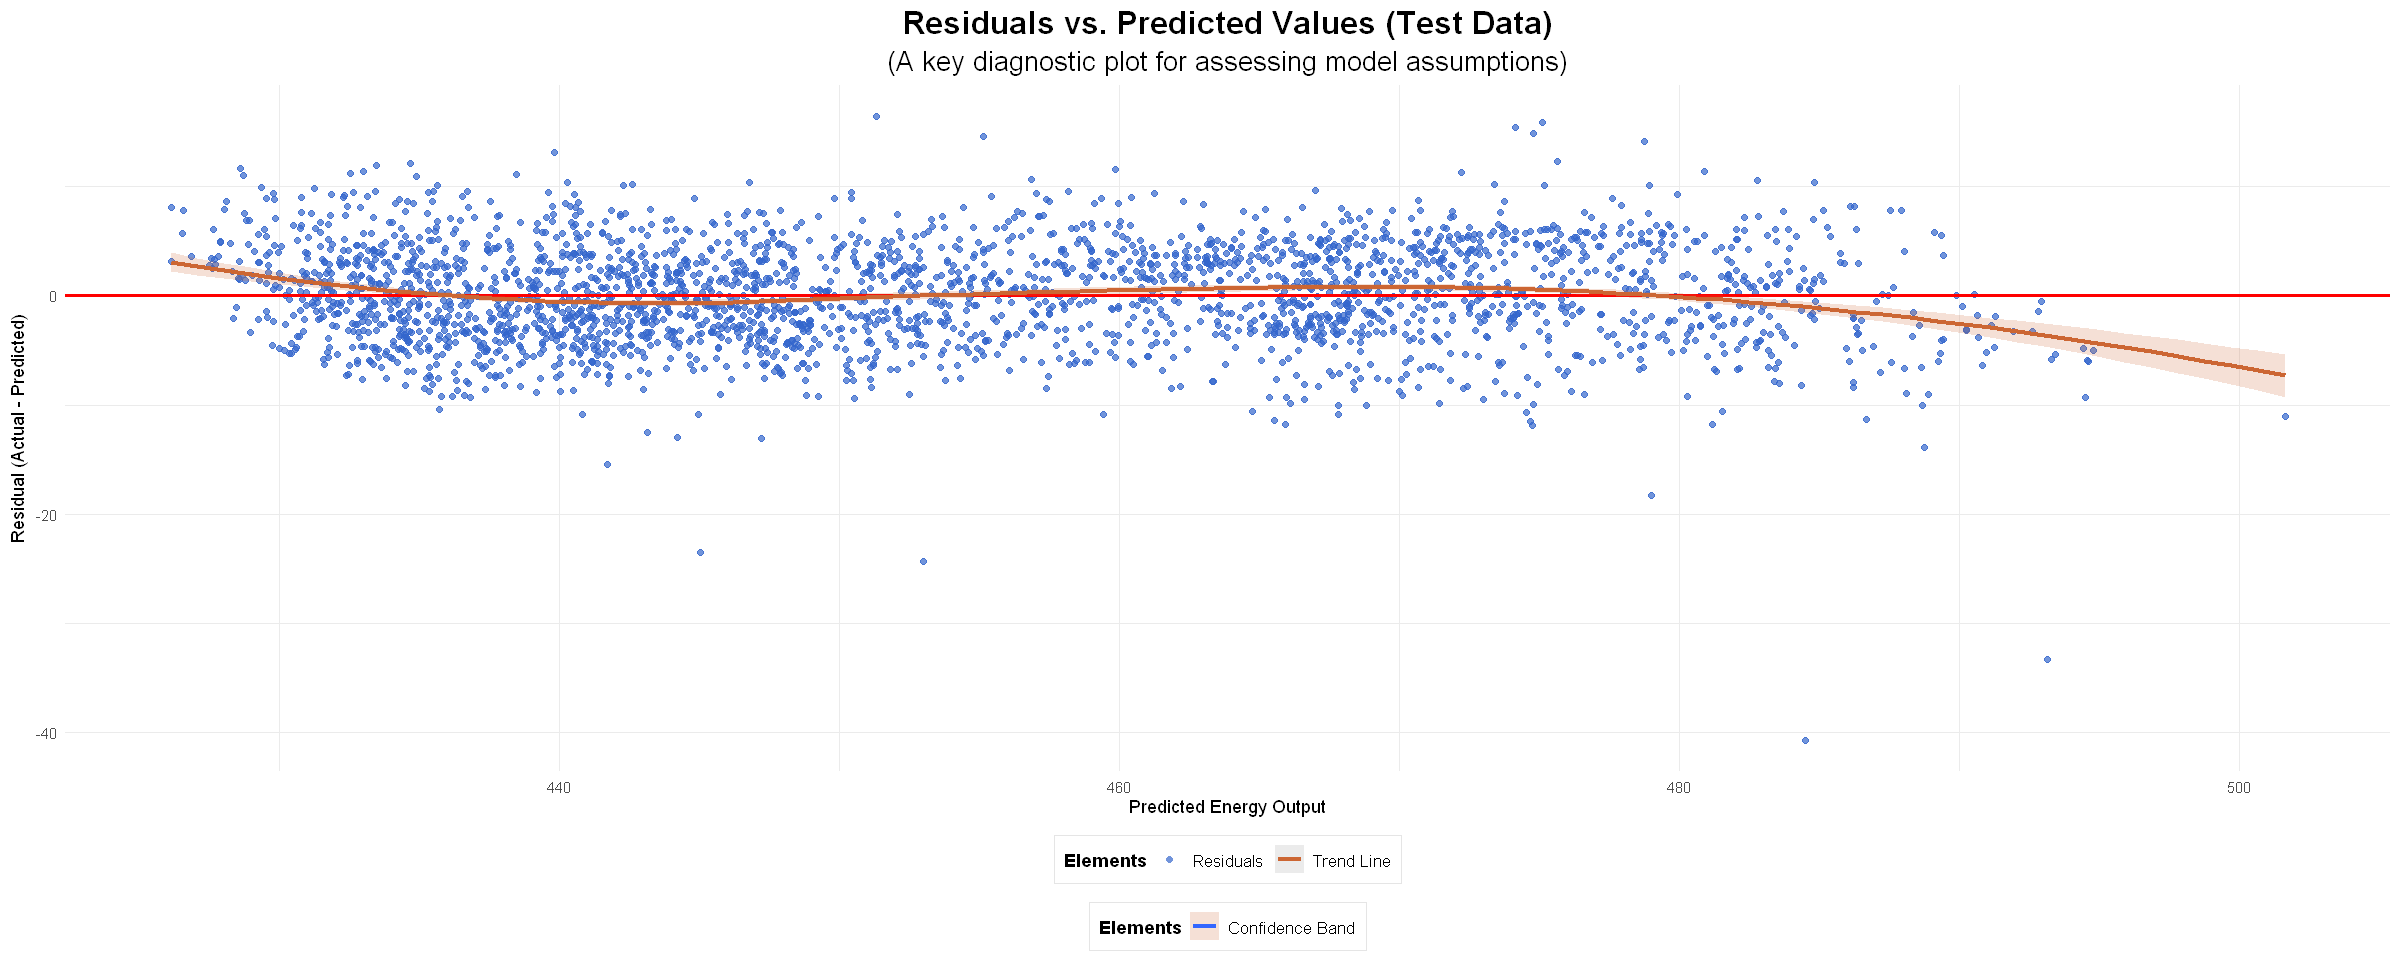

In [162]:
# residual plot for test data (predicted values vs. residuals): 

# hide warnings
options(warn = -1)

# Calculate residuals for test data
test_residuals <- y_test - y_pred

# Create a data frame for plotting
residual_data <- data.frame(
  Predicted = as.numeric(y_pred),
  Residual = as.numeric(test_residuals)
)

# Create the residual plot with improved legend
residual_plot <- ggplot(residual_data, aes(x = Predicted, y = Residual)) +
  # Add points for residuals with named aesthetic for legend
  geom_point(aes(color = "Residuals"), alpha = 0.7, size = 1.5) +
  
  # Add horizontal line at y = 0 with named aesthetic for legend
  geom_hline(aes(linetype = "Zero Line (Perfect Prediction)"), 
             yintercept = 0, color = "red", linewidth = 1) +
  
  # Add a smooth trend line with named aesthetic for legend
  geom_smooth(aes(color = "Trend Line", fill = "Confidence Band"),
              method = "loess", se = TRUE, linewidth = 1.2, alpha = 0.2) +
  
  # Set custom colors and linetypes
  scale_color_manual(values = c("Residuals" = "#3366CC", 
                               "Trend Line" = "#CC6633"),
                    name = "Elements") +
  scale_fill_manual(values = c("Confidence Band" = "#CC6633"),
                   name = "Elements") +
  scale_linetype_manual(values = c("Zero Line (Perfect Prediction)" = "dashed"),
                       name = "Elements") +
  
  # Add labels and title
  labs(title = "Residuals vs. Predicted Values (Test Data)",
       subtitle = "(A key diagnostic plot for assessing model assumptions)",
       x = "Predicted Energy Output",
       y = "Residual (Actual - Predicted)") +
  
  # Add theme with improved legend
  theme_minimal() +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold", size = 19),
    plot.subtitle = element_text(hjust = 0.5, size = 16),
    legend.position = "bottom",
    legend.box = "vertical",
    legend.title = element_text(face = "bold"),
    legend.text = element_text(size = 10),
    legend.background = element_rect(fill = "white", color = "gray90"),
    legend.margin = margin(6, 6, 6, 6)
  ) +
  
  # Combine all legend elements into one
  guides(color = guide_legend(order = 1, override.aes = list(
                             linetype = c("solid", "solid"),
                             shape = c(16, NA))),
         fill = guide_legend(order = 2),
         linetype = guide_legend(order = 3))

# Display the plot
print(residual_plot)

# Reset warnings to default
options(warn= 0)

## **Task 3: Approximate Bayesian Computation:**

In [163]:
model_parameters$model5

bias,-754.486865
x4,186.436251
x1_squared,-4.728874
x3_squared,-2.599210


* `θ_bias` = -754.486865
* `θ₁ (x4)` = 186.436251
* `θ₂ (x1²)` = -4.728874
* `θ₃ (x3²)` = -2.599210

We will use ABC to compute posterior distributions for the **2 parameters with the largest absolute value.**

So: `θ₁` = **186.436251** and, `θ₂` = **-4.728874** have the highest magnitudes. So we’ll focus on estimating the posterior for:

* `θ₁` (coefficient of x4)
* `θ₂` (coefficient of x1²)

We will **keep `θ₃` and `θ_bias` fixed** at their least squares estimates. 

In [164]:
# Load necessary libraries
library(ggplot2)
library(reshape2)
library(scales)

# Prepare data for simulation: 
x1_squared <- data$x1^2
x3_squared <- data$x3^2
x4 <- data$x4
y_obs <- data$y


Attaching package: 'scales'


The following object is masked from 'package:viridis':

    viridis_pal


The following object is masked from 'package:purrr':

    discard


The following object is masked from 'package:readr':

    col_factor




In [165]:
# Fixed parameters theta_3 and bias: 
theta3_fixed <- -2.599210
theta_bias_fixed <- -754.486865

In [166]:
# Least squares estimates; this is used for reference
theta1_mean <- 186.436251
theta2_mean <- -4.728874

# Define prior ranges (±20% of mean)
theta1_range <- c(theta1_mean * 0.8, theta1_mean * 1.2)
theta2_range <- c(theta2_mean * 1.2, theta2_mean * 0.8)  # flipped for negative mean

In [167]:
# ABC Rejection Sampling Parameters
n_samples <- 10000
#epsilon <- 1e6 # Acceptance threshold
epsilon <- 10^6.62 # Acceptance threshold
# Storage for all samples and distances
theta1_all <- numeric(n_samples)
theta2_all <- numeric(n_samples)
distance <- numeric(n_samples)
epsilon # Lets see the value

[1] 4168694

In [168]:
# RSS threshold (acceptance)
#RSS_Model_5 <- sum((y_obs - (theta1_mean * x4 + theta2_mean * x1_squared + theta3_fixed * x3_squared + theta_bias_fixed))^2)
#epsilon <- RSS_Model_5 * 2
#epsilon

In [169]:
# random seed for reproducability: 
set.seed(0)

# Run ABC rejection sampling
for (i in 1:n_samples) {
  # Sample from priors: 
  theta1 <- runif(1, theta1_range[1], theta1_range[2])
  theta2 <- runif(1, theta2_range[1], theta2_range[2])
  
  # Store the sampled values
  theta1_all[i] <- theta1
  theta2_all[i] <- theta2
  
  # Simulate y using the model
  y_sim <- theta1 * x4 + theta2 * x1_squared + theta3_fixed * x3_squared + theta_bias_fixed
  
  # Calculate distance
  distance[i] <- sum((y_obs - y_sim)^2)
}

# Get accepted samples
accepted_indices <- which(distance < epsilon)
posterior_df <- data.frame(
  theta1 = theta1_all[accepted_indices],
  theta2 = theta2_all[accepted_indices]
)

# Also create full dataframe for accepted/rejected visualization
status <- ifelse(distance < epsilon, "Accepted", "Rejected")
full_sample_df <- data.frame(
  theta1 = theta1_all,
  theta2 = theta2_all,
  status = status
)

In [170]:
head(posterior_df)

,theta1,theta2
,<dbl>,<dbl>
1,186.2647,-4.317238
2,184.7382,-4.289441
3,187.8259,-4.422433
4,184.8044,-3.926716
5,186.1076,-4.758478
6,187.0061,-4.383121


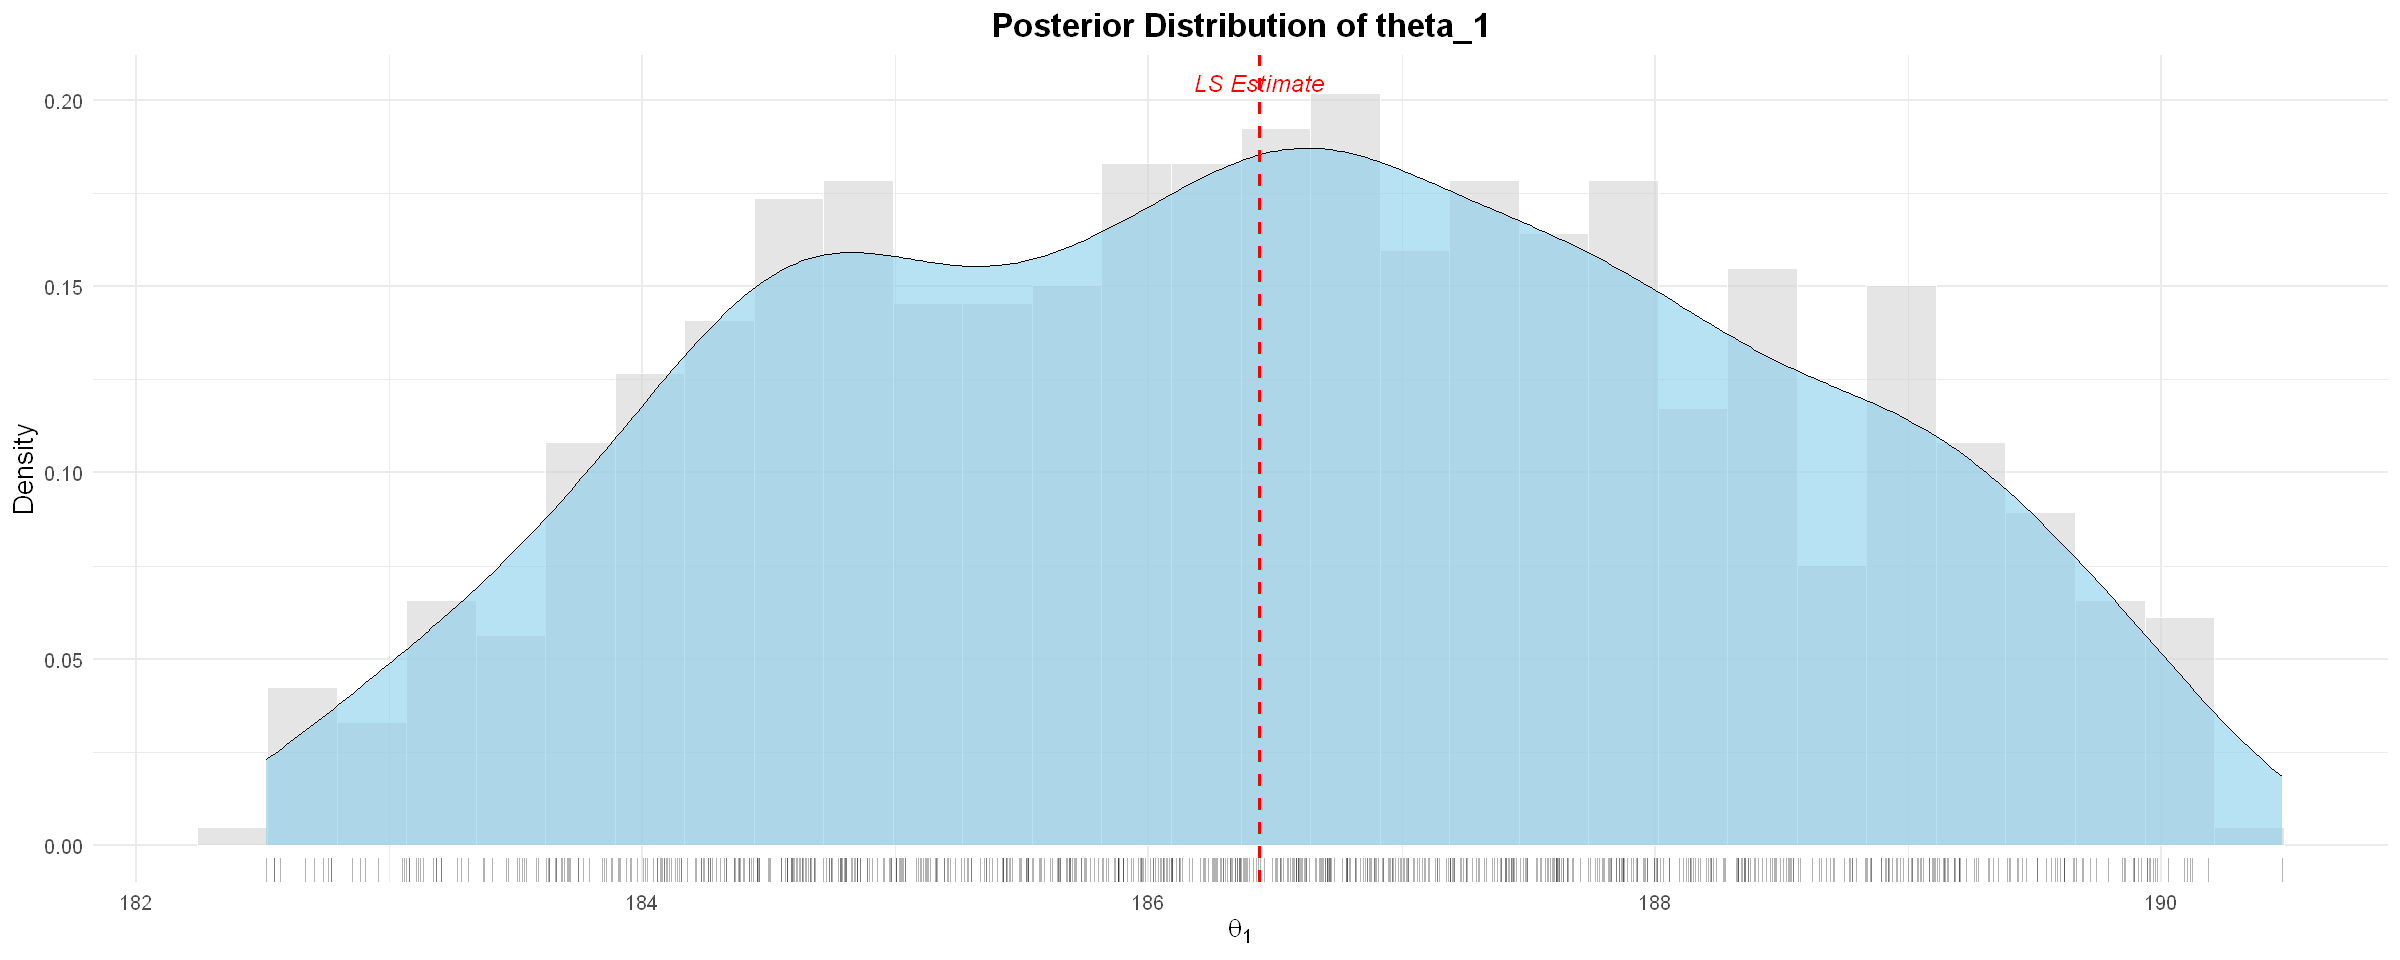

In [171]:
# posterior distribution of the parameter theta_1: 

ggplot(posterior_df, aes(x = theta1)) +
  geom_histogram(aes(y = ..density..), bins = 30, fill = "lightgray", color = "white", alpha = 0.6) +
  geom_density(fill = "skyblue", alpha = 0.6) +
  geom_rug(sides = "b", color = "black", alpha = 0.3) +
  geom_vline(xintercept = theta1_mean, color = "red", linetype = "dashed", size = 1) +
  annotate(
    "text", 
    x = theta1_mean, 
    y = Inf, 
    label = "LS Estimate", 
    vjust = 2, 
    color = "red", 
    fontface = "italic",
    size = 5
  ) +
  labs(
    title = "Posterior Distribution of theta_1",
    x = expression(theta[1]),
    y = "Density"
  ) +
  theme_minimal(base_size = 14) +
  theme(
    plot.title = element_text(hjust = 0.5, size = 20, face = "bold"),
    axis.title.x = element_text(size = 16),
    axis.title.y = element_text(size = 16),
    axis.text = element_text(size = 12)
  )

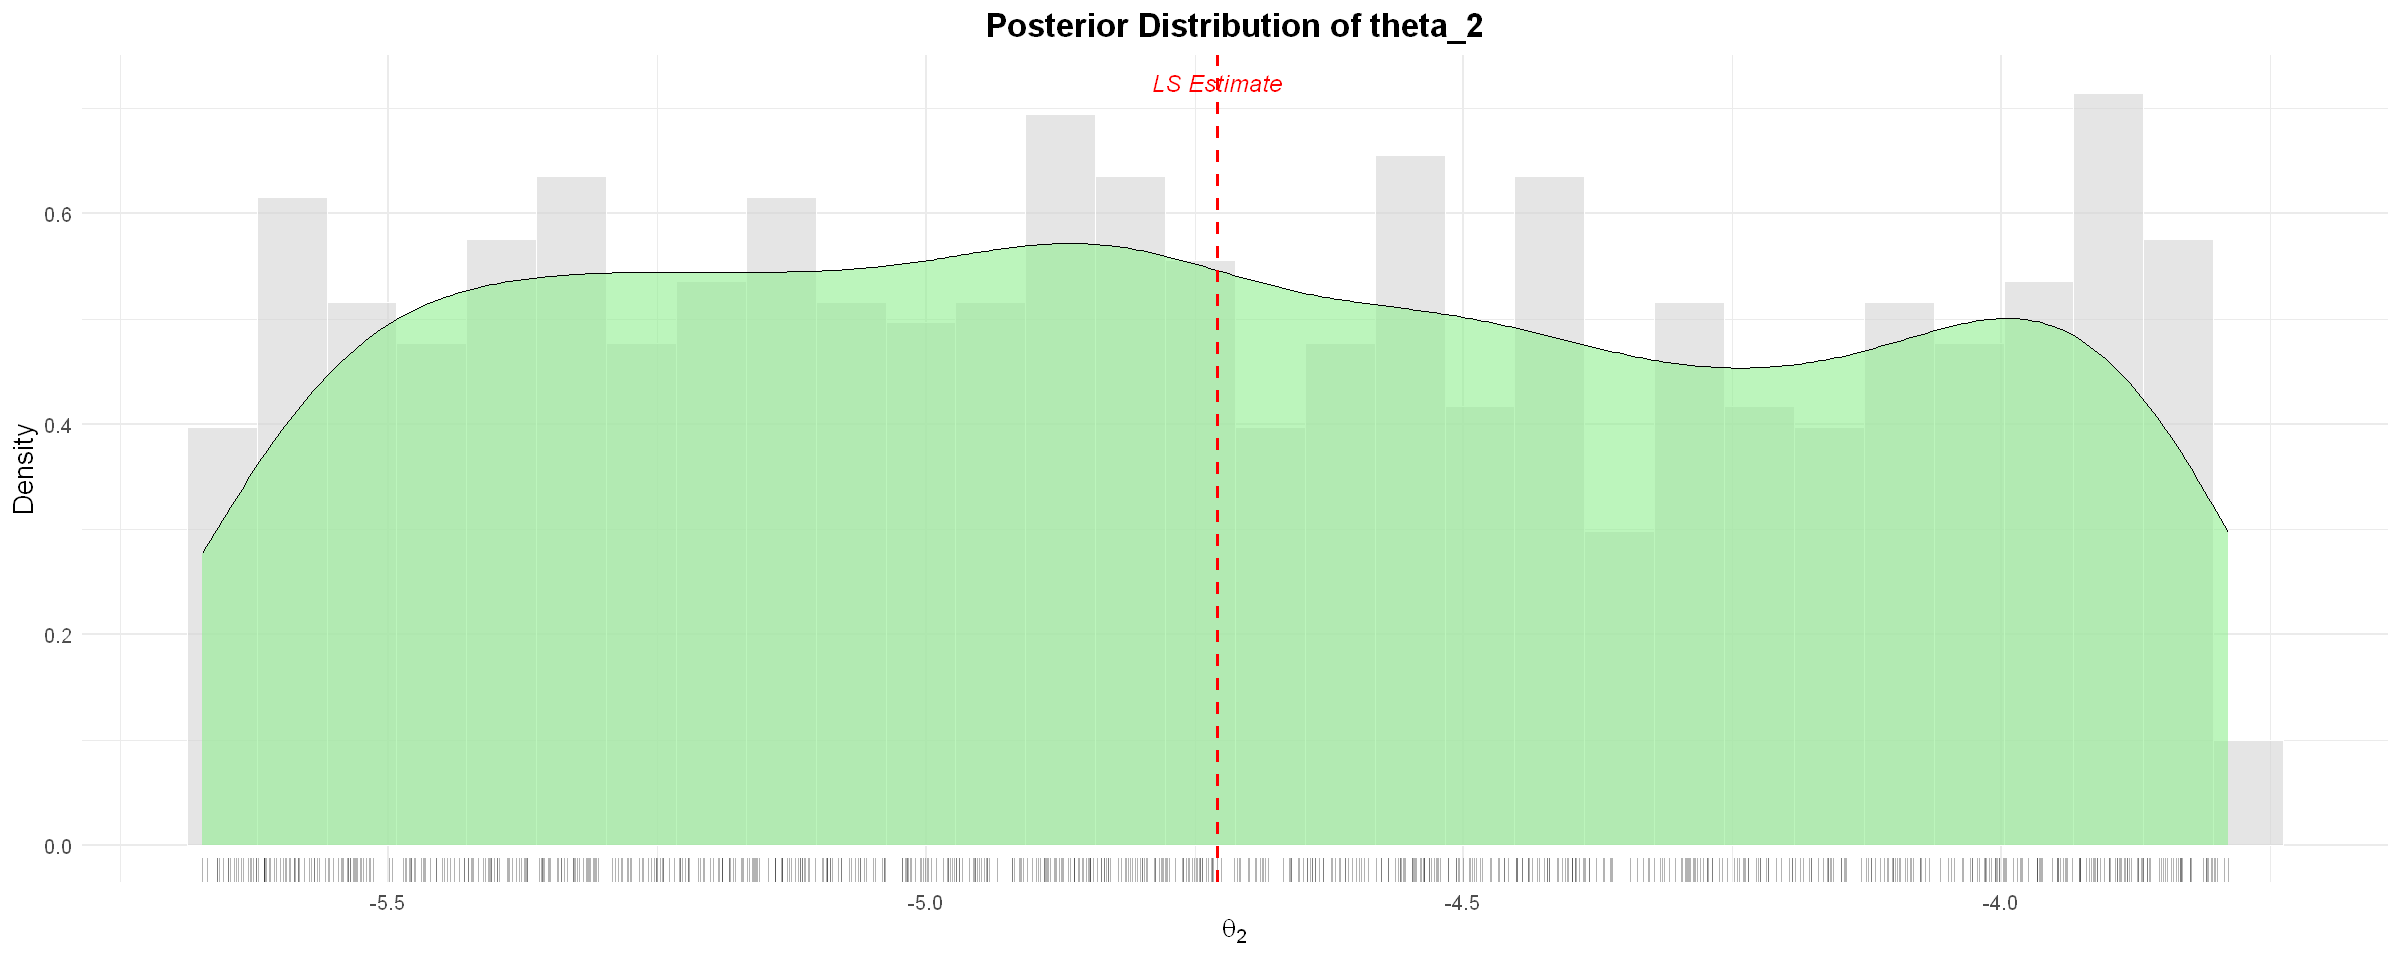

In [172]:
# approximate Bayesian posterior for theta_2: 

ggplot(posterior_df, aes(x = theta2)) +
  geom_histogram(aes(y = ..density..), bins = 30, fill = "lightgray", color = "white", alpha = 0.6) +
  geom_density(fill = "lightgreen", alpha = 0.6) +
  geom_rug(sides = "b", color = "black", alpha = 0.3) +
  geom_vline(xintercept = theta2_mean, color = "red", linetype = "dashed", size = 1) +
  annotate(
    "text", 
    x = theta2_mean, 
    y = Inf, 
    label = "LS Estimate", 
    vjust = 2, 
    color = "red", 
    fontface = "italic",
    size = 5
  ) +
  labs(
    title = "Posterior Distribution of theta_2",  # θ₂ (x²¹)
    x = expression(theta[2]),
    y = "Density"
  ) +
  theme_minimal(base_size = 14) +
  theme(
    plot.title = element_text(
      size = 20,
      face = "bold",
      hjust = 0.5
    ),
    axis.title.x = element_text(size = 16),
    axis.title.y = element_text(size = 16),
    axis.text = element_text(size = 12)
  )

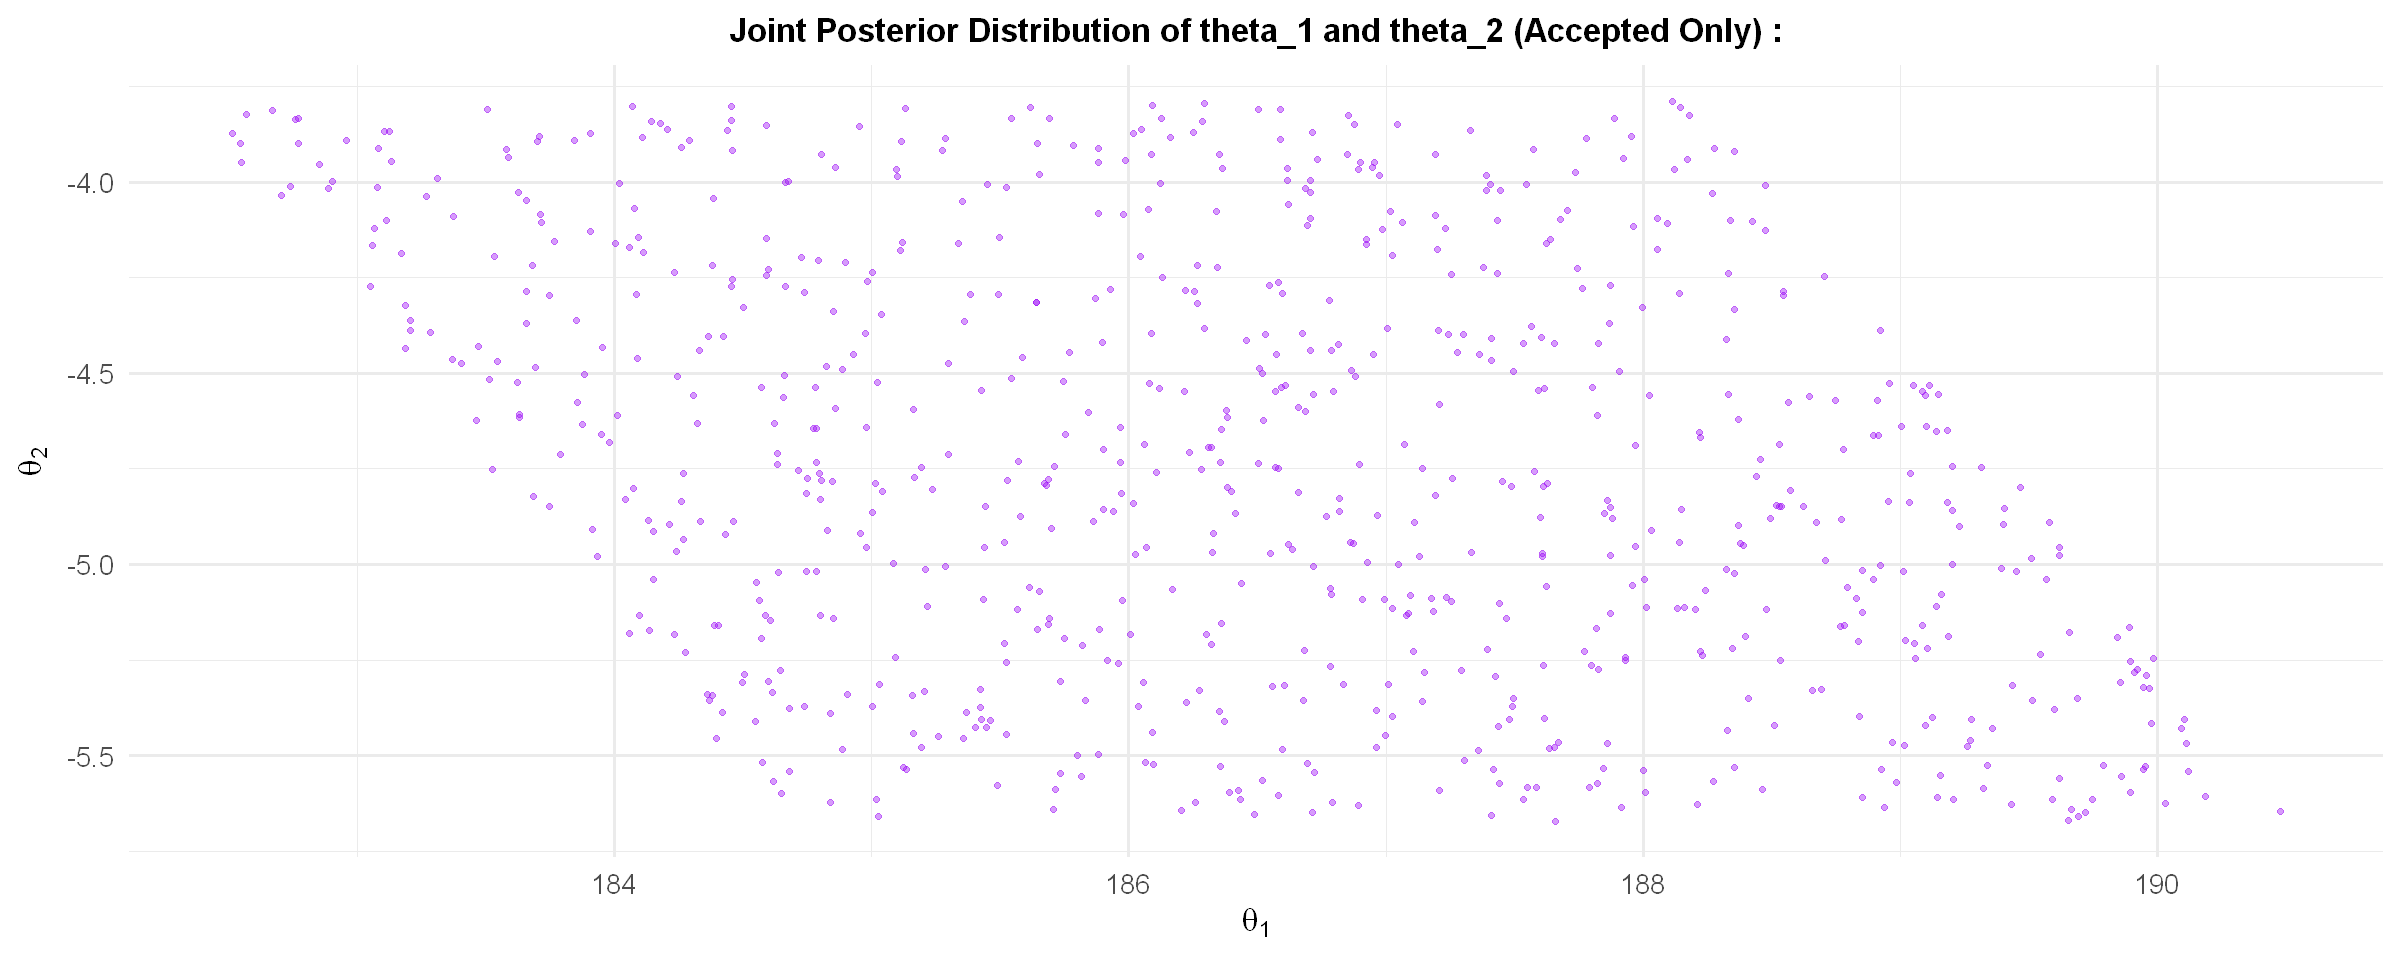

In [173]:
# Plot joint posterior of accepted samples with styled theme and centered big title
ggplot(posterior_df, aes(x = theta1, y = theta2)) +
  geom_point(alpha = 0.4, color = "#9906f5") +
  labs(
    title = "Joint Posterior Distribution of theta_1 and theta_2 (Accepted Only) :",
    x = expression(theta[1]),
    y = expression(theta[2])
  ) +
  theme_minimal(base_size = 20) +
  theme(
    plot.title = element_text(
      size = 20,
      face = "bold",
      hjust = 0.5
    ),
    axis.title = element_text(size = 19)
  )

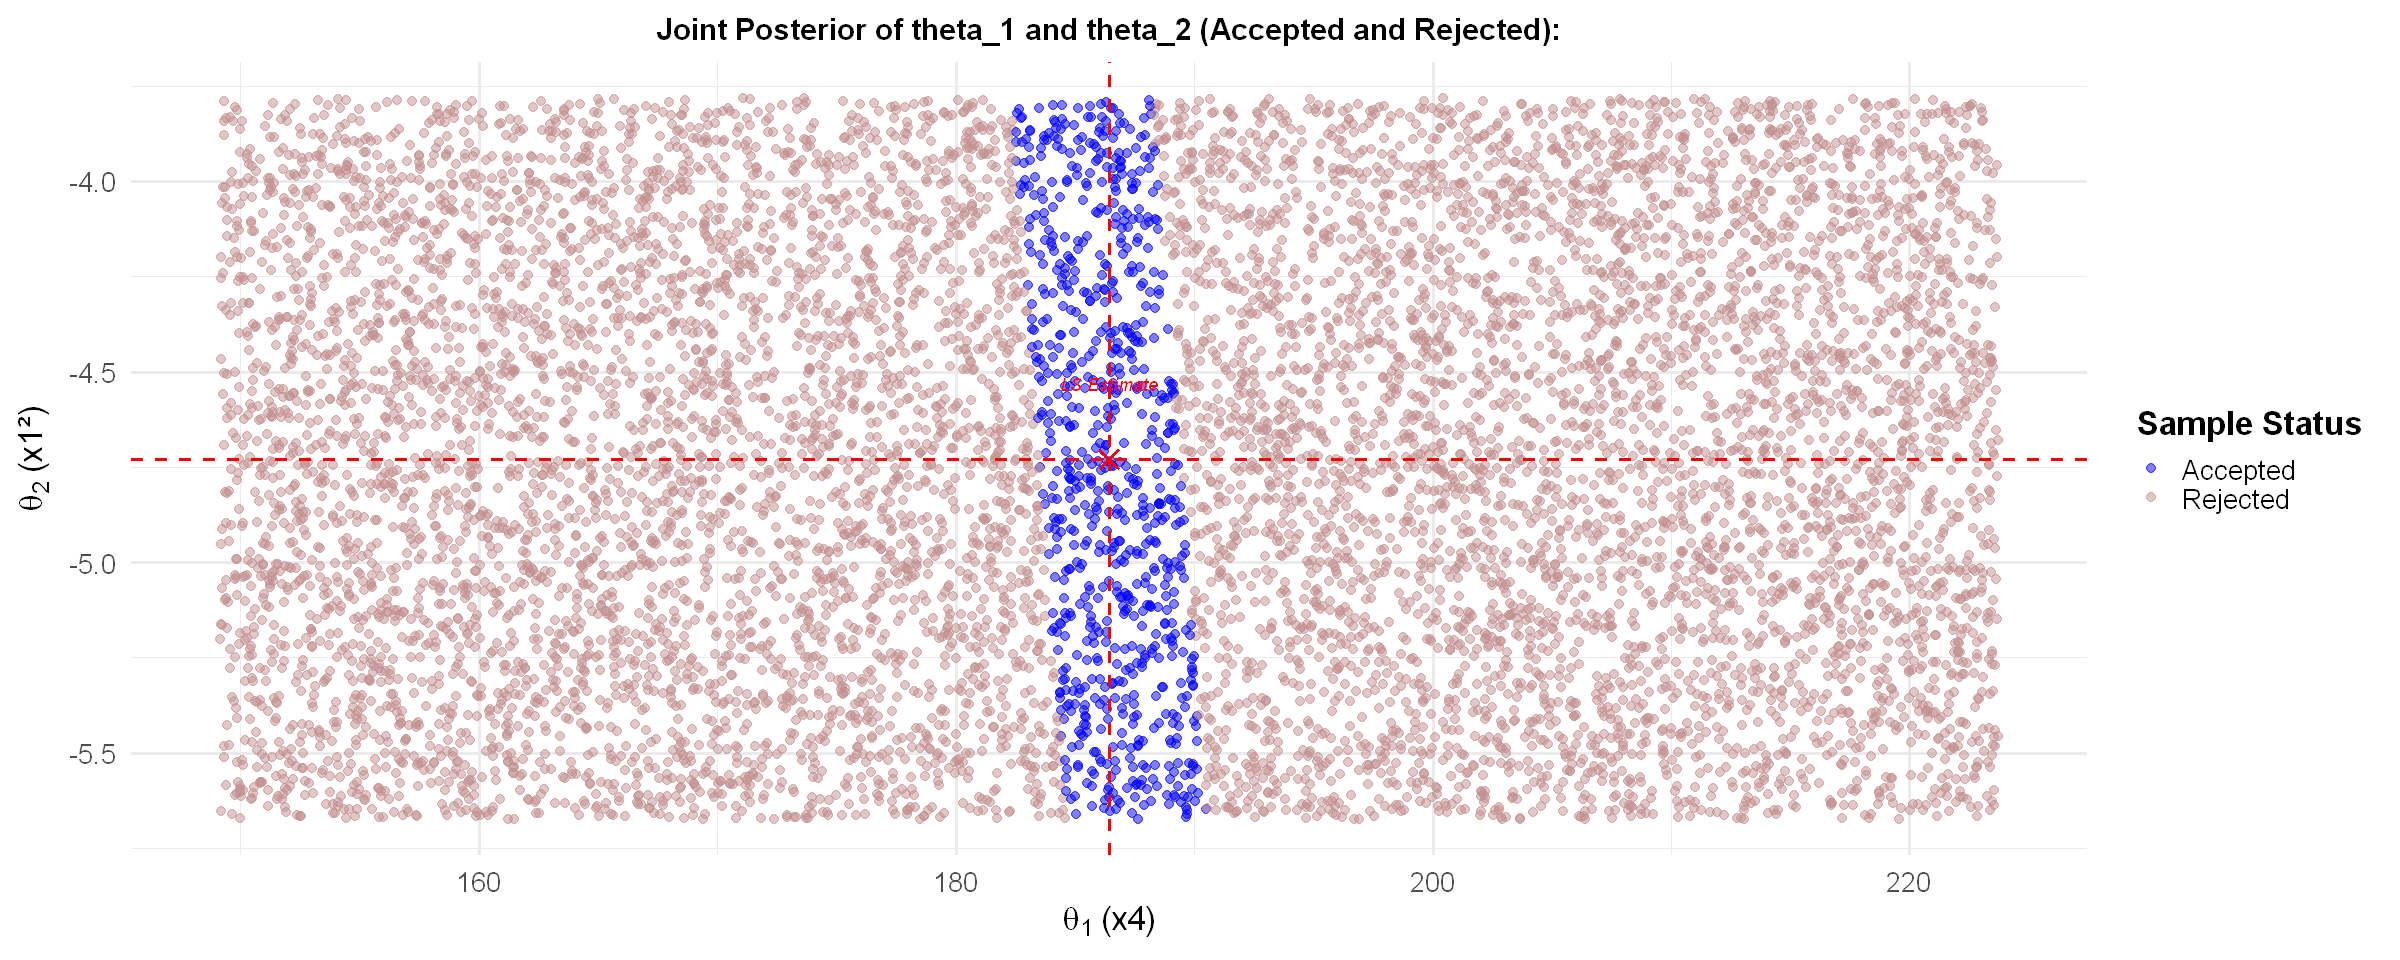

In [174]:
# Plot joint posterior including accepted/rejected
ggplot(full_sample_df, aes(x = theta1, y = theta2, color = status)) +
  geom_point(alpha = 0.5, size = 2.5) +
  scale_color_manual(values = c("Accepted" = "blue", "Rejected" = "#c39090")) +
  geom_vline(xintercept = theta1_mean, color = "red", linetype = "dashed", size = 1) +
  geom_hline(yintercept = theta2_mean, color = "red", linetype = "dashed", size = 1) +
  annotate("point", x = theta1_mean, y = theta2_mean, color = "red", shape = 4, size = 4, stroke = 1.5) +
  annotate("text", x = theta1_mean, y = theta2_mean + 0.2, label = "LS Estimate", color = "red", fontface = "italic") +
  labs(
    title = "Joint Posterior of theta_1 and theta_2 (Accepted and Rejected):",
    x = expression(theta[1] ~ "(x4)"),
    y = expression(theta[2] ~ "(x1²)"),
    color = "Sample Status"
  ) +
  theme_minimal(base_size = 20) +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold", size = 18),
    axis.title = element_text(face = "bold"),
    legend.title = element_text(face = "bold")
  )

#### **Vary $bias$ and $\theta_3$ and Keep $\theta_1$ and $\theta_2$ fixed in ABC:**

In [175]:
# Varying bias and theta_3, keeping theta_1 and theta_2 fixed: 

# 1. Prepare data and fixed parameters: 
x1_squared <- data$x1^2
x3_squared <- data$x3^2
x4 <- data$x4
y_obs <- data$y

# Fixed parameters (from LS estimates): 
theta1_fixed <- 186.436251
theta2_fixed <- -4.72887

In [176]:
# Vary bias and theta_3 (±20% around LS estimates): 
theta3_mean <- -2.599210
bias_mean <- -754.486865
theta3_range <- sort(c(theta3_mean * 1.2, theta3_mean * 0.8))
bias_range   <- sort(c(bias_mean * 1.2, bias_mean * 0.8))

In [177]:
# ABC test settings: 
n_samples <- 10000
epsilon <- 10^6.62 # Same threshold as before

# stored samples and distances: 
theta3_all <- numeric(n_samples)
bias_all <- numeric(n_samples)
distance <- numeric(n_samples)

set.seed(0) # random seed for reproducibility
# Run ABC rejection sampling for theta_3 and bias
for (i in 1:n_samples) {
  # Sample from priors
  theta3 <- runif(1, theta3_range[1], theta3_range[2])
  bias <- runif(1, bias_range[1], bias_range[2])
  theta3_all[i] <- theta3
  bias_all[i] <- bias
  # Simulate y
  y_sim <- theta1_fixed * x4 + theta2_fixed * x1_squared + theta3 * x3_squared + bias
  # Calculate distance (RSS)
  distance[i] <- sum((y_obs - y_sim)^2)
}

# Accepted samples: 
accepted_indices <- which(distance < epsilon)
posterior_df <- data.frame(
  theta3 = theta3_all[accepted_indices],
  bias = bias_all[accepted_indices]
)
status <- ifelse(distance < epsilon, "Accepted", "Rejected")
full_sample_df <- data.frame(
  theta3 = theta3_all,
  bias = bias_all,
  status = status
)

# LS estimates for reference
theta3_ls <- theta3_mean
bias_ls <- bias_mean

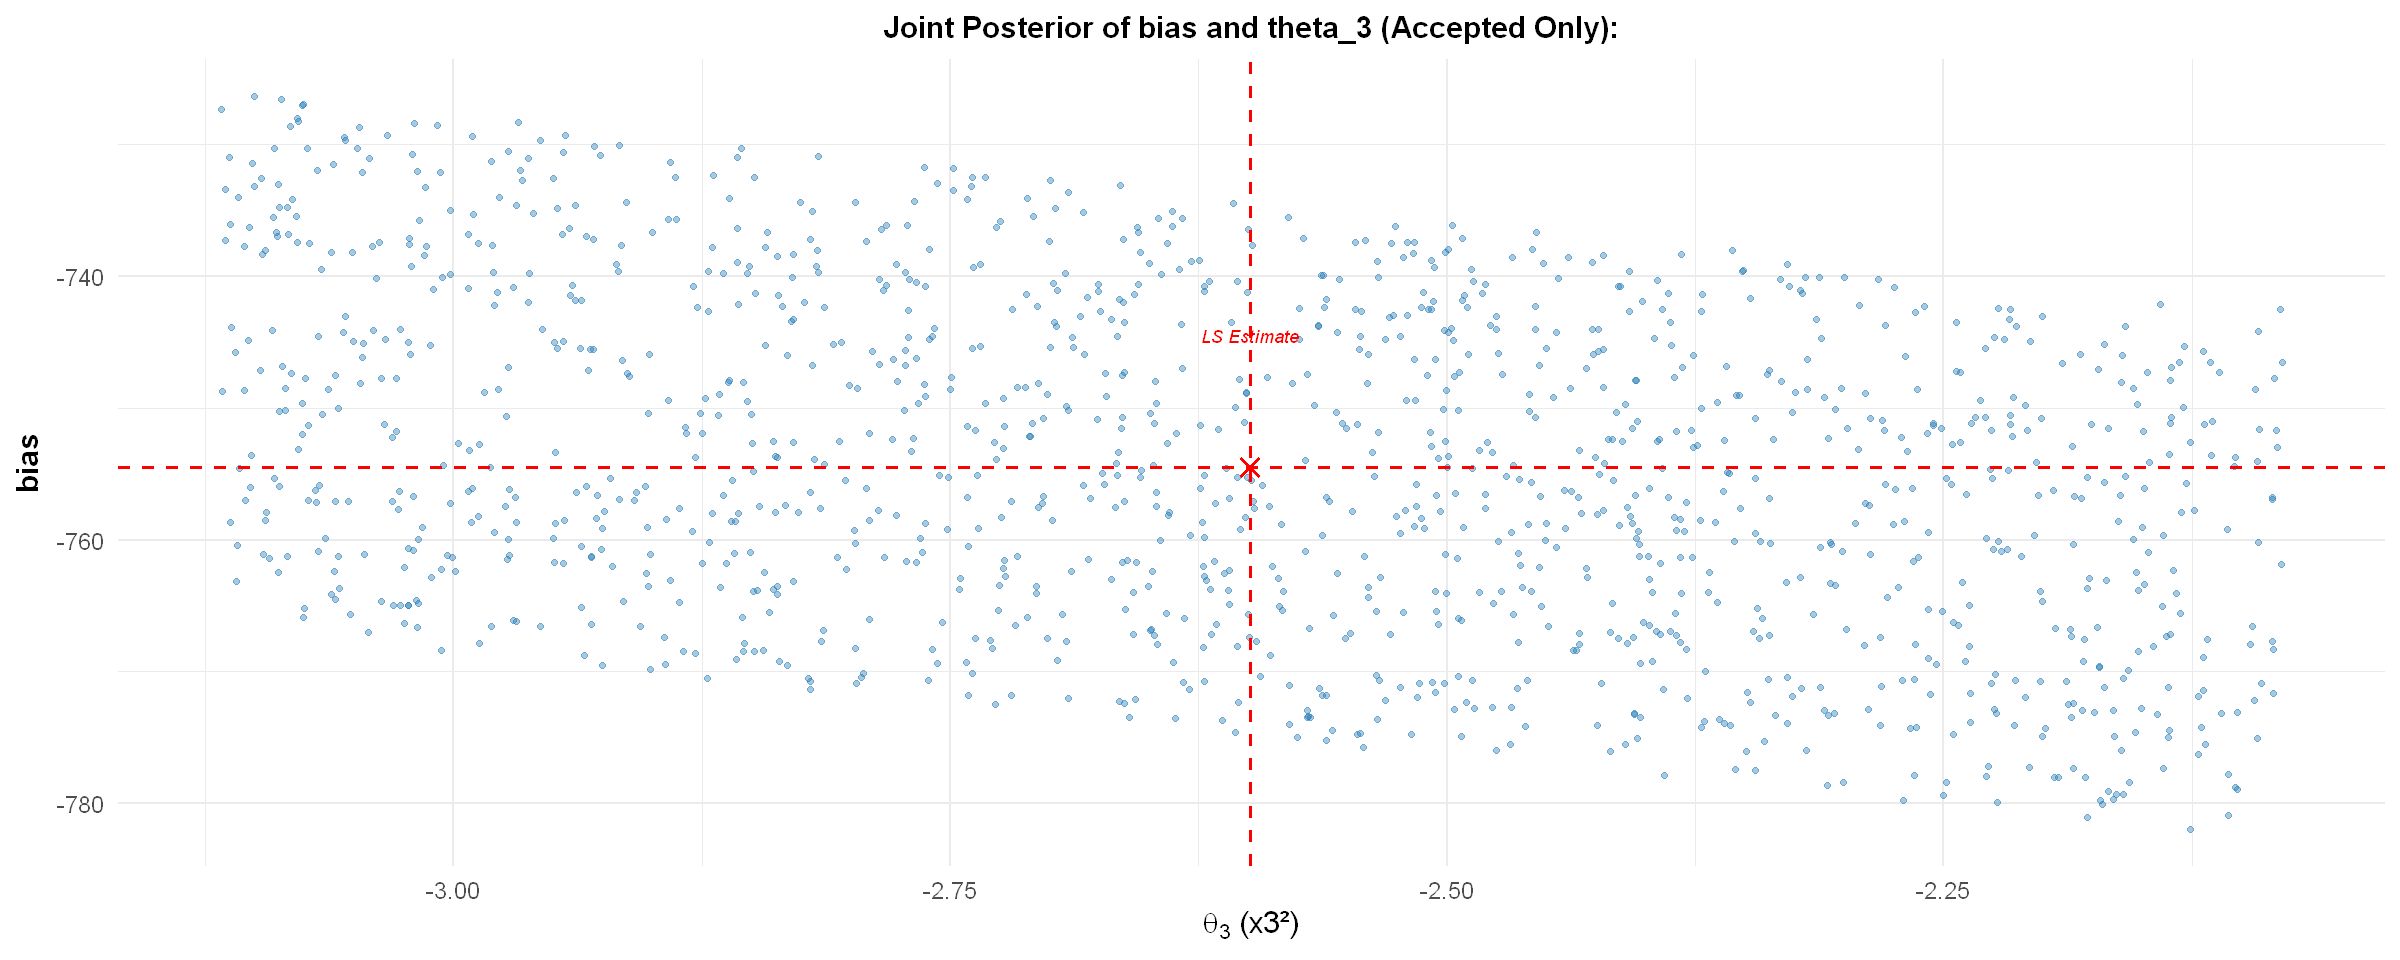

In [178]:
# Joint posterior (accepted only): 
ggplot(posterior_df, aes(x = theta3, y = bias)) +
  geom_point(alpha = 0.4, color = "#1f77b4") +
  geom_vline(xintercept = theta3_ls, color = "red", linetype = "dashed", size = 1) +
  geom_hline(yintercept = bias_ls, color = "red", linetype = "dashed", size = 1) +
  annotate("point", x = theta3_ls, y = bias_ls, color = "red", shape = 4, size = 4, stroke = 1.5) +
  annotate("text", x = theta3_ls, y = bias_ls + 10, label = "LS Estimate", color = "red", fontface = "italic") +
  labs(
    title = "Joint Posterior of bias and theta_3 (Accepted Only):",
    x = expression(theta[3] ~ "(x3²)"),
    y = "bias"
  ) +
  theme_minimal(base_size = 18) +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold", size = 18),
    axis.title = element_text(face = "bold")
  )

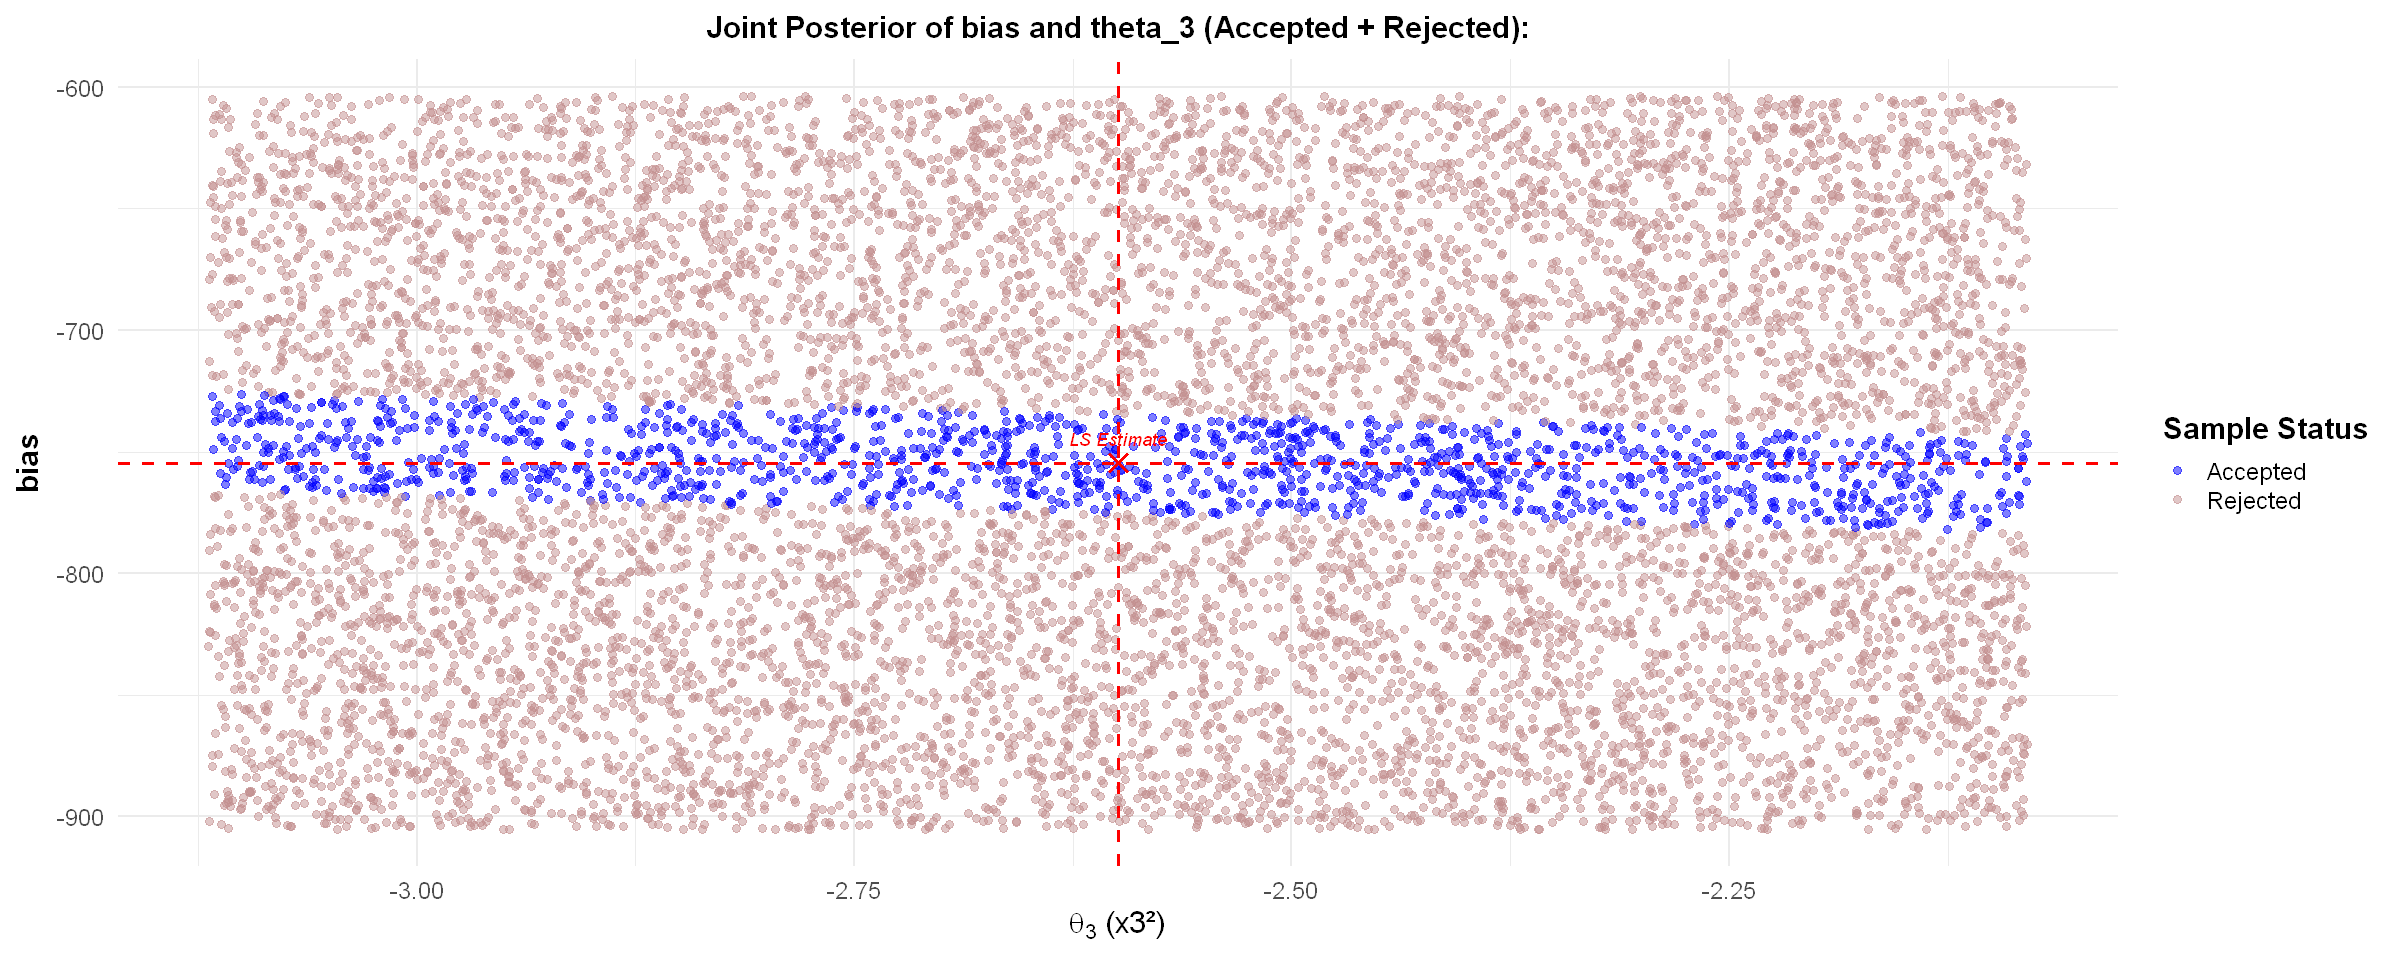

In [179]:
# Joint posterior (accepted and rejected)
ggplot(full_sample_df, aes(x = theta3, y = bias, color = status)) +
  geom_point(alpha = 0.5, size = 2.2) +
  scale_color_manual(values = c("Accepted" = "blue", "Rejected" = "#c39090")) +
  geom_vline(xintercept = theta3_ls, color = "red", linetype = "dashed", size = 1) +
  geom_hline(yintercept = bias_ls, color = "red", linetype = "dashed", size = 1) +
  annotate("point", x = theta3_ls, y = bias_ls, color = "red", shape = 4, size = 4, stroke = 1.5) +
  annotate("text", x = theta3_ls, y = bias_ls + 10, label = "LS Estimate", color = "red", fontface = "italic") +
  labs(
    title = "Joint Posterior of bias and theta_3 (Accepted + Rejected):",
    x = expression(theta[3] ~ "(x3²)"),
    y = "bias",
    color = "Sample Status"
  ) +
  theme_minimal(base_size = 18) +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold", size = 18),
    axis.title = element_text(face = "bold"),
    legend.title = element_text(face = "bold")
  )